# Attention Unet model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pre-Processing
import os
import numpy as np
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Activation, Multiply, SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping
# Loss
import tensorflow.keras.backend as K
# Plot
import matplotlib.pyplot as plt


In [ ]:
print(os.getcwd())
os.chdir("/content/drive/MyDrive/BTP")
print(os.getcwd())

/content
/content/drive/MyDrive/BTP


## Data loader

In [ ]:
def read_image(file_path, size):
    """ Read image in grayscale format, resize and Expand dimensions:

    Args:
        file_path (String): The path to image file
        size: (height, width) of resized image

    Returns:
        numpy.ndarray: A 3-Dimentional array of image in (height,width,channel) format
    """
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size, interpolation=cv2.INTER_NEAREST) # INTER_NEAREST will not result in color change
    image = np.expand_dims(image, axis=-1)
    return image

def get_train_data(X_train_path: str, y_train_path: str , start_index: int, end_index: int):
    """
    Reads files with the extension '.tif' in sorted order and appends them to the output array.

    Assumptions:
        Image Files in both OCT and Reference images are of same name.

    Parameters:
        X_train_path (string): The path to folder containing OCT scan images.
        y_train_path (string): The path to folder containing Reference images.
        start_index (int): The starting index of the array to append files.
        end_index (int): The ending index (exclusive) of the array to append files.

    Returns:
        numpy.ndarray: An array containing the contents of the '.tif' files.

    Example:
        # To read and append '.tif' files from index 0 to 9 (10 in number)
        output_array = read_tif_files_sorted(0, 10)
    """
    start_index = start_index if start_index >= 0 else 0    # Start index is 0
    end_index = end_index if end_index <= 6936 else 6936    # Total number of images in dataset

    files = sorted(os.listdir(X_train_path))
    X_train = []
    y_train = []

    for i in range(start_index, end_index):
        X_file_path = os.path.join(X_train_path, files[i])
        y_file_path = os.path.join(y_train_path, files[i])

        print(i, X_file_path)
        print(i, y_file_path)

        image = read_image(X_file_path, (128, 256)) #------------------------------------------------> Shape
        X_train.append(image)

        image = read_image(y_file_path, (128, 256)) #------------------------------------------------> Shape
        y_train.append(image)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    print("X_Train_shape:", X_train.shape)
    print("y_Train_shape:", y_train.shape)


    return X_train,y_train

## Model

In [ ]:
def conv_block(input_tensor, num_filters):
    encoder = SeparableConv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    encoder = SeparableConv2D(num_filters, (3, 3), padding='same', activation='relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(decoder)
    return decoder

def attention_gate(x, g):
    """
    Implements an attention gate function.

    Arguments:
    x -- Input tensor (e.g., feature map)
    g -- Gate tensor (e.g., context tensor)

    Returns:
    gated_output -- Output tensor after applying attention gating
    """

    # Calculate attention coefficients
    attention_weights = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding='same')(tf.keras.layers.concatenate([x, g]))

    # Apply attention gating
    gated_output = tf.multiply(x, attention_weights)

    return gated_output

def unet_model(input_shape, num_classes, depth=4):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder_outputs = []
    encoder = inputs
    for i in range(depth):
        encoder, encoder_out = encoder_block(encoder, 64 * (2 ** i))
        encoder_outputs.append(encoder_out)

    # Bridge
    bridge = conv_block(encoder, 1024)

    # Decoder
    decoder = bridge
    for i in reversed(range(depth)):
        decoder = decoder_block(decoder, encoder_outputs[i], 64 * (2 ** i))
        decoder = attention_gate(decoder, encoder_outputs[i])

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(decoder)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


## Loss

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred, alpha=0.5):
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)  # Binary Cross-Entropy loss
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + (1 - alpha) * dice

## Loop

In [ ]:
X_train_path = './Images/OCT'
y_train_path = './Images/Reference'

In [ ]:
file_path = "./Models/Attention-U-net.h5"

# Check if the file exists before deleting it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' deleted successfully.")
else:
    print(f"File '{file_path}' does not exist.")

File './Models/Attention-U-net.h5' does not exist.


0 ./Images/OCT/01_000.tif
0 ./Images/Reference/01_000.tif
1 ./Images/OCT/01_001.tif
1 ./Images/Reference/01_001.tif
2 ./Images/OCT/01_002.tif
2 ./Images/Reference/01_002.tif
3 ./Images/OCT/01_003.tif
3 ./Images/Reference/01_003.tif
4 ./Images/OCT/01_004.tif
4 ./Images/Reference/01_004.tif
5 ./Images/OCT/01_005.tif
5 ./Images/Reference/01_005.tif
6 ./Images/OCT/01_006.tif
6 ./Images/Reference/01_006.tif
7 ./Images/OCT/01_007.tif
7 ./Images/Reference/01_007.tif
8 ./Images/OCT/01_008.tif
8 ./Images/Reference/01_008.tif
9 ./Images/OCT/01_009.tif
9 ./Images/Reference/01_009.tif
10 ./Images/OCT/01_010.tif
10 ./Images/Reference/01_010.tif
11 ./Images/OCT/01_011.tif
11 ./Images/Reference/01_011.tif
12 ./Images/OCT/01_012.tif
12 ./Images/Reference/01_012.tif
13 ./Images/OCT/01_013.tif
13 ./Images/Reference/01_013.tif
14 ./Images/OCT/01_014.tif
14 ./Images/Reference/01_014.tif
15 ./Images/OCT/01_015.tif
15 ./Images/Reference/01_015.tif
16 ./Images/OCT/01_016.tif
16 ./Images/Reference/01_016.tif


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 41s 15s/step


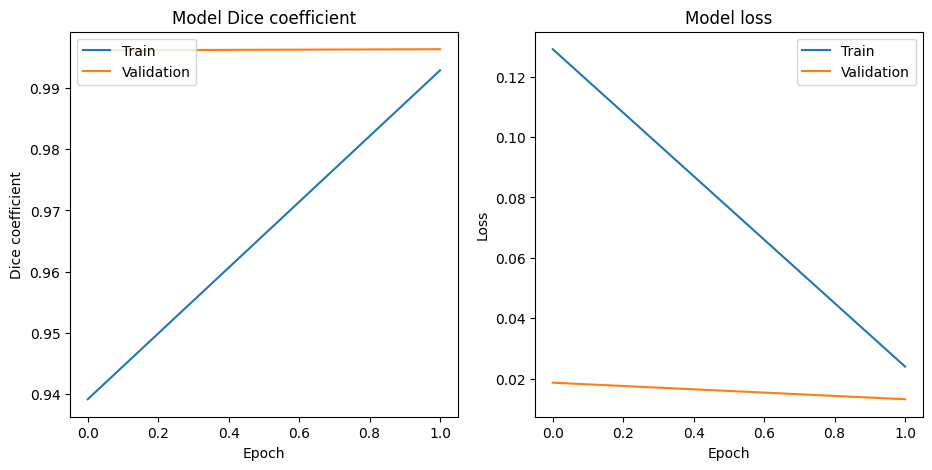

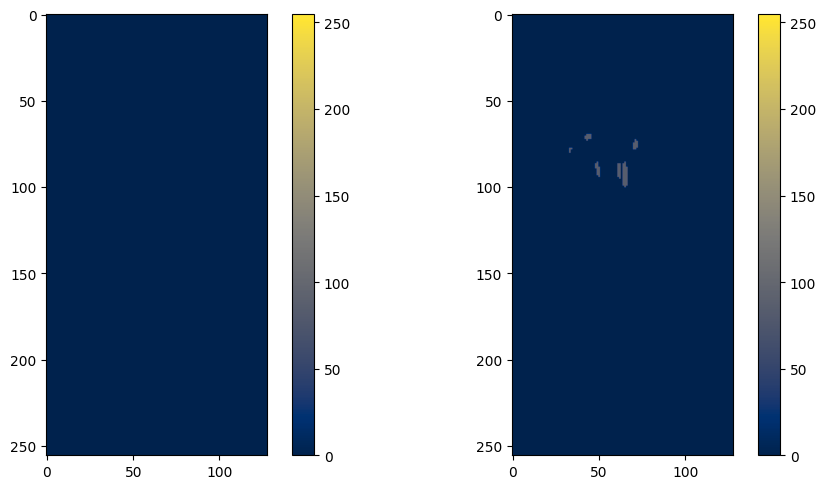

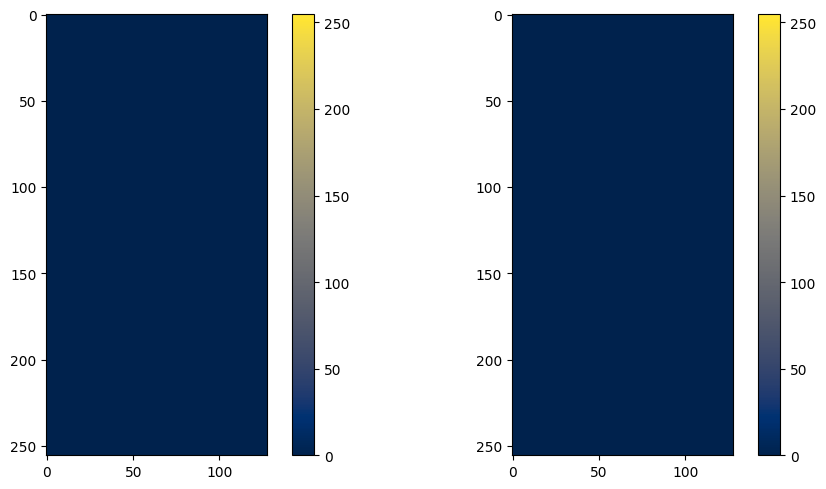

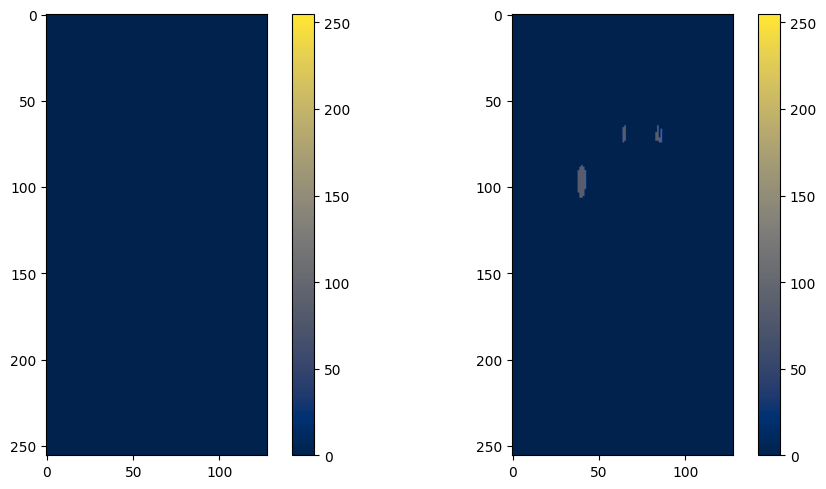

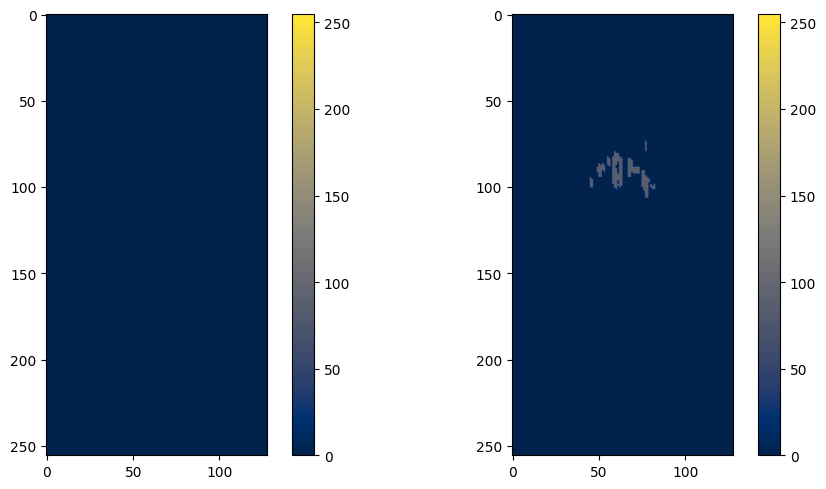

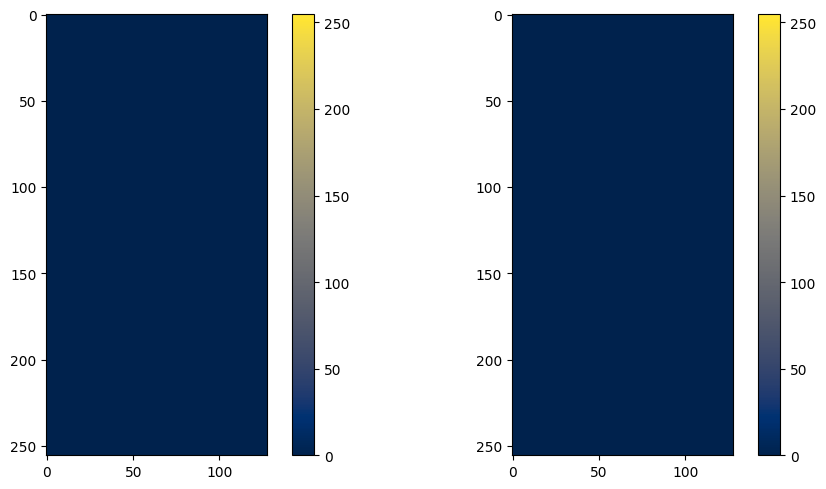

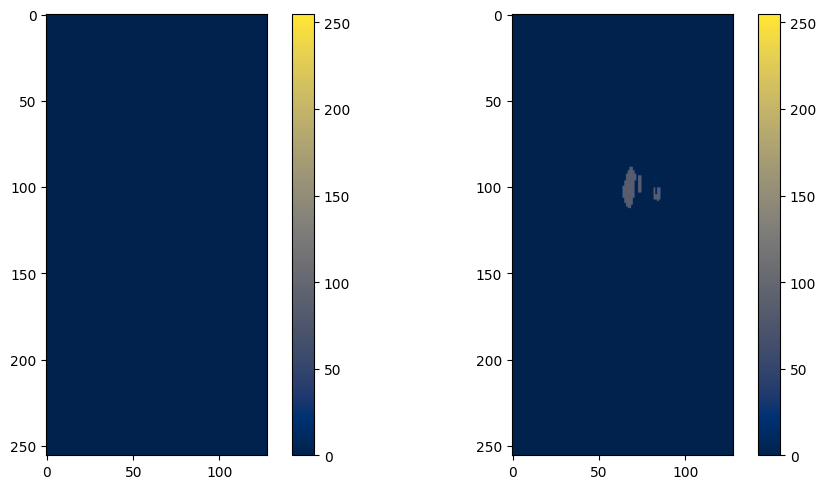

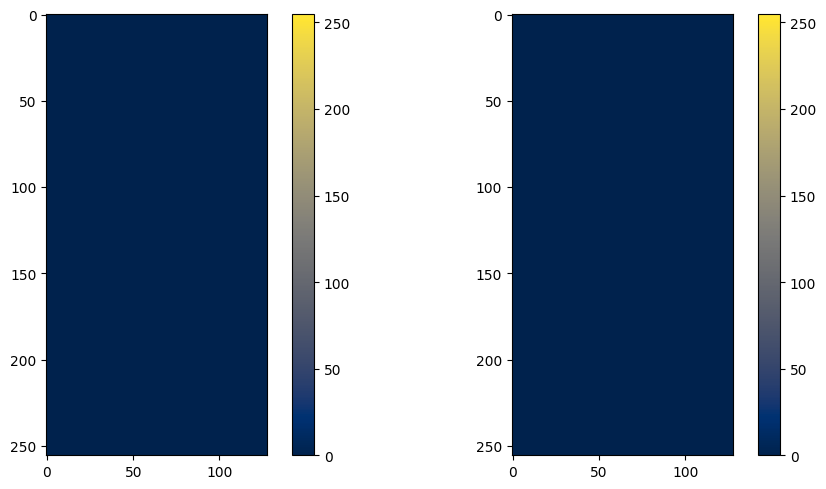

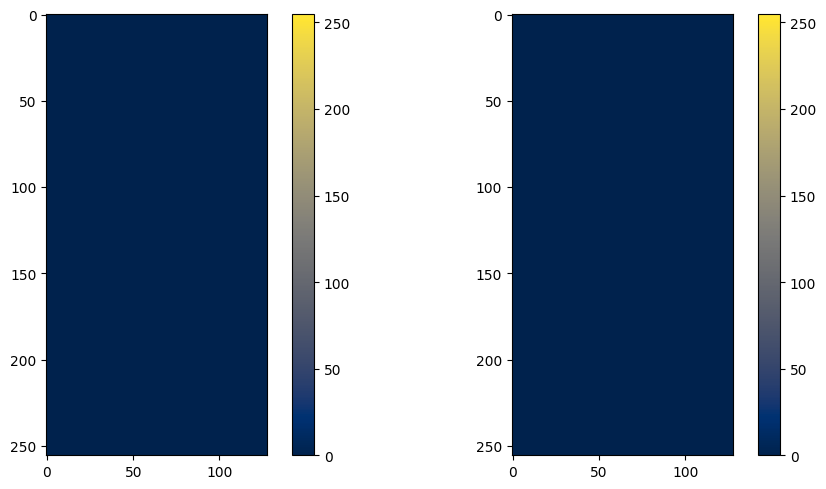

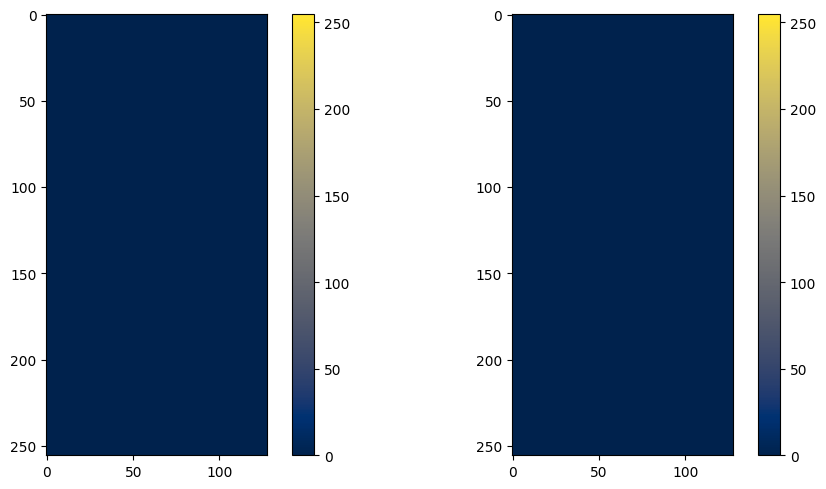

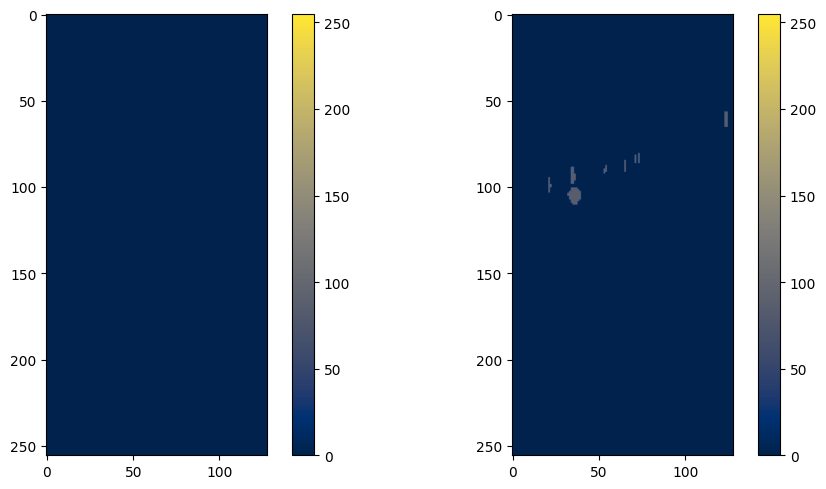

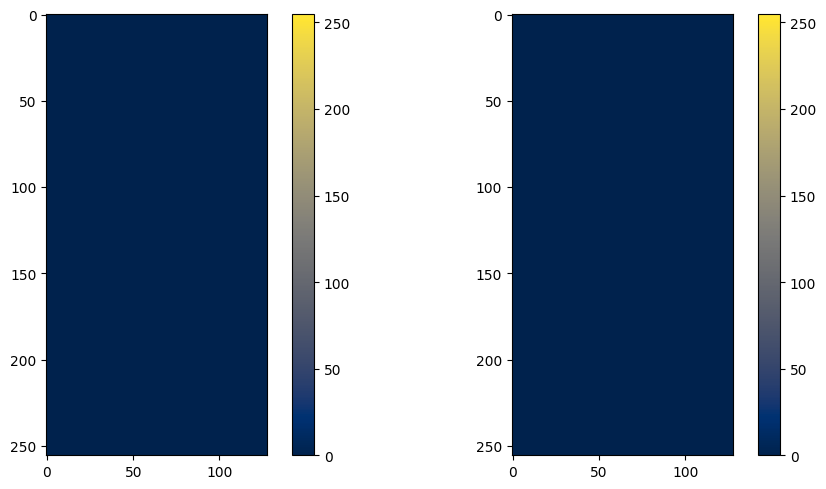

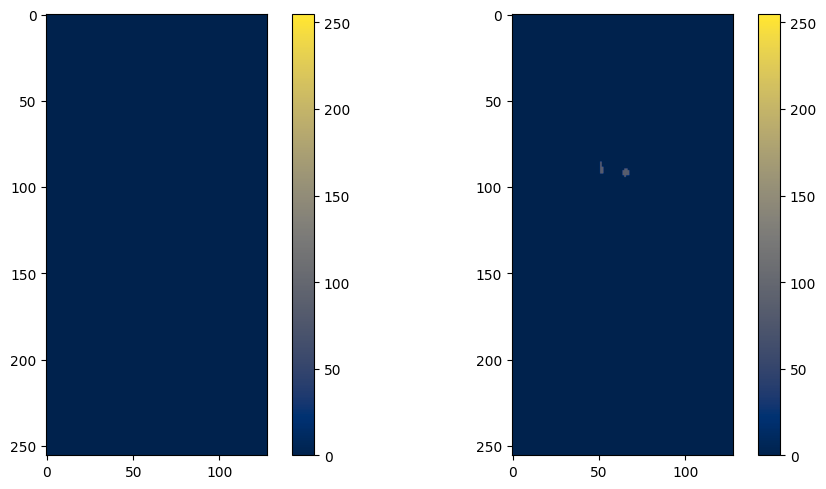

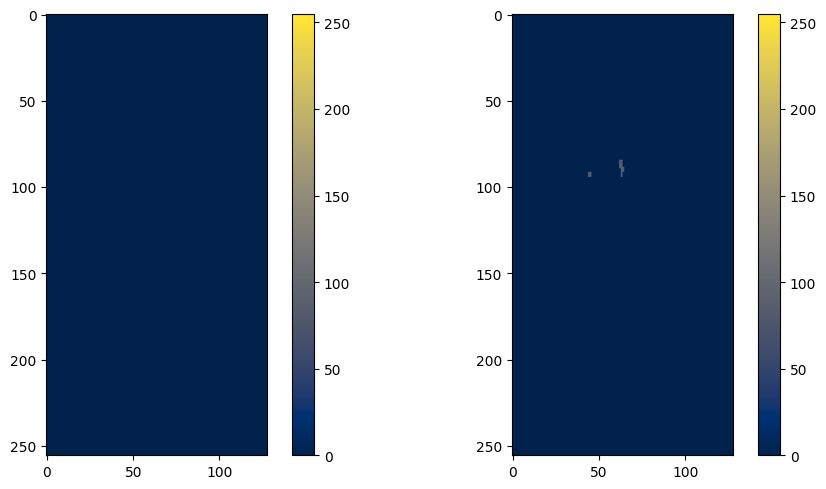

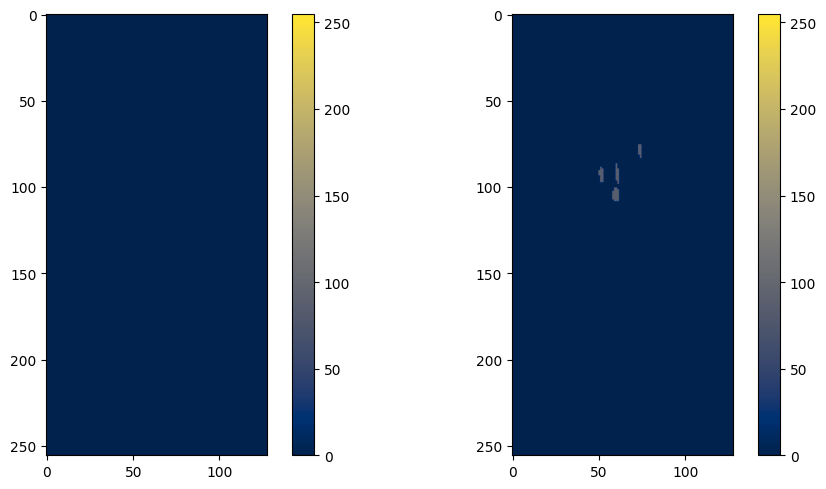

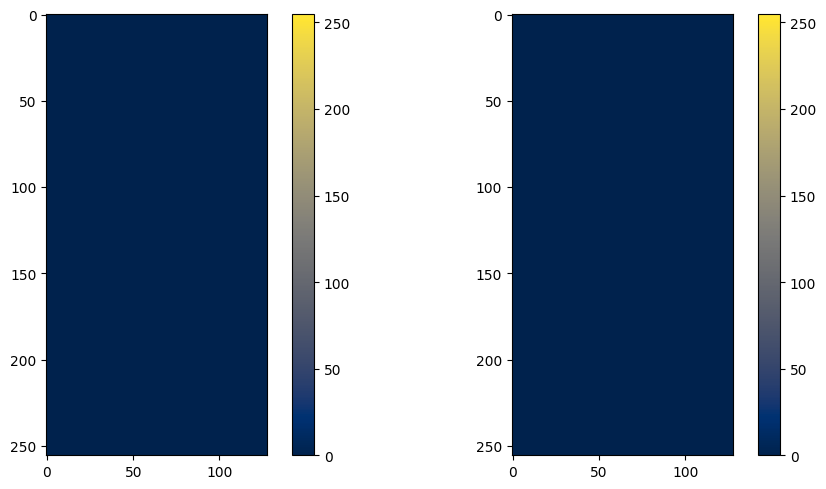

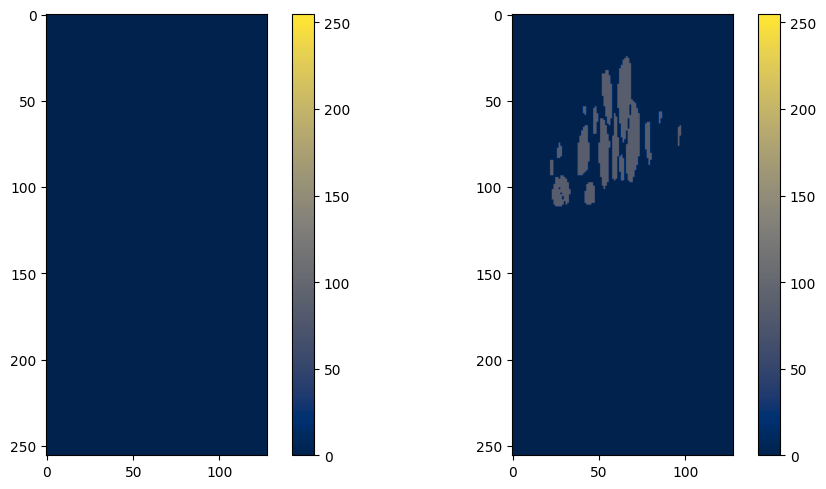

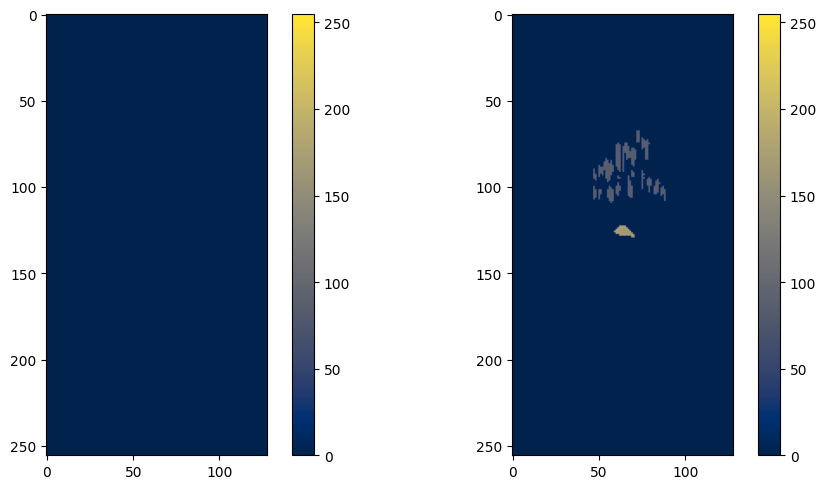

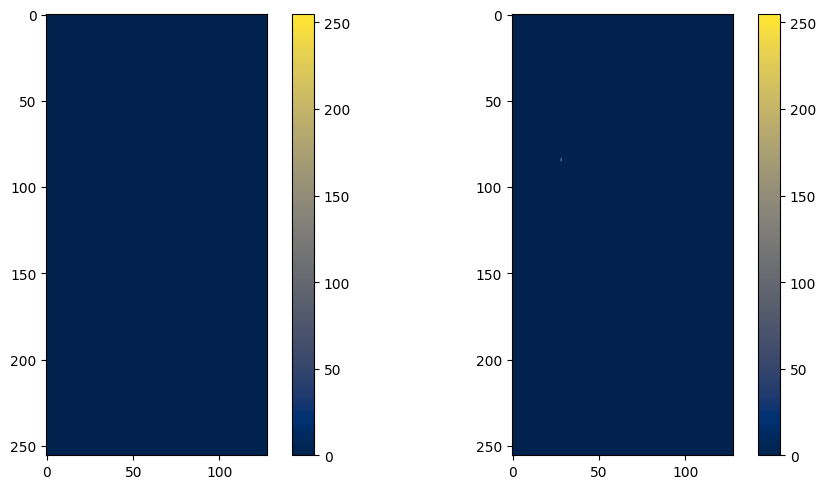

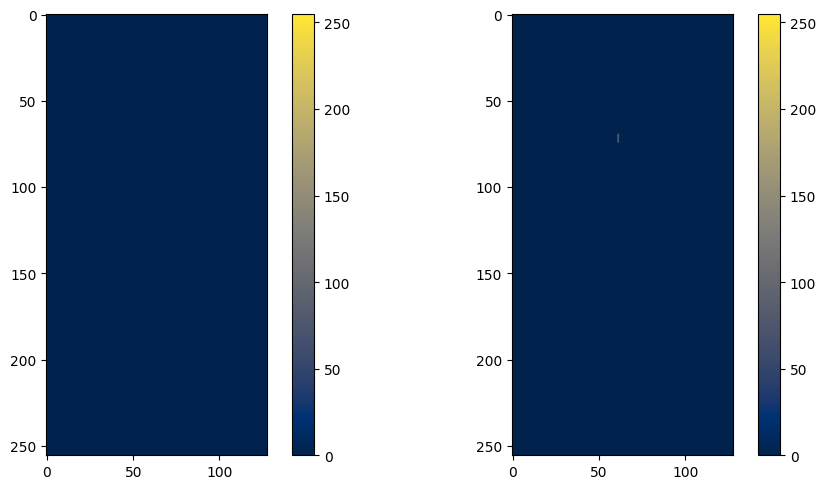

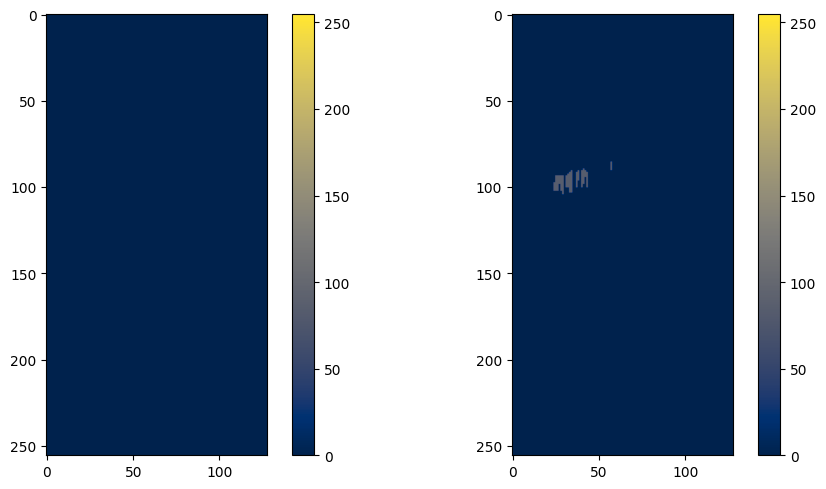

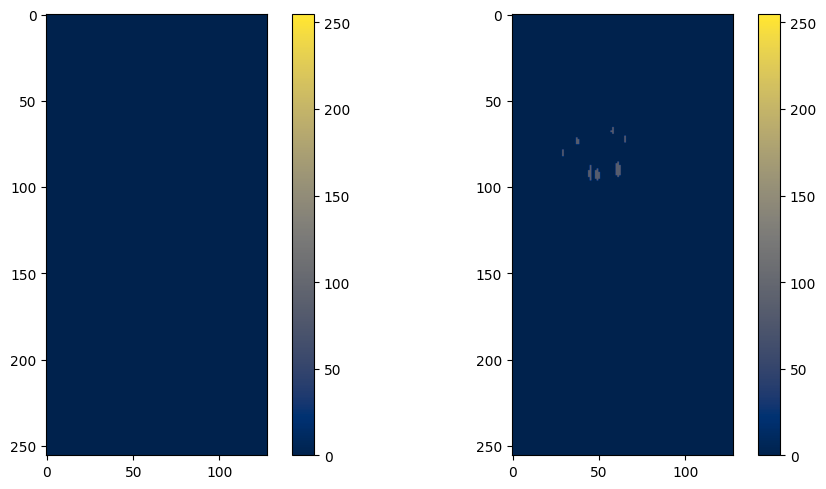

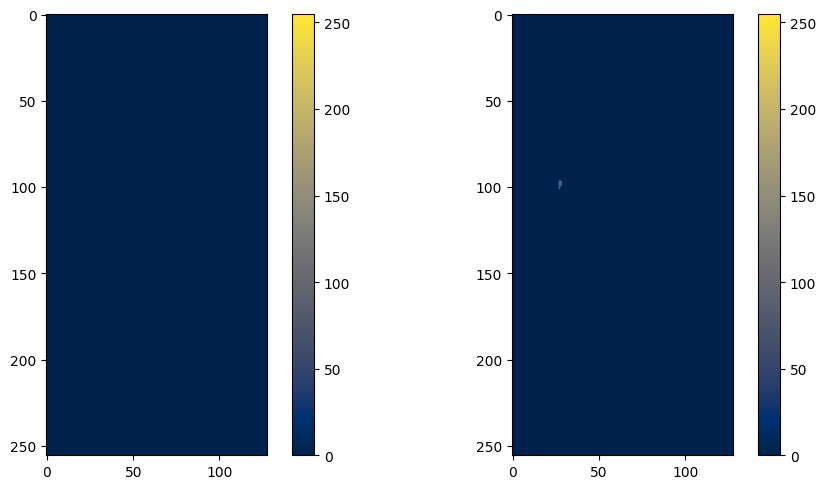

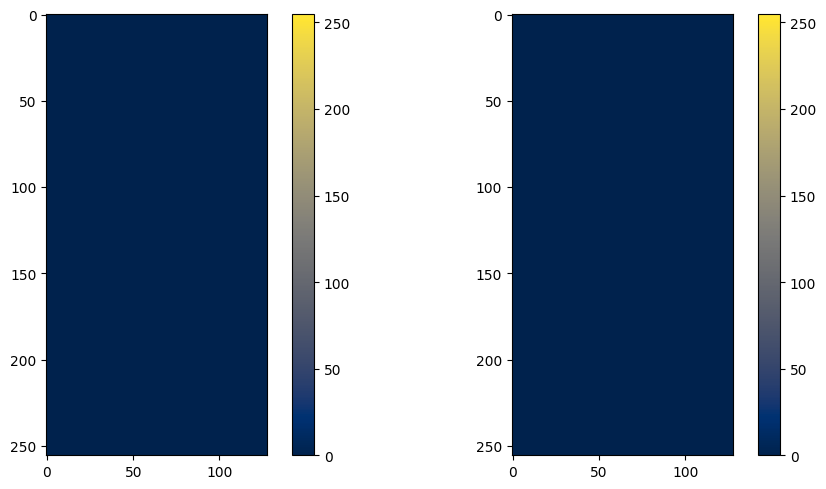

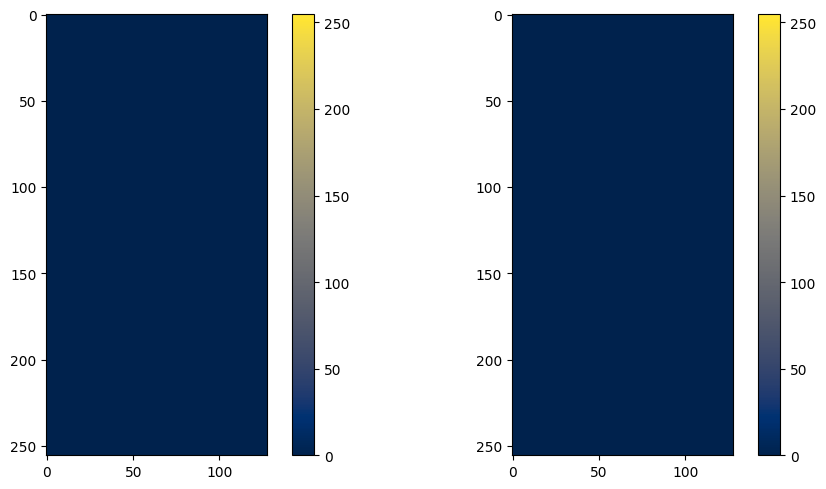

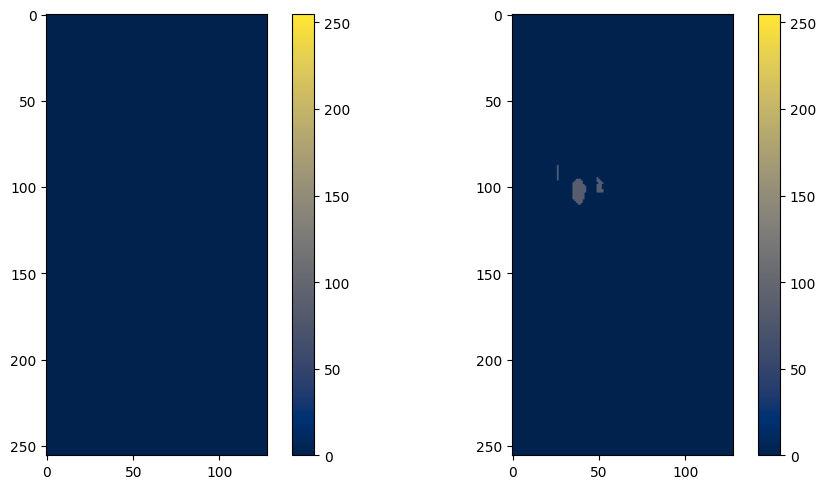

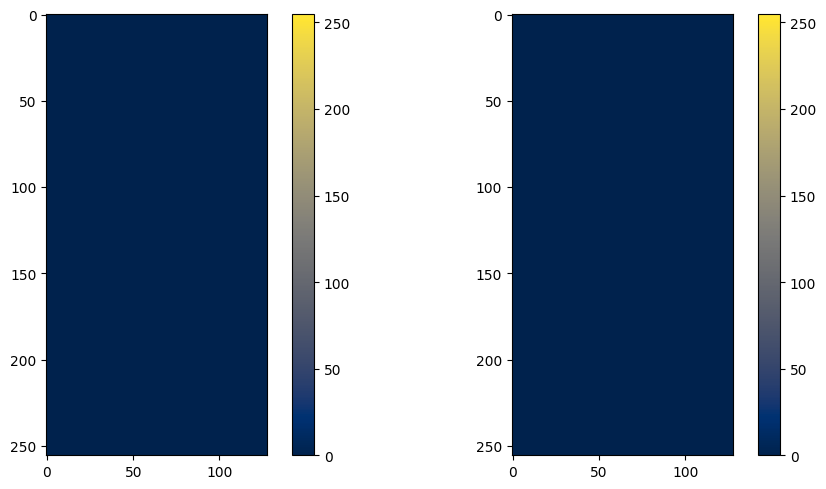

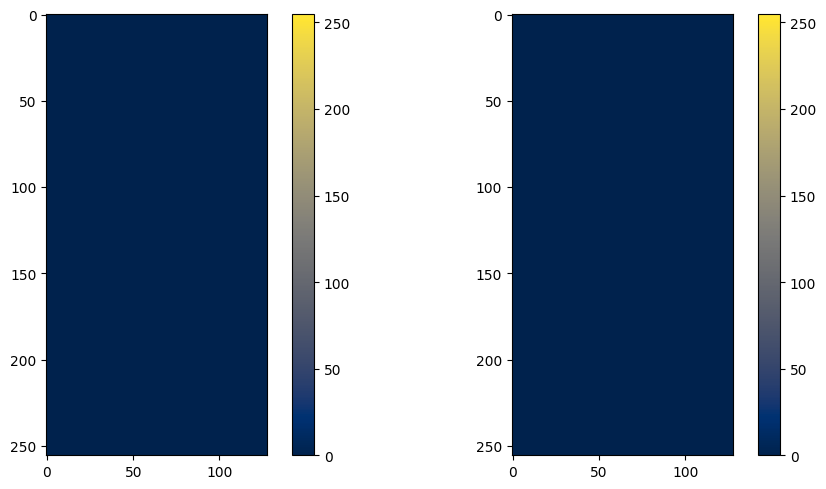

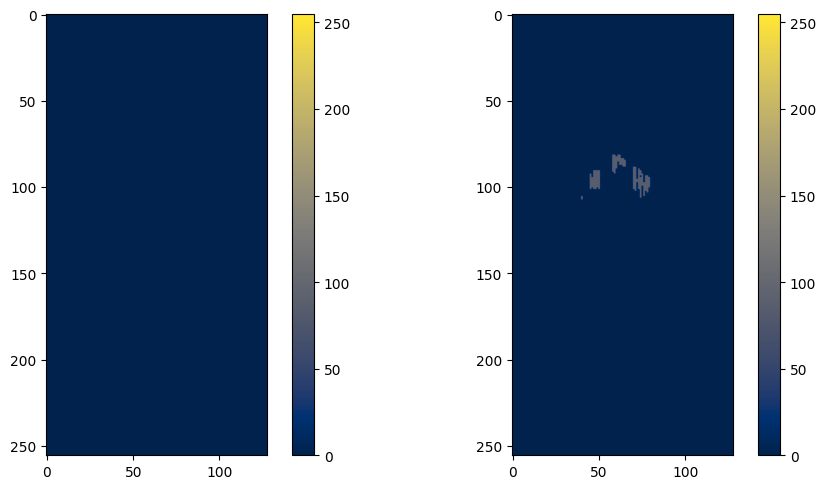

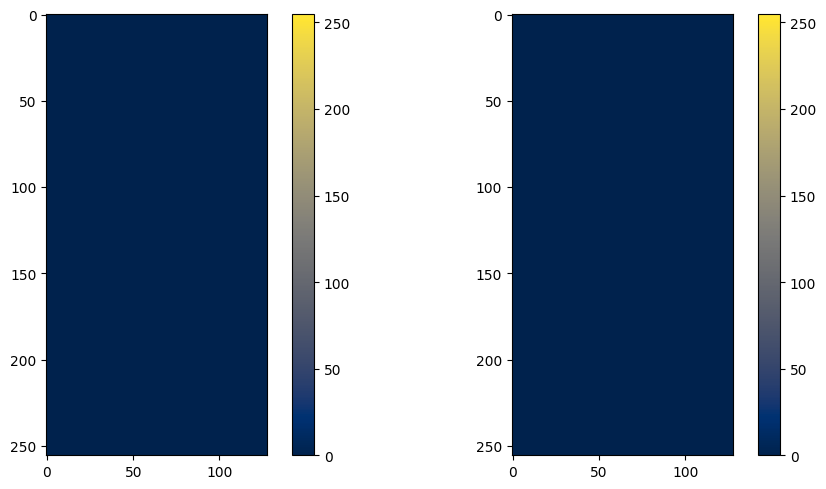

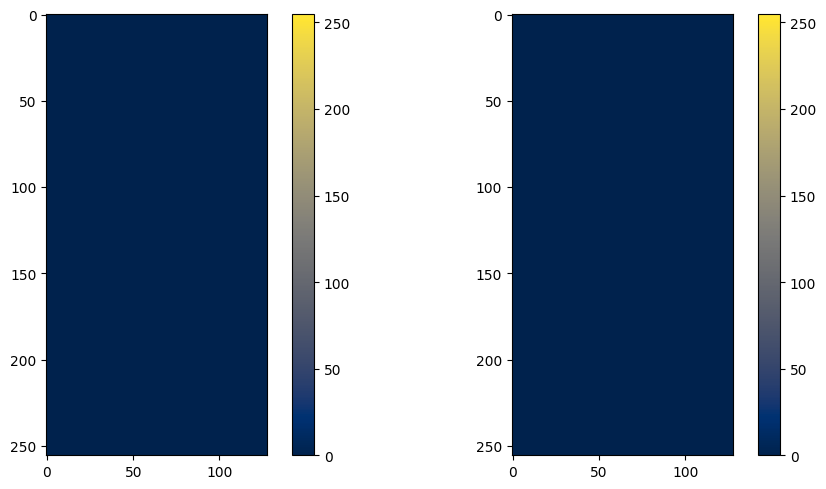

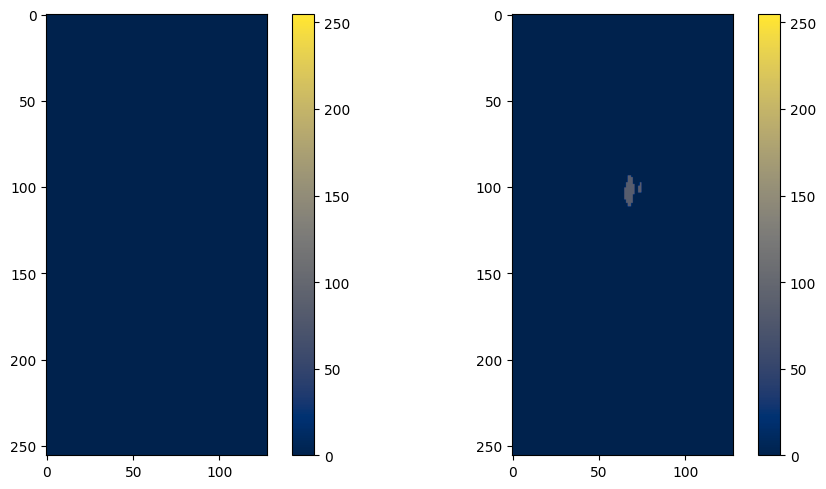

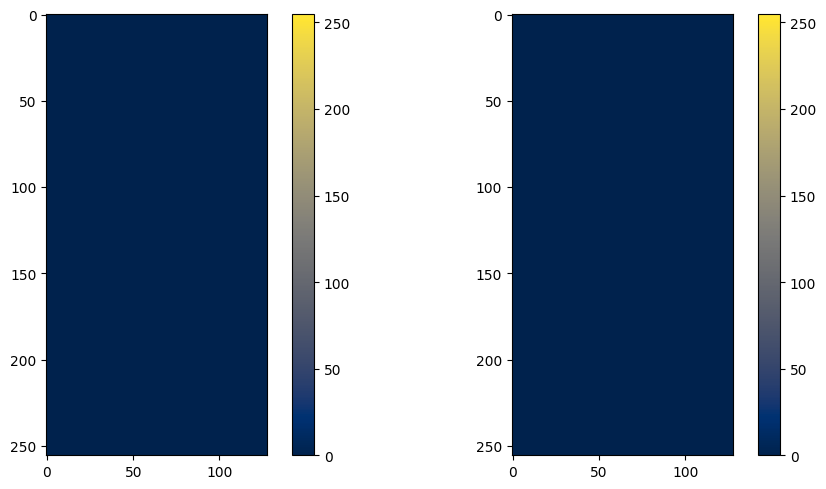

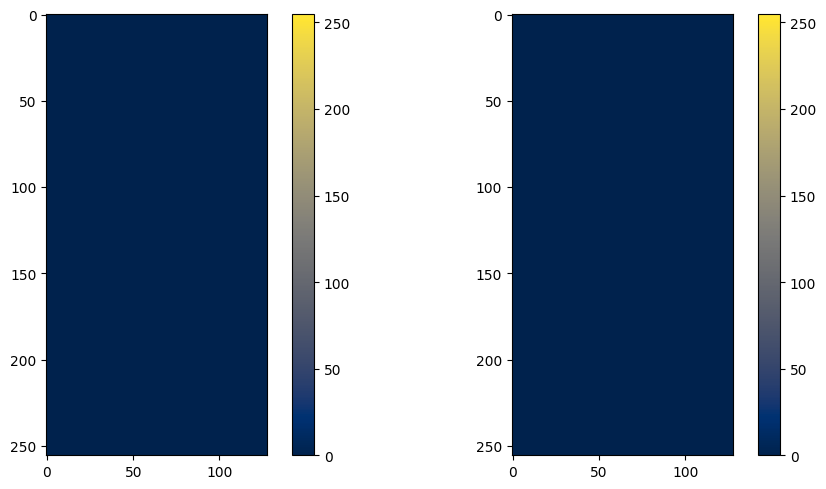

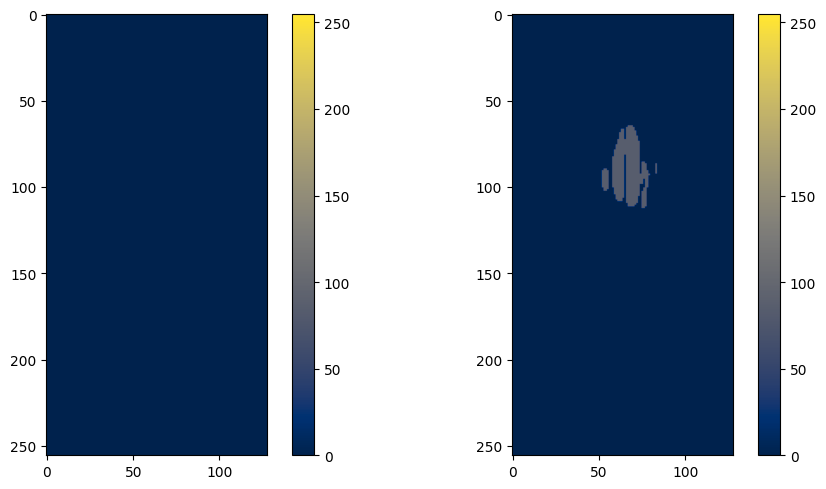

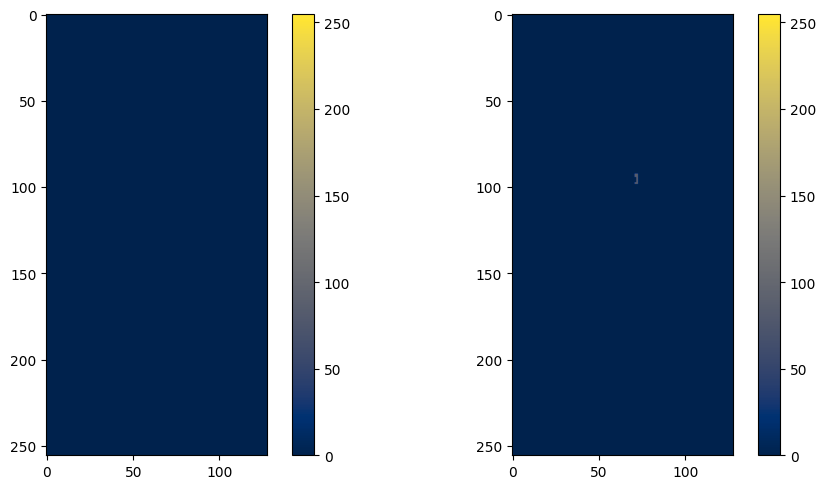

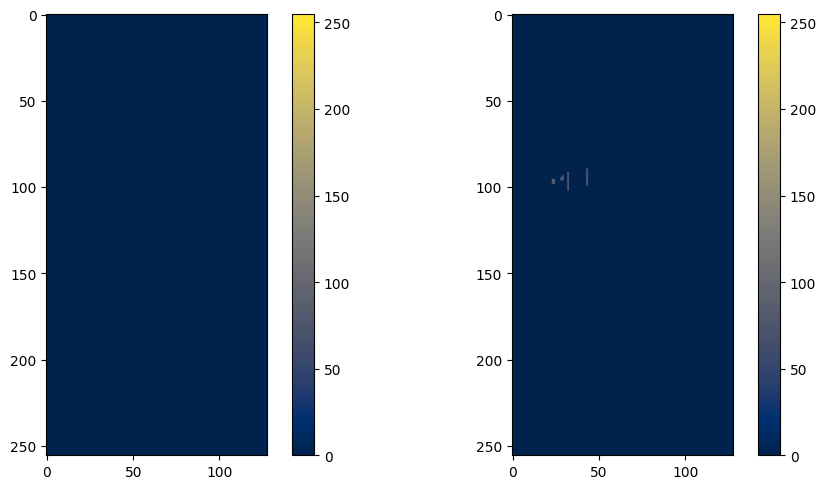

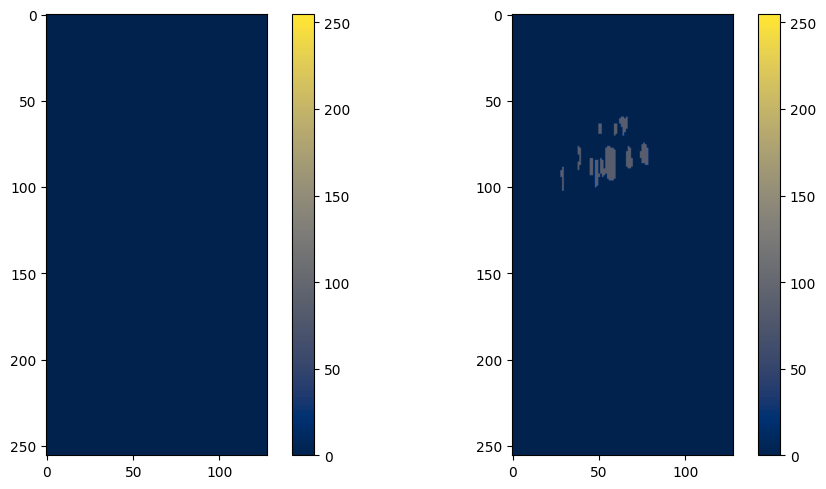

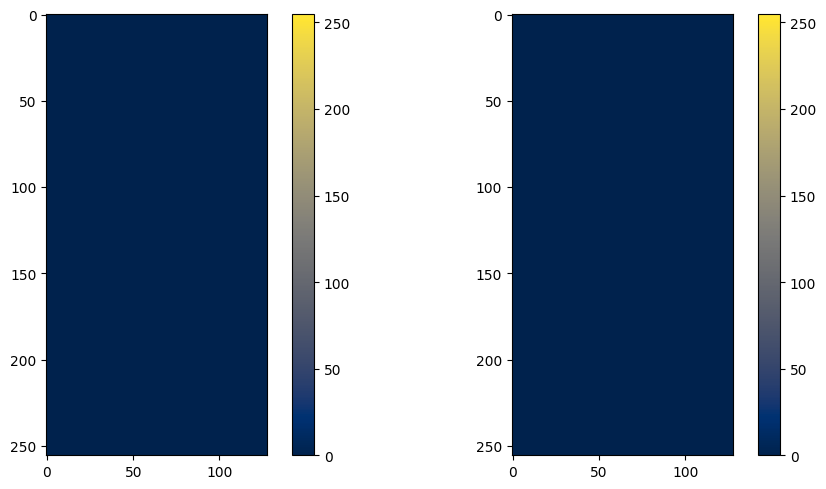

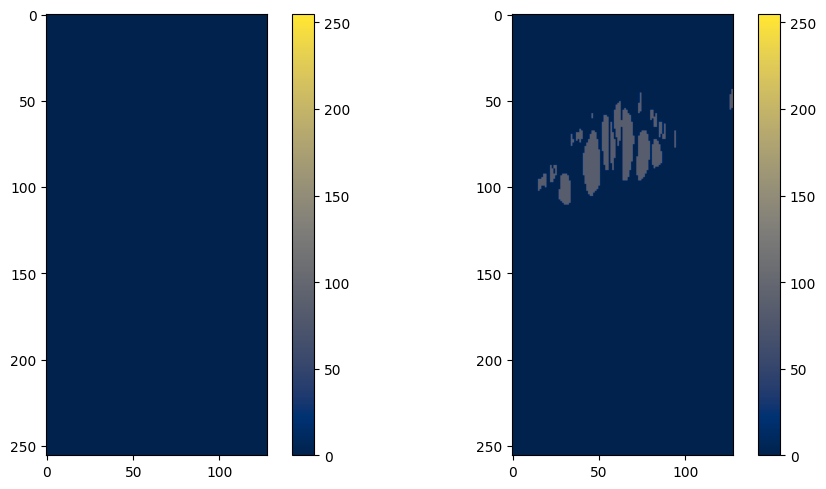

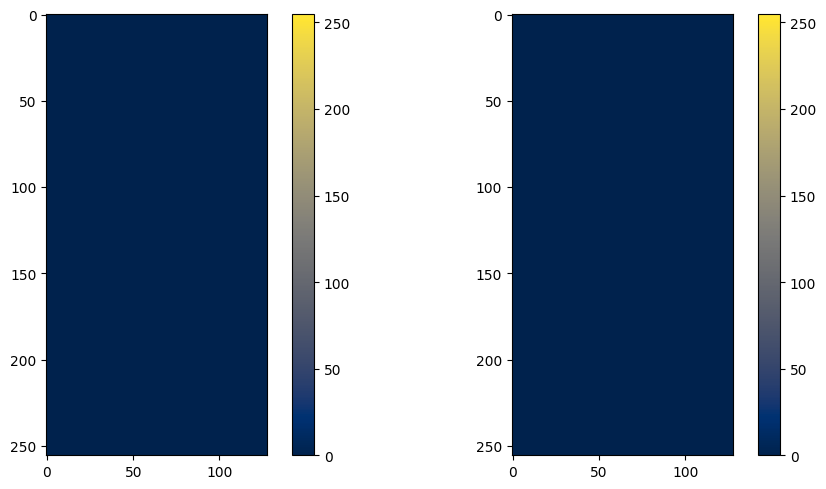

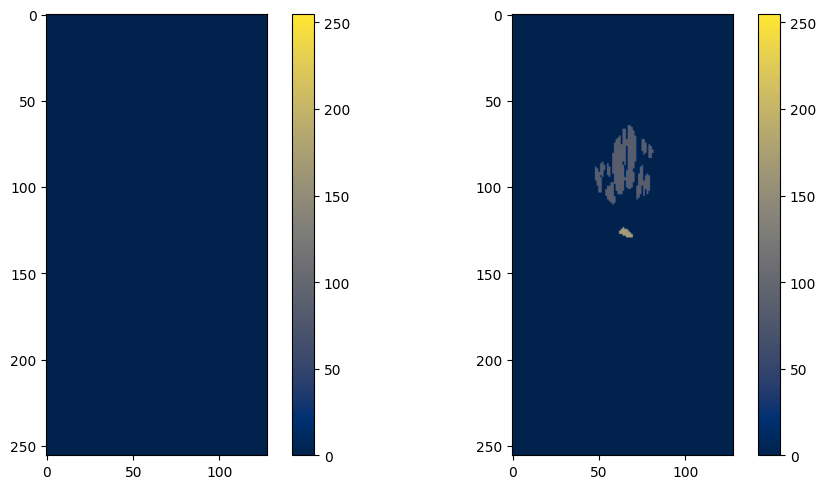

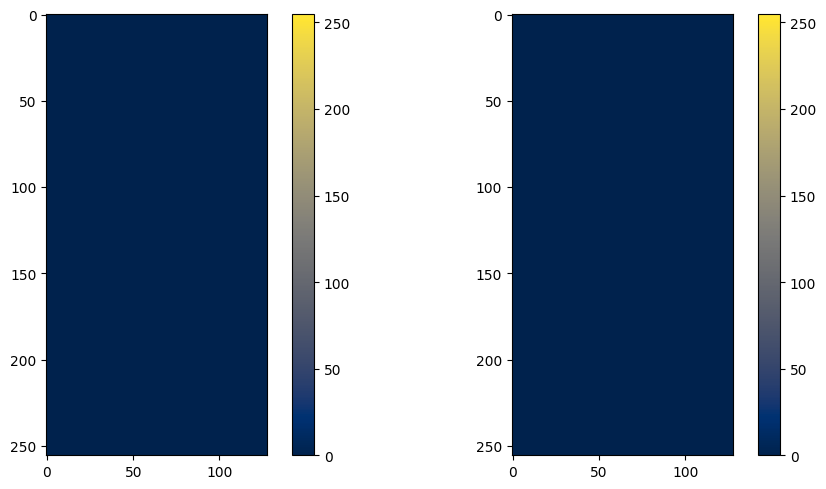

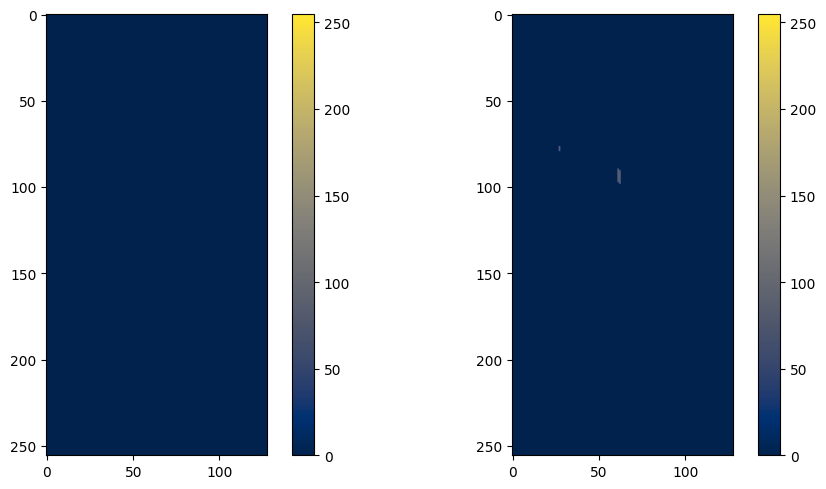

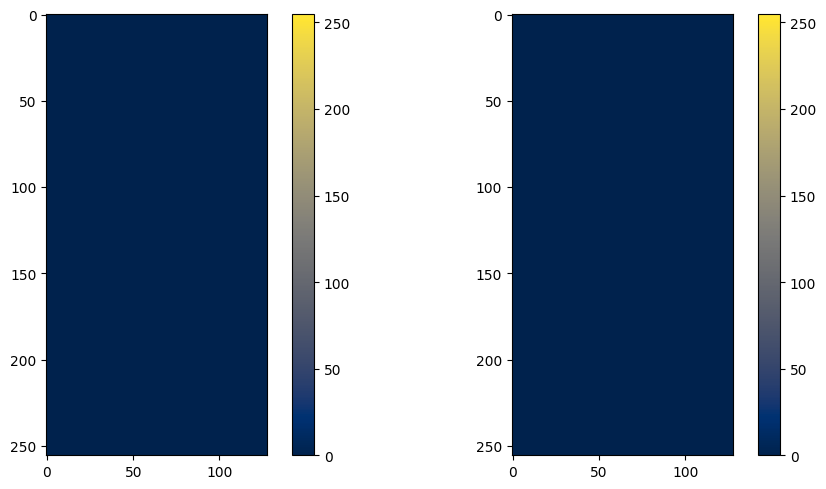

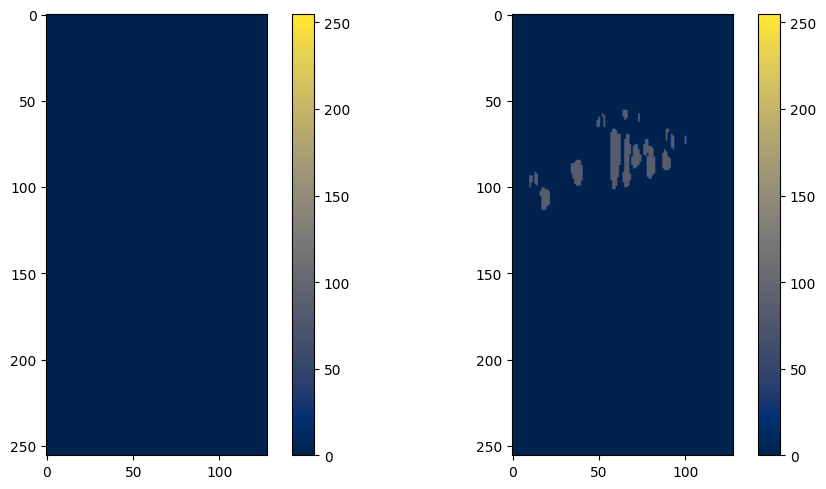

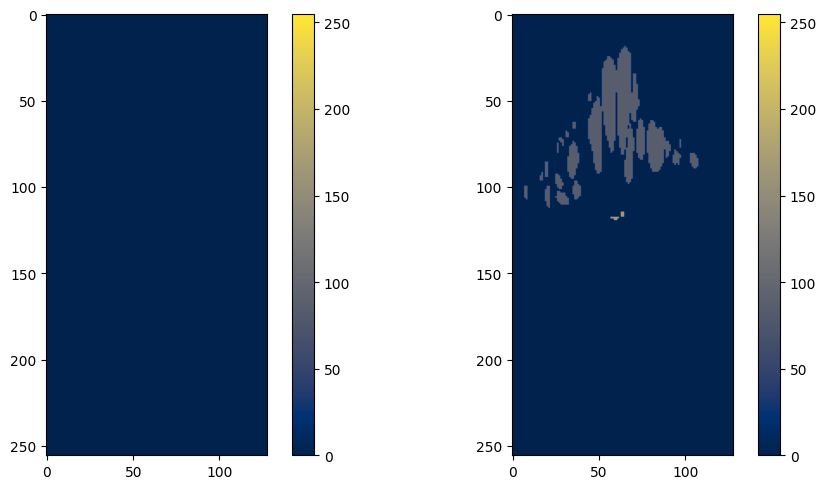

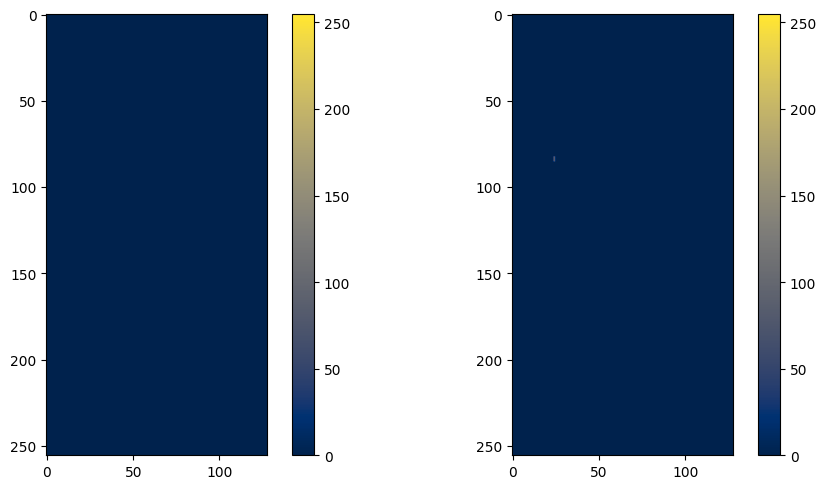

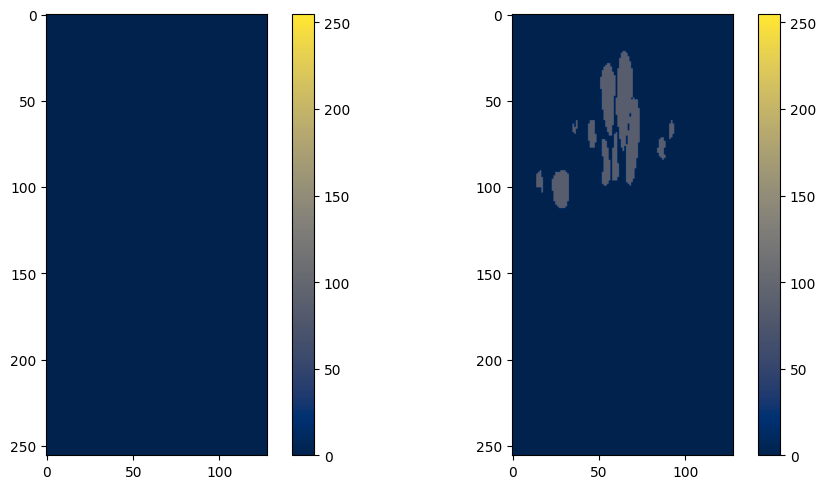

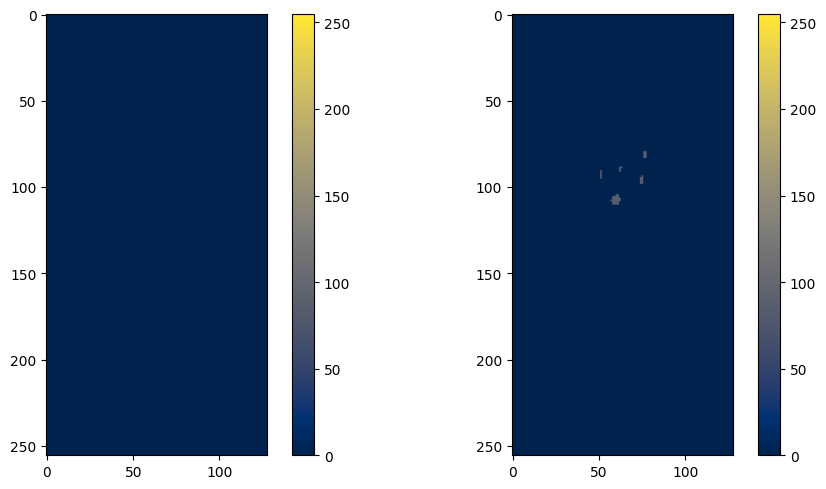

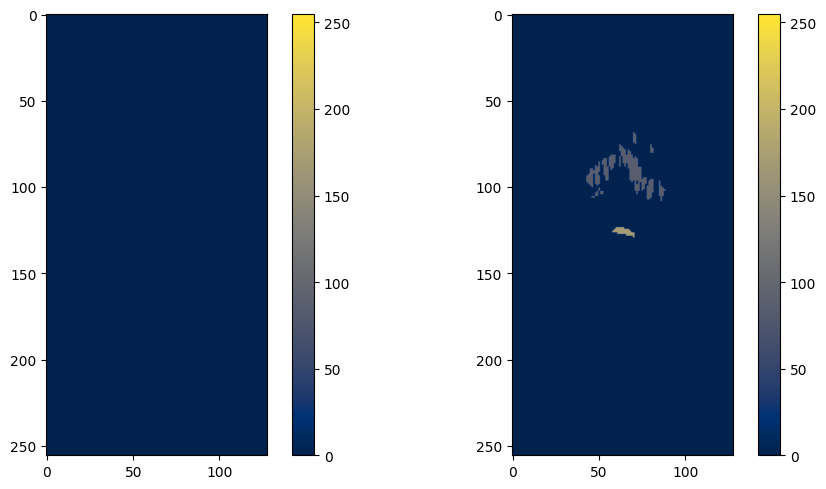

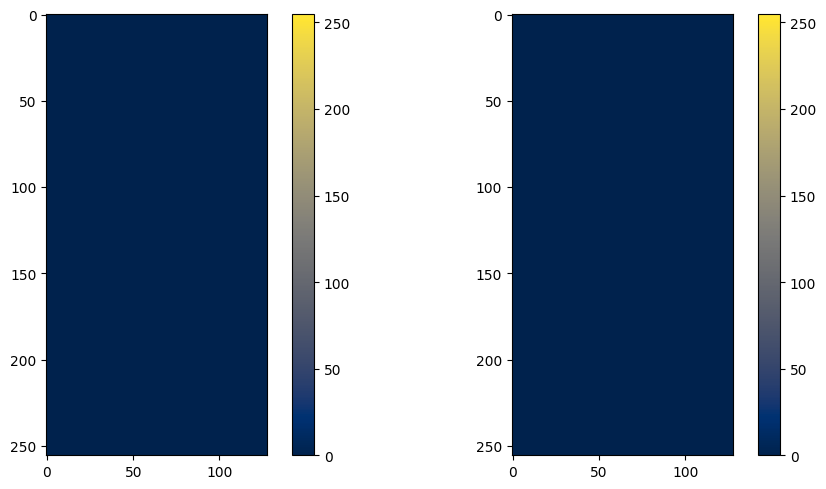

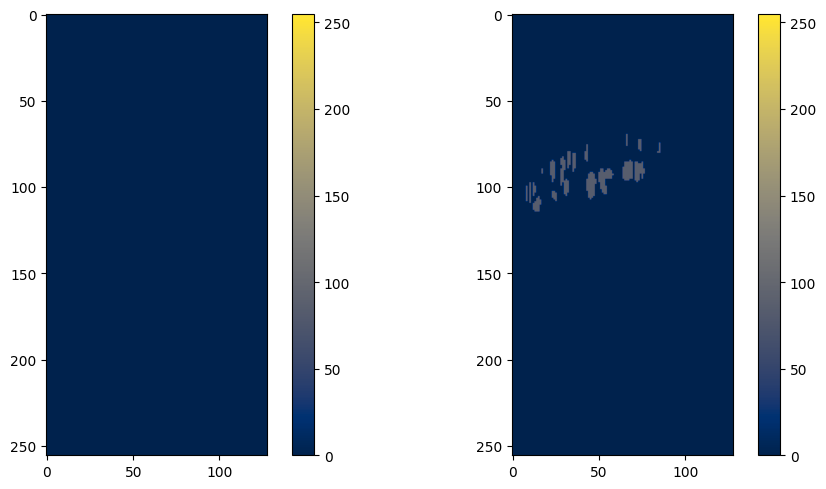

256 ./Images/OCT/03_000.tif
256 ./Images/Reference/03_000.tif
257 ./Images/OCT/03_001.tif
257 ./Images/Reference/03_001.tif
258 ./Images/OCT/03_002.tif
258 ./Images/Reference/03_002.tif
259 ./Images/OCT/03_003.tif
259 ./Images/Reference/03_003.tif
260 ./Images/OCT/03_004.tif
260 ./Images/Reference/03_004.tif
261 ./Images/OCT/03_005.tif
261 ./Images/Reference/03_005.tif
262 ./Images/OCT/03_006.tif
262 ./Images/Reference/03_006.tif
263 ./Images/OCT/03_007.tif
263 ./Images/Reference/03_007.tif
264 ./Images/OCT/03_008.tif
264 ./Images/Reference/03_008.tif
265 ./Images/OCT/03_009.tif
265 ./Images/Reference/03_009.tif
266 ./Images/OCT/03_010.tif
266 ./Images/Reference/03_010.tif
267 ./Images/OCT/03_011.tif
267 ./Images/Reference/03_011.tif
268 ./Images/OCT/03_012.tif
268 ./Images/Reference/03_012.tif
269 ./Images/OCT/03_013.tif
269 ./Images/Reference/03_013.tif
270 ./Images/OCT/03_014.tif
270 ./Images/Reference/03_014.tif
271 ./Images/OCT/03_015.tif
271 ./Images/Reference/03_015.tif
272 ./Im

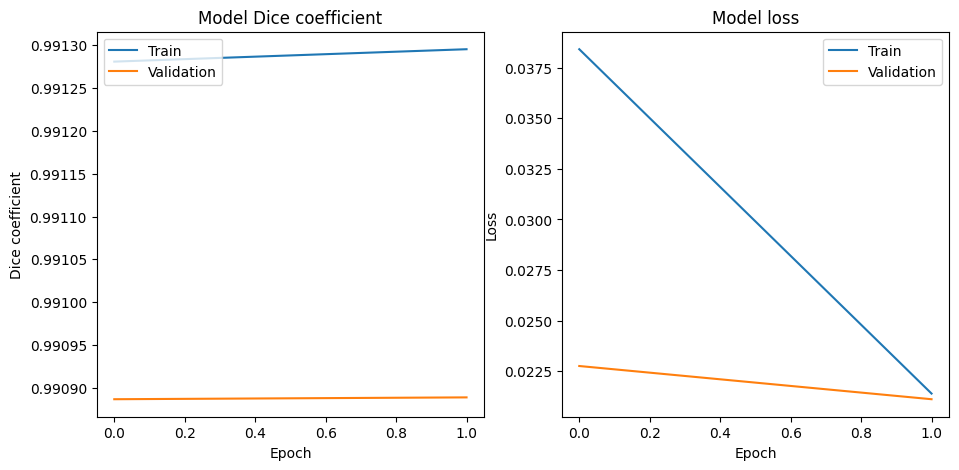

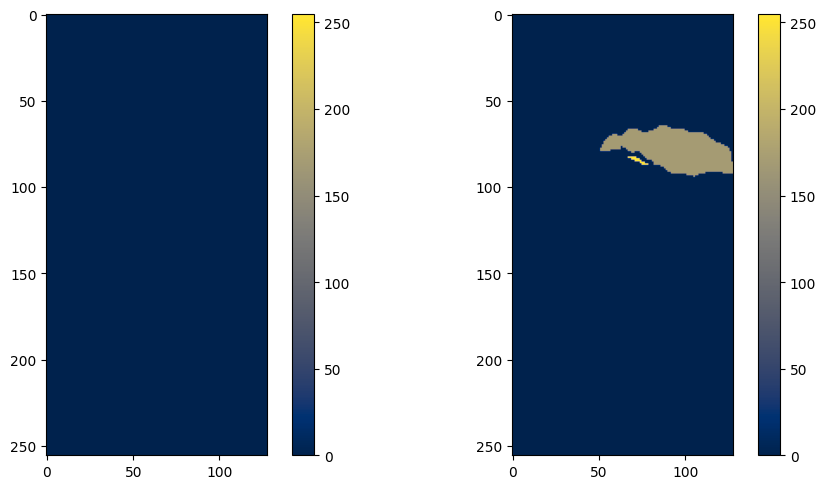

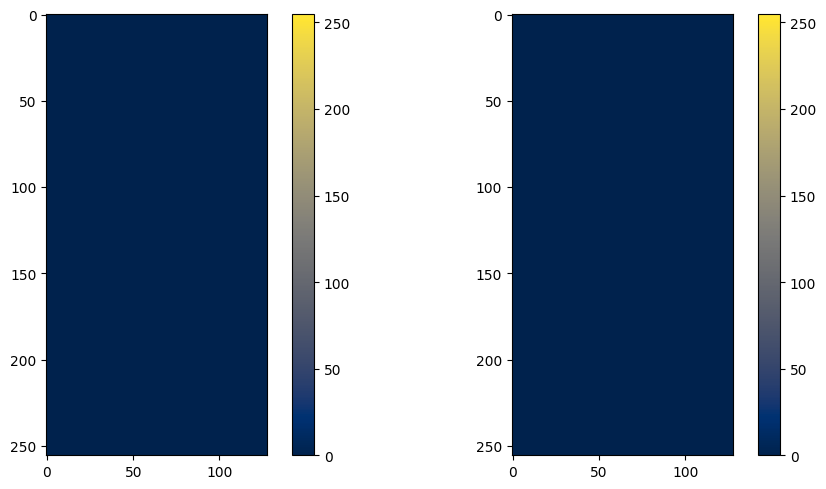

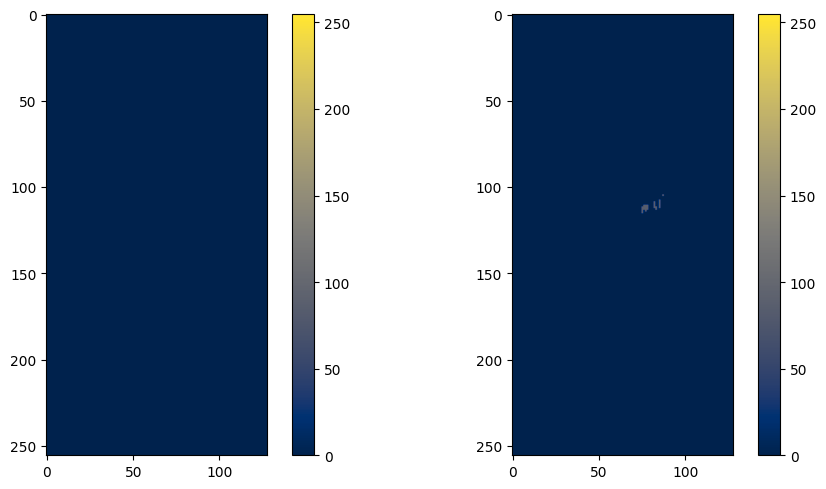

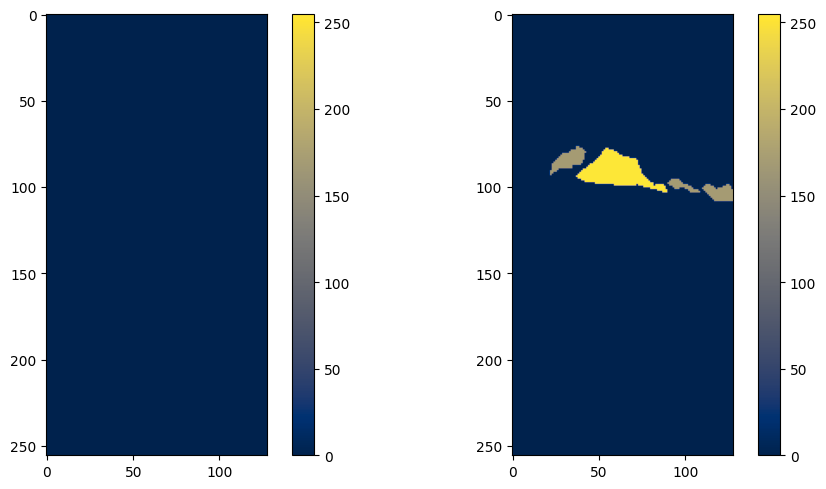

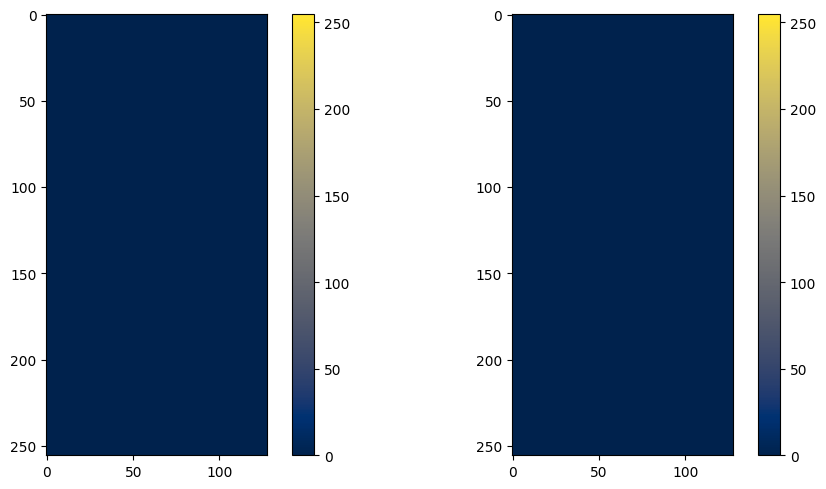

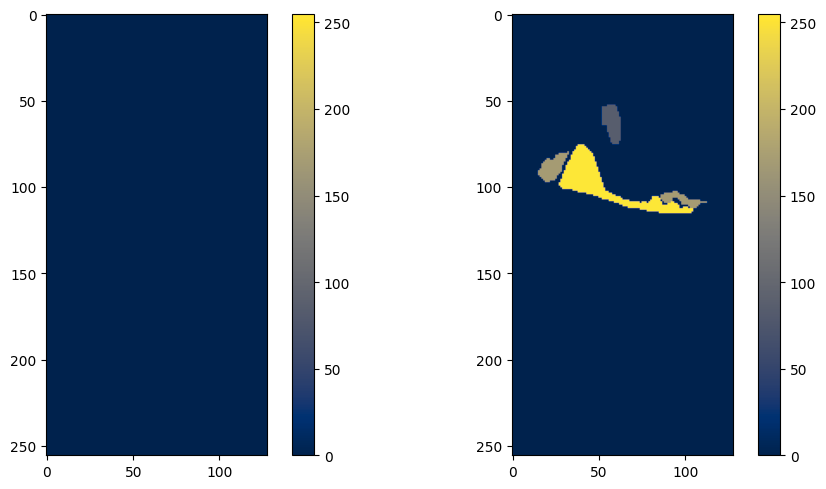

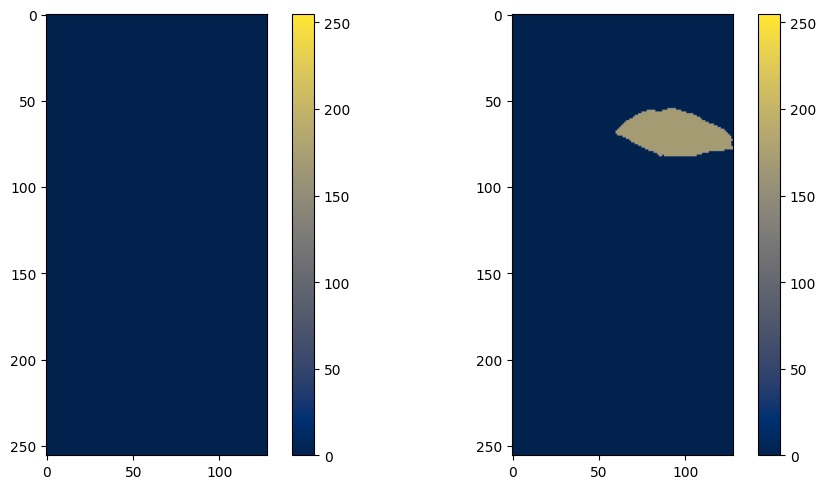

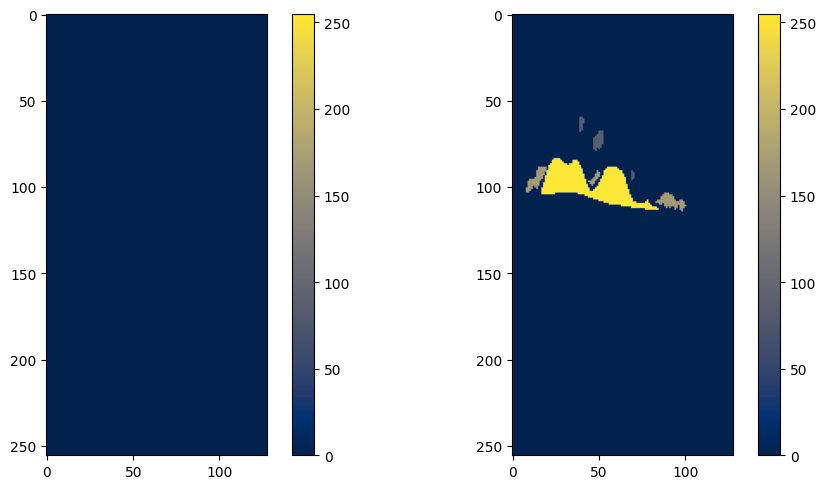

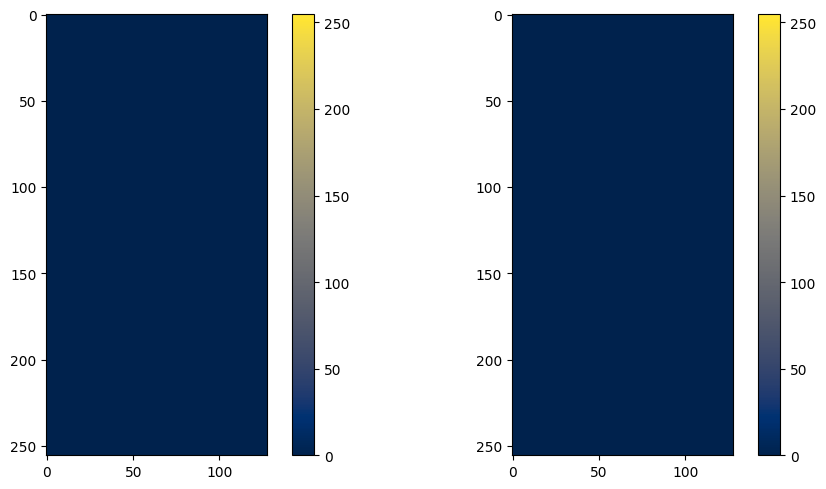

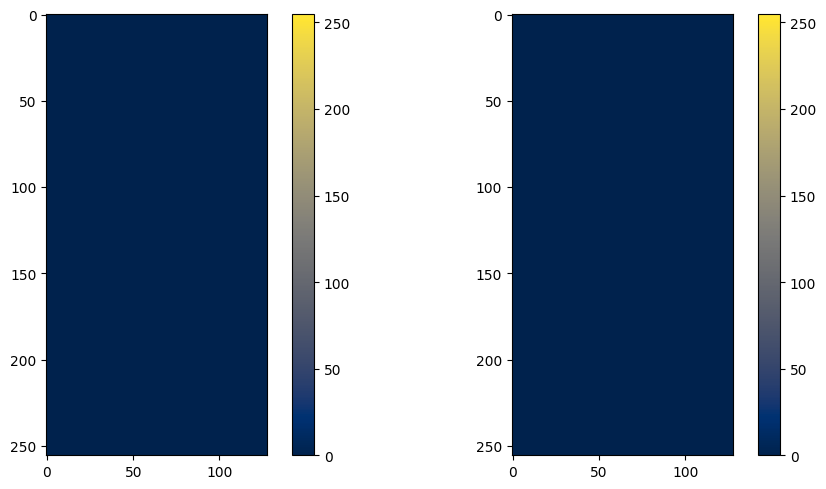

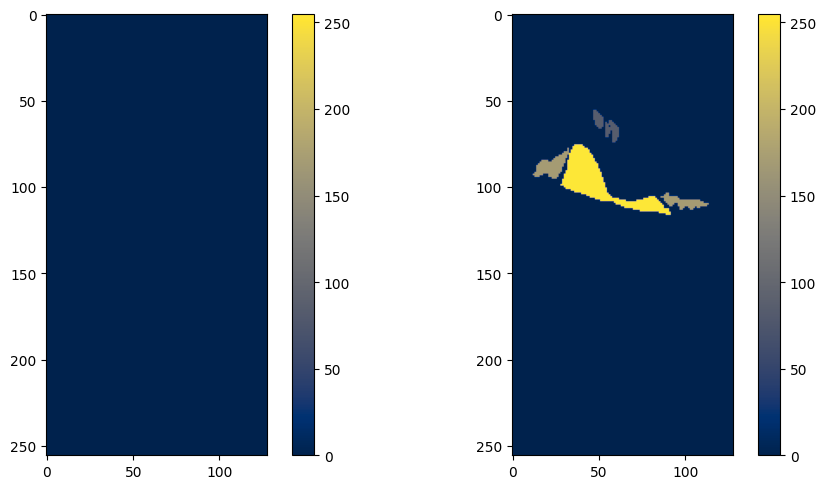

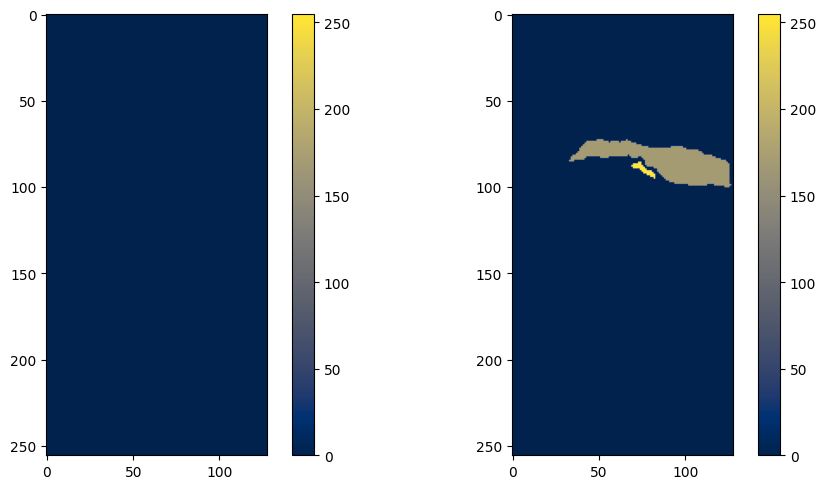

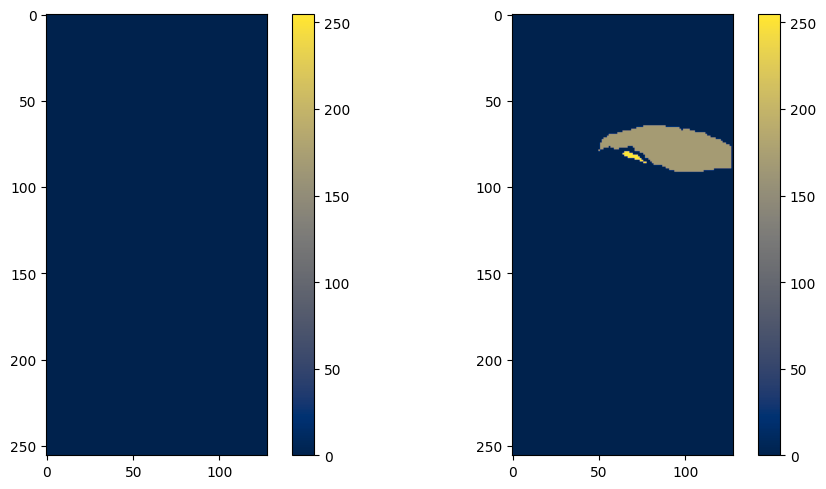

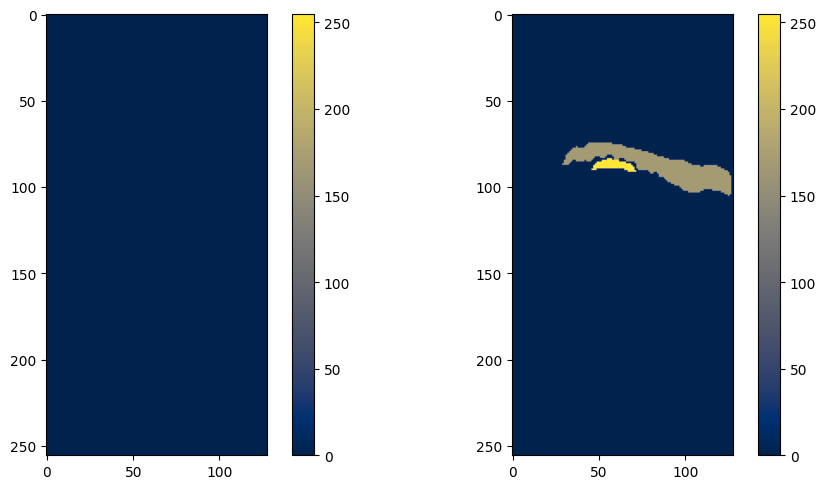

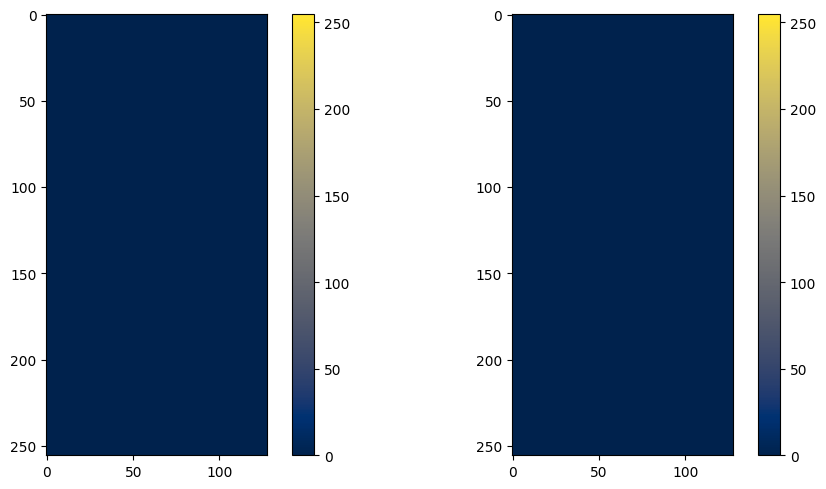

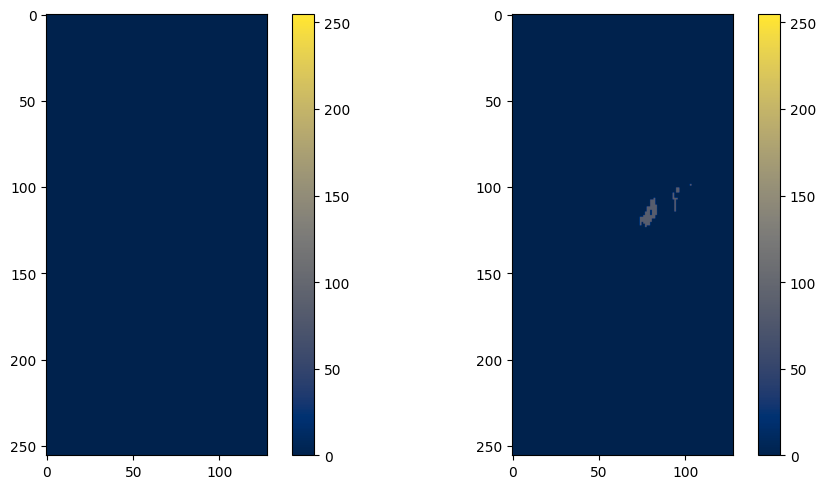

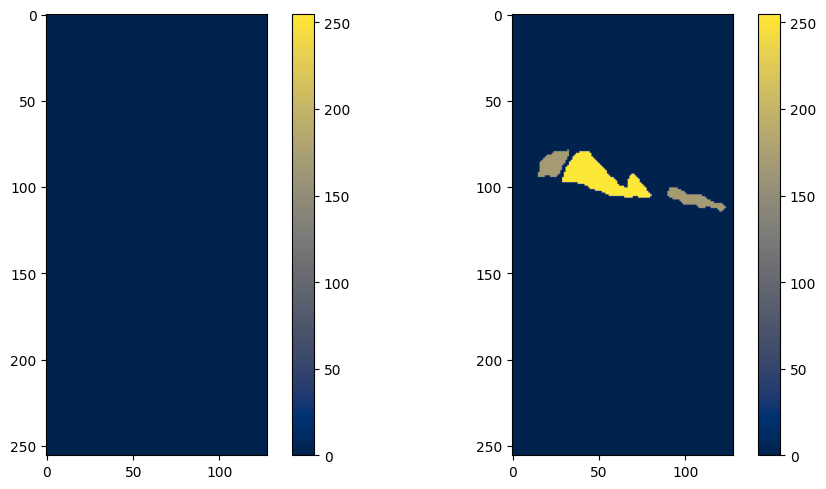

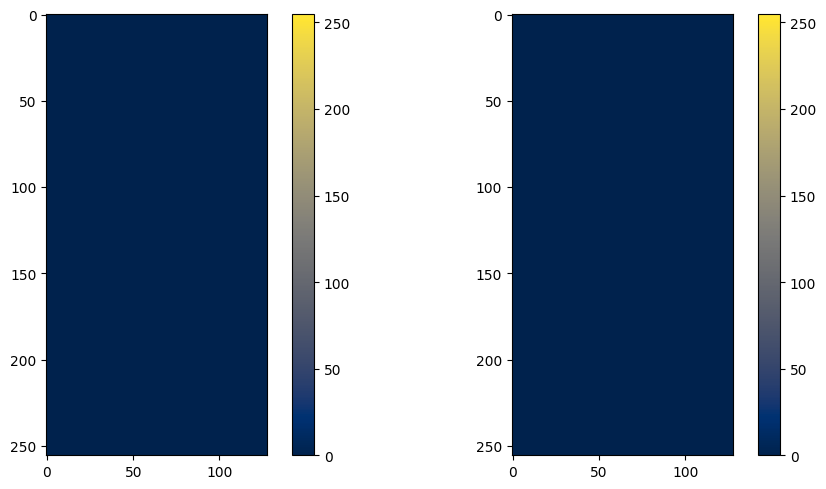

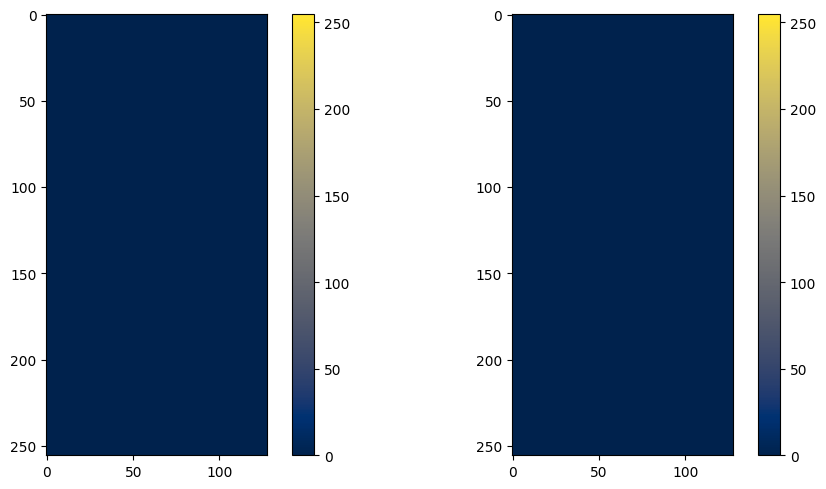

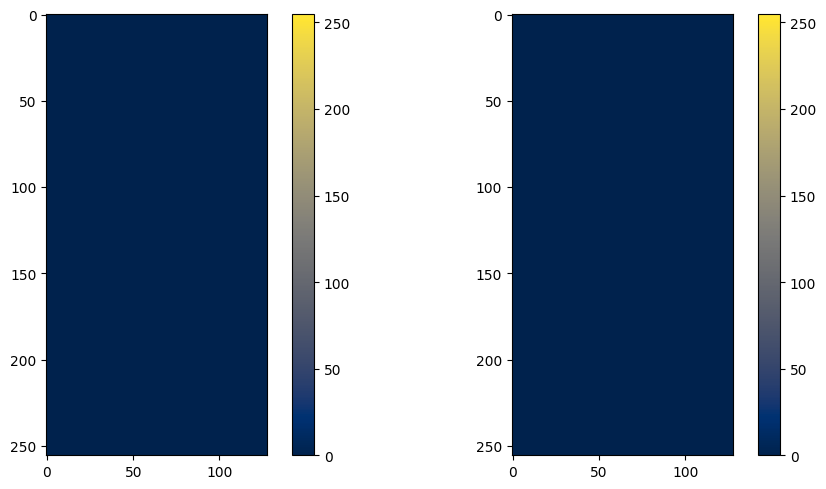

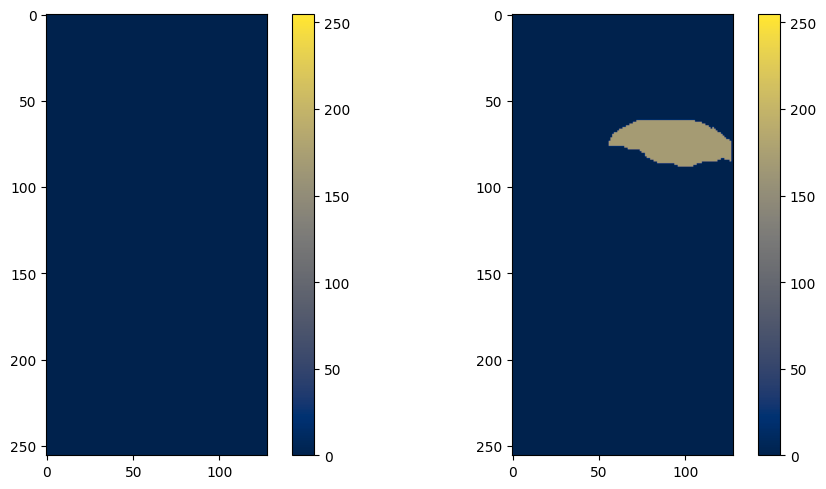

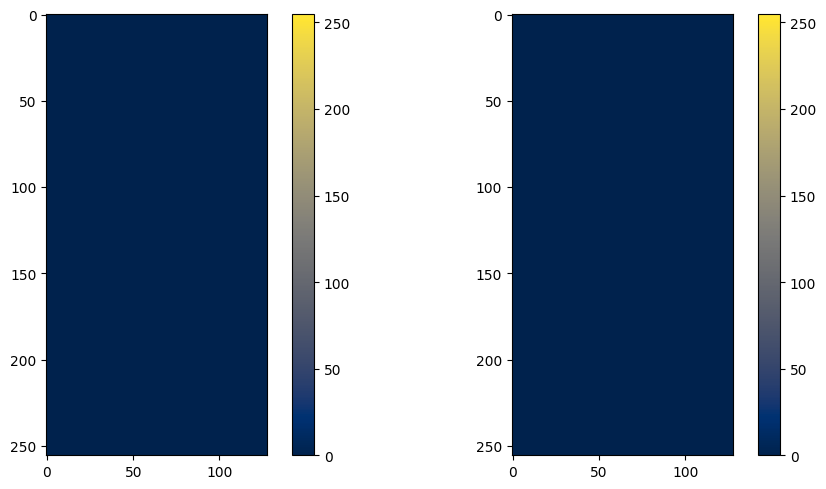

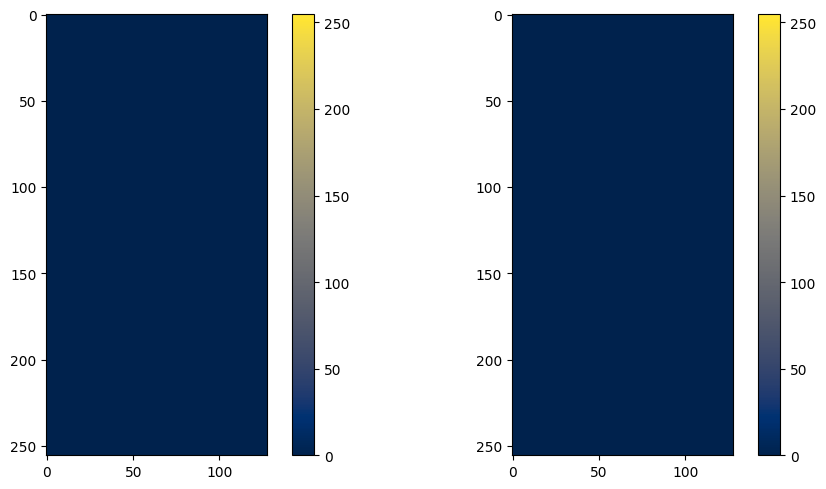

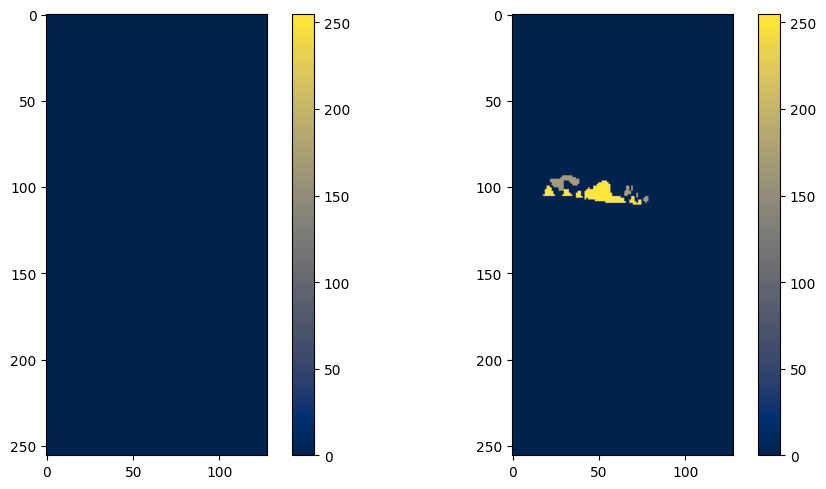

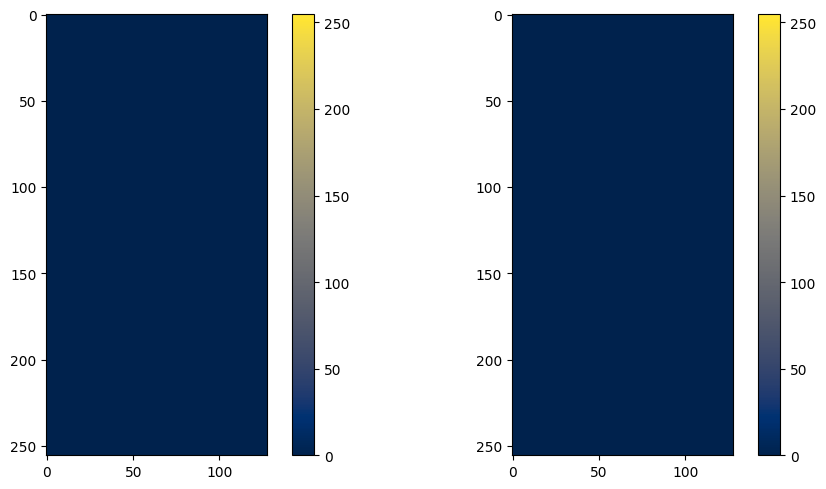

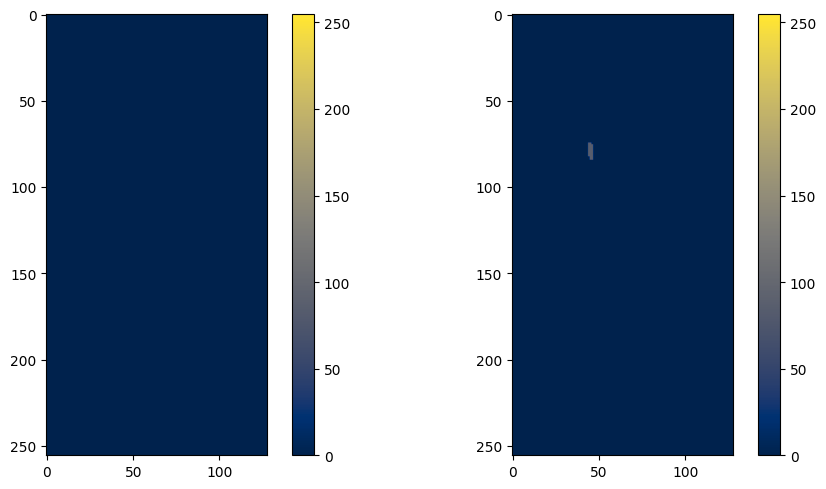

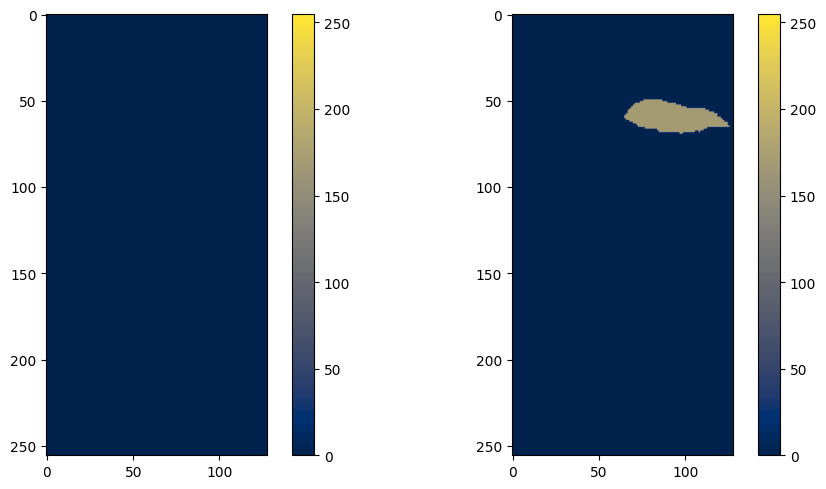

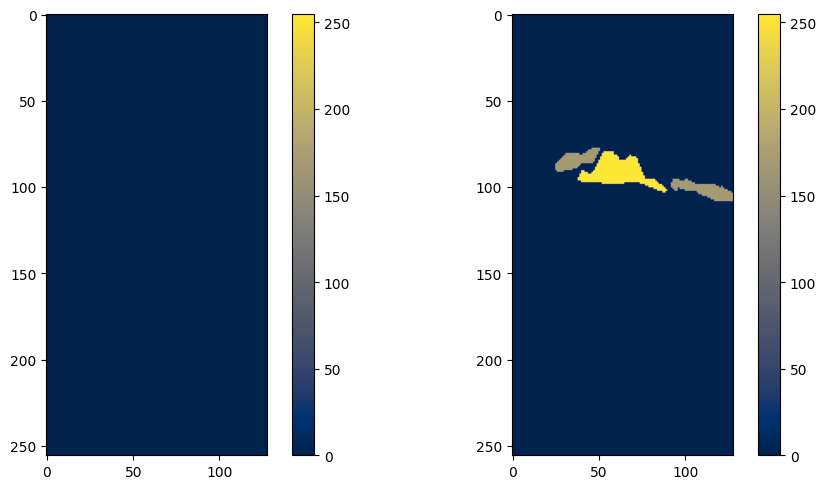

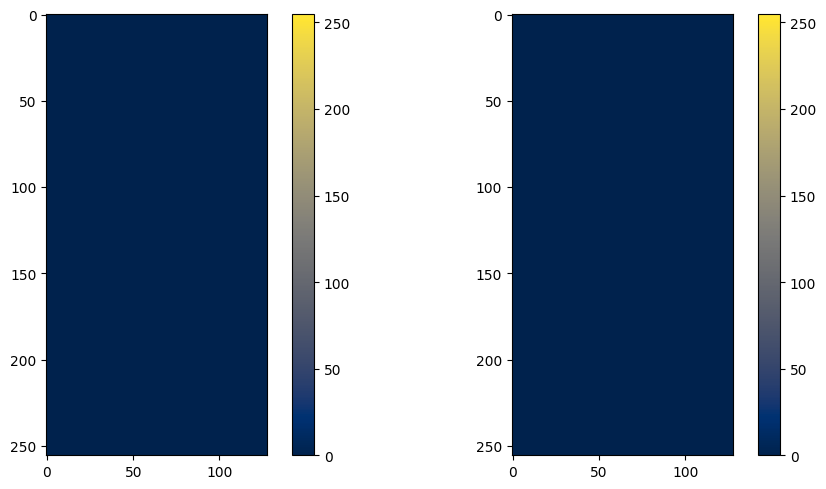

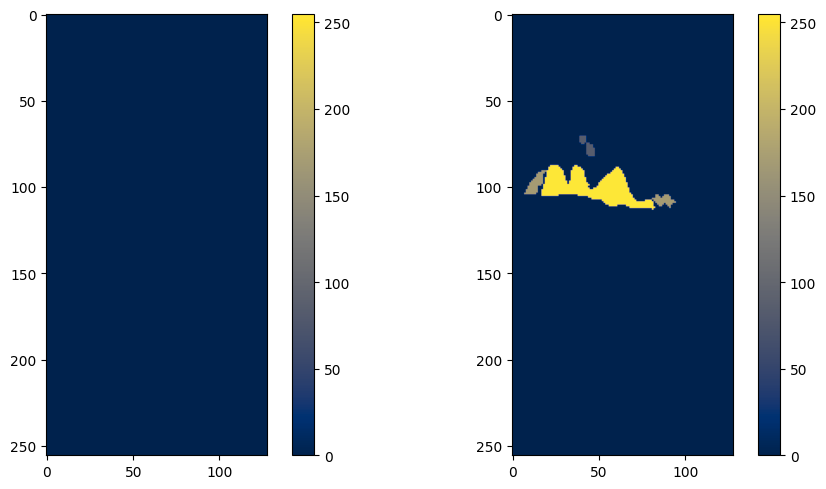

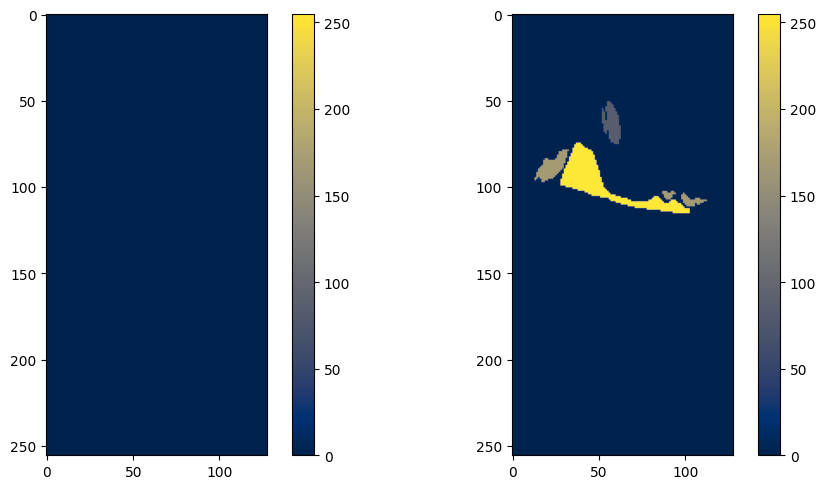

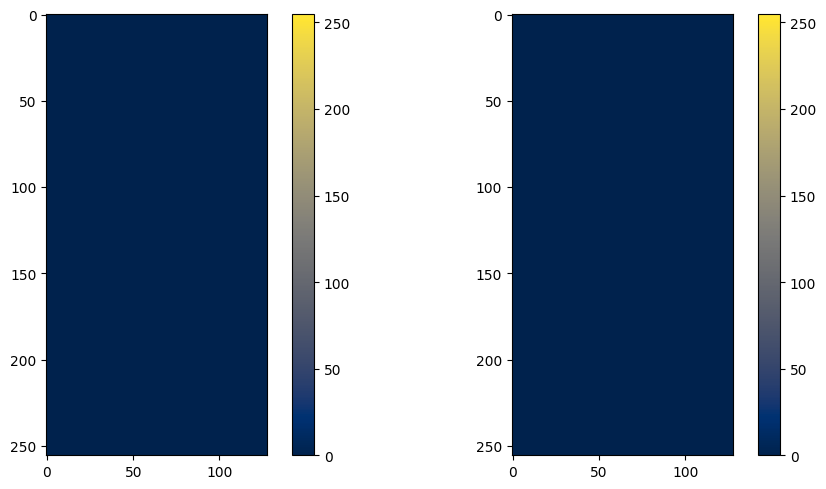

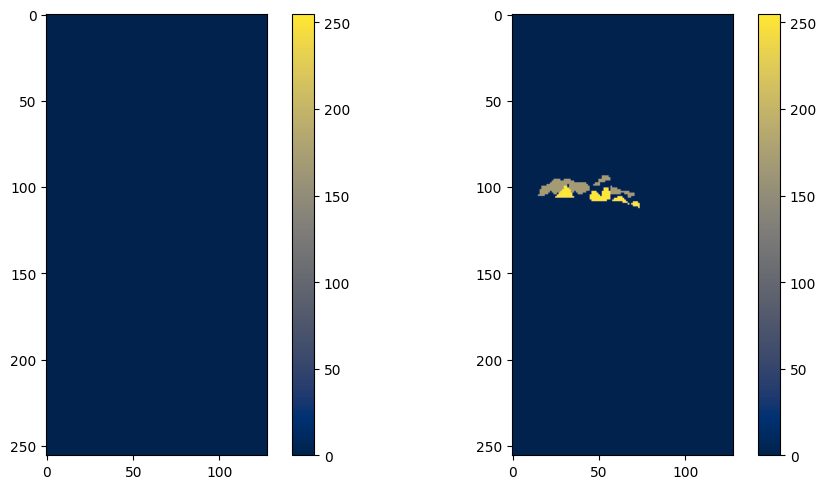

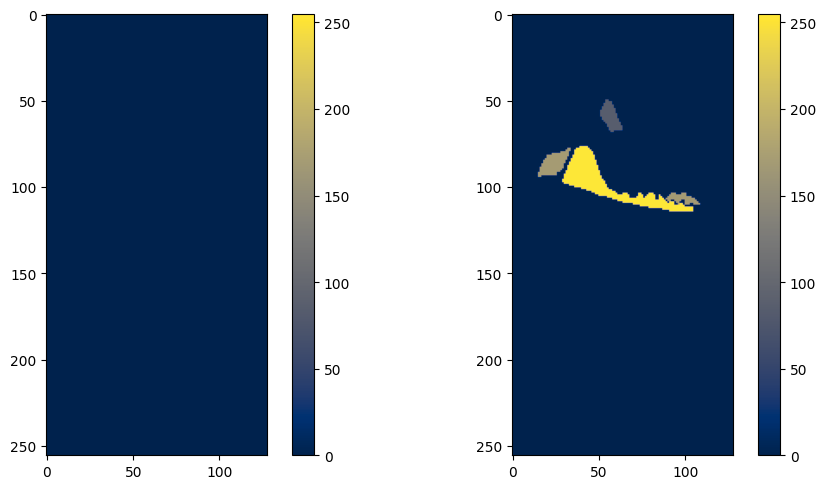

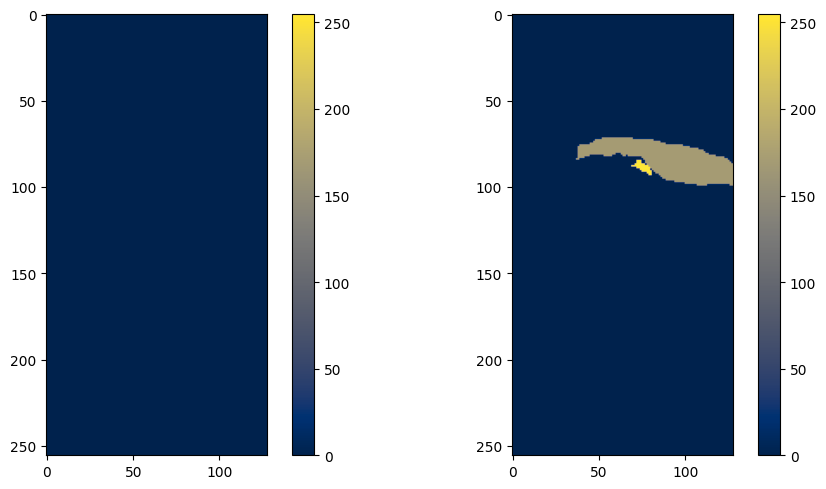

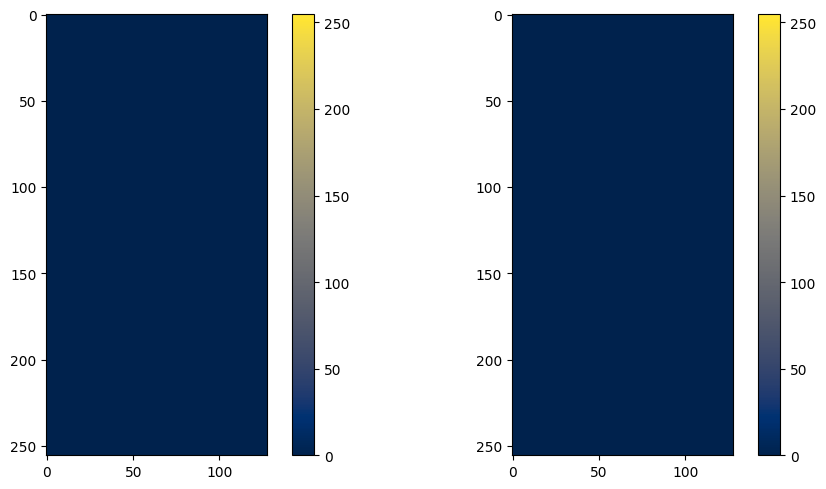

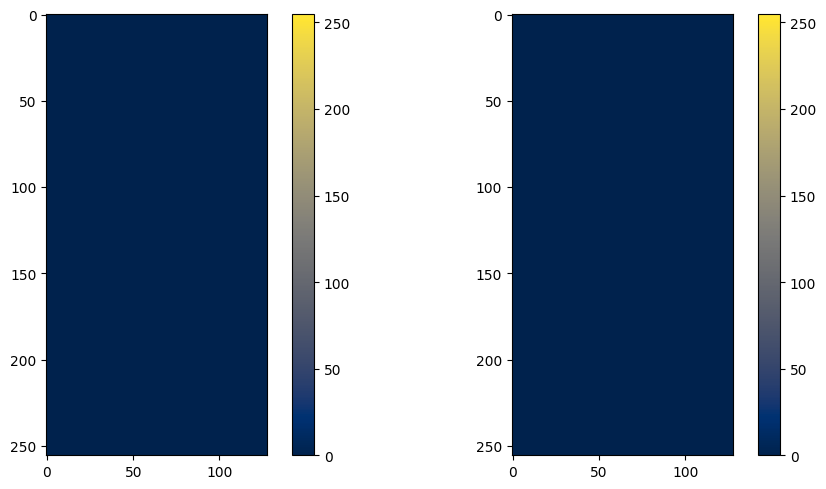

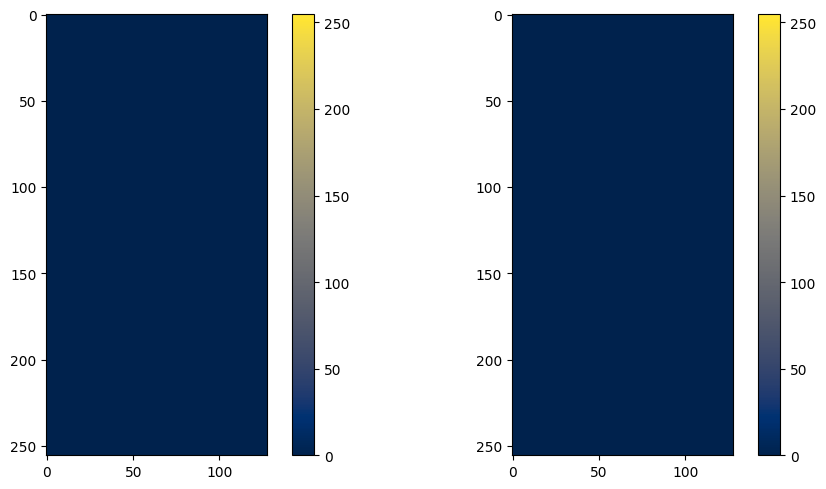

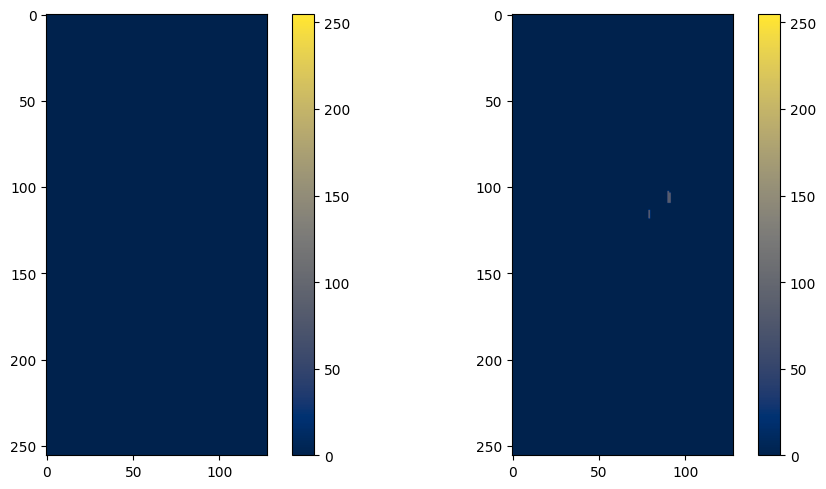

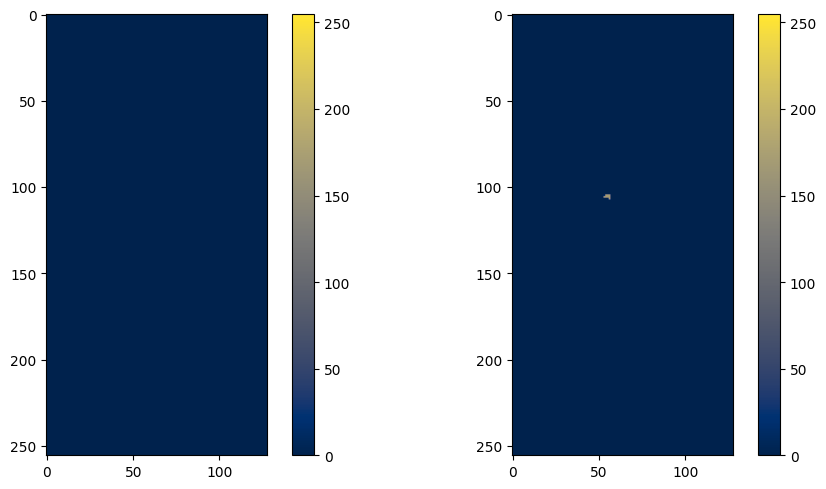

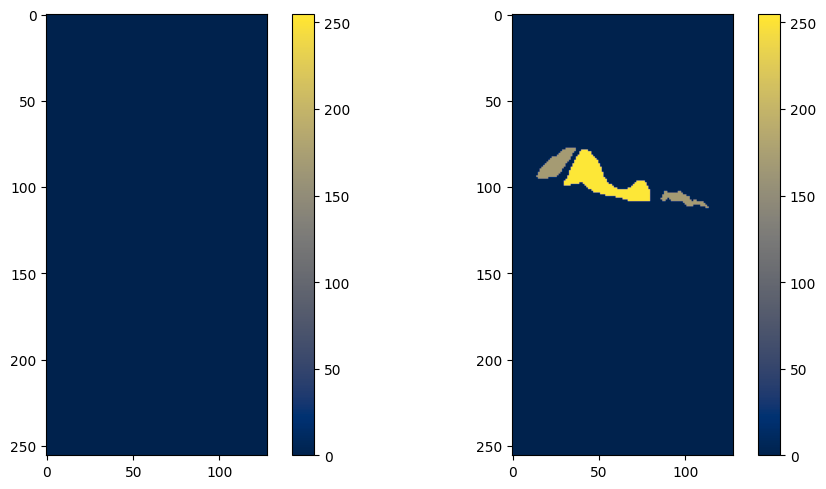

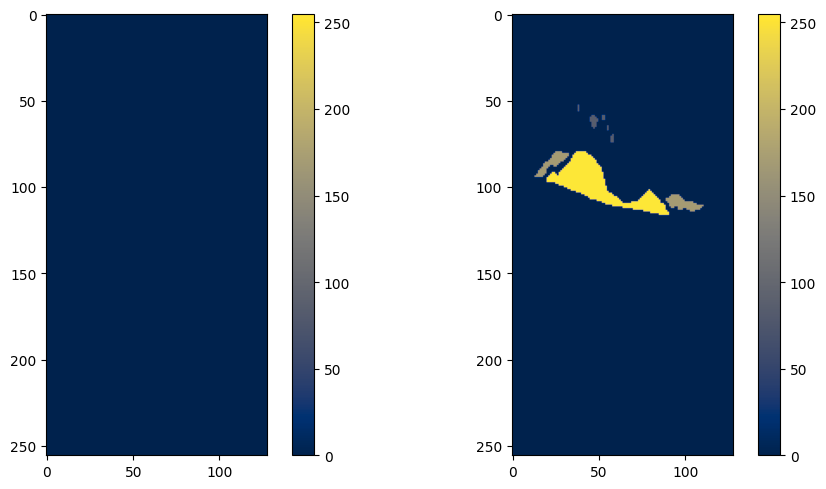

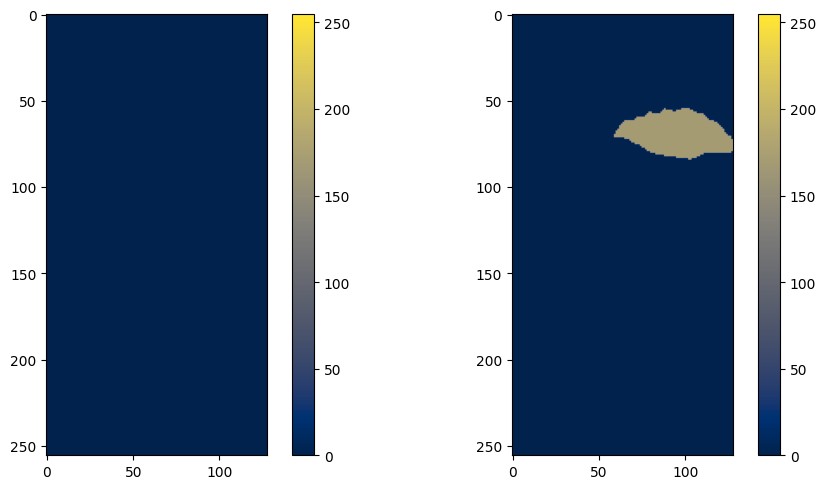

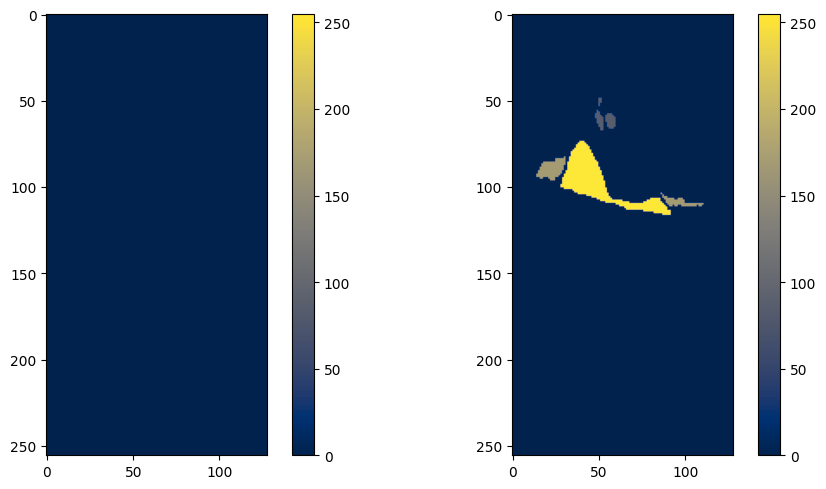

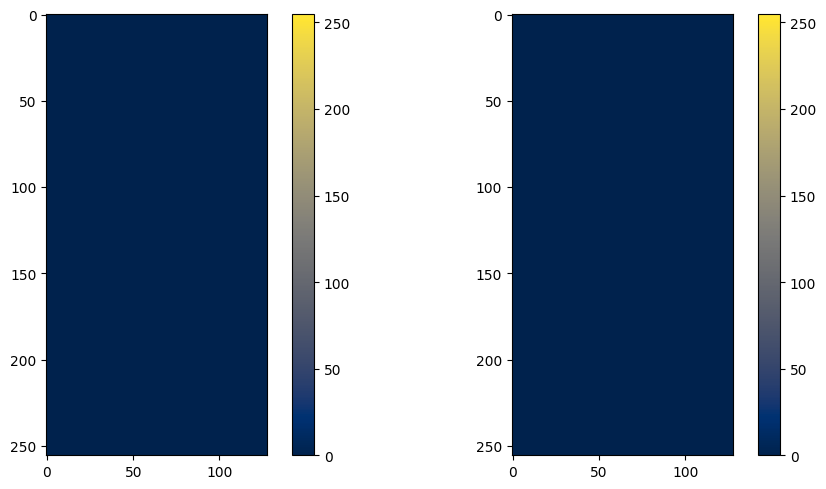

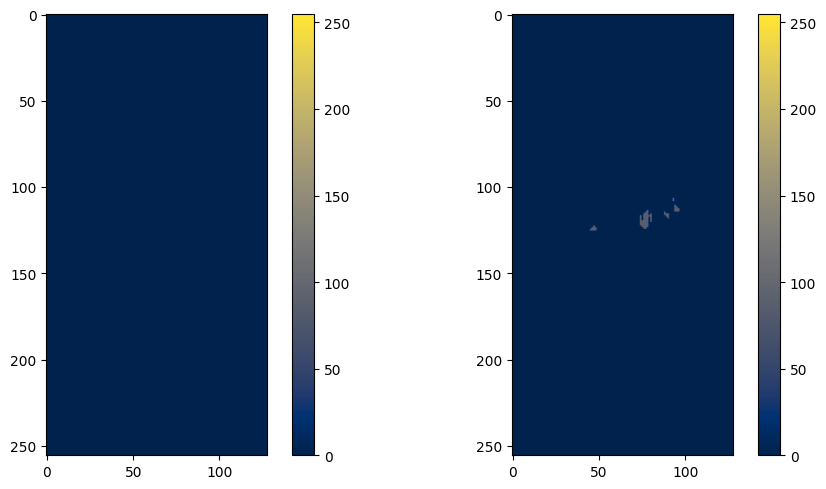

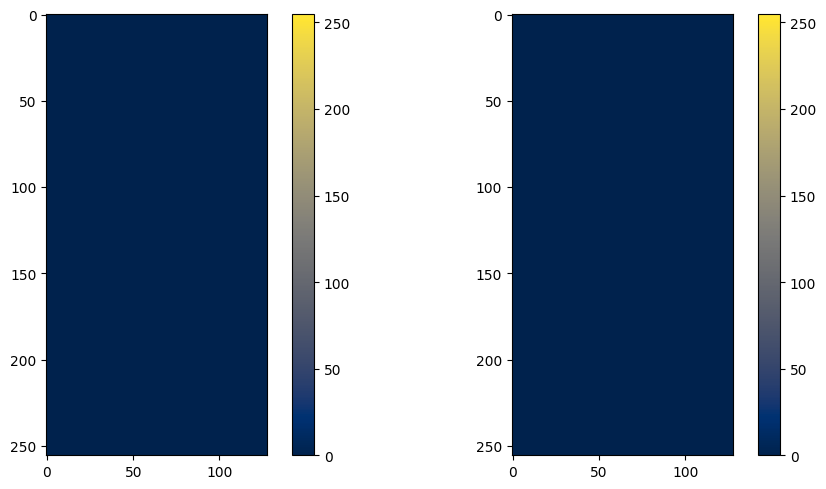

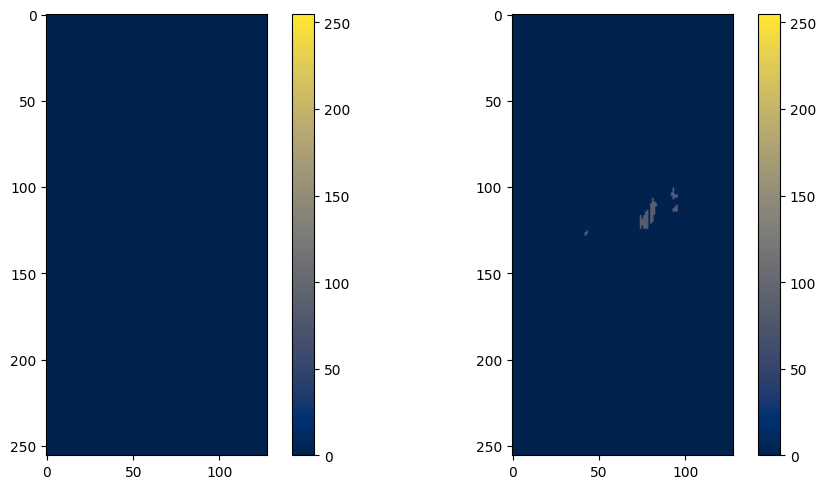

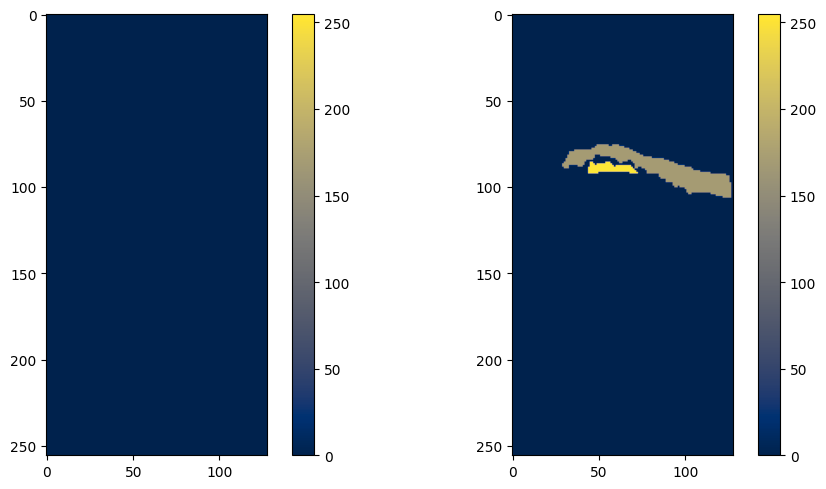

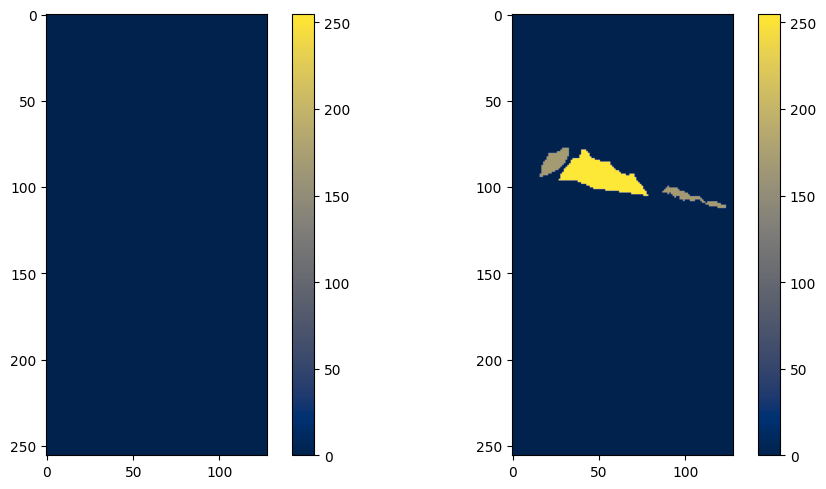

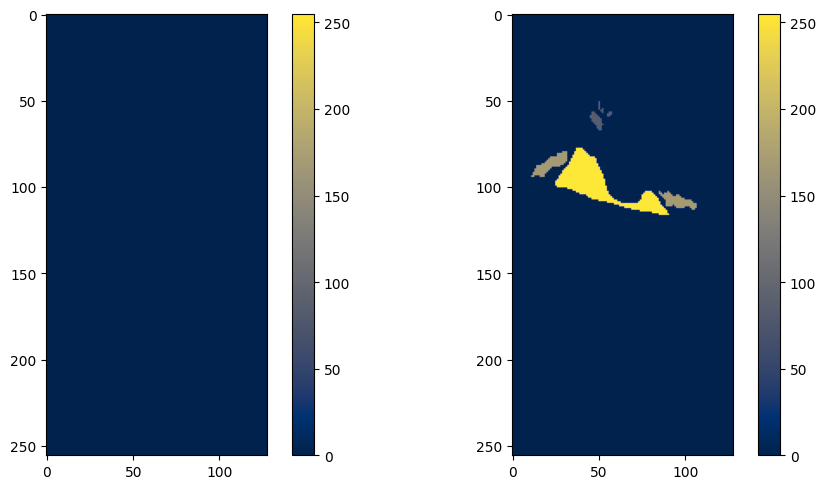

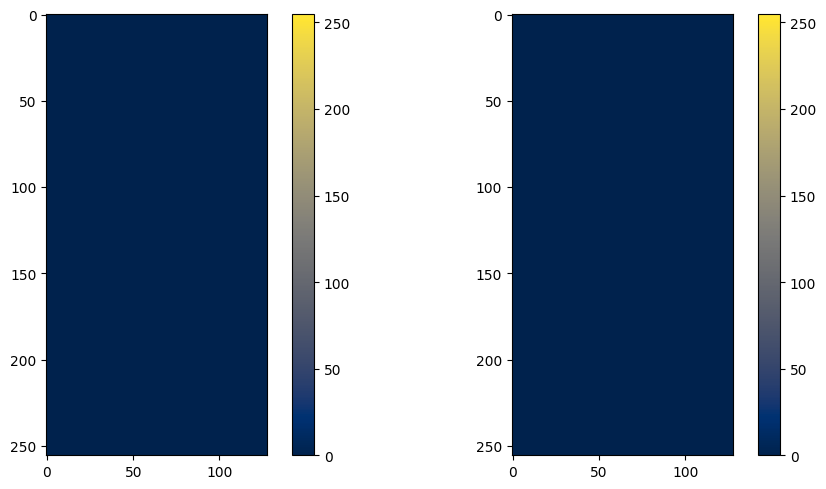

512 ./Images/OCT/05_000.tif
512 ./Images/Reference/05_000.tif
513 ./Images/OCT/05_001.tif
513 ./Images/Reference/05_001.tif
514 ./Images/OCT/05_002.tif
514 ./Images/Reference/05_002.tif
515 ./Images/OCT/05_003.tif
515 ./Images/Reference/05_003.tif
516 ./Images/OCT/05_004.tif
516 ./Images/Reference/05_004.tif
517 ./Images/OCT/05_005.tif
517 ./Images/Reference/05_005.tif
518 ./Images/OCT/05_006.tif
518 ./Images/Reference/05_006.tif
519 ./Images/OCT/05_007.tif
519 ./Images/Reference/05_007.tif
520 ./Images/OCT/05_008.tif
520 ./Images/Reference/05_008.tif
521 ./Images/OCT/05_009.tif
521 ./Images/Reference/05_009.tif
522 ./Images/OCT/05_010.tif
522 ./Images/Reference/05_010.tif
523 ./Images/OCT/05_011.tif
523 ./Images/Reference/05_011.tif
524 ./Images/OCT/05_012.tif
524 ./Images/Reference/05_012.tif
525 ./Images/OCT/05_013.tif
525 ./Images/Reference/05_013.tif
526 ./Images/OCT/05_014.tif
526 ./Images/Reference/05_014.tif
527 ./Images/OCT/05_015.tif
527 ./Images/Reference/05_015.tif
528 ./Im

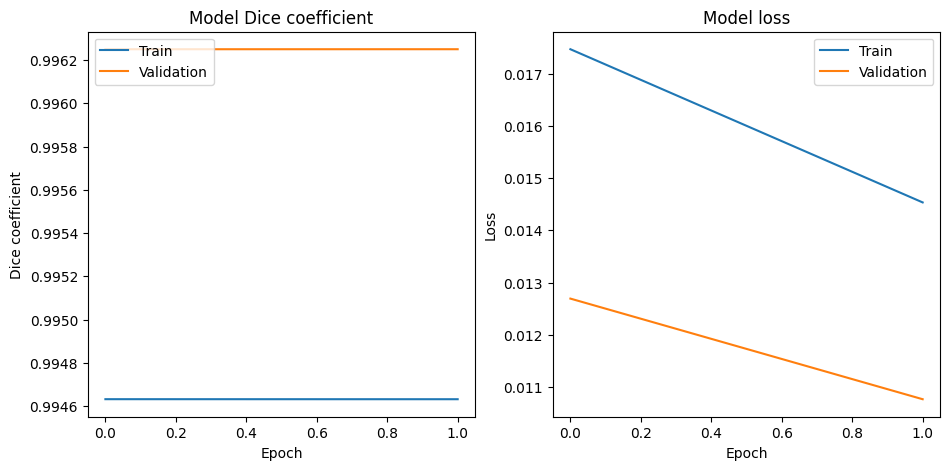

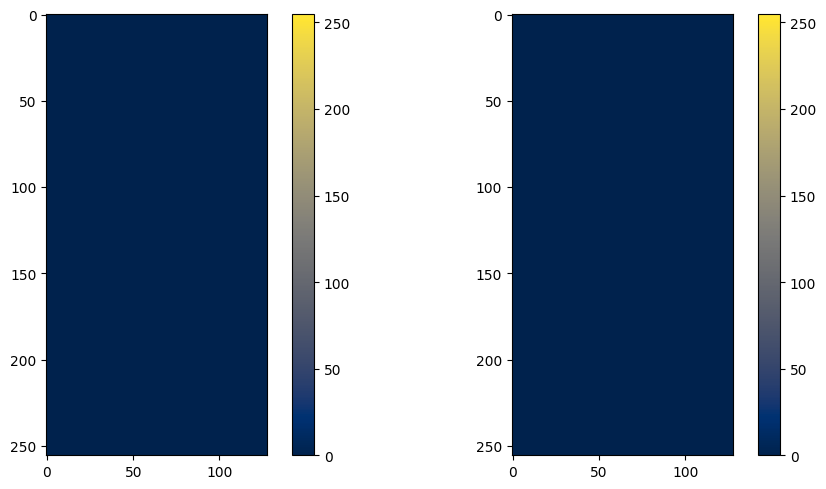

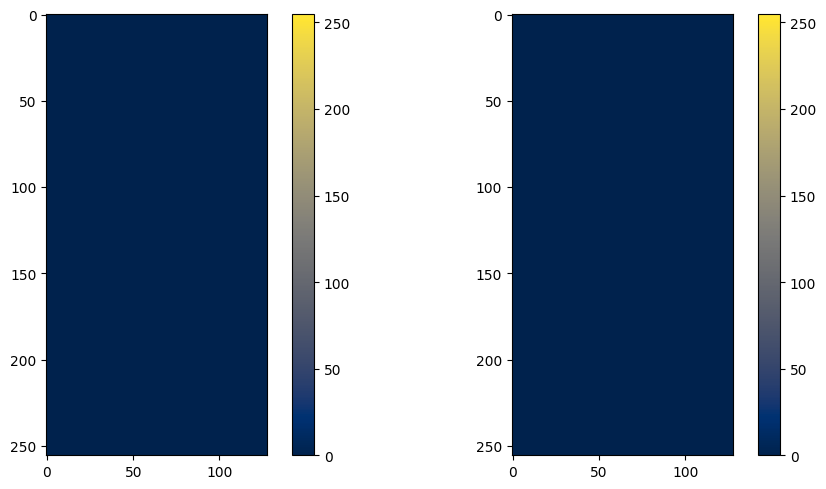

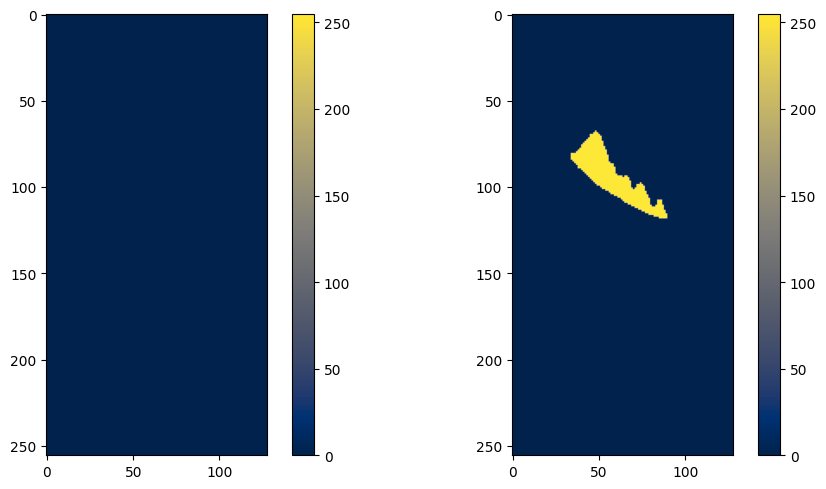

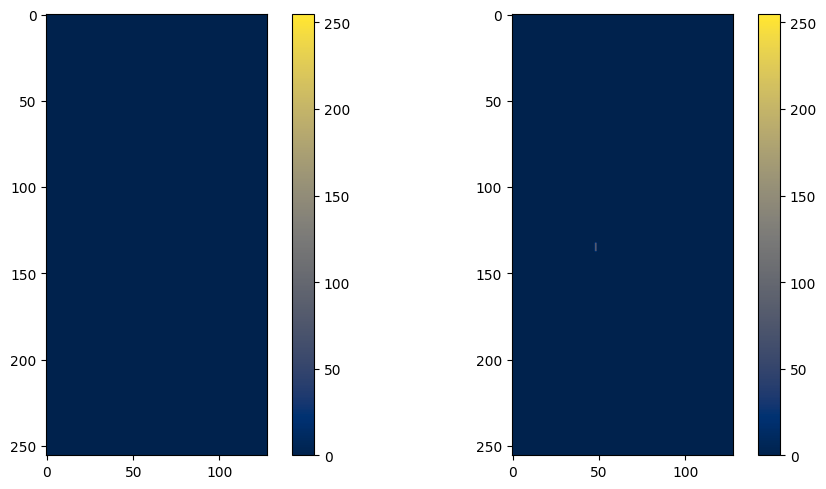

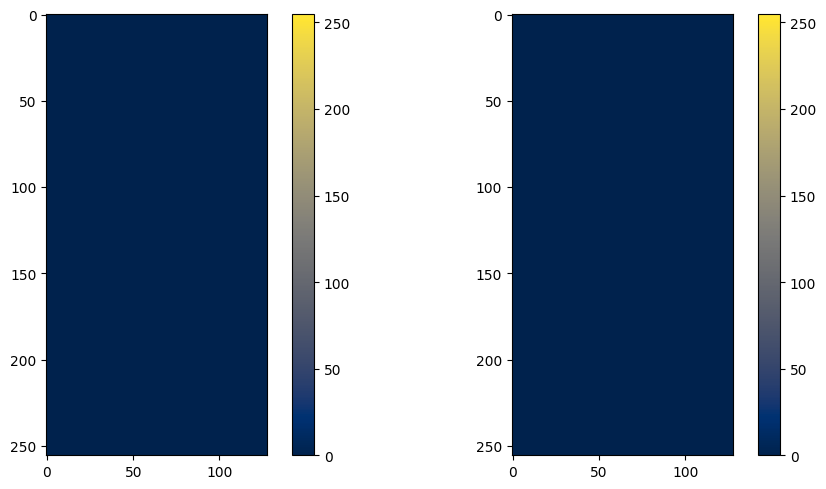

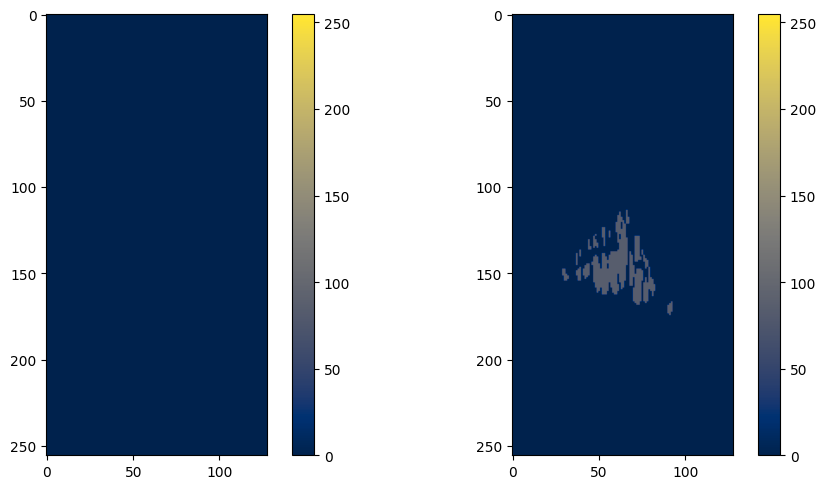

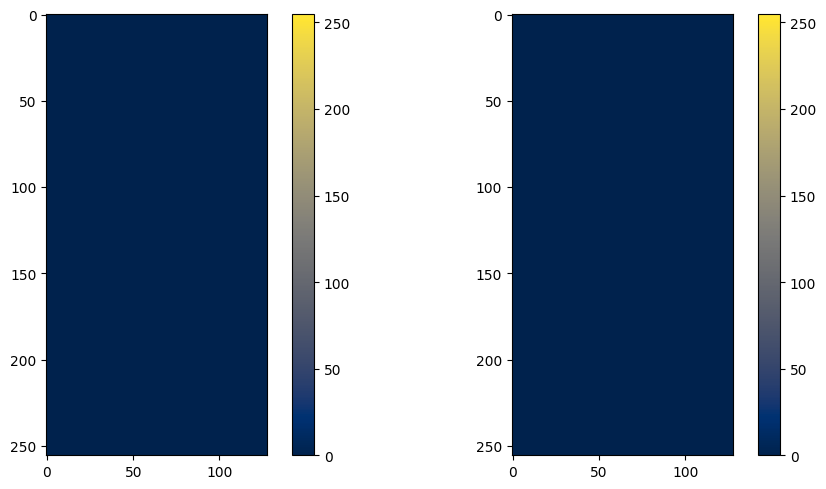

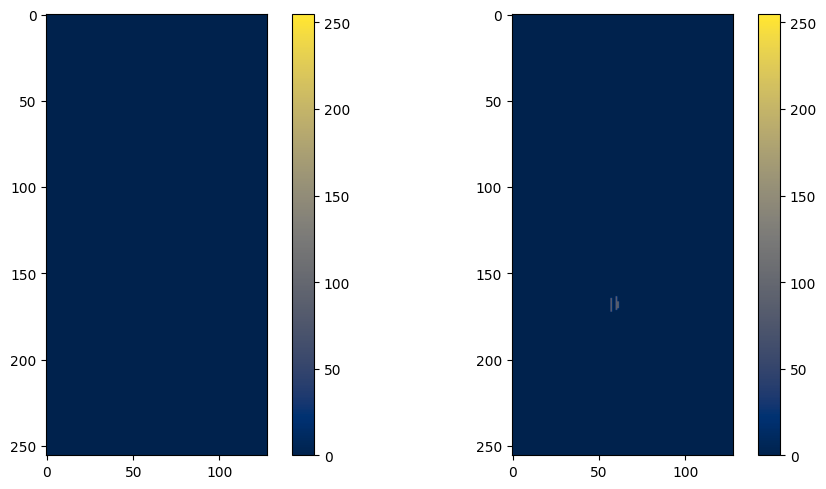

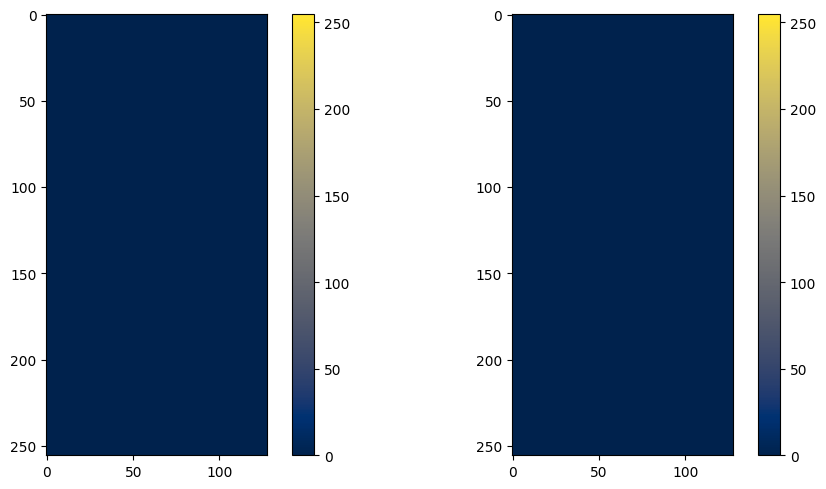

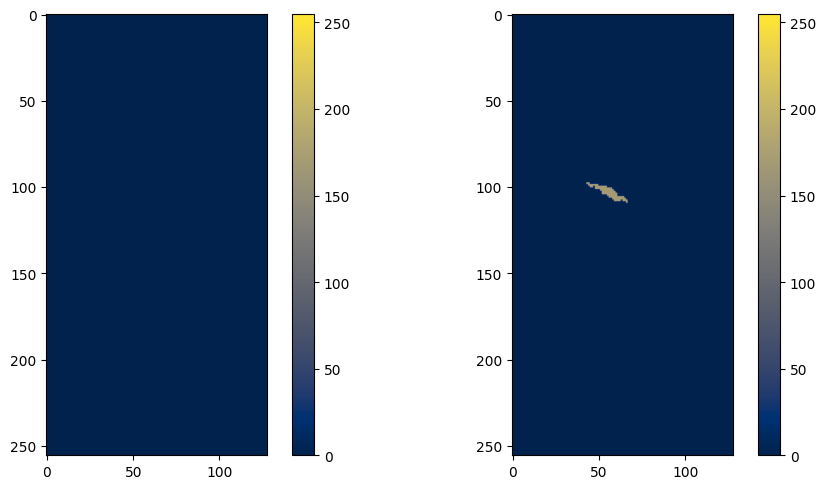

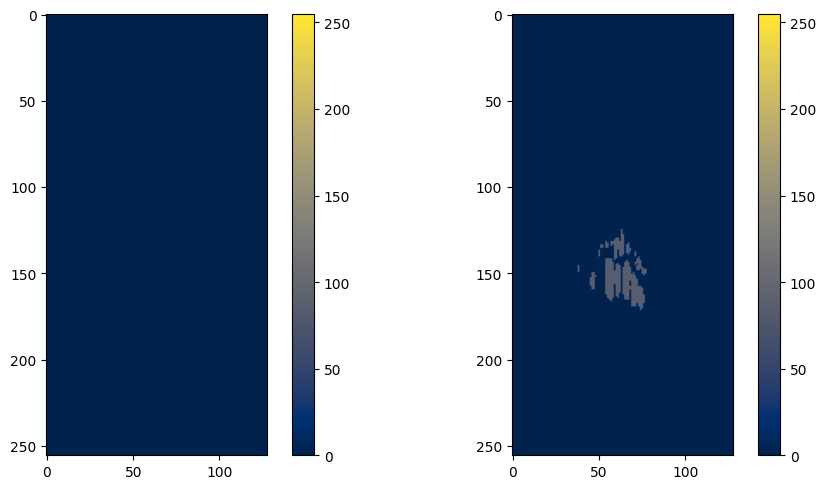

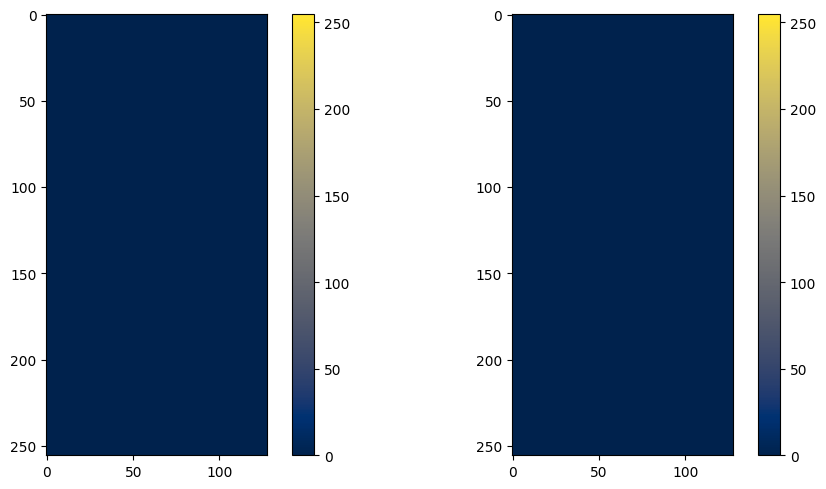

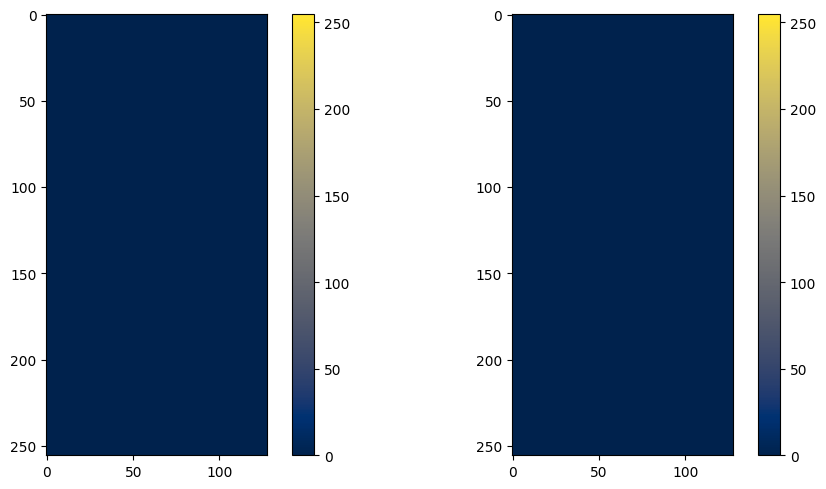

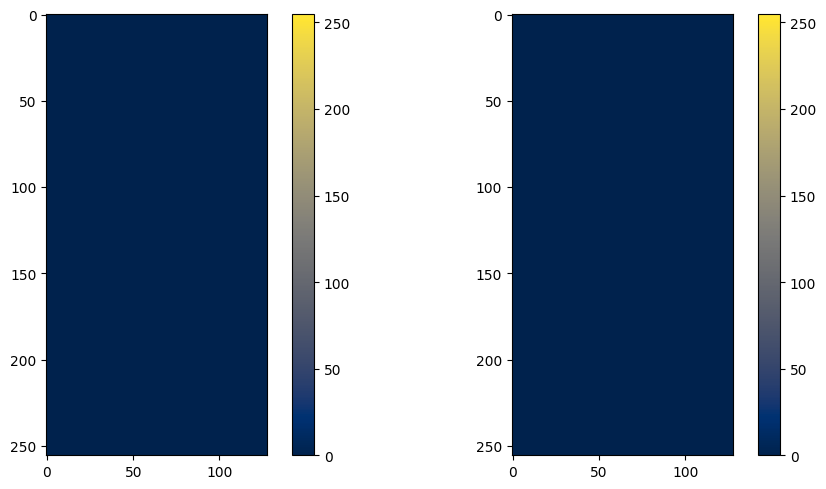

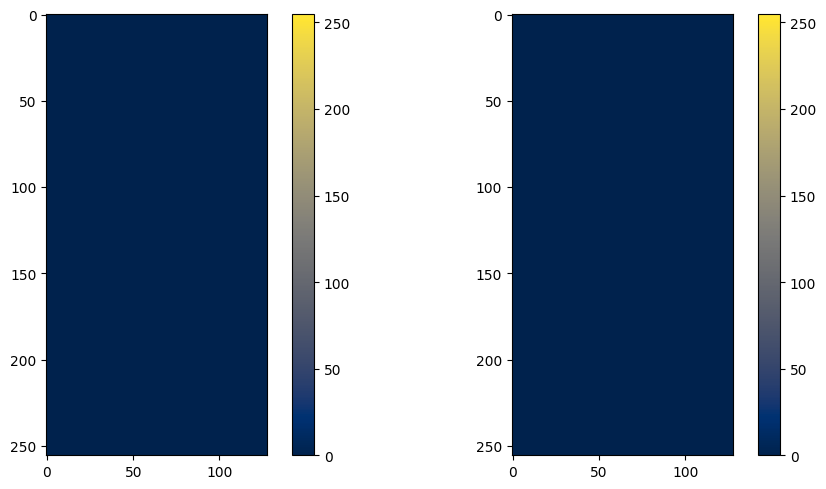

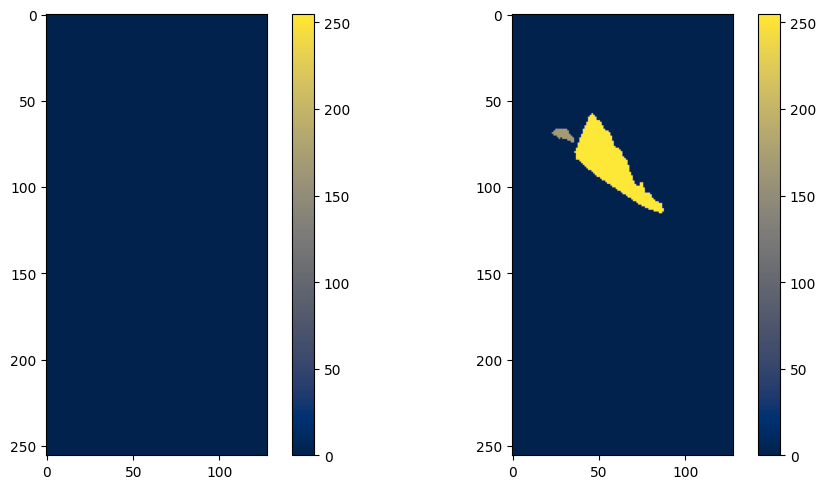

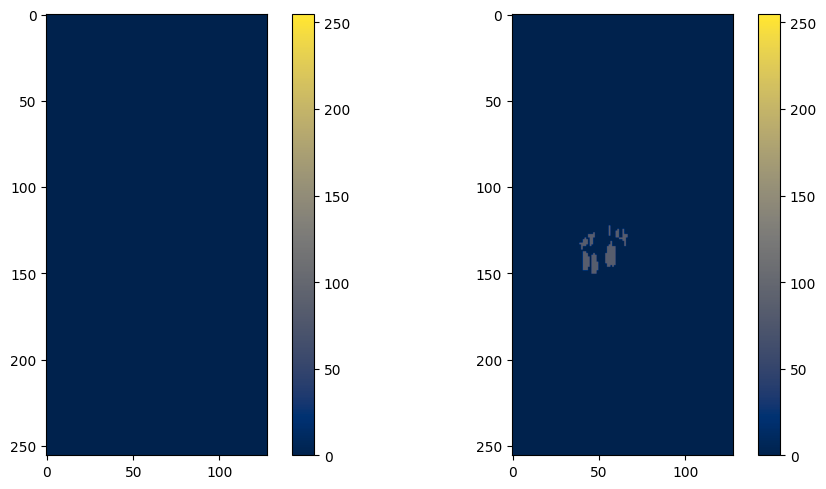

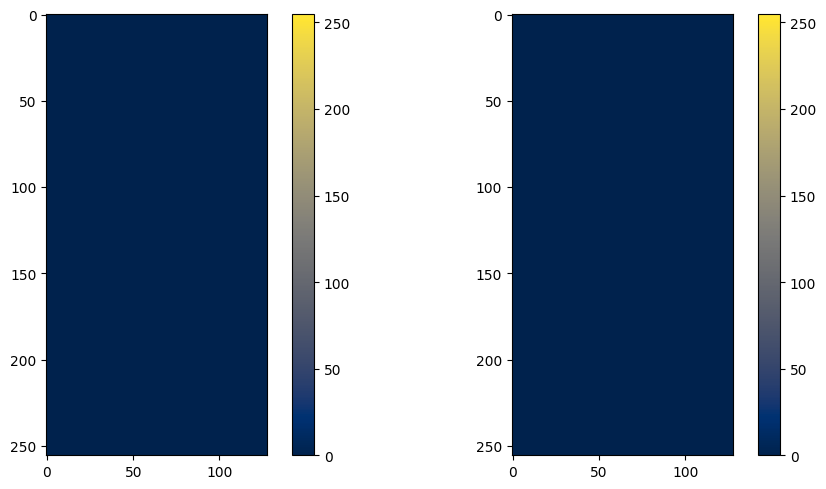

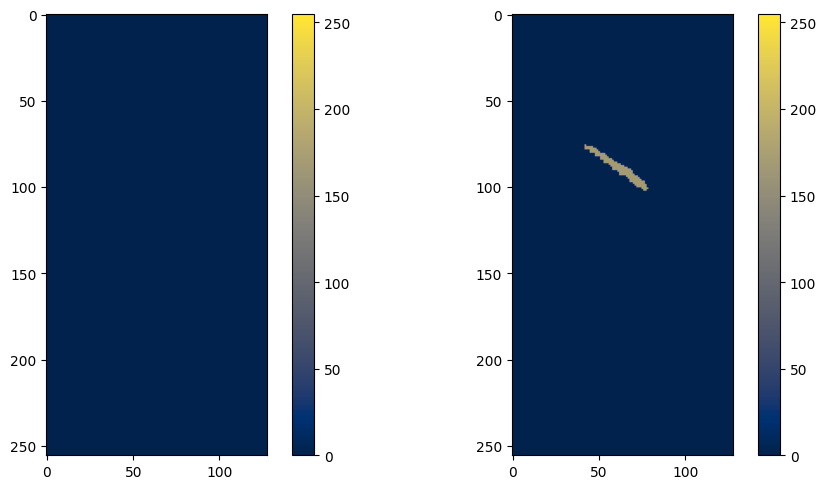

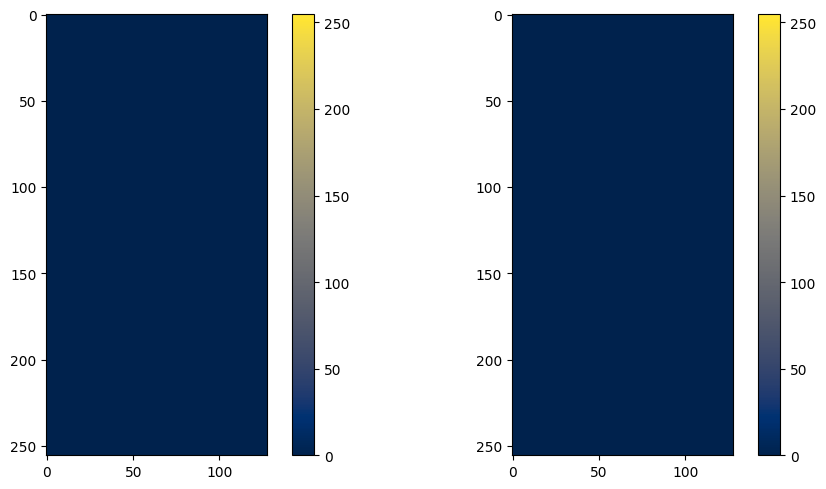

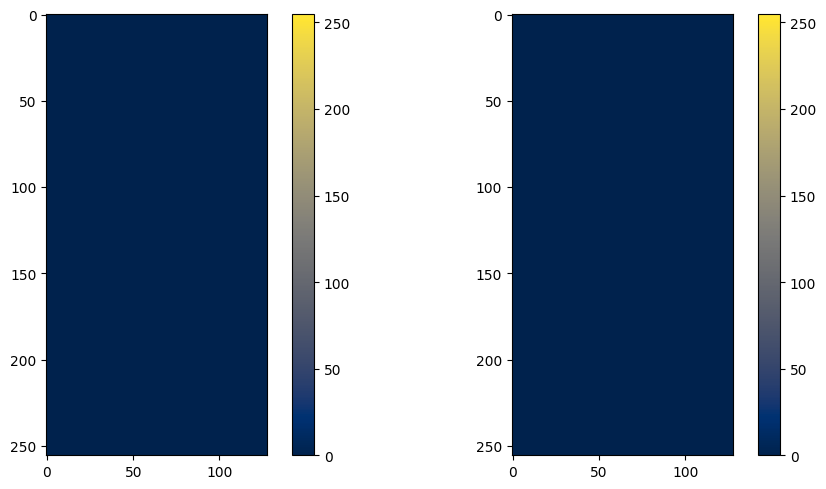

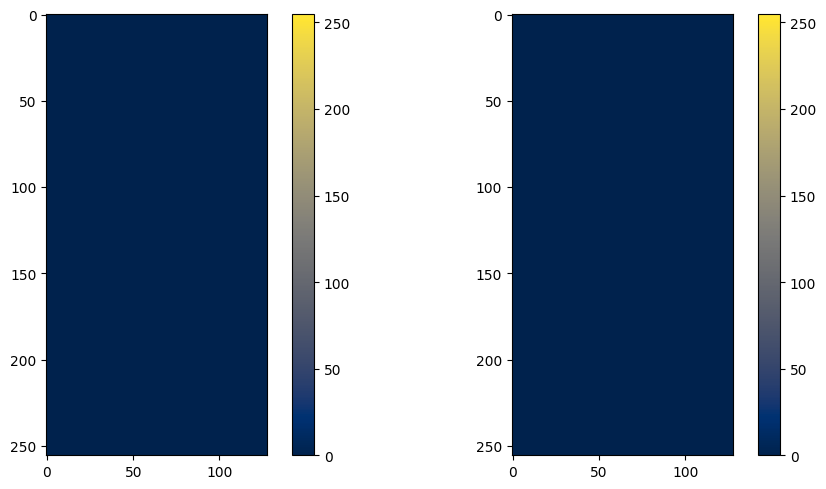

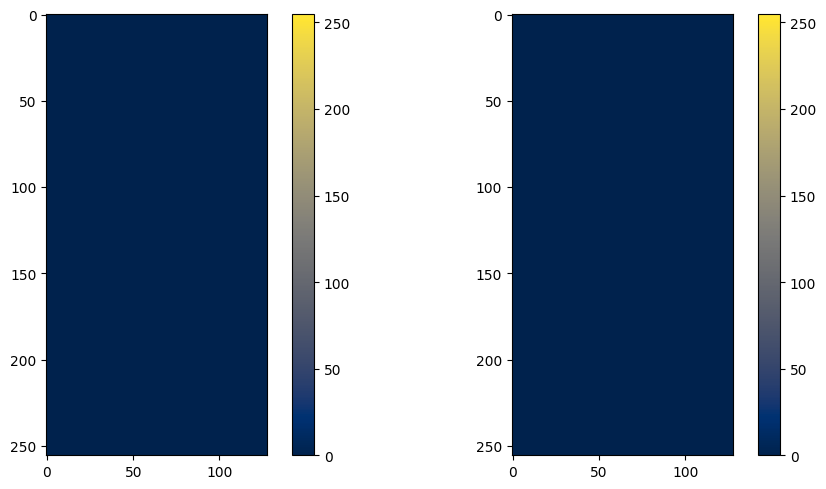

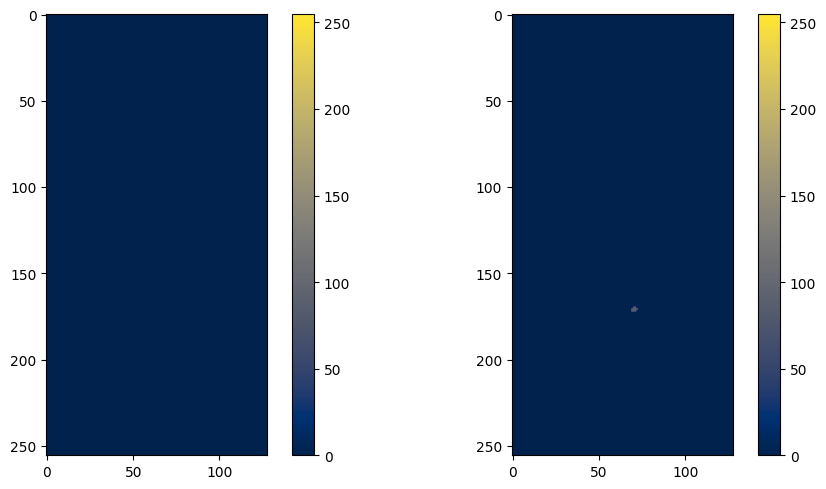

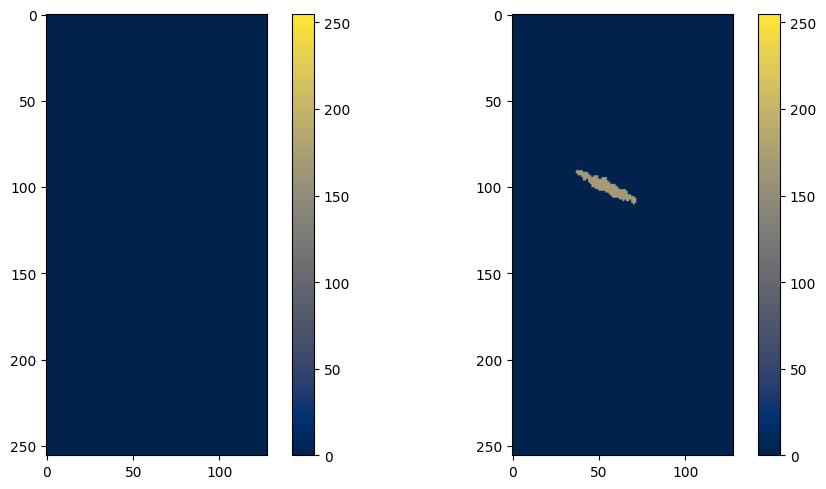

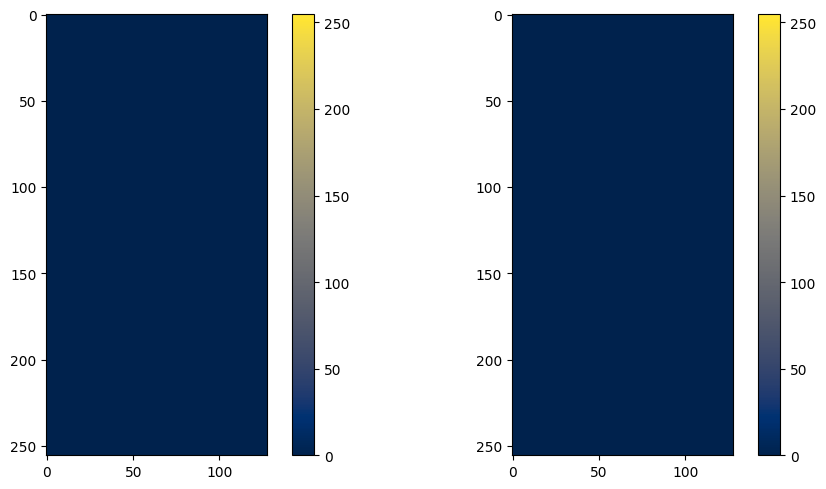

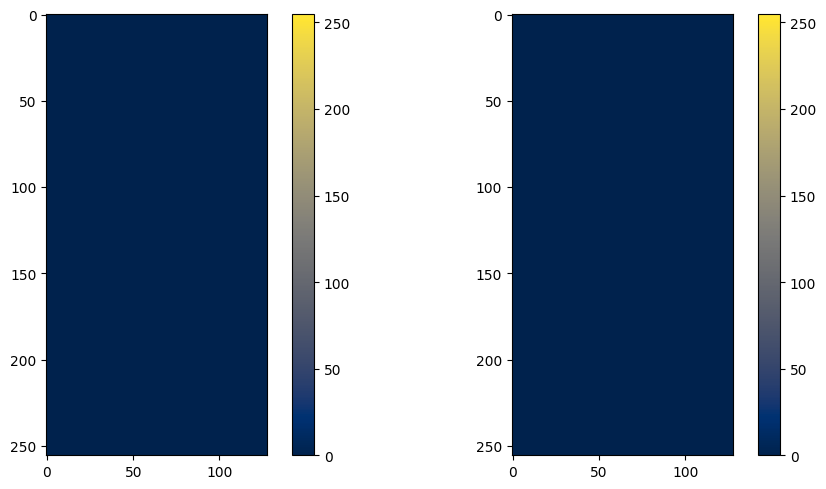

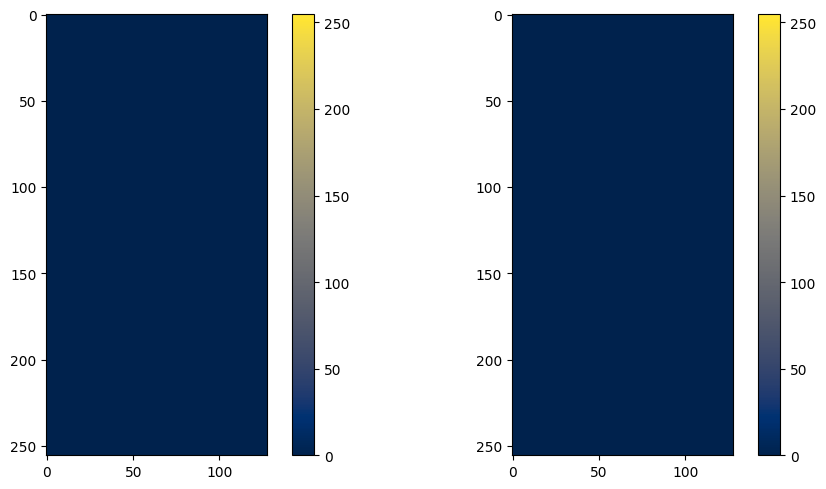

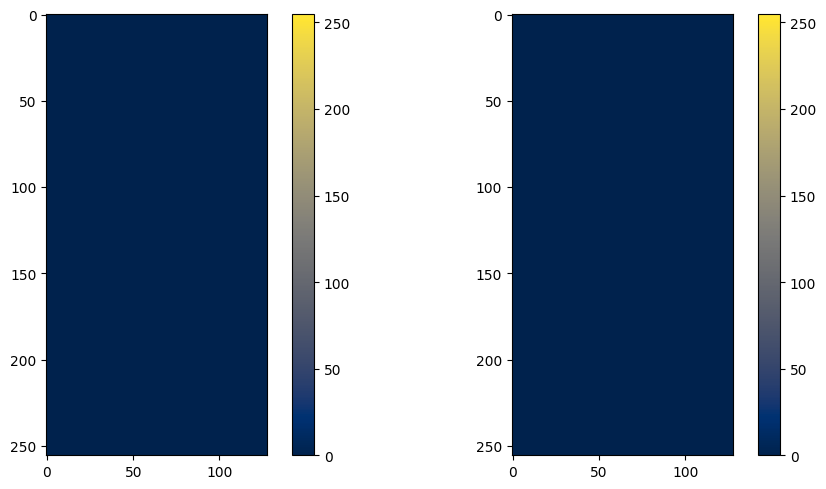

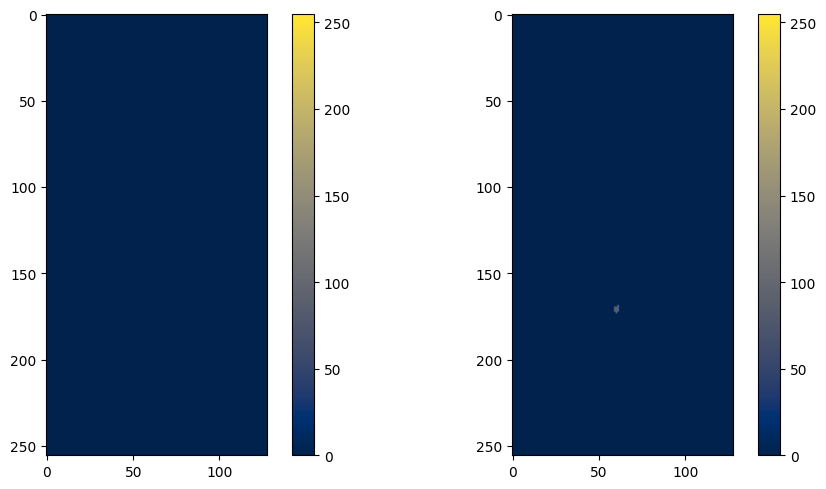

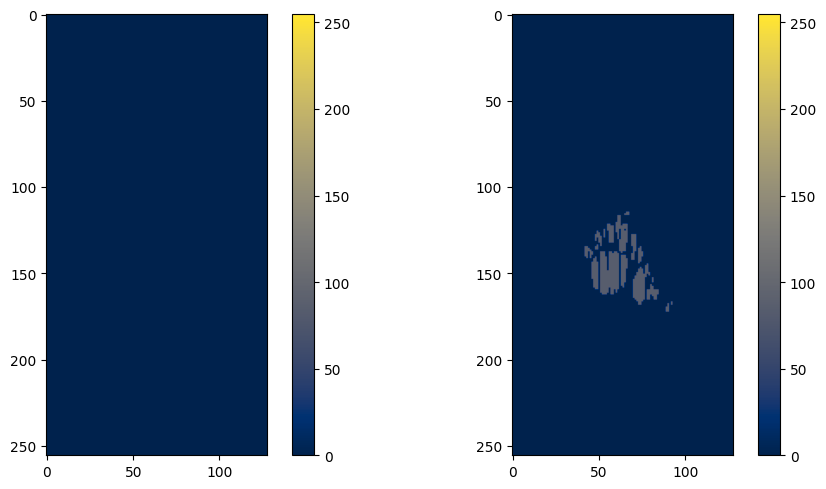

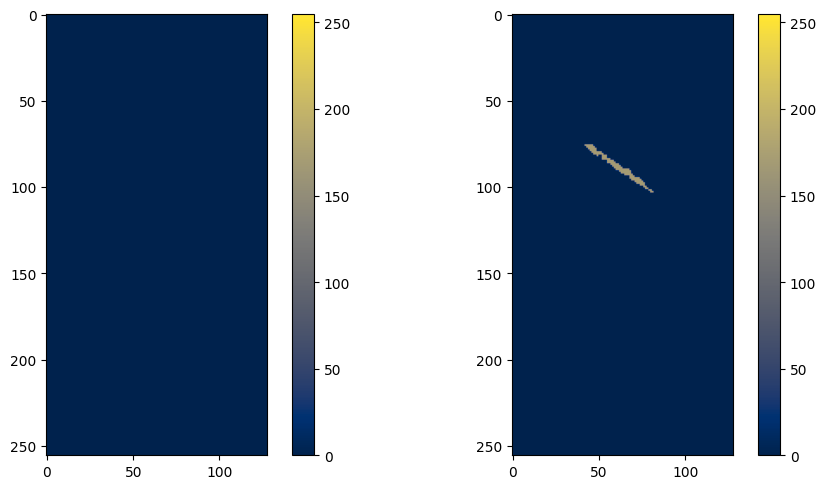

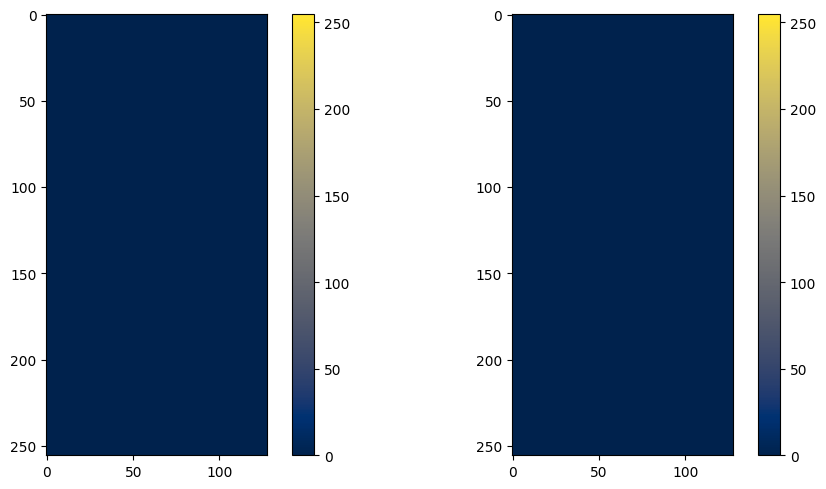

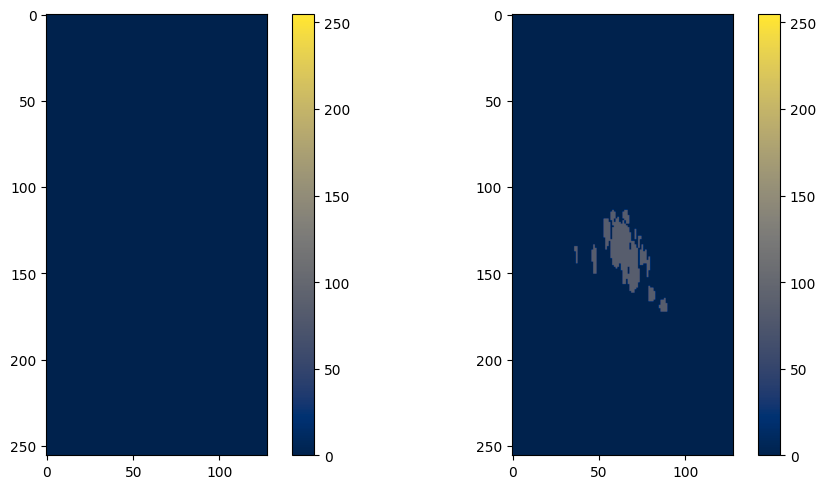

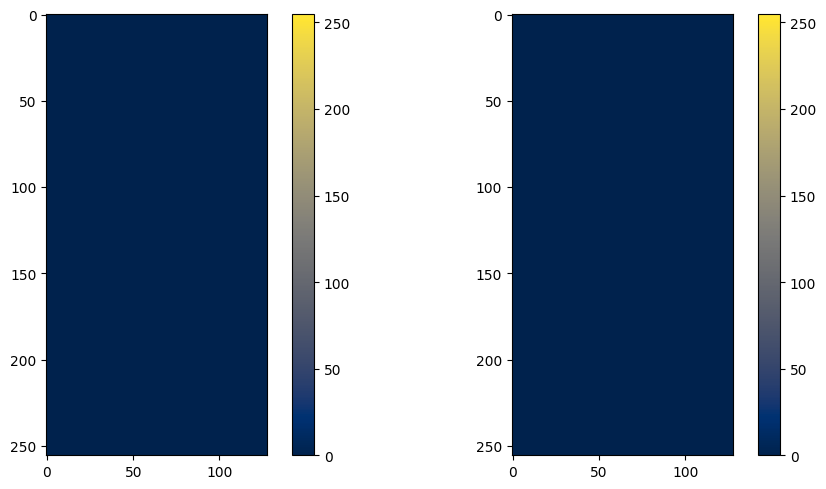

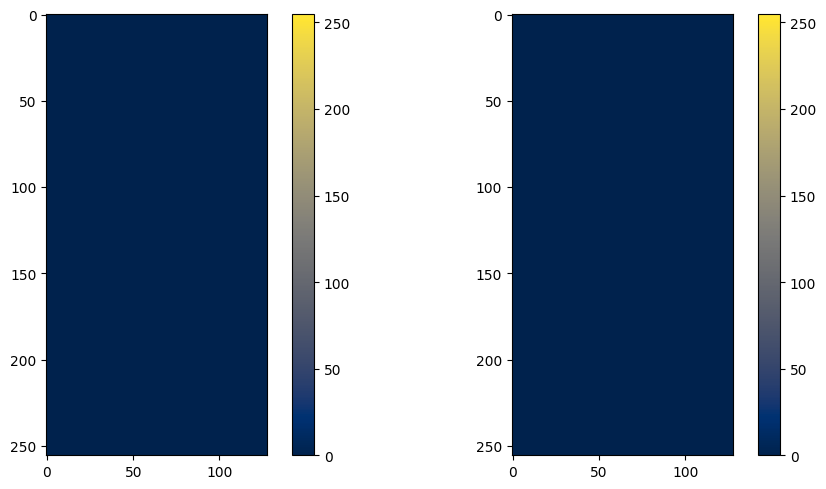

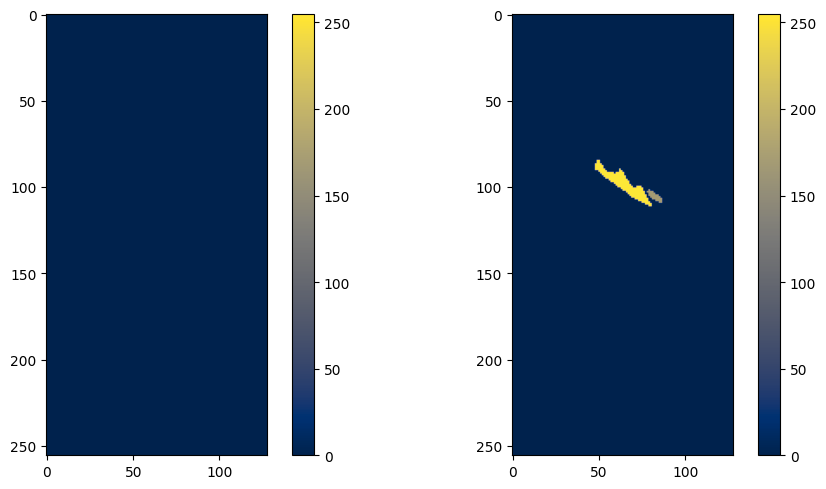

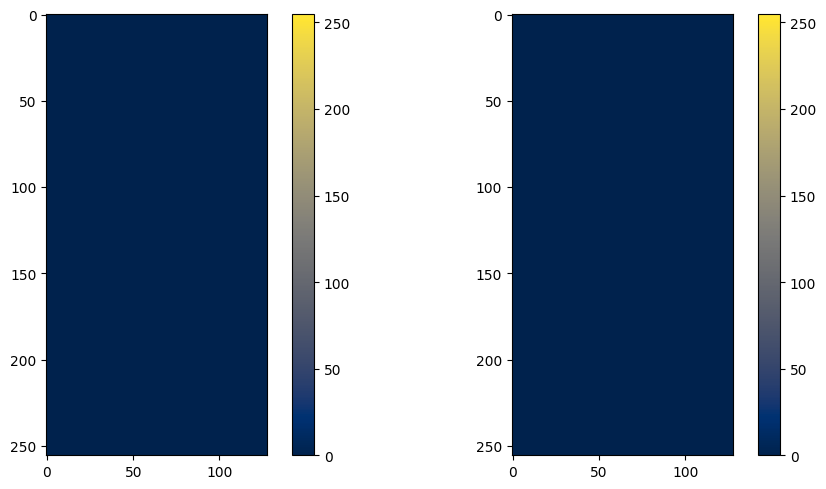

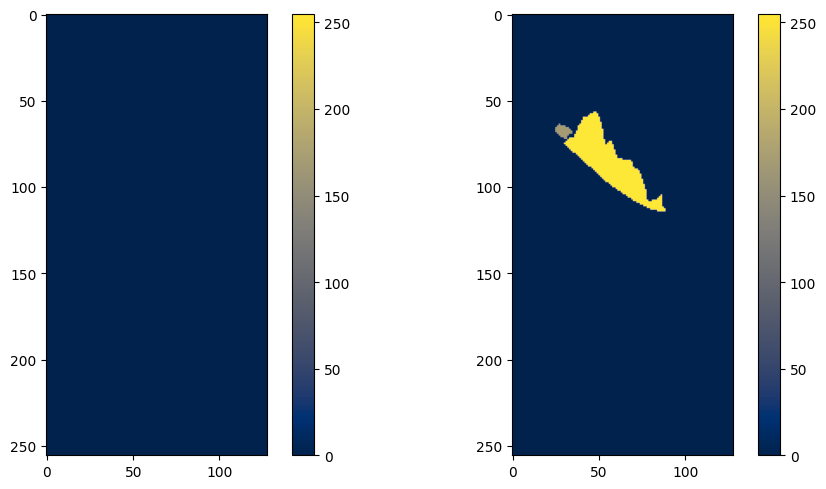

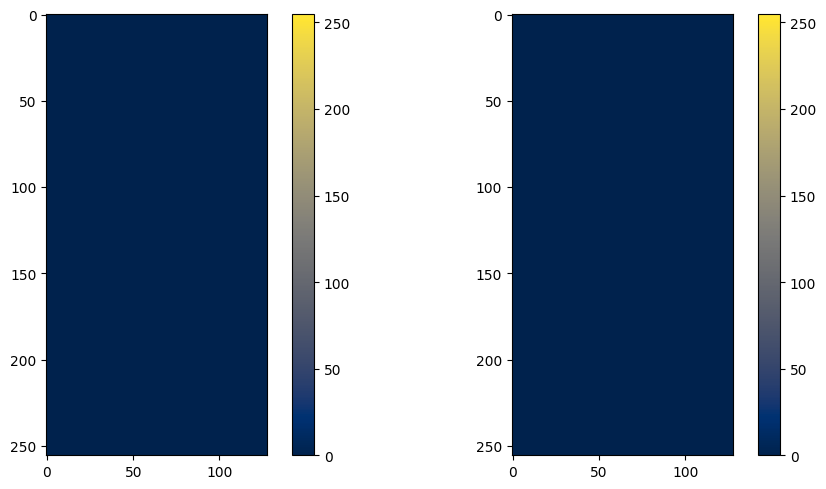

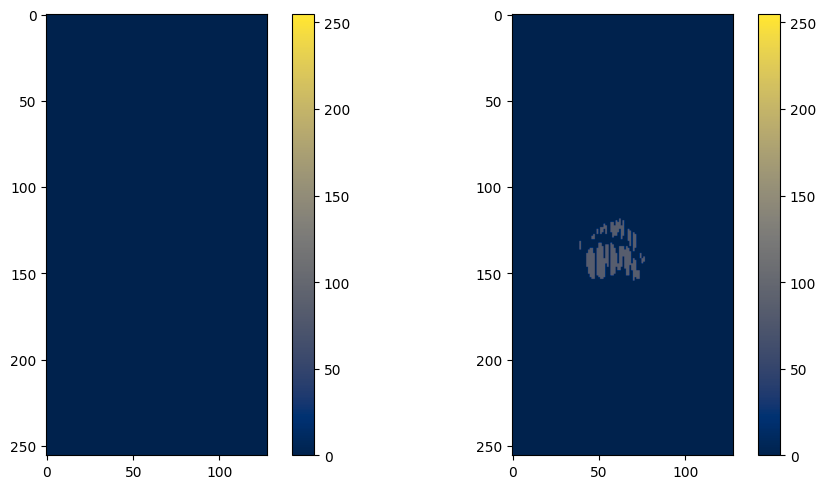

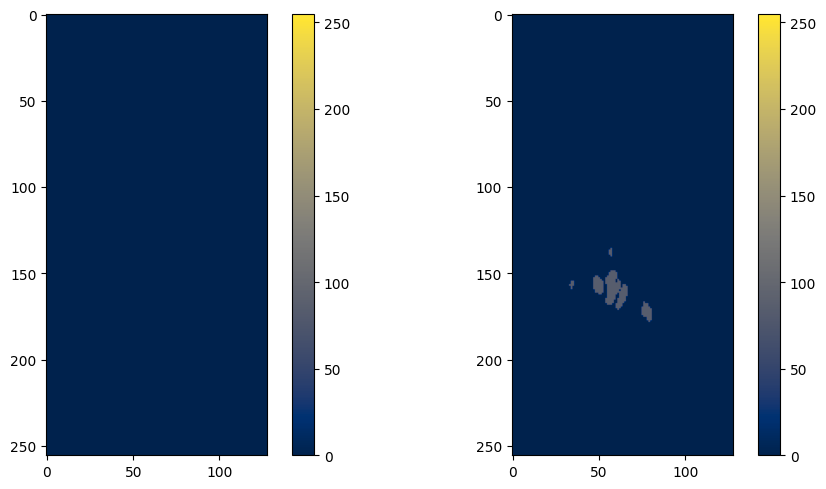

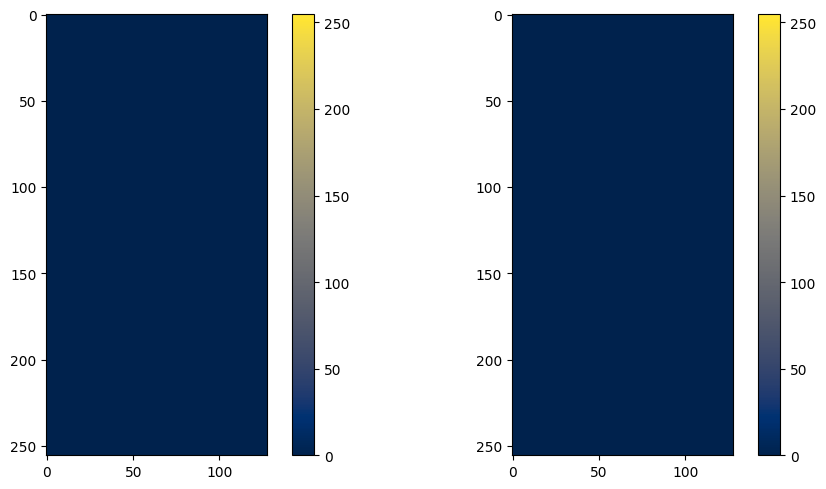

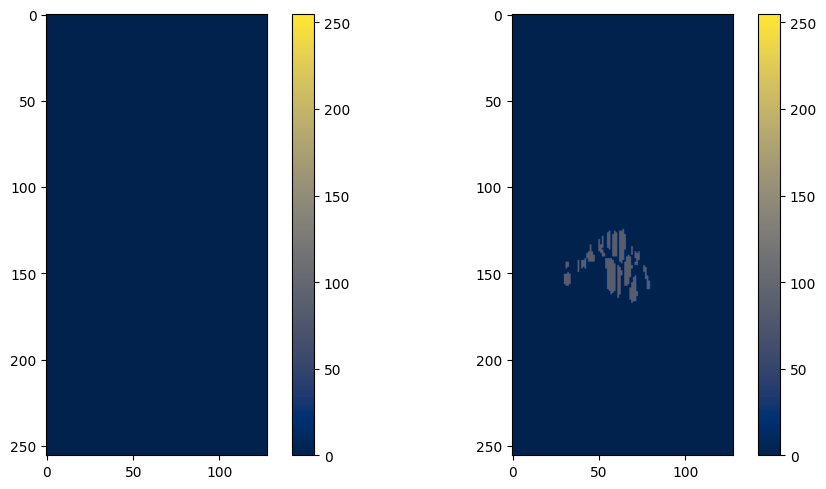

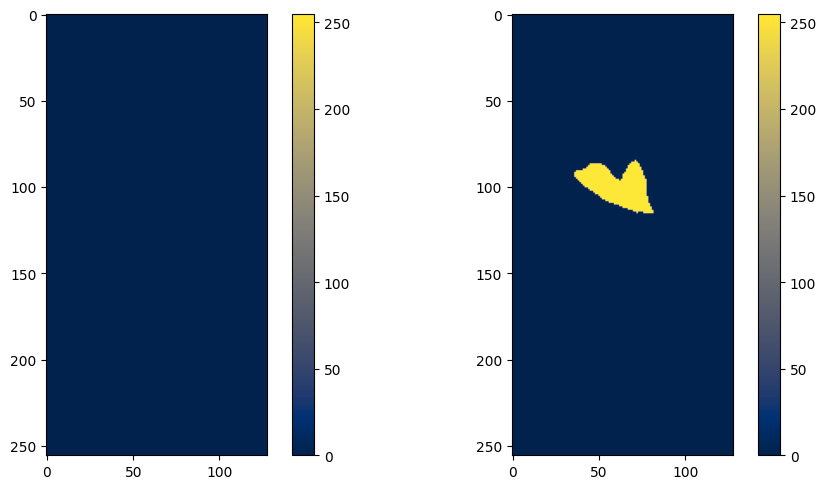

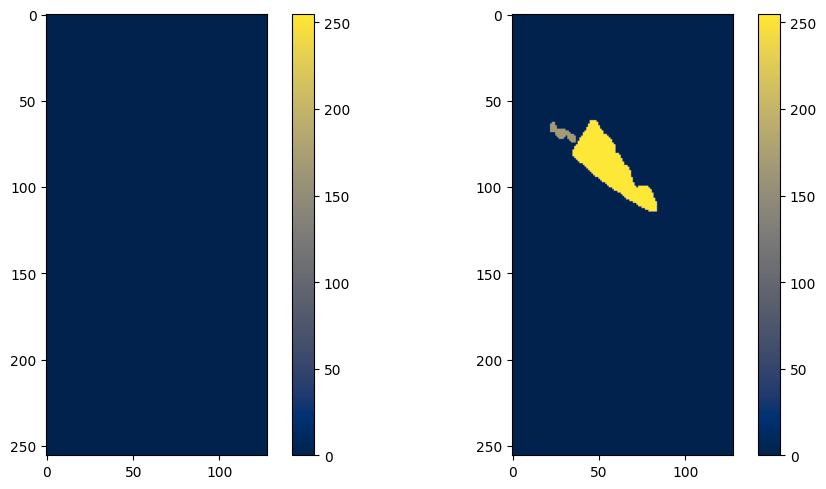

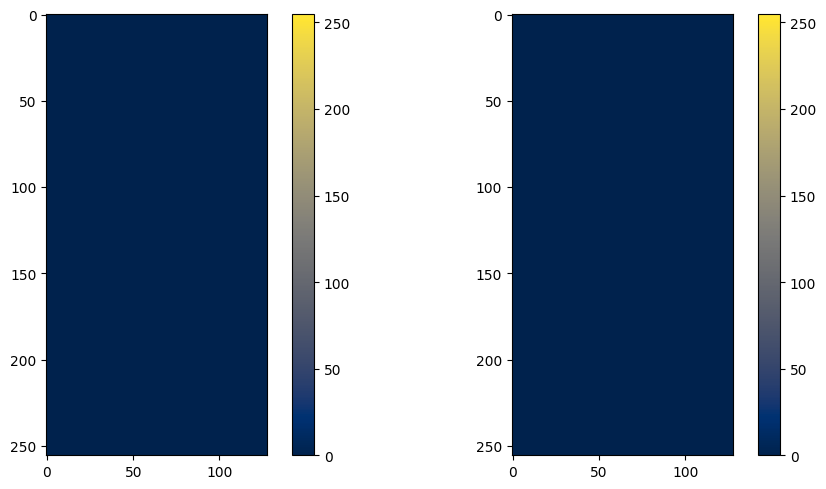

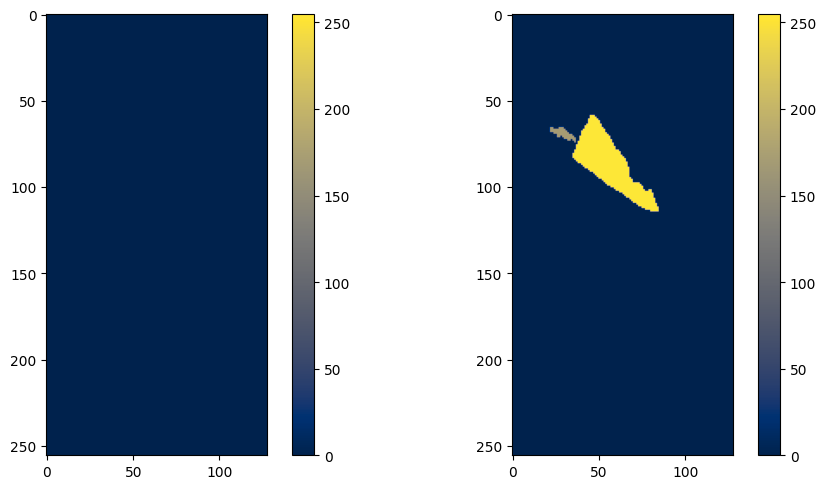

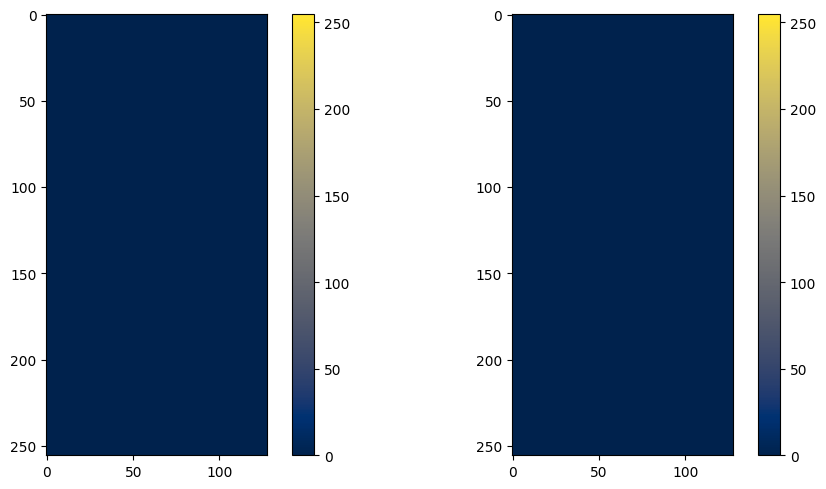

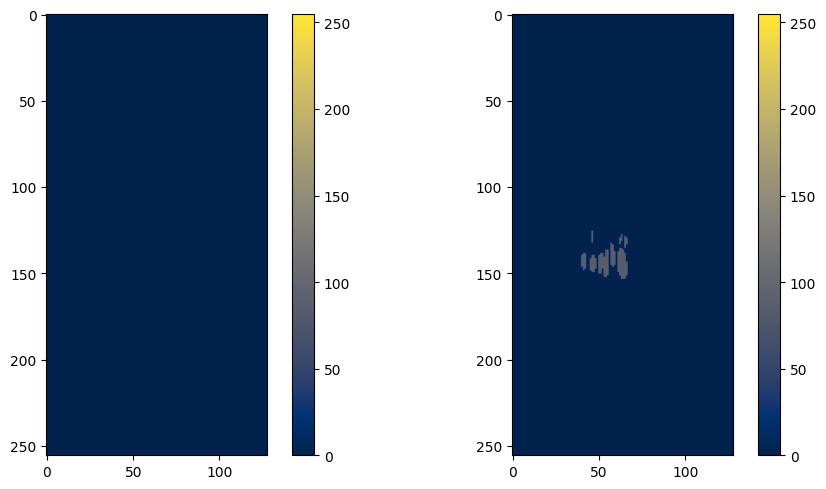

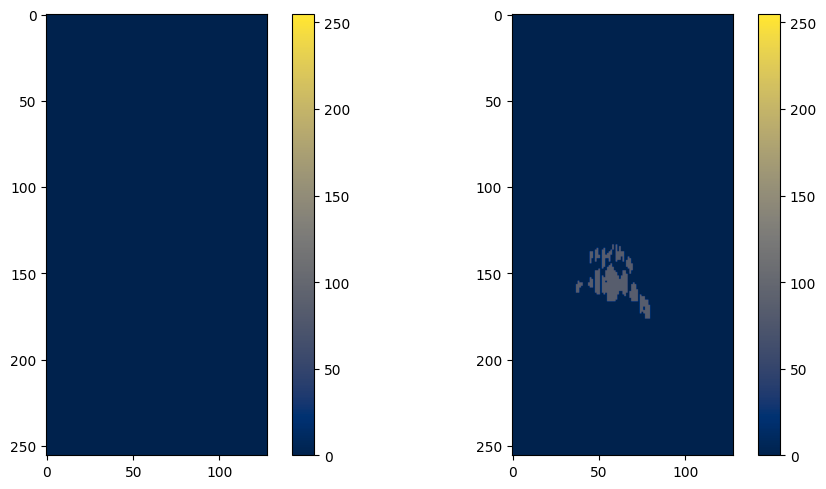

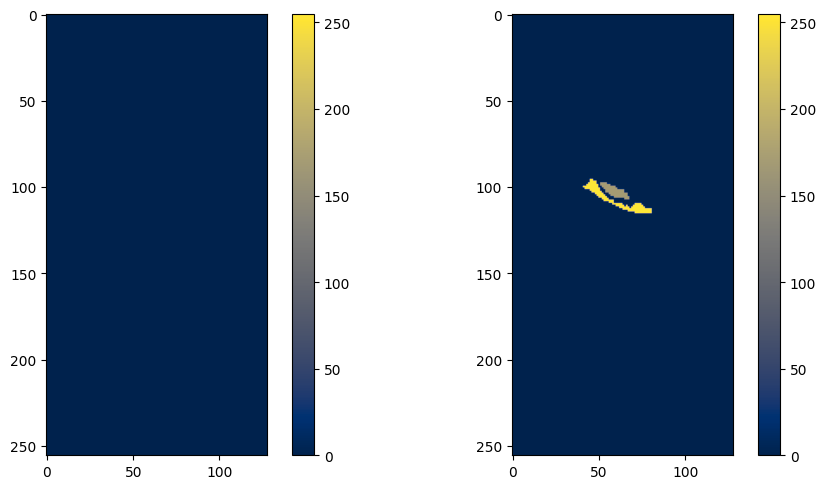

768 ./Images/OCT/07_000.tif
768 ./Images/Reference/07_000.tif
769 ./Images/OCT/07_001.tif
769 ./Images/Reference/07_001.tif
770 ./Images/OCT/07_002.tif
770 ./Images/Reference/07_002.tif
771 ./Images/OCT/07_003.tif
771 ./Images/Reference/07_003.tif
772 ./Images/OCT/07_004.tif
772 ./Images/Reference/07_004.tif
773 ./Images/OCT/07_005.tif
773 ./Images/Reference/07_005.tif
774 ./Images/OCT/07_006.tif
774 ./Images/Reference/07_006.tif
775 ./Images/OCT/07_007.tif
775 ./Images/Reference/07_007.tif
776 ./Images/OCT/07_008.tif
776 ./Images/Reference/07_008.tif
777 ./Images/OCT/07_009.tif
777 ./Images/Reference/07_009.tif
778 ./Images/OCT/07_010.tif
778 ./Images/Reference/07_010.tif
779 ./Images/OCT/07_011.tif
779 ./Images/Reference/07_011.tif
780 ./Images/OCT/07_012.tif
780 ./Images/Reference/07_012.tif
781 ./Images/OCT/07_013.tif
781 ./Images/Reference/07_013.tif
782 ./Images/OCT/07_014.tif
782 ./Images/Reference/07_014.tif
783 ./Images/OCT/07_015.tif
783 ./Images/Reference/07_015.tif
784 ./Im

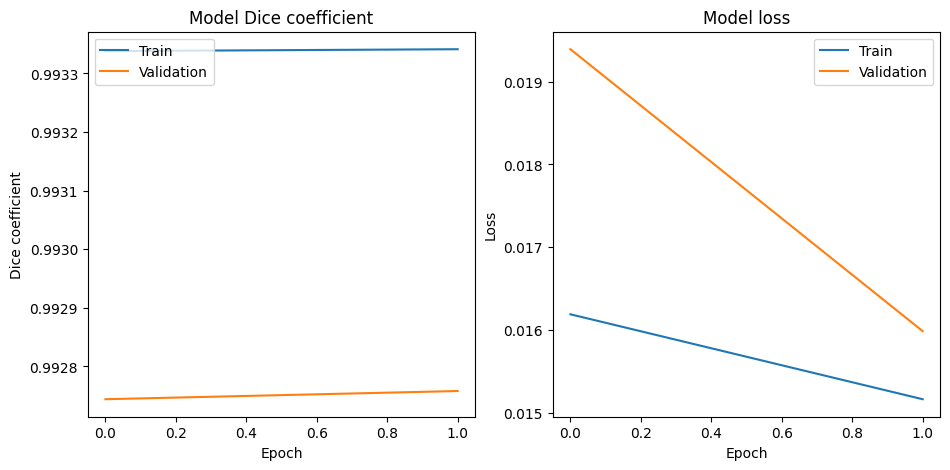

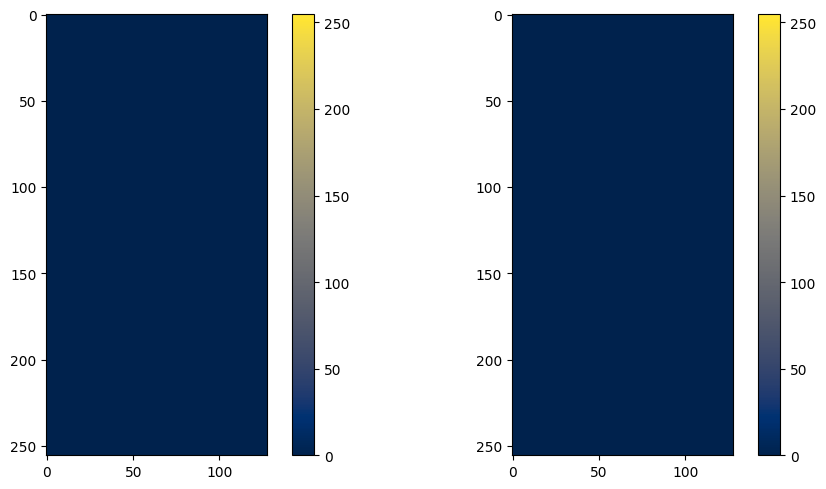

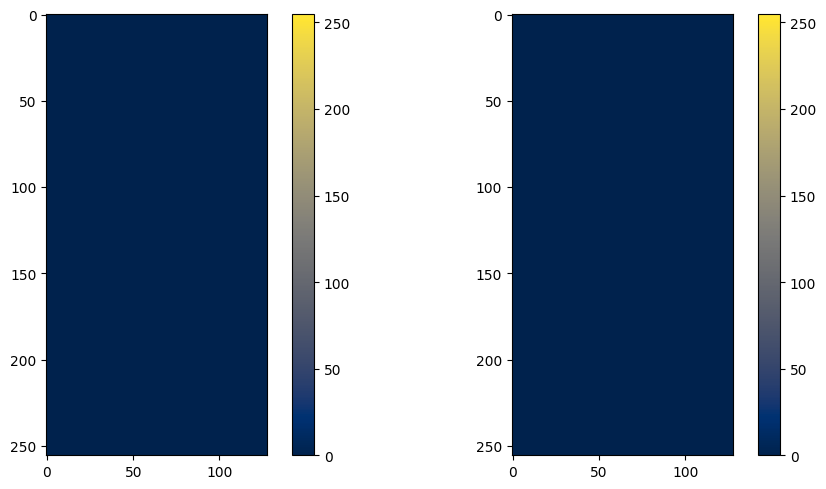

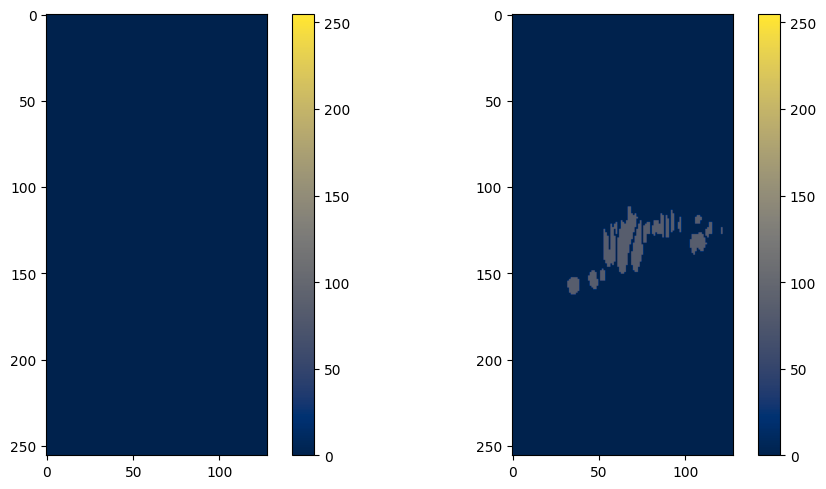

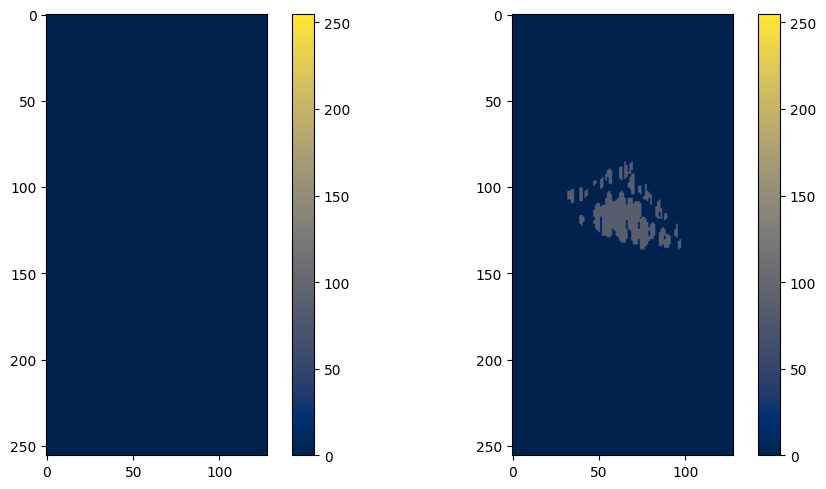

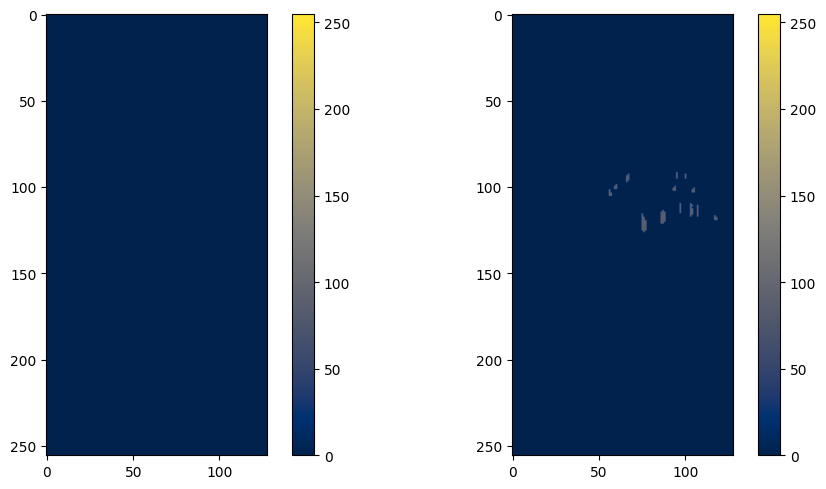

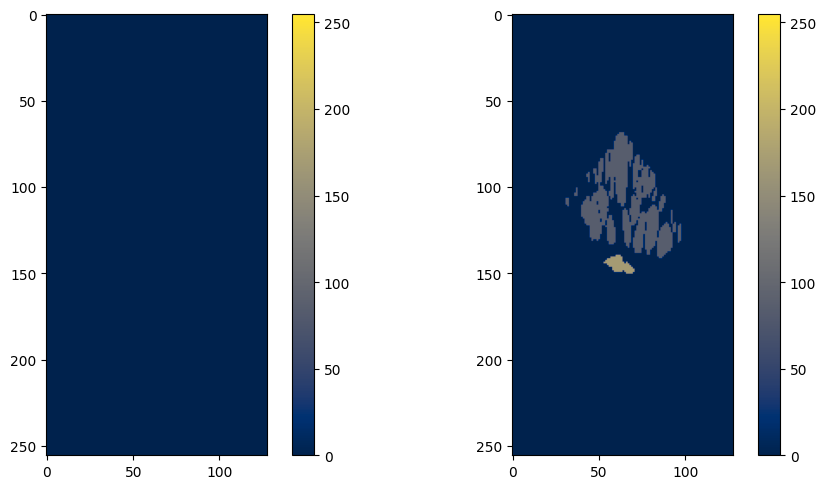

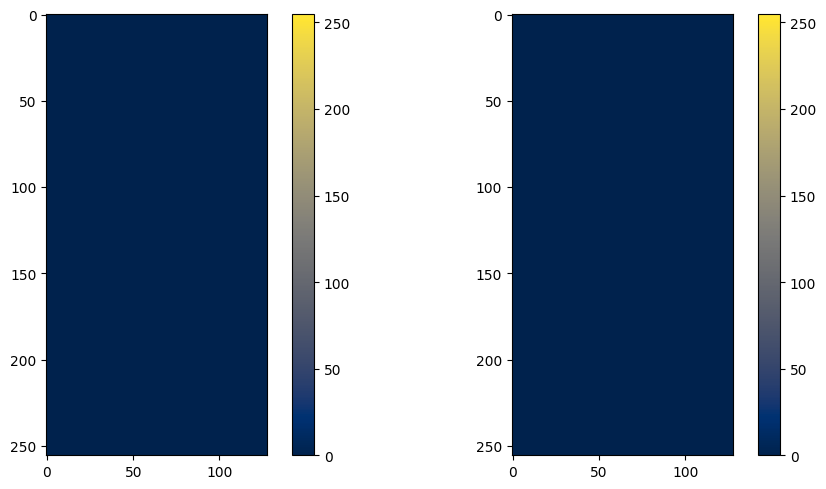

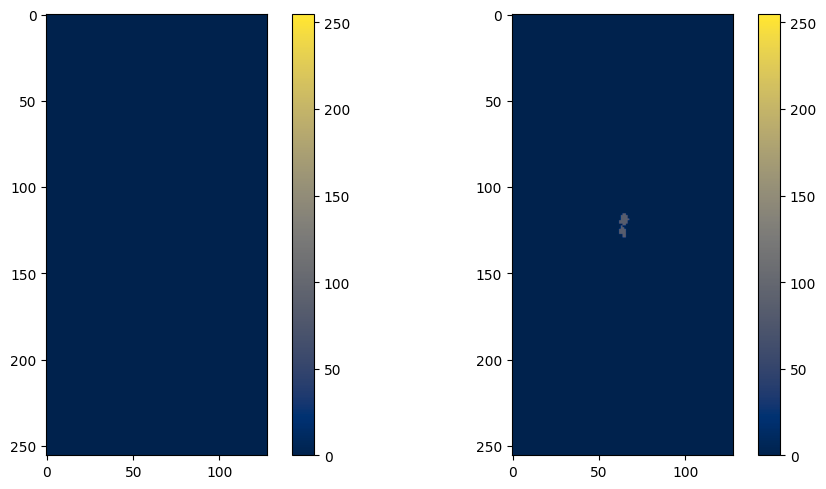

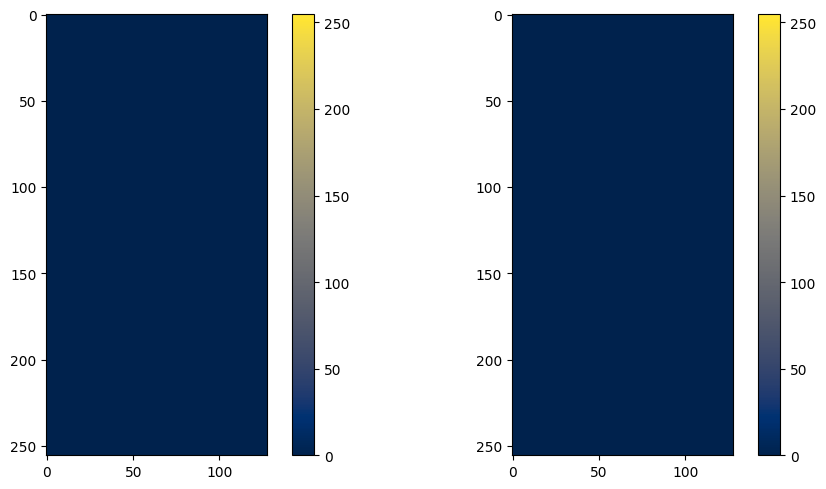

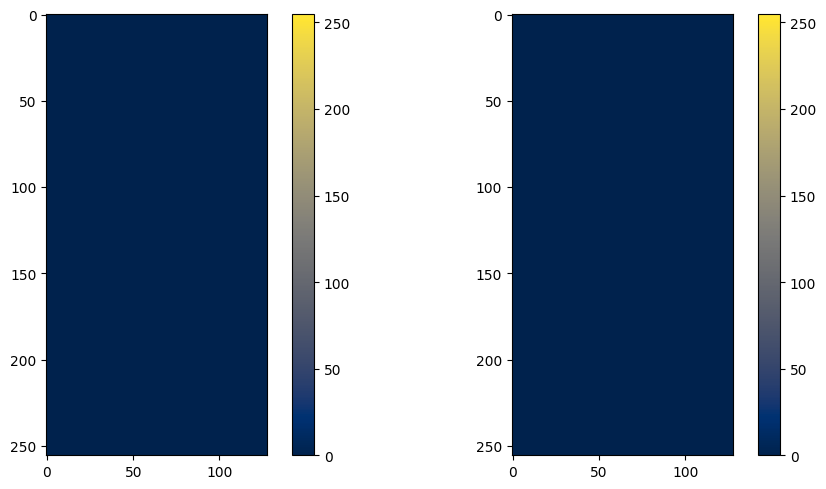

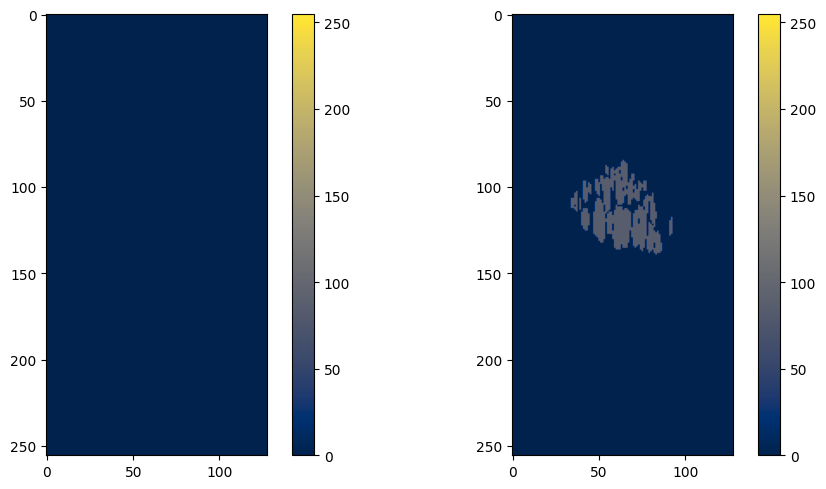

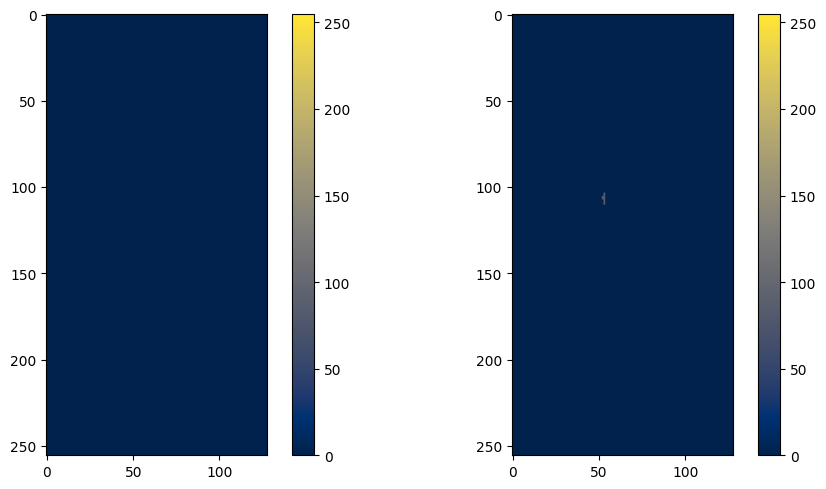

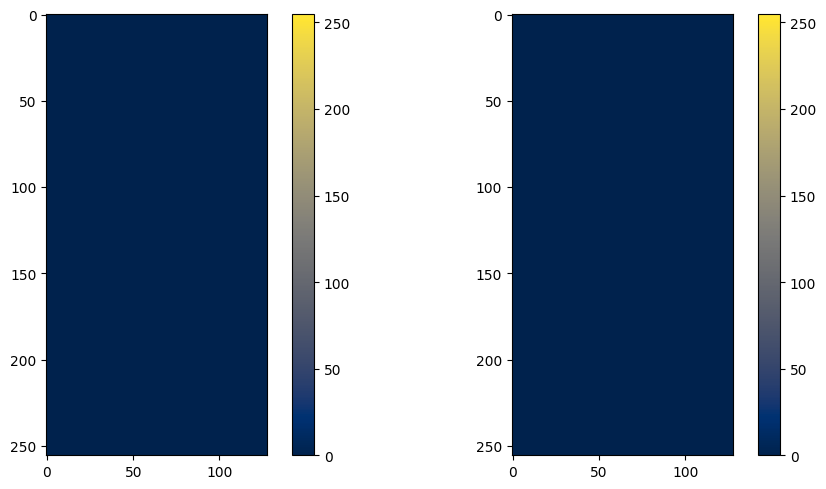

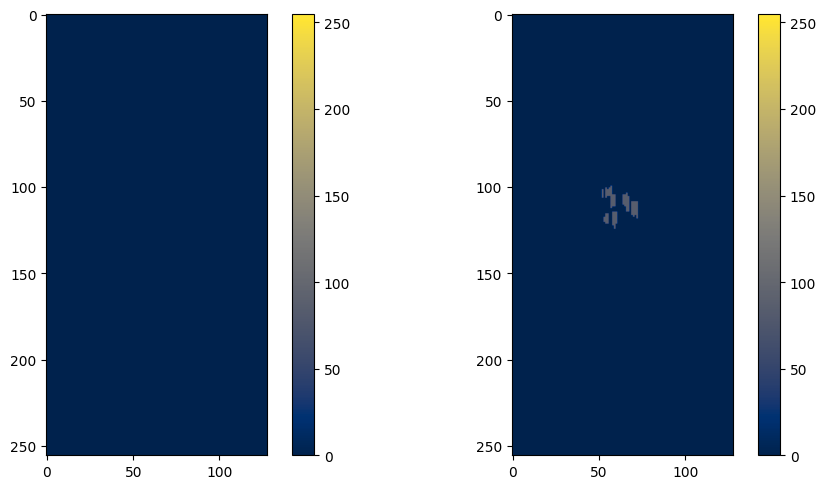

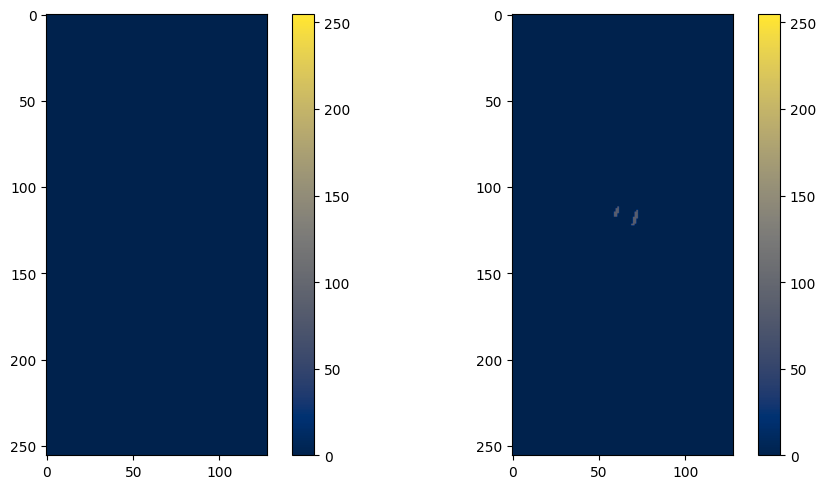

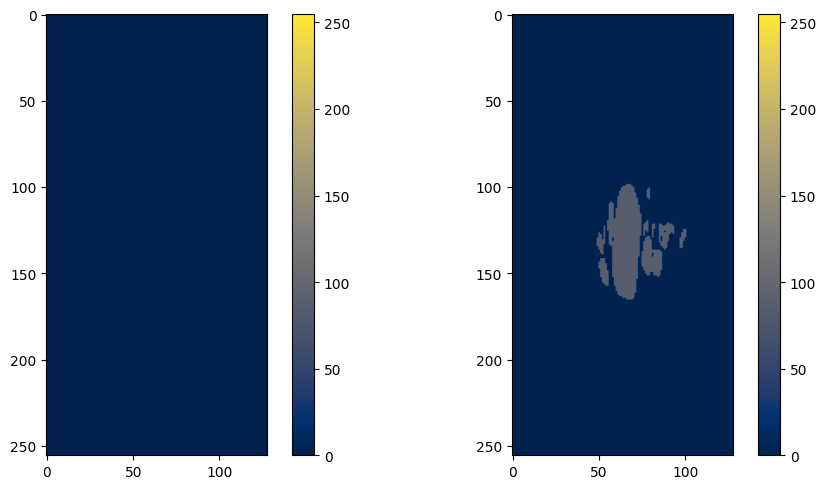

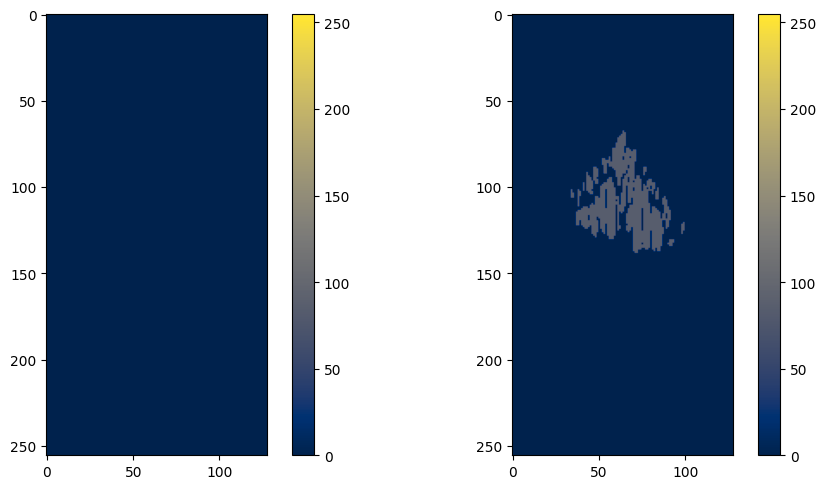

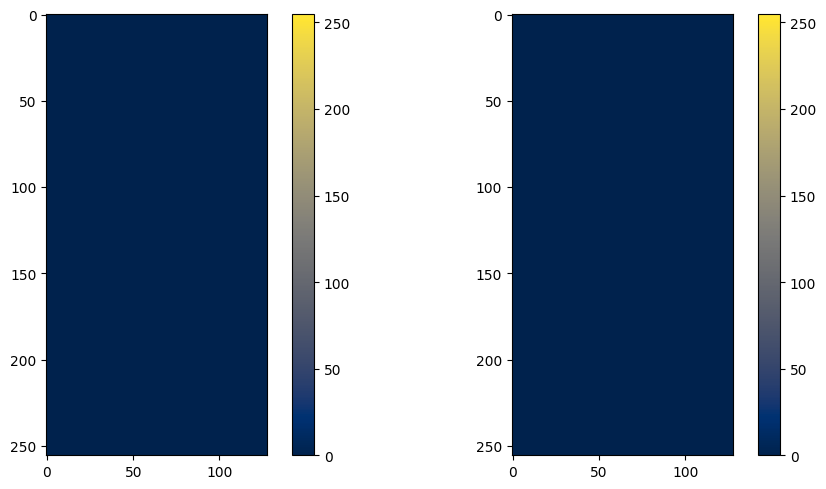

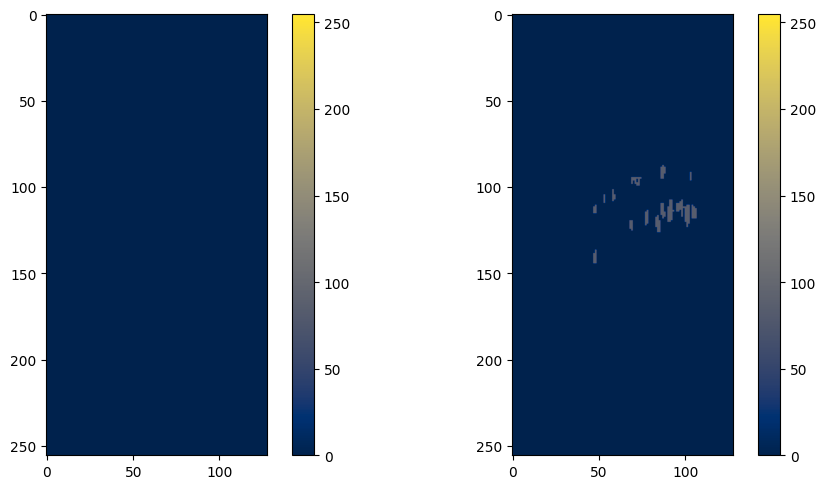

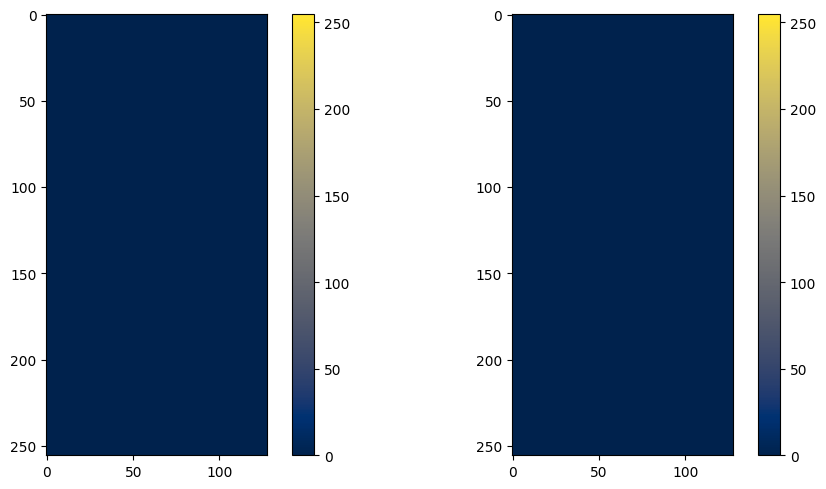

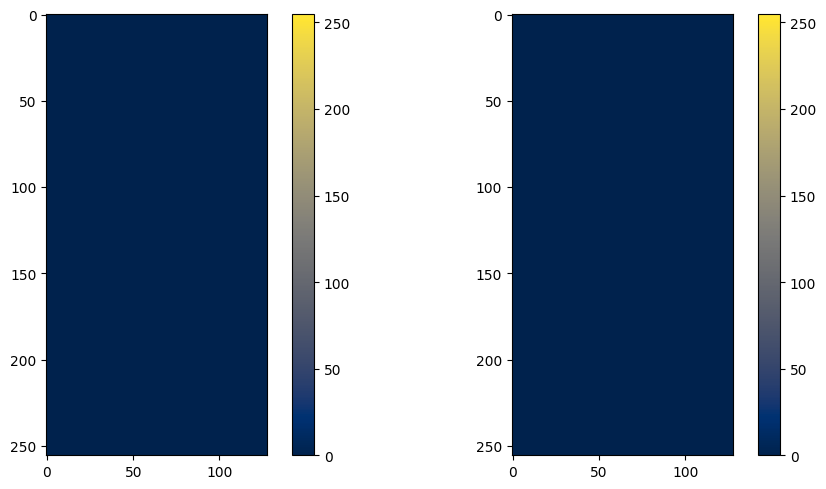

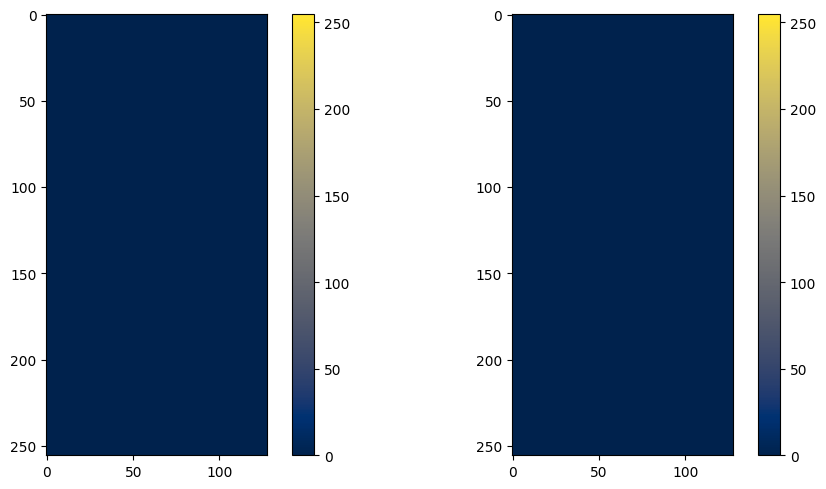

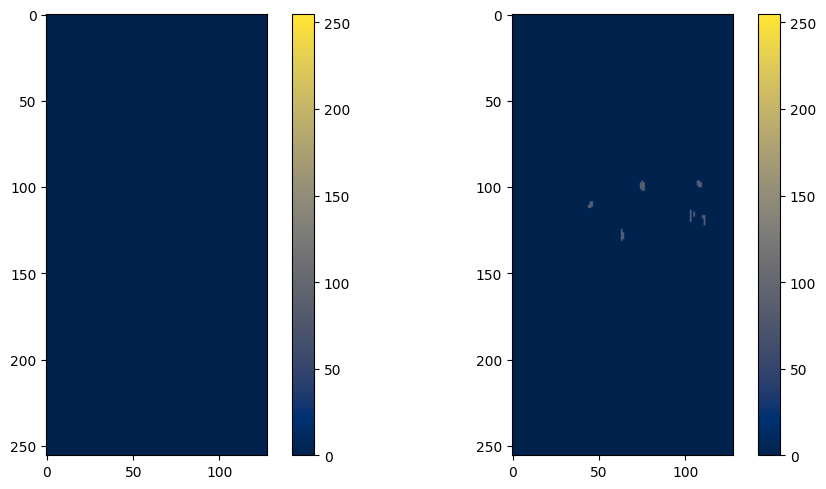

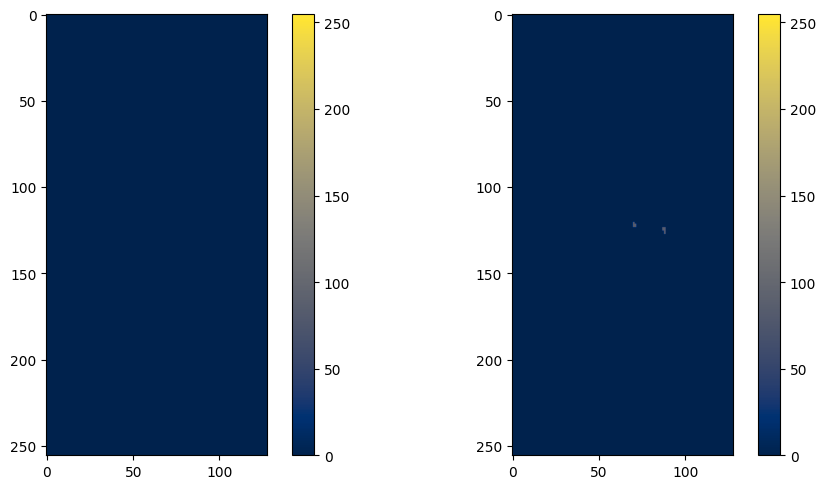

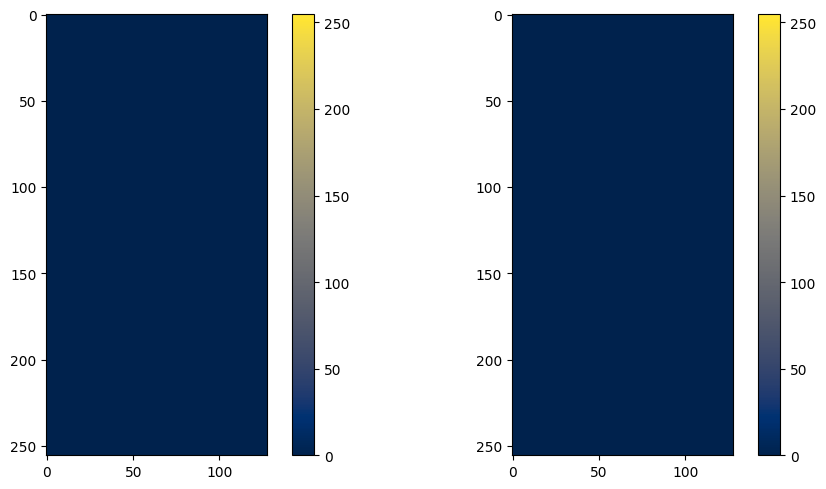

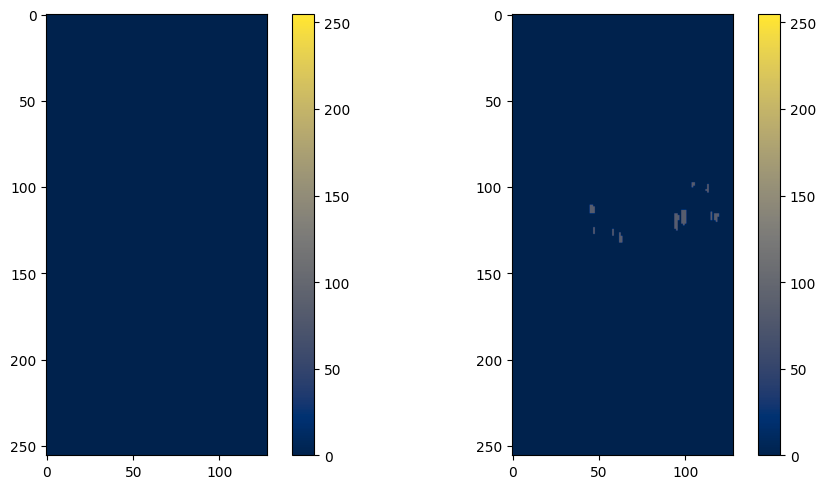

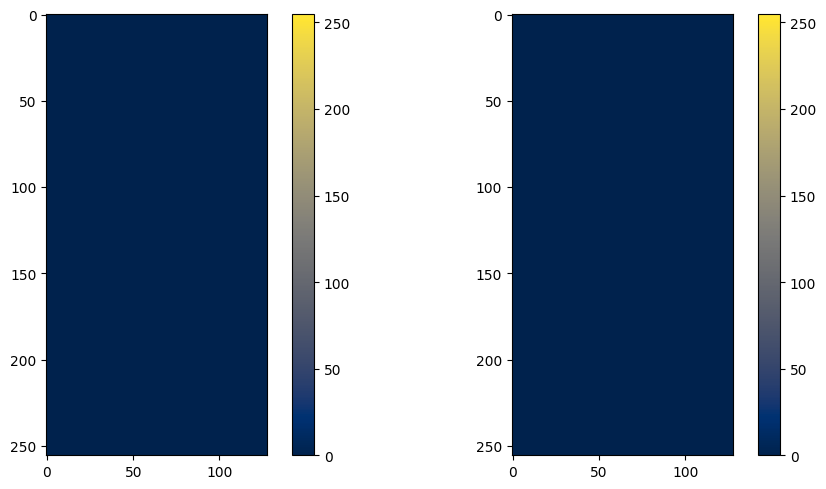

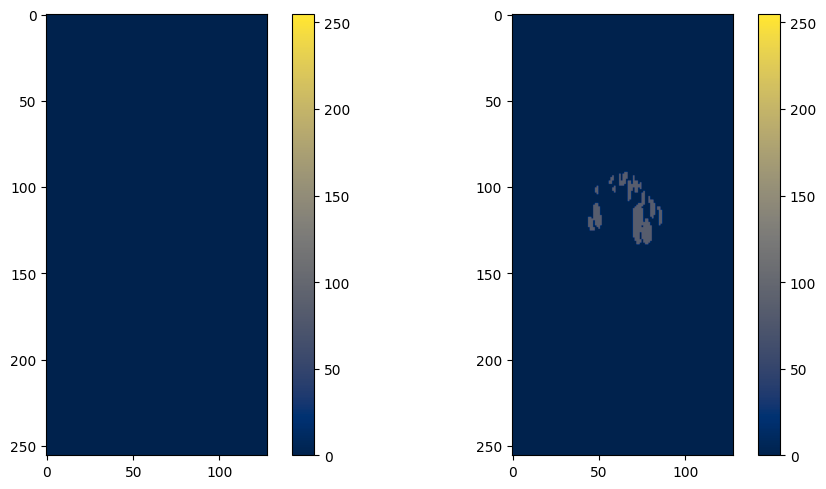

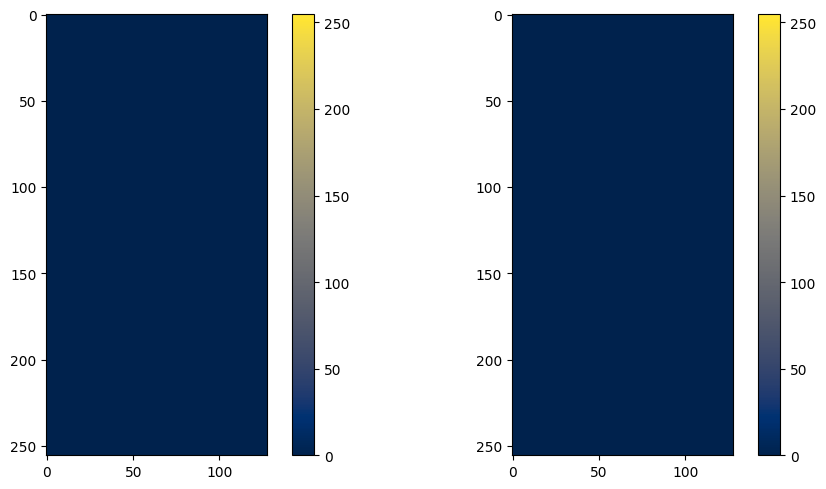

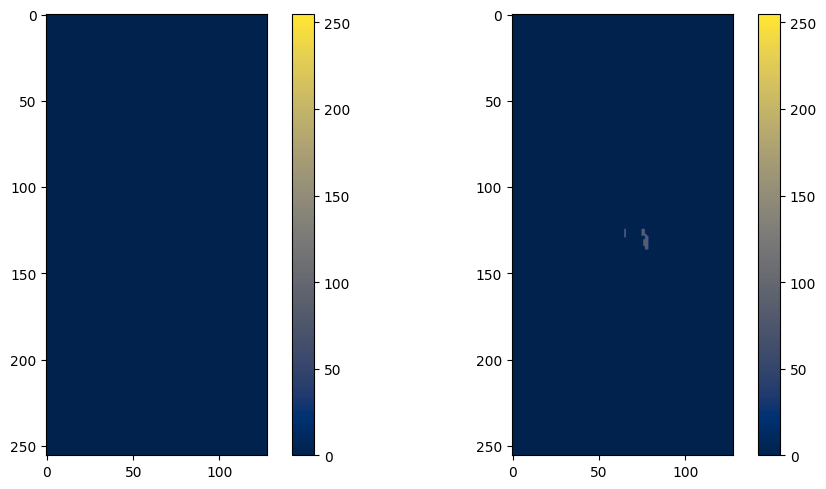

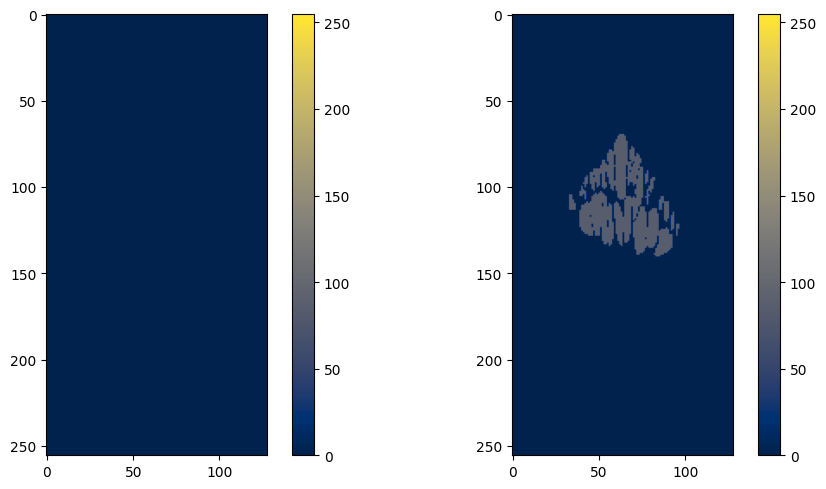

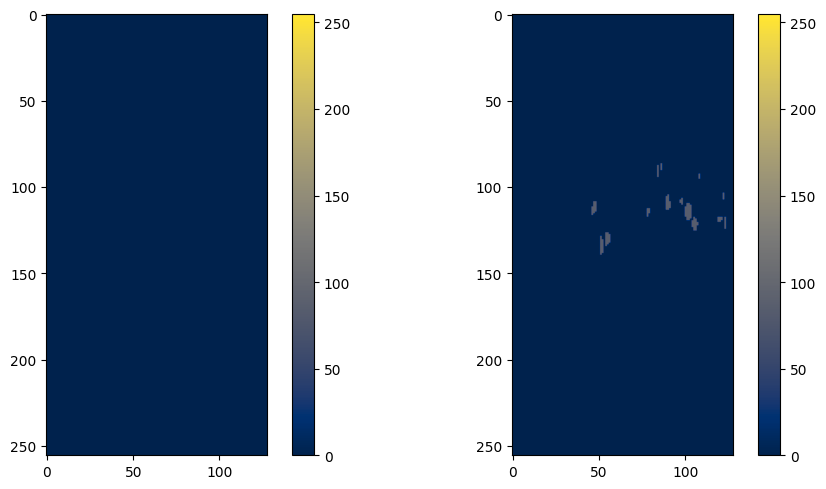

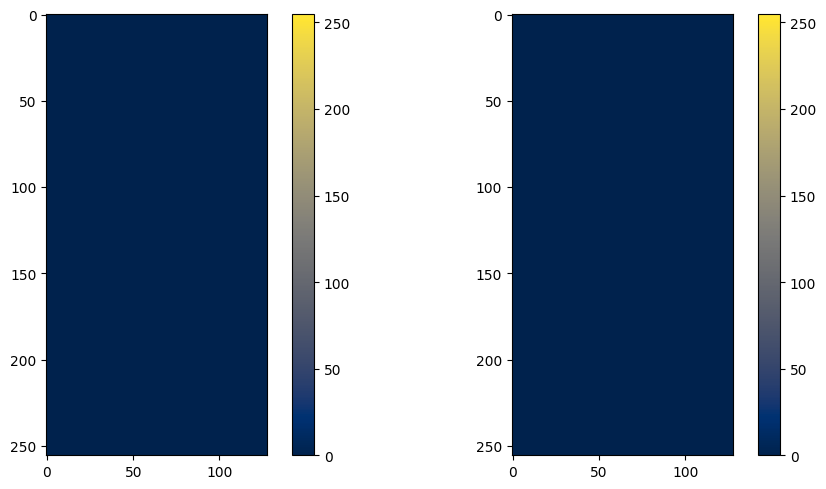

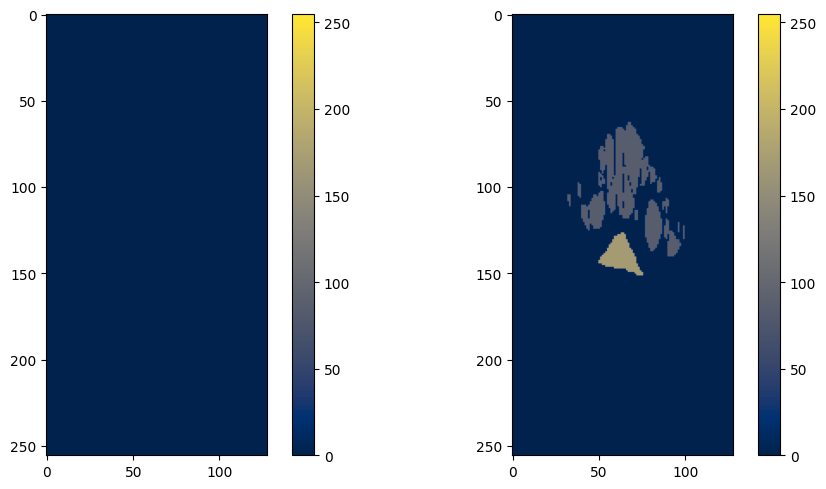

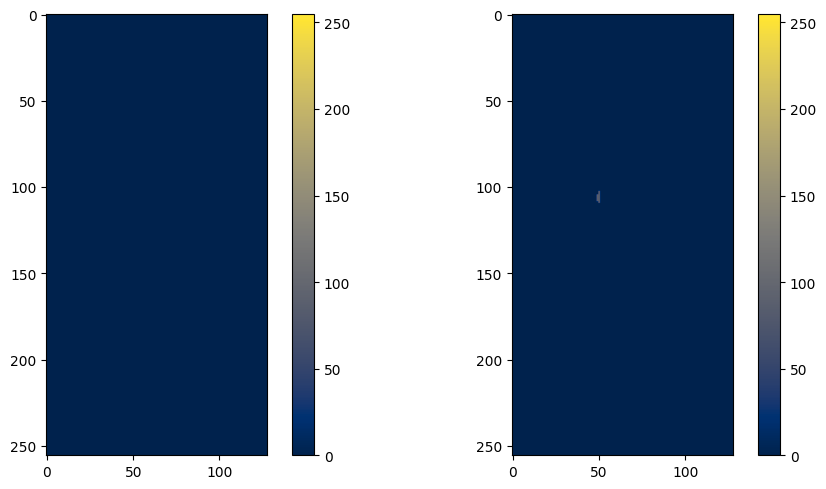

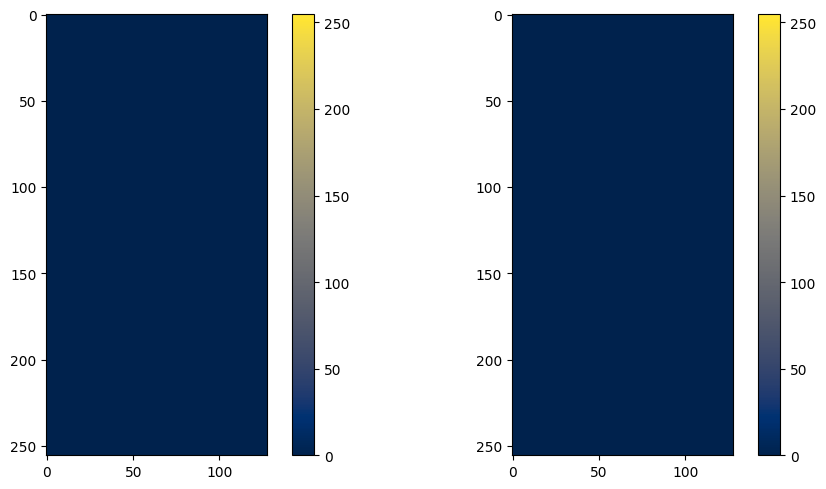

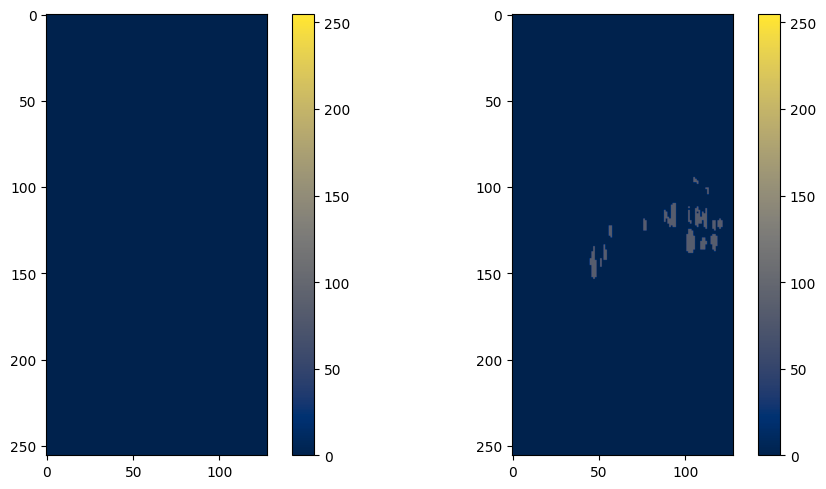

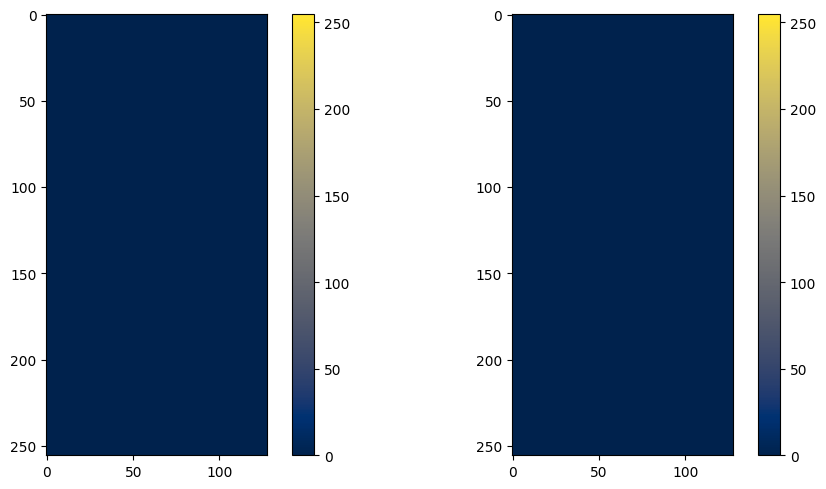

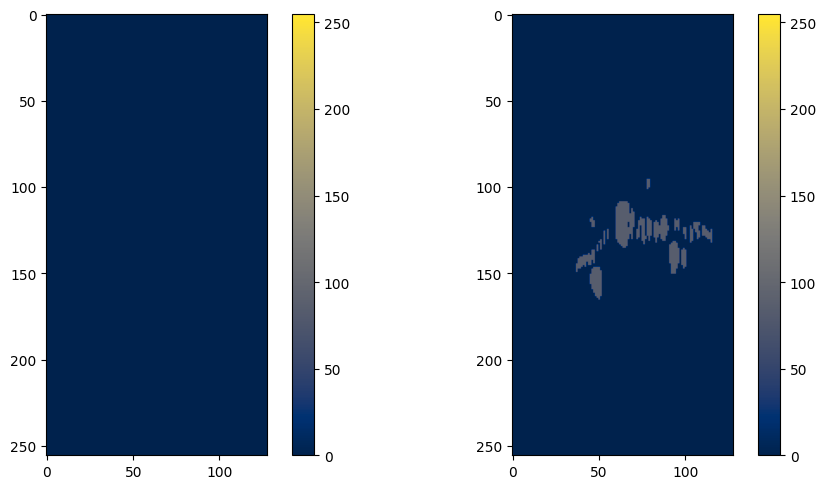

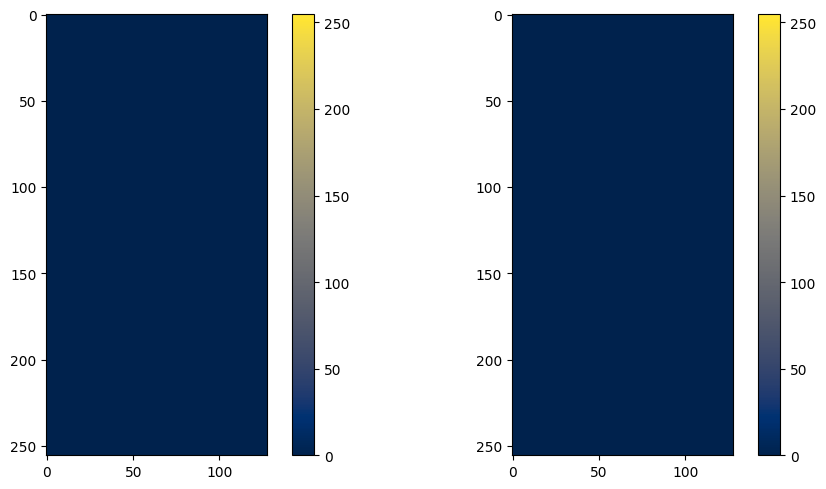

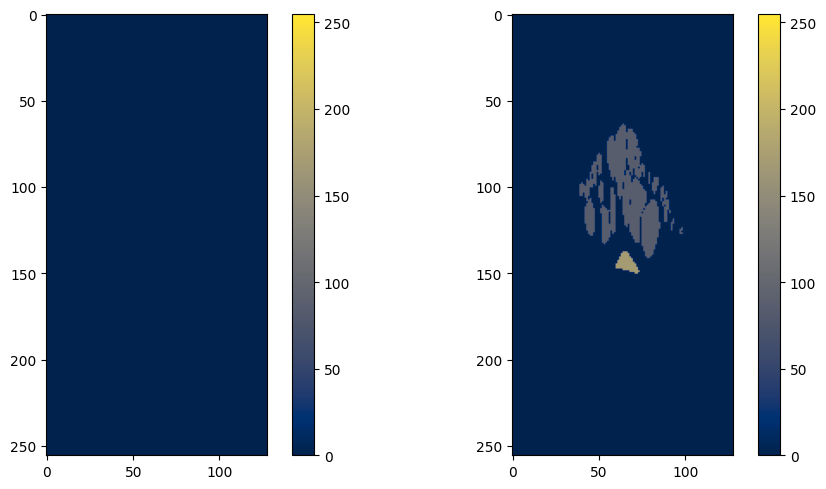

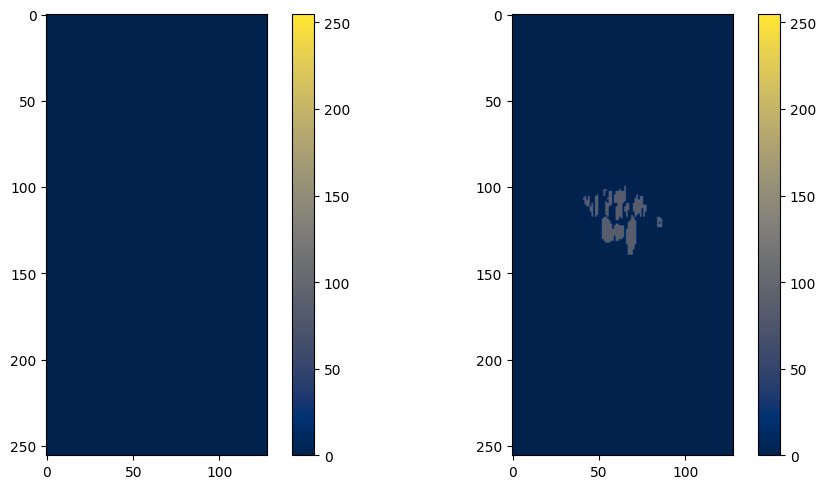

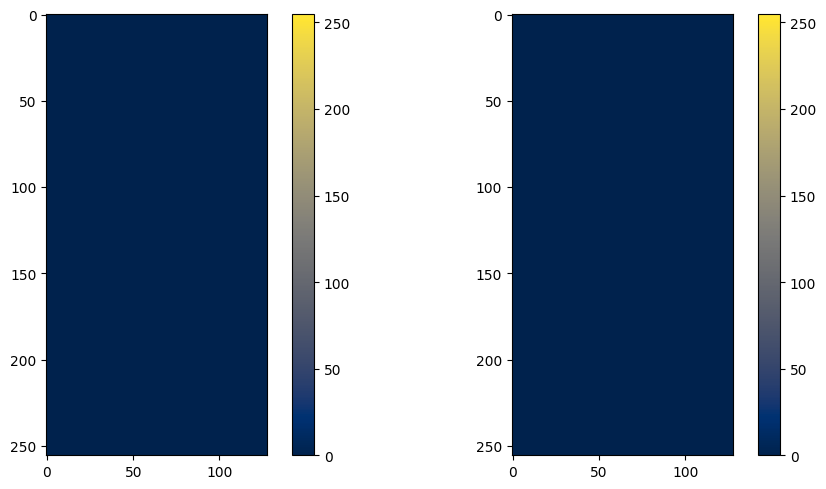

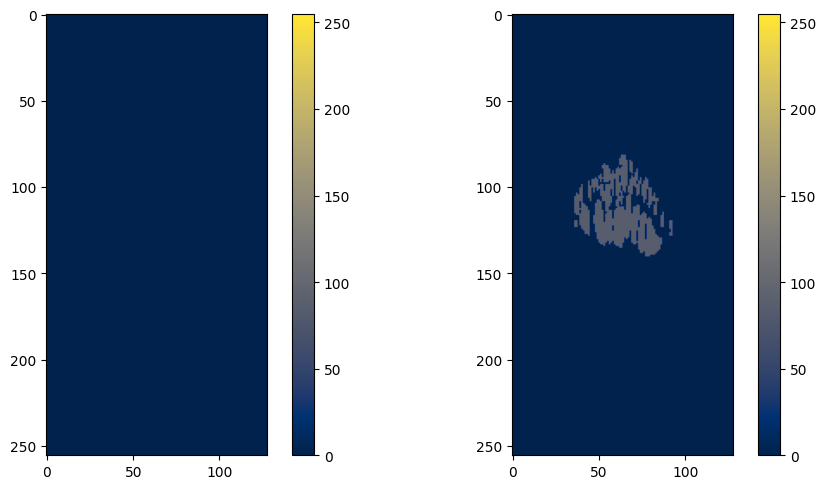

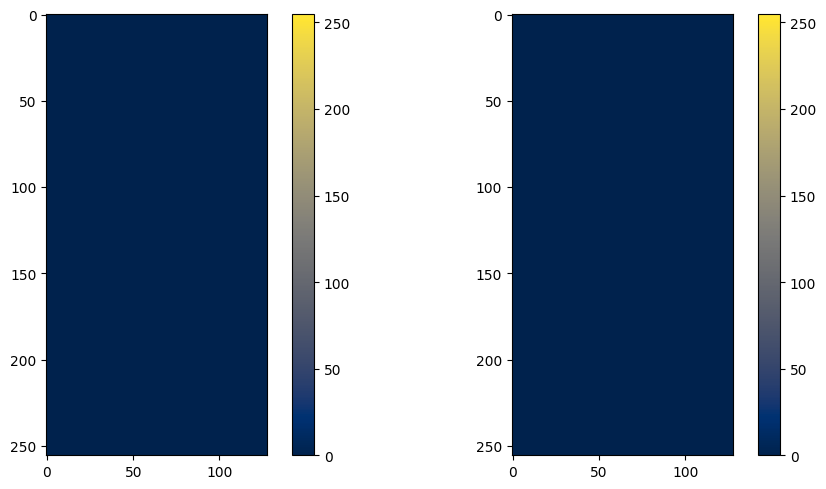

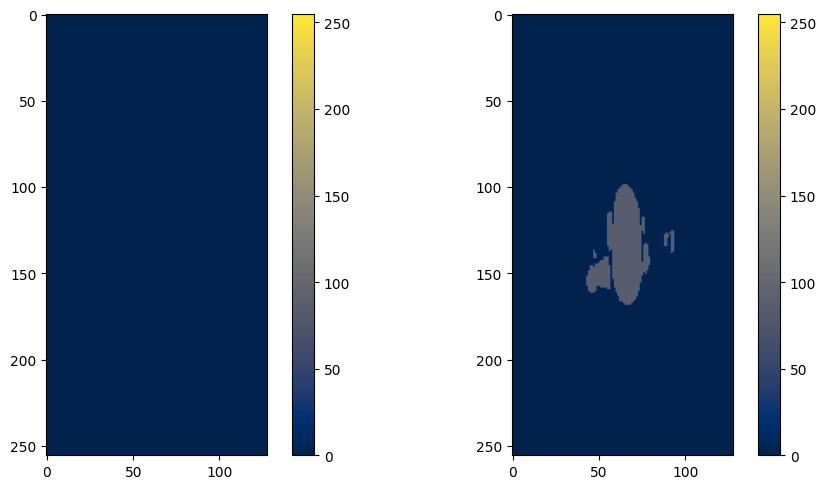

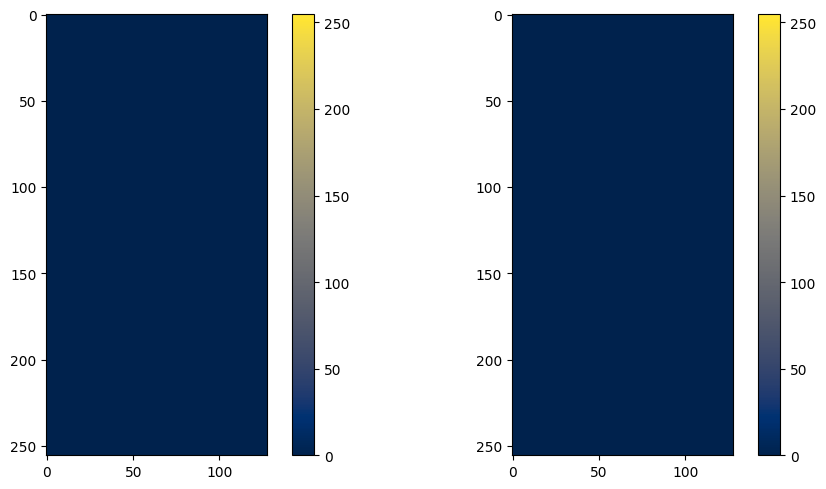

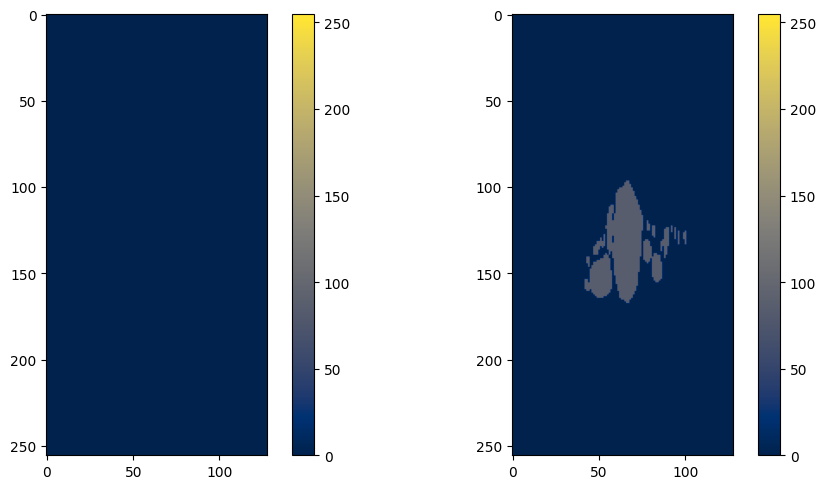

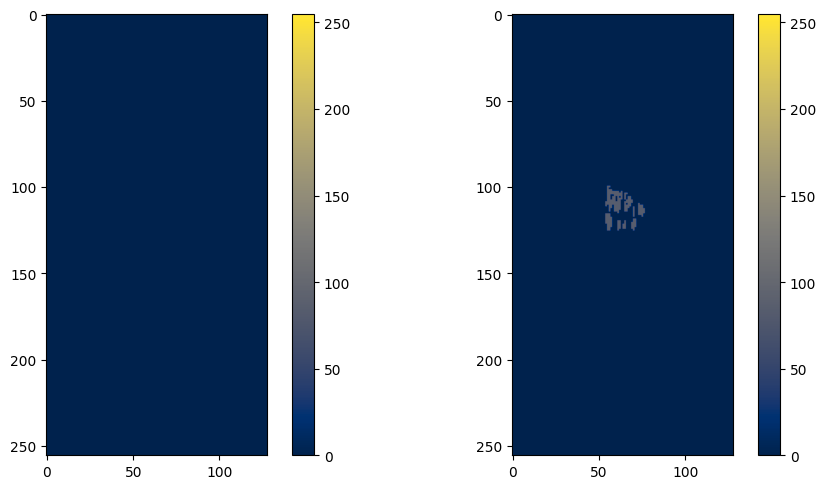

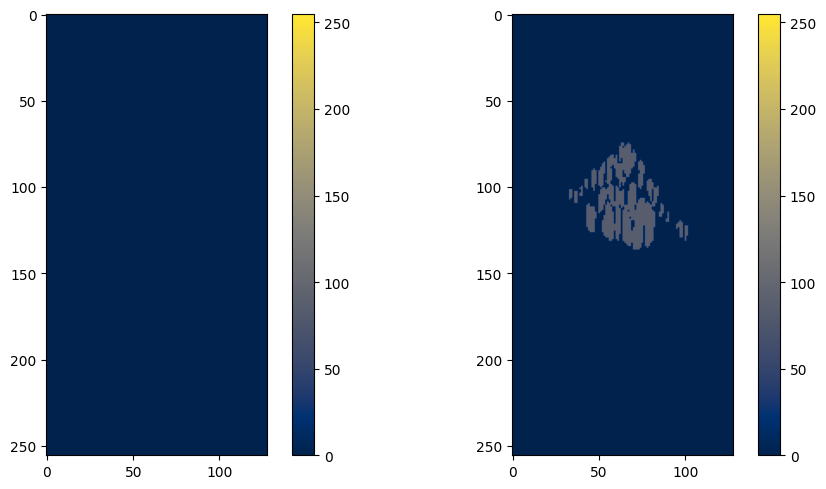

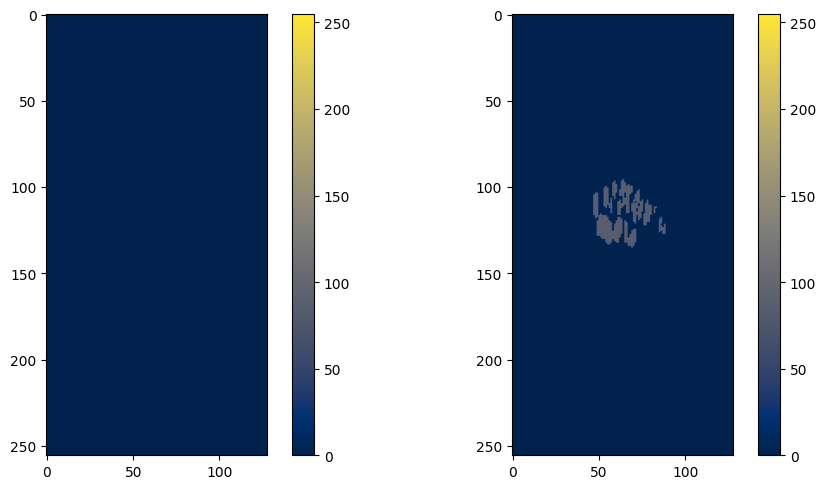

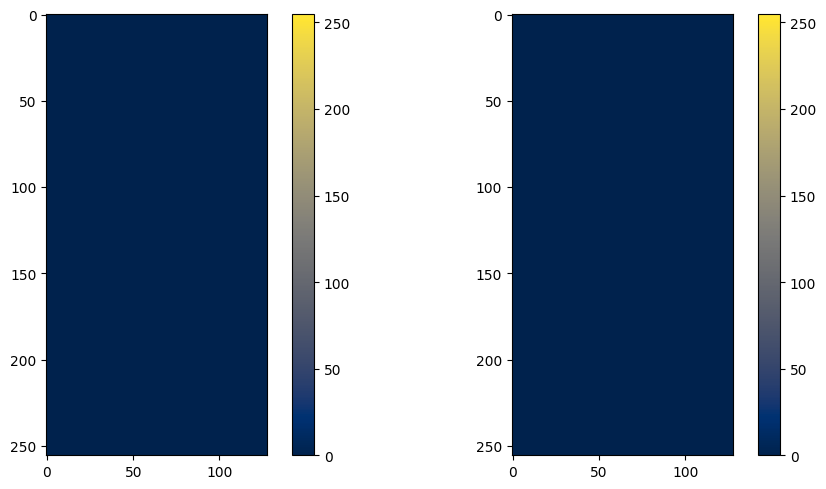

1024 ./Images/OCT/09_000.tif
1024 ./Images/Reference/09_000.tif
1025 ./Images/OCT/09_001.tif
1025 ./Images/Reference/09_001.tif
1026 ./Images/OCT/09_002.tif
1026 ./Images/Reference/09_002.tif
1027 ./Images/OCT/09_003.tif
1027 ./Images/Reference/09_003.tif
1028 ./Images/OCT/09_004.tif
1028 ./Images/Reference/09_004.tif
1029 ./Images/OCT/09_005.tif
1029 ./Images/Reference/09_005.tif
1030 ./Images/OCT/09_006.tif
1030 ./Images/Reference/09_006.tif
1031 ./Images/OCT/09_007.tif
1031 ./Images/Reference/09_007.tif
1032 ./Images/OCT/09_008.tif
1032 ./Images/Reference/09_008.tif
1033 ./Images/OCT/09_009.tif
1033 ./Images/Reference/09_009.tif
1034 ./Images/OCT/09_010.tif
1034 ./Images/Reference/09_010.tif
1035 ./Images/OCT/09_011.tif
1035 ./Images/Reference/09_011.tif
1036 ./Images/OCT/09_012.tif
1036 ./Images/Reference/09_012.tif
1037 ./Images/OCT/09_013.tif
1037 ./Images/Reference/09_013.tif
1038 ./Images/OCT/09_014.tif
1038 ./Images/Reference/09_014.tif
1039 ./Images/OCT/09_015.tif
1039 ./Imag

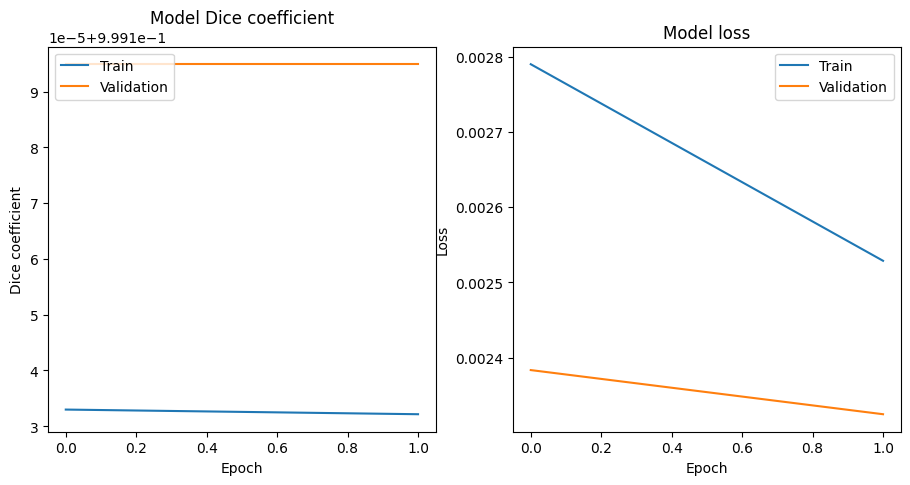

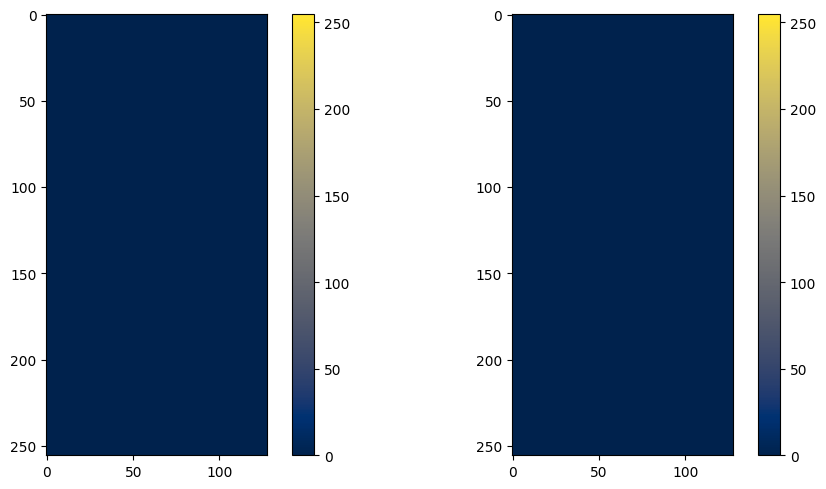

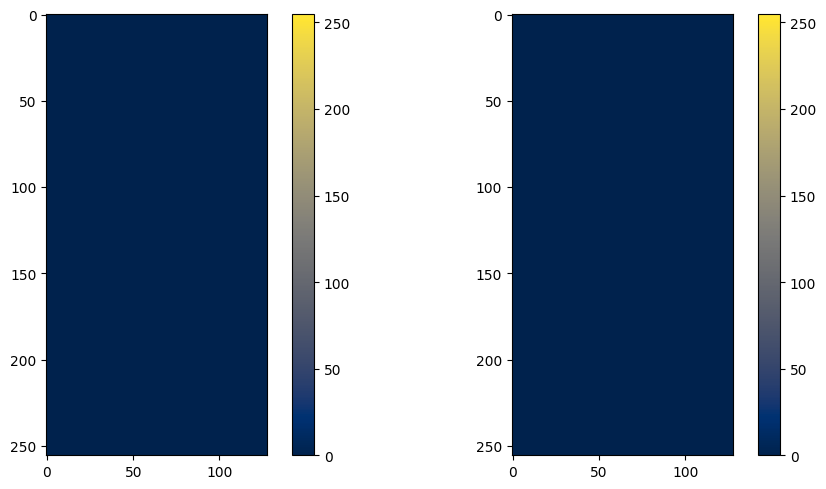

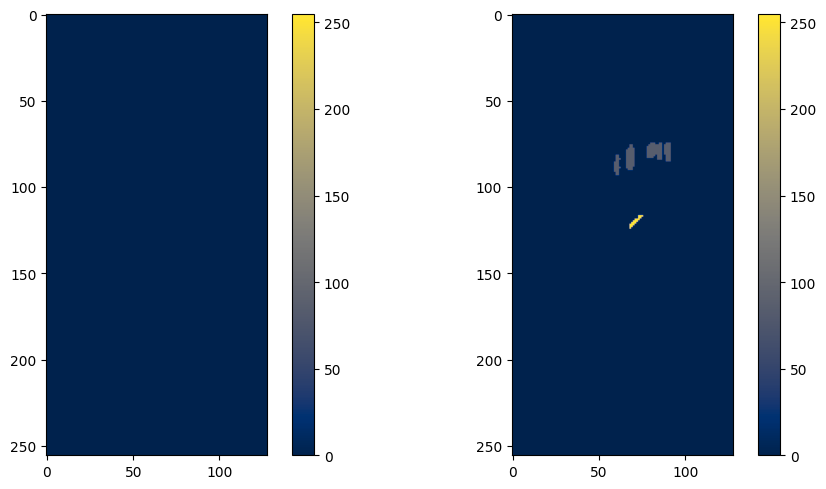

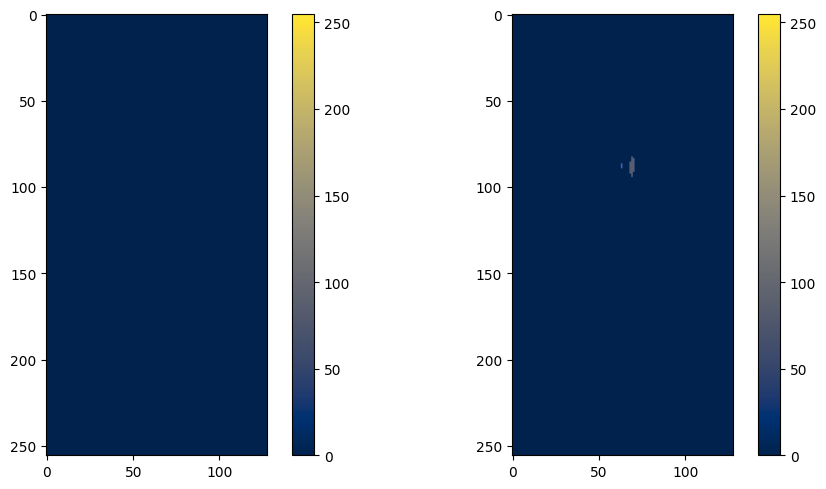

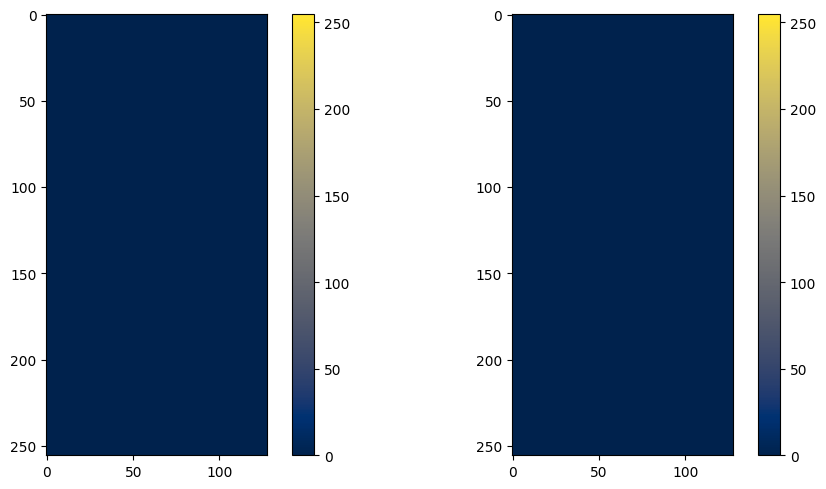

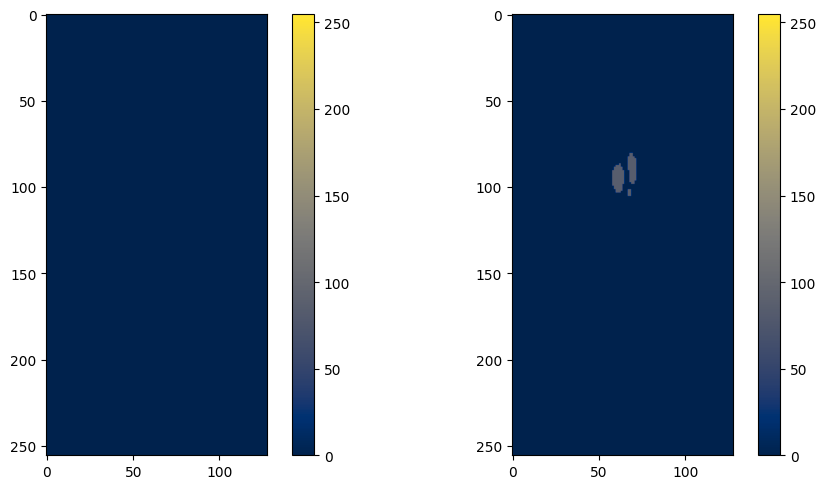

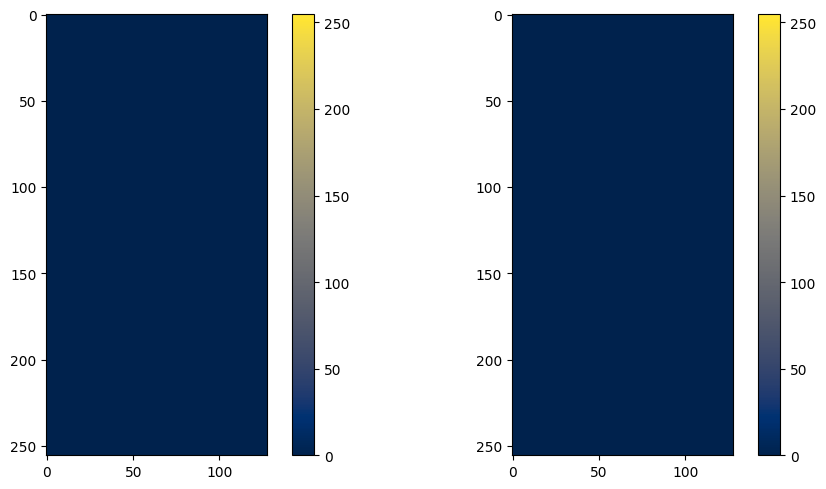

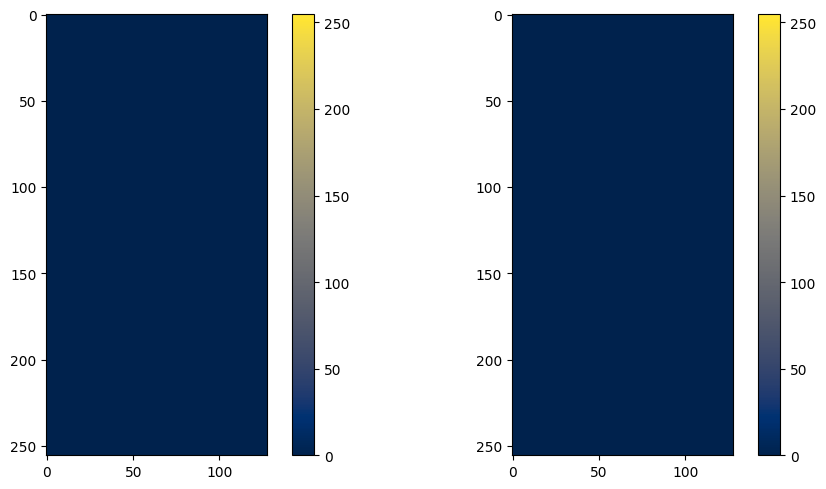

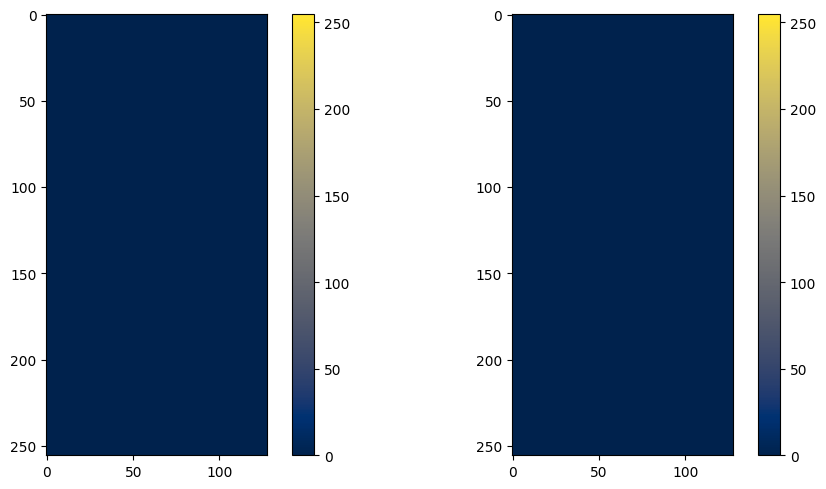

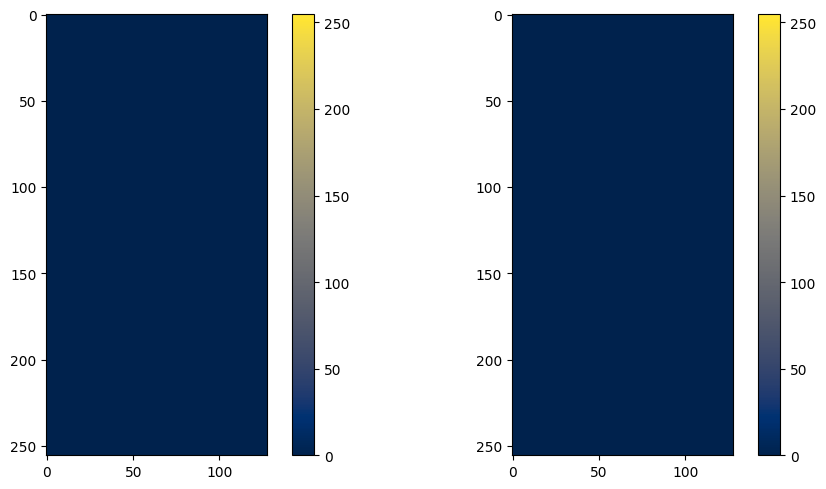

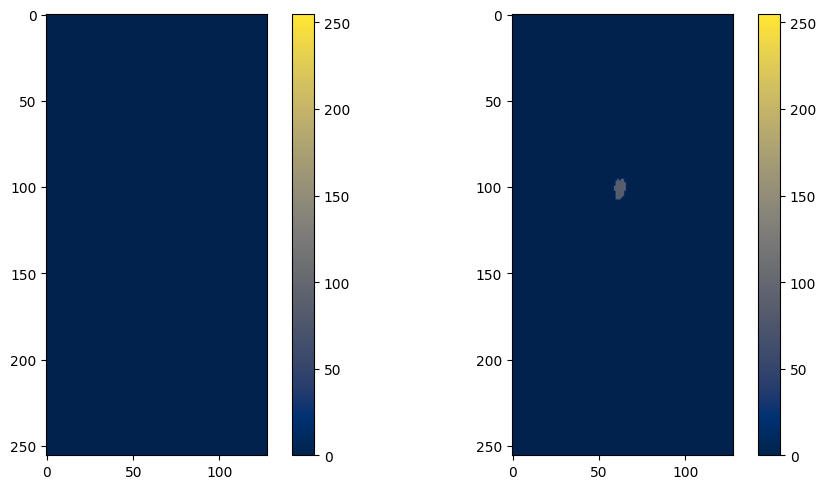

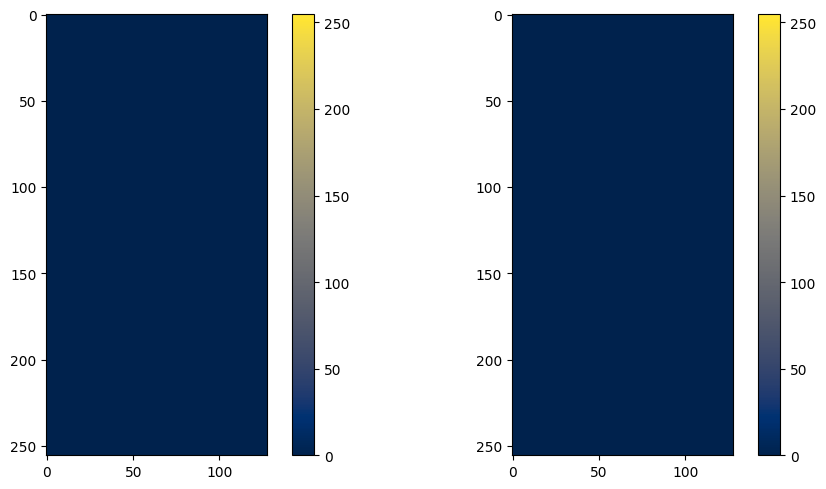

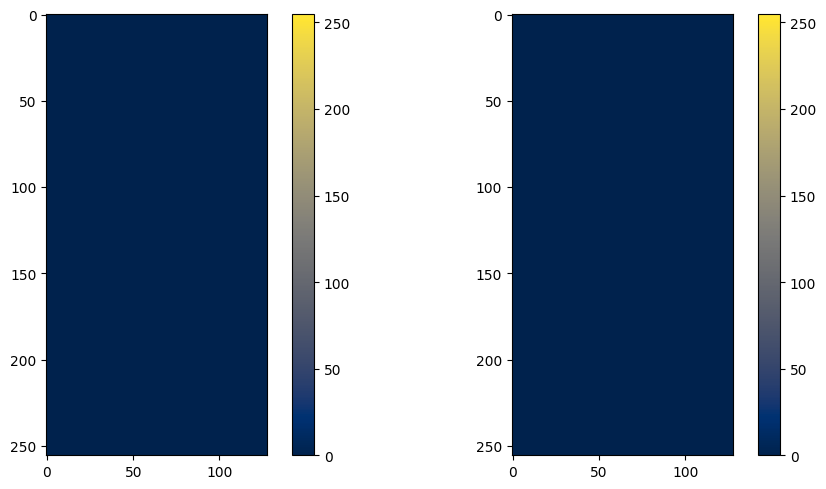

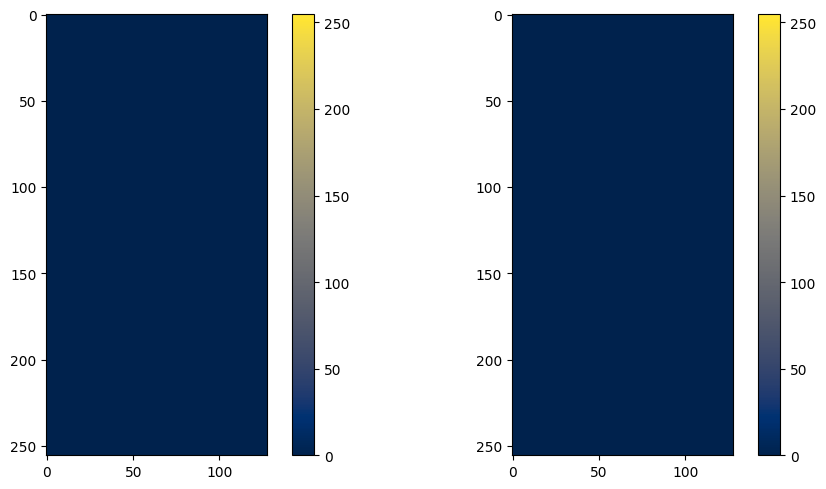

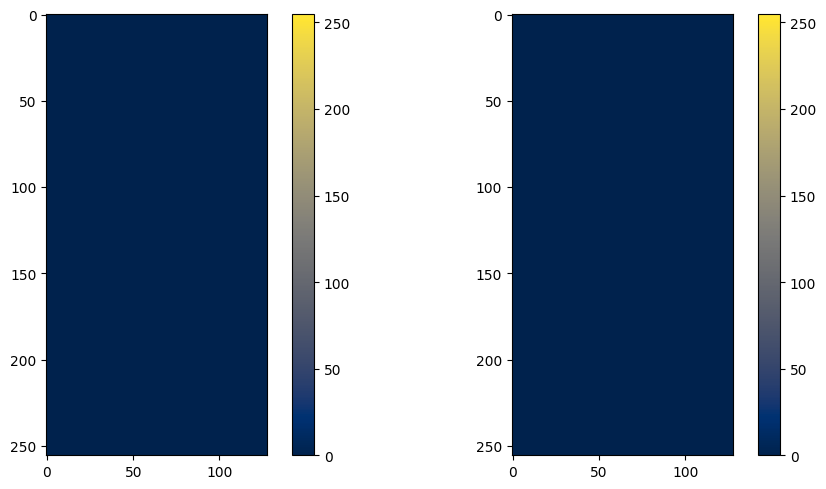

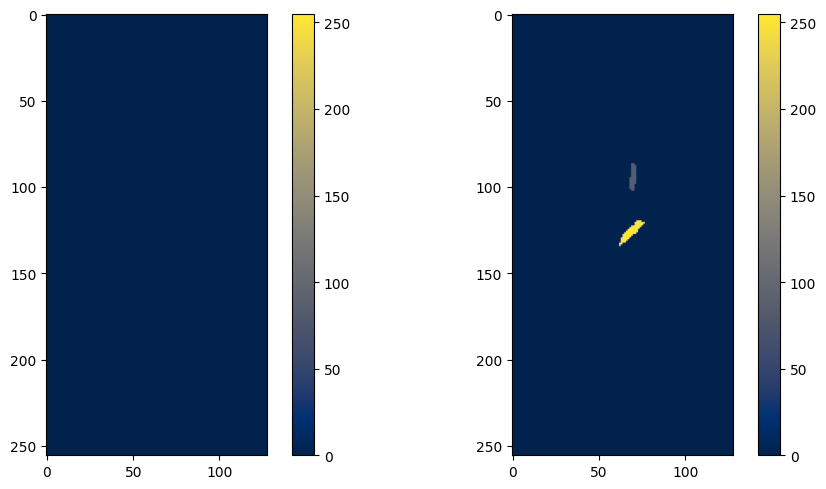

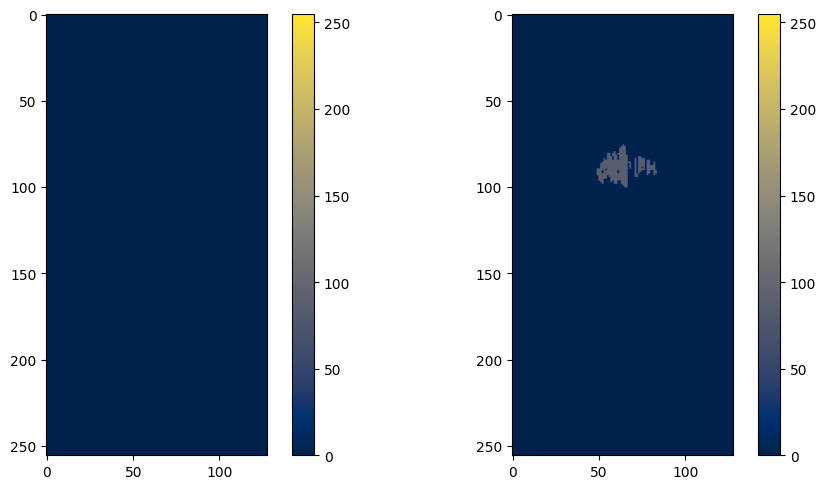

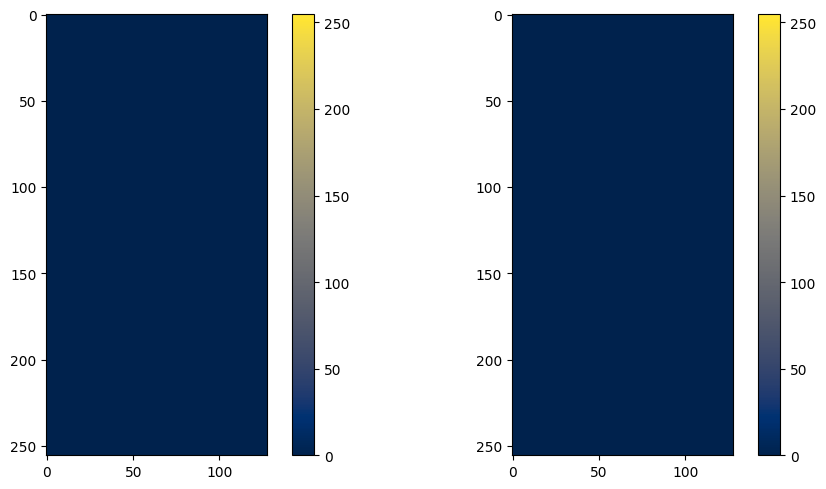

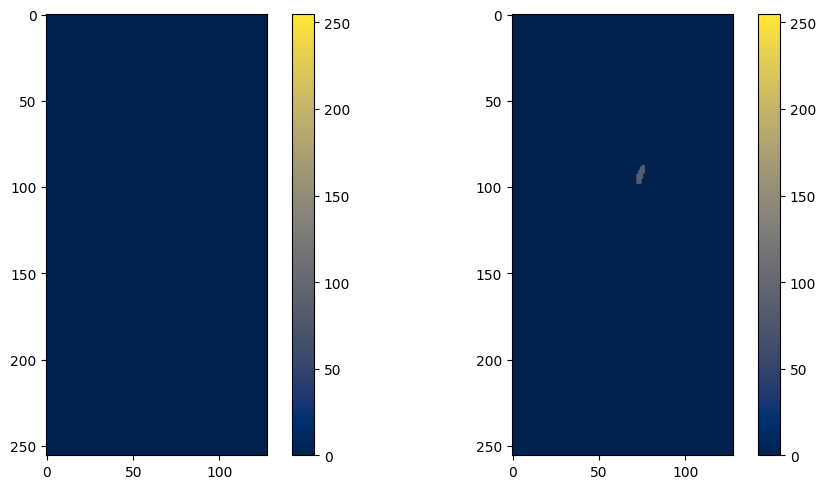

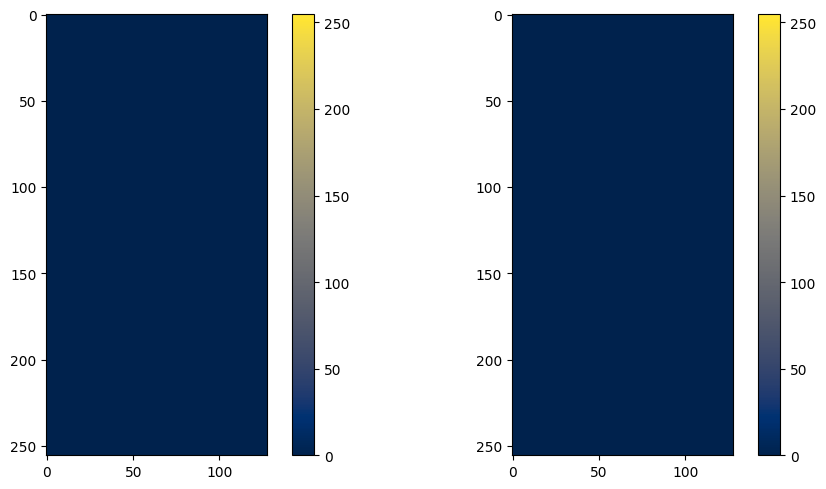

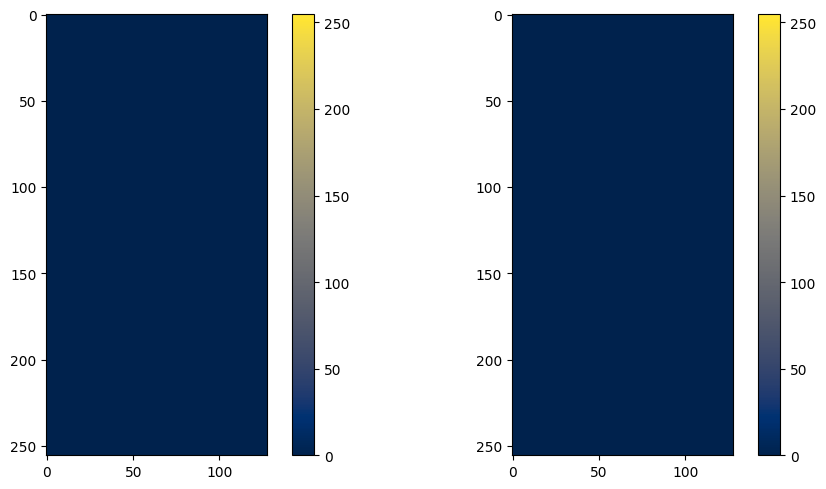

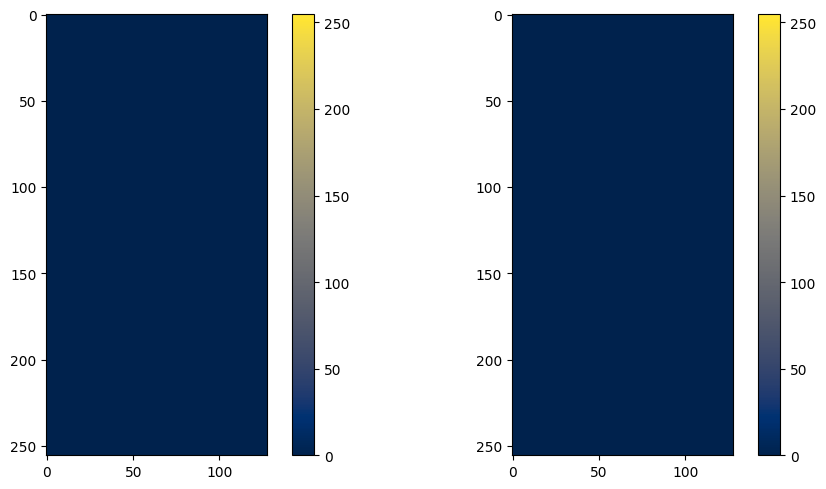

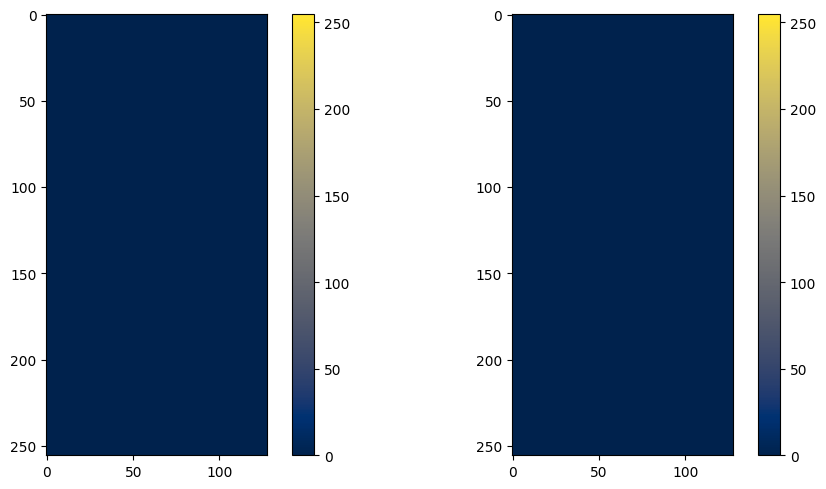

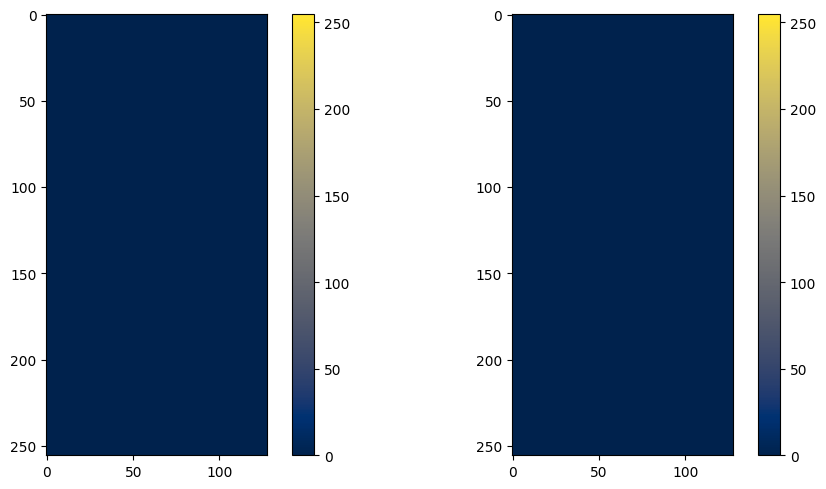

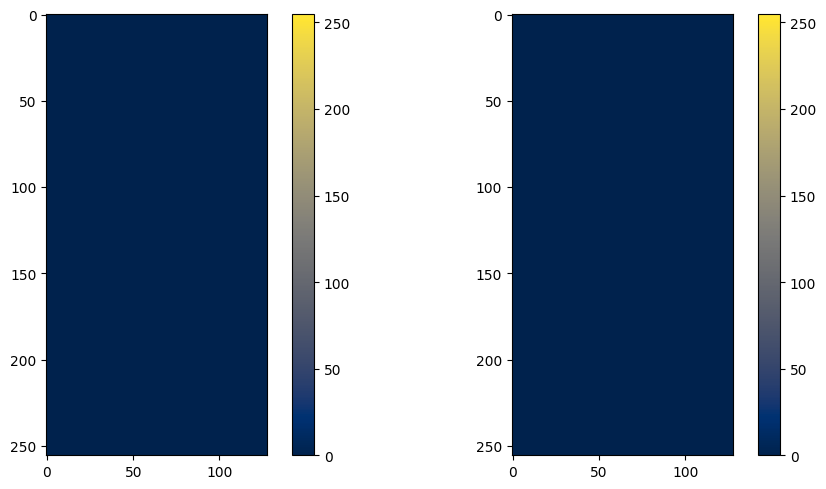

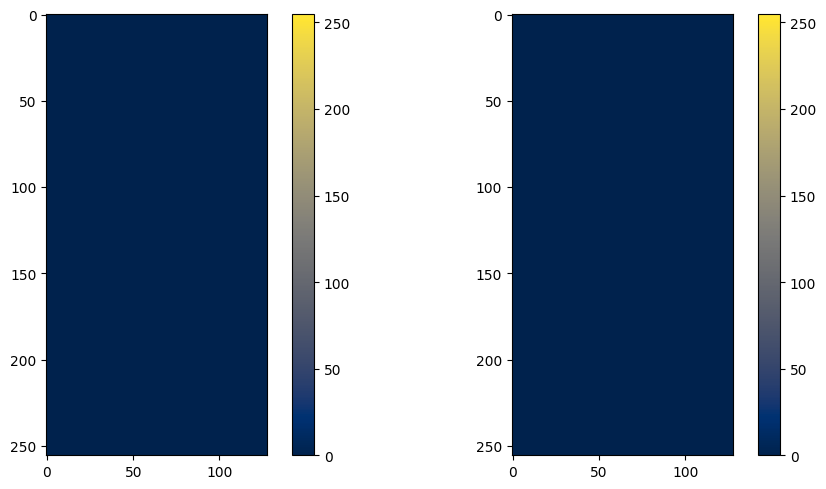

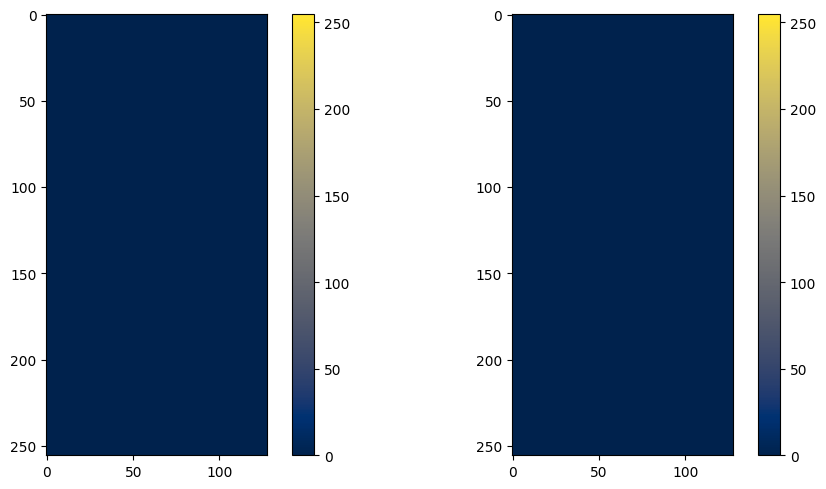

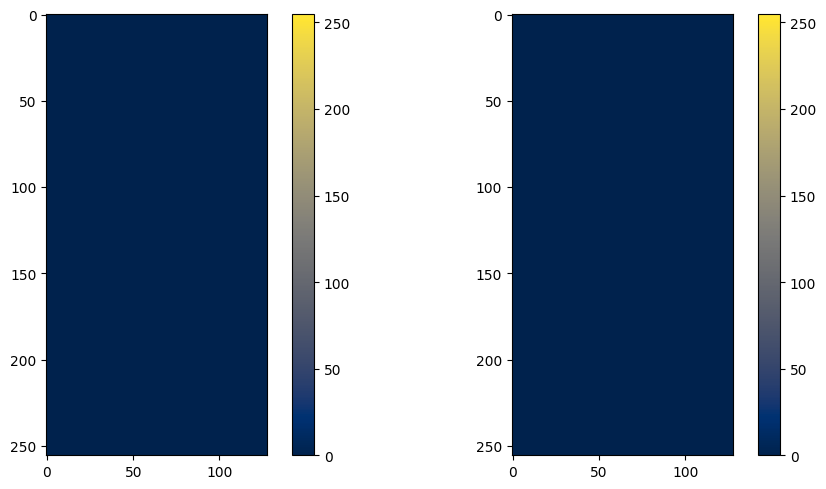

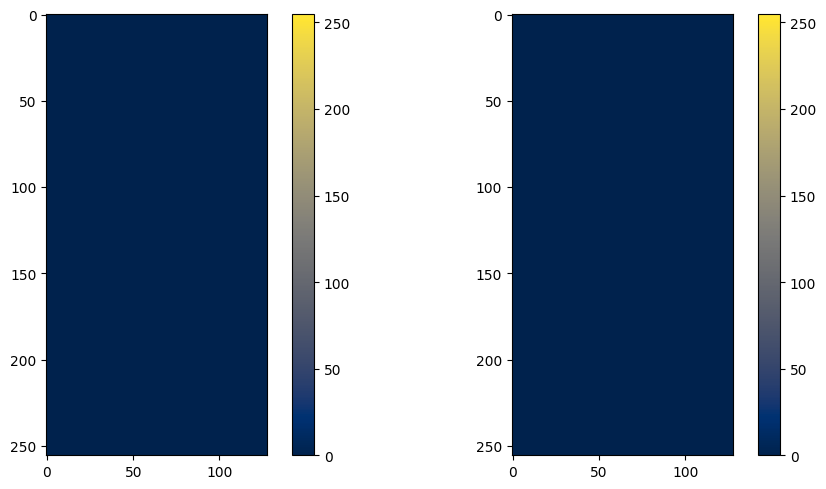

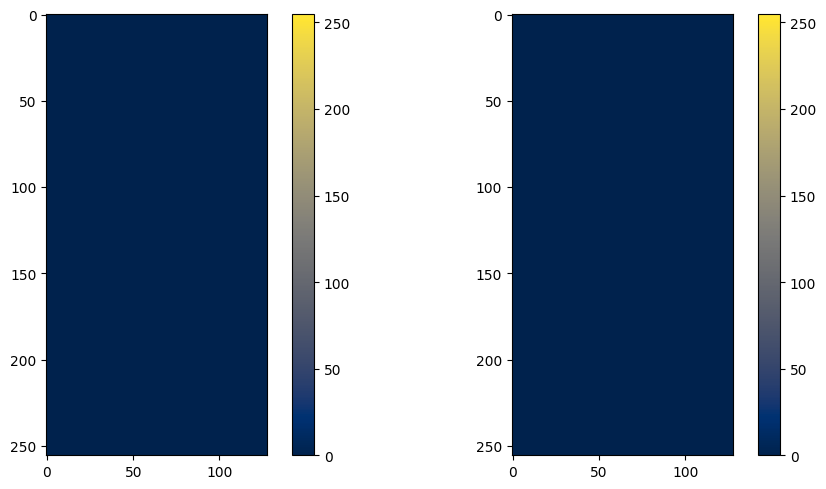

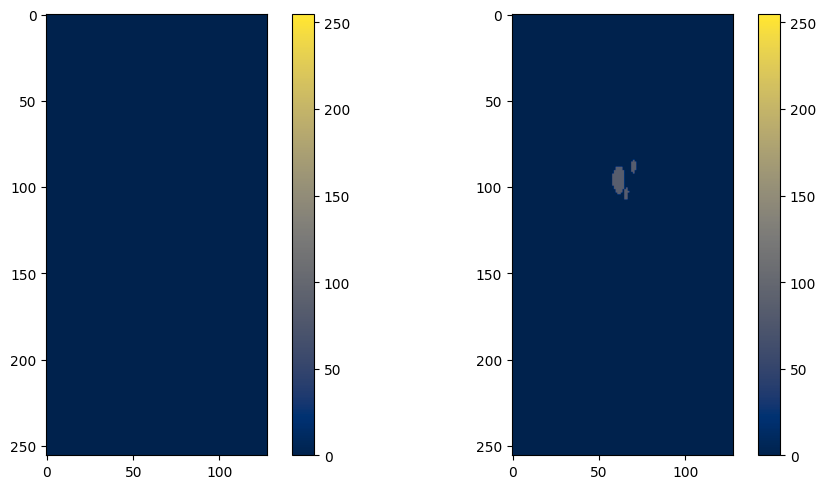

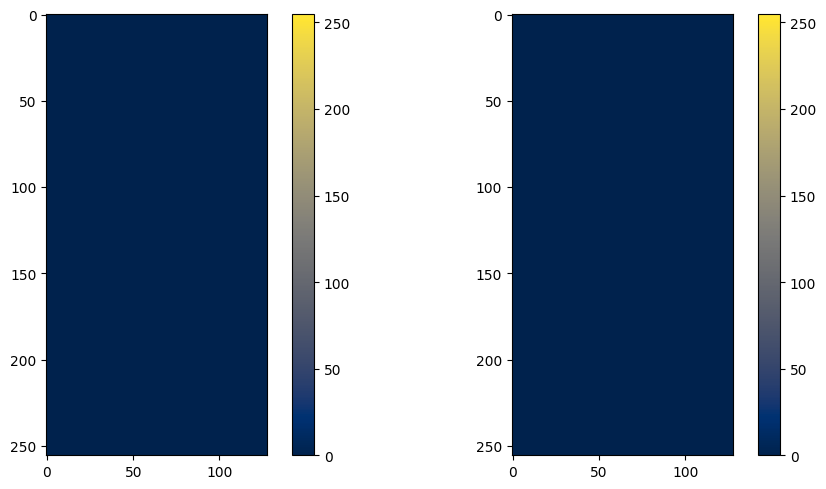

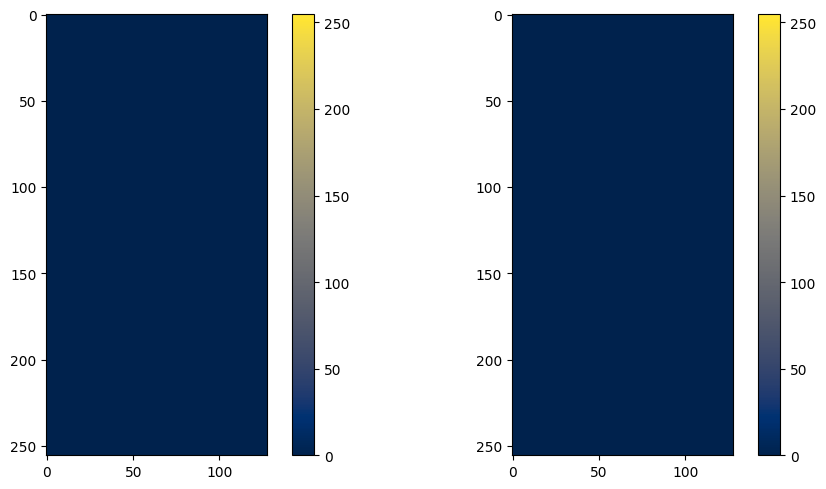

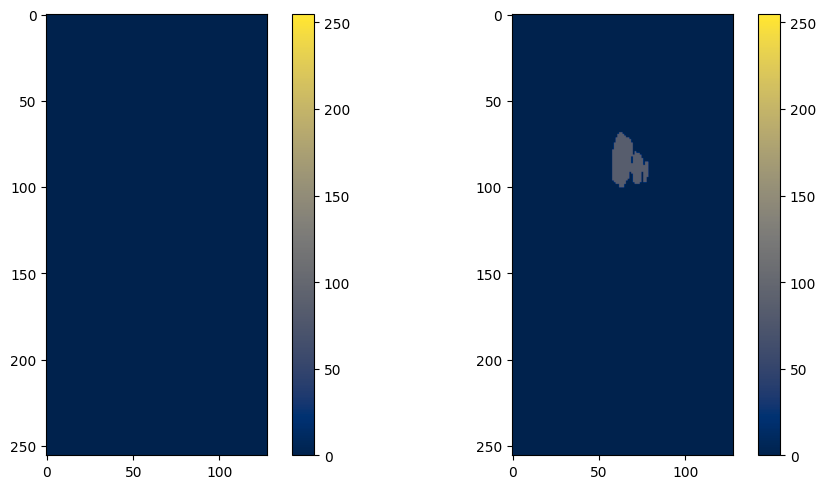

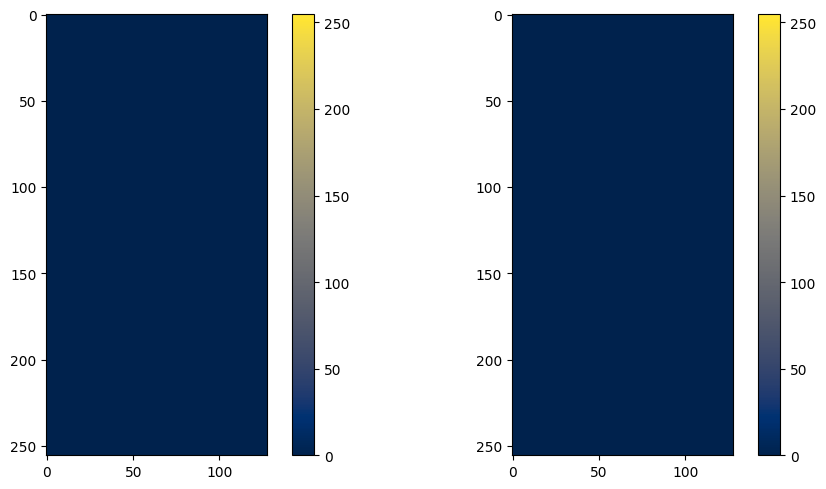

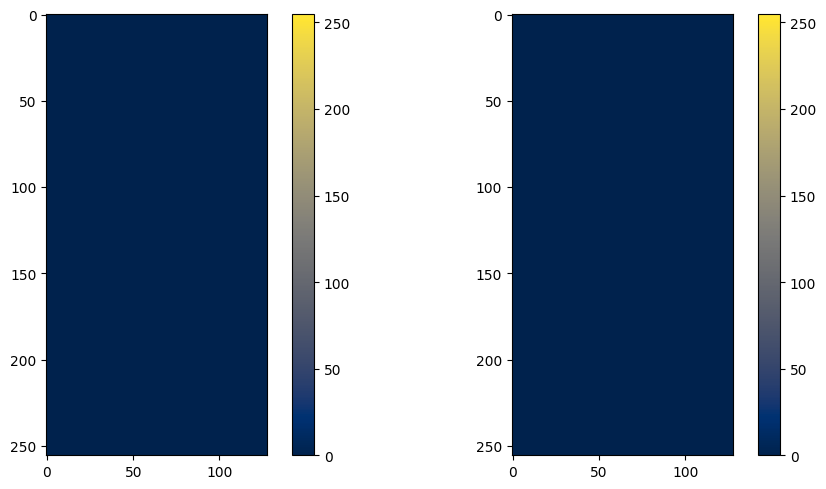

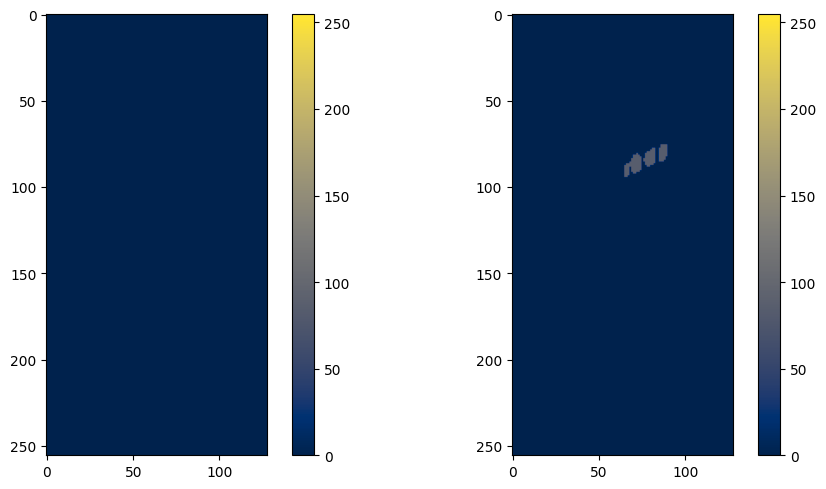

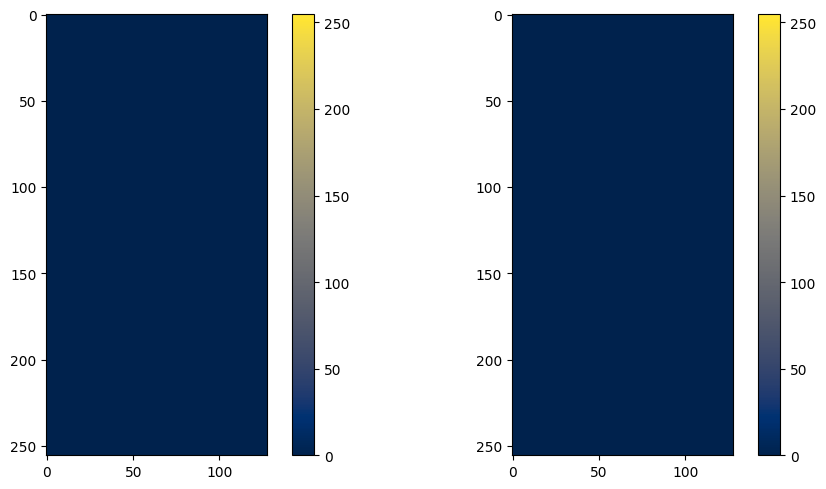

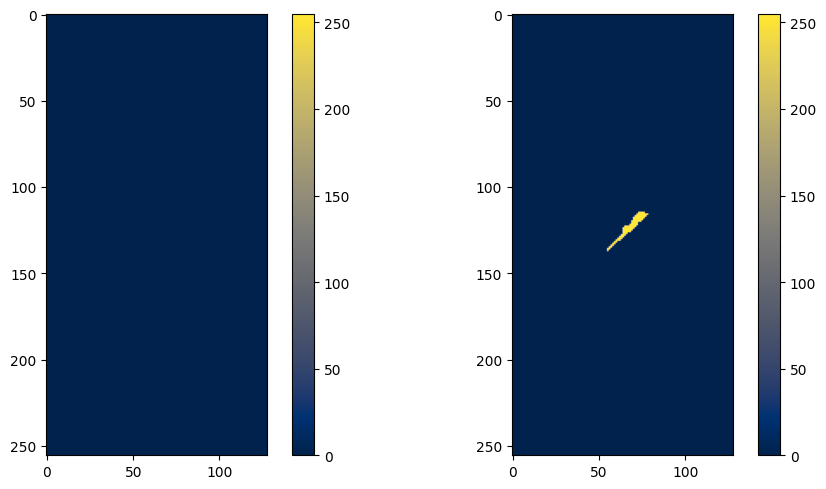

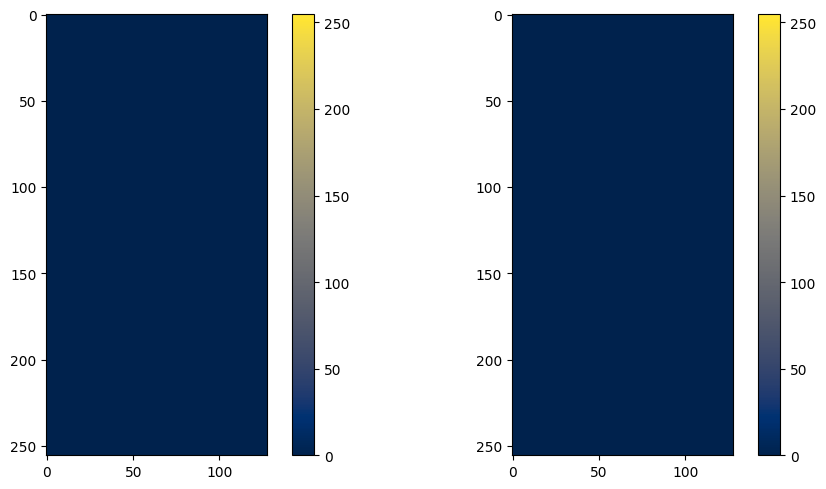

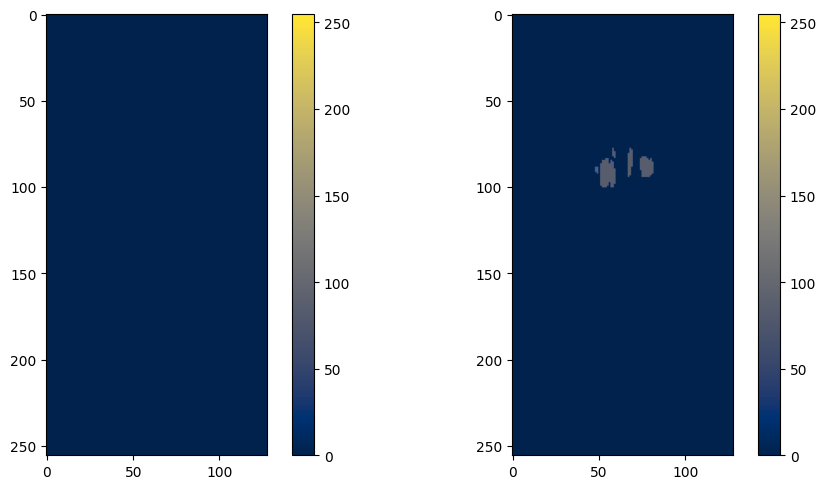

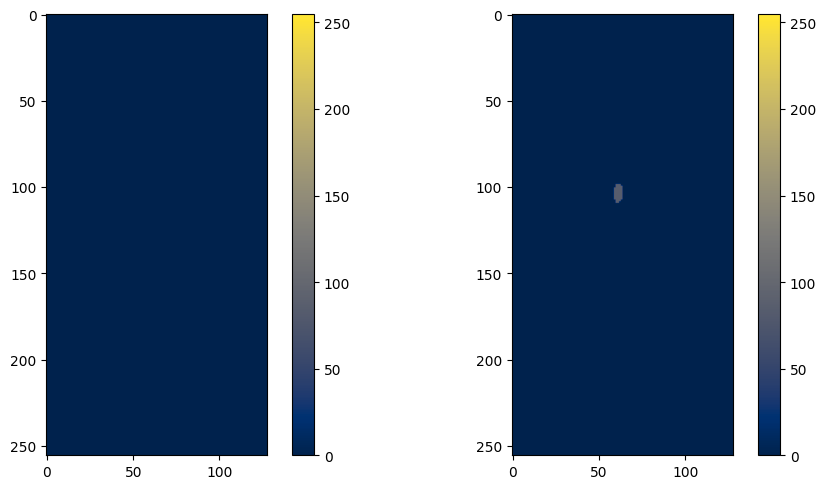

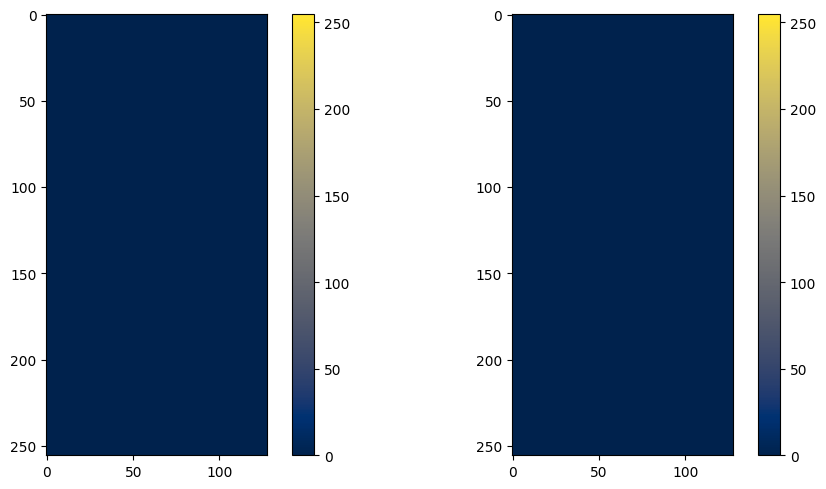

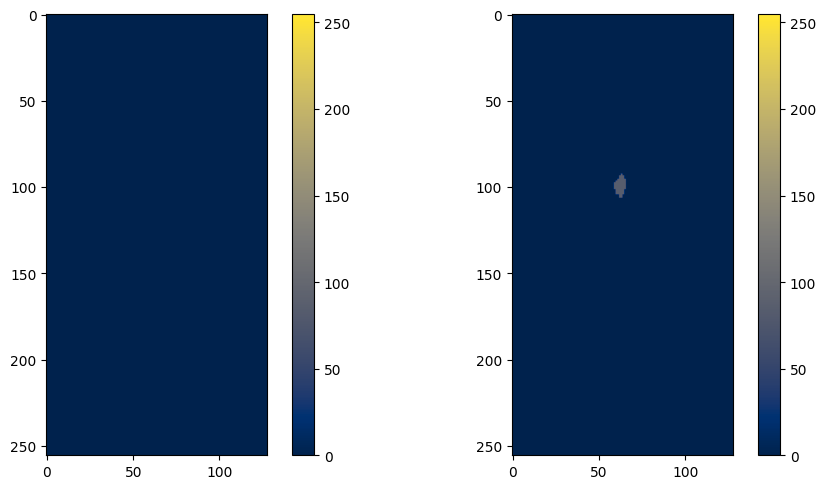

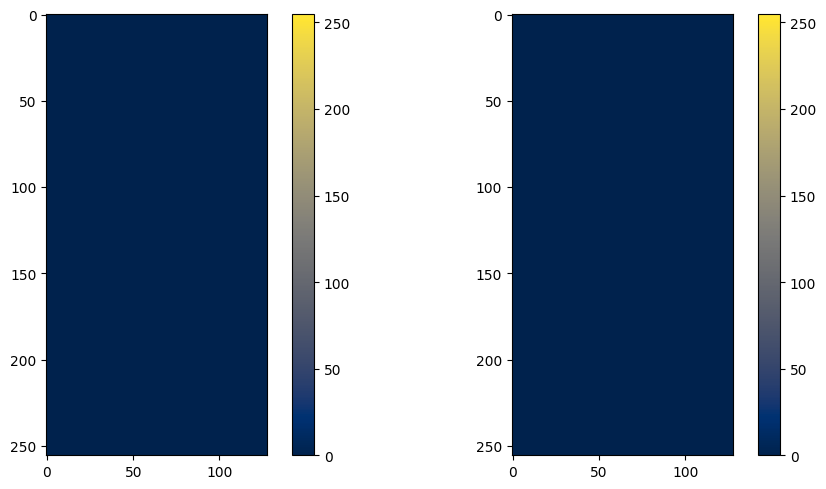

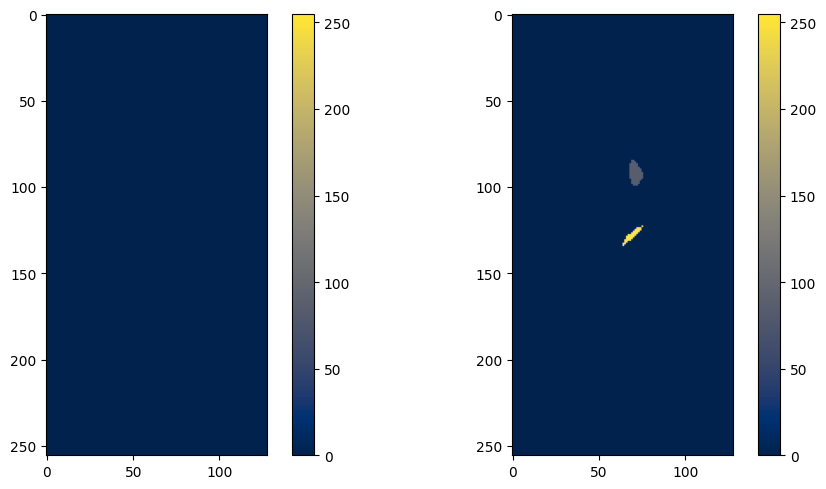

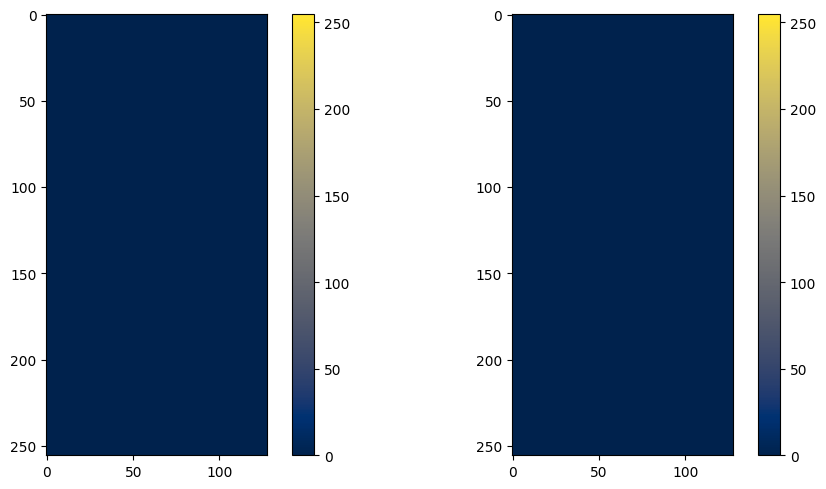

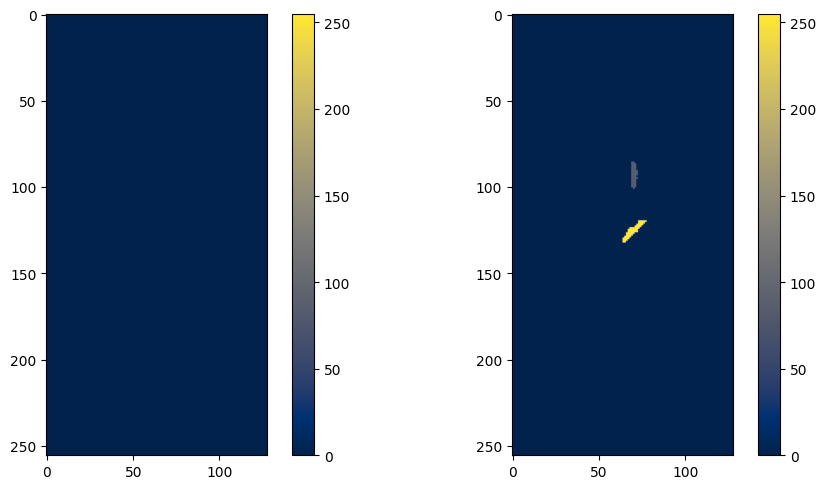

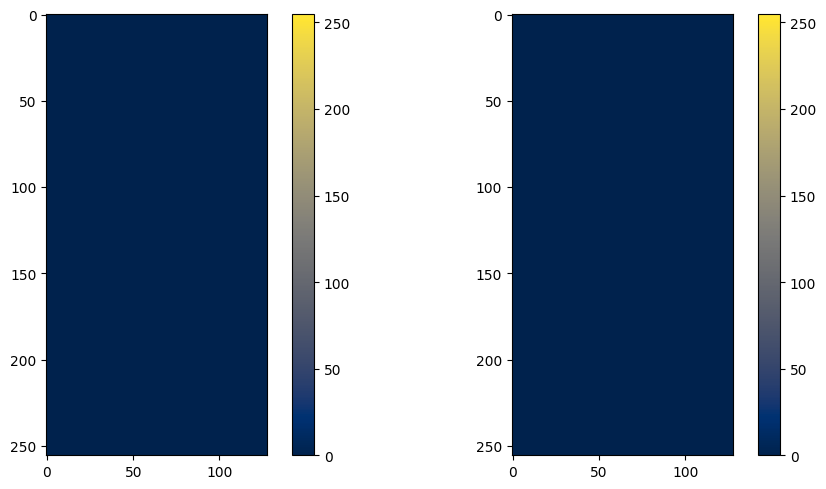

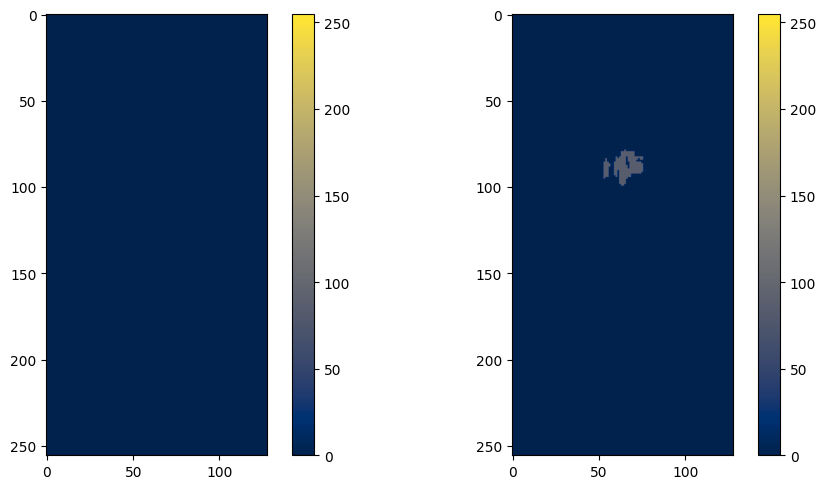

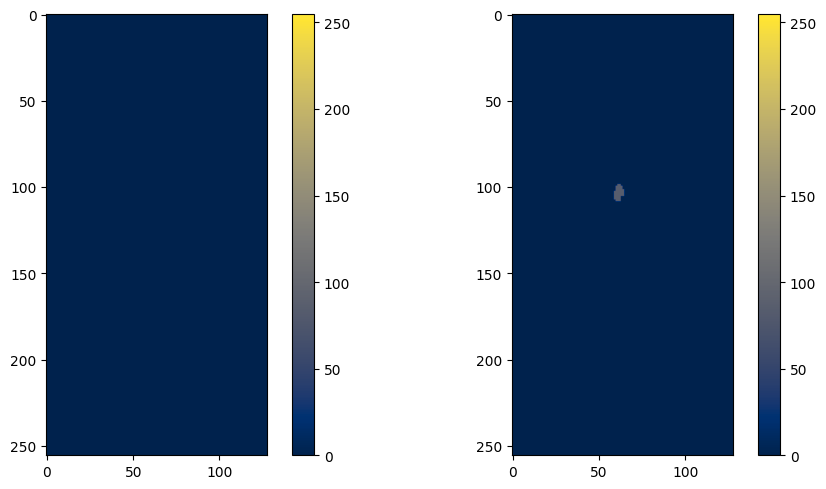

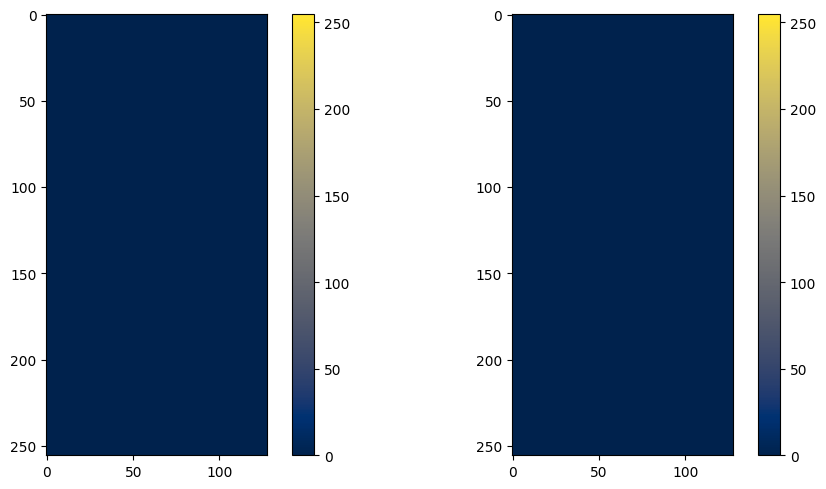

1280 ./Images/OCT/11_000.tif
1280 ./Images/Reference/11_000.tif
1281 ./Images/OCT/11_001.tif
1281 ./Images/Reference/11_001.tif
1282 ./Images/OCT/11_002.tif
1282 ./Images/Reference/11_002.tif
1283 ./Images/OCT/11_003.tif
1283 ./Images/Reference/11_003.tif
1284 ./Images/OCT/11_004.tif
1284 ./Images/Reference/11_004.tif
1285 ./Images/OCT/11_005.tif
1285 ./Images/Reference/11_005.tif
1286 ./Images/OCT/11_006.tif
1286 ./Images/Reference/11_006.tif
1287 ./Images/OCT/11_007.tif
1287 ./Images/Reference/11_007.tif
1288 ./Images/OCT/11_008.tif
1288 ./Images/Reference/11_008.tif
1289 ./Images/OCT/11_009.tif
1289 ./Images/Reference/11_009.tif
1290 ./Images/OCT/11_010.tif
1290 ./Images/Reference/11_010.tif
1291 ./Images/OCT/11_011.tif
1291 ./Images/Reference/11_011.tif
1292 ./Images/OCT/11_012.tif
1292 ./Images/Reference/11_012.tif
1293 ./Images/OCT/11_013.tif
1293 ./Images/Reference/11_013.tif
1294 ./Images/OCT/11_014.tif
1294 ./Images/Reference/11_014.tif
1295 ./Images/OCT/11_015.tif
1295 ./Imag

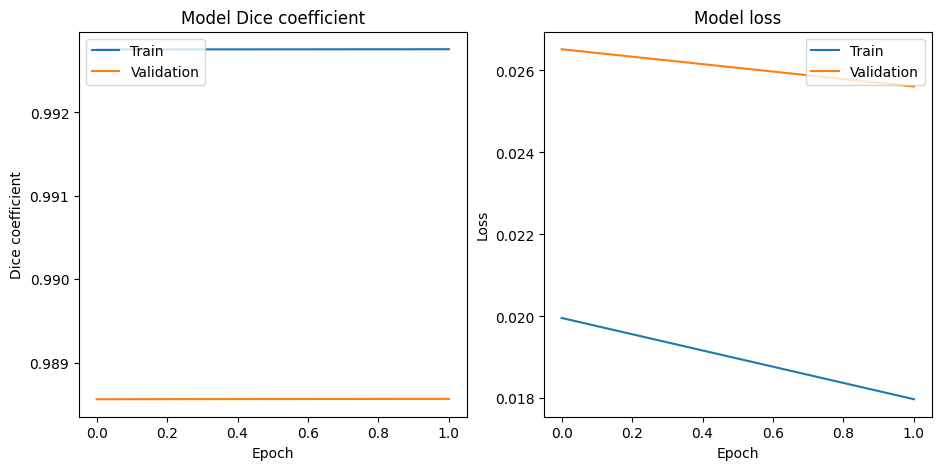

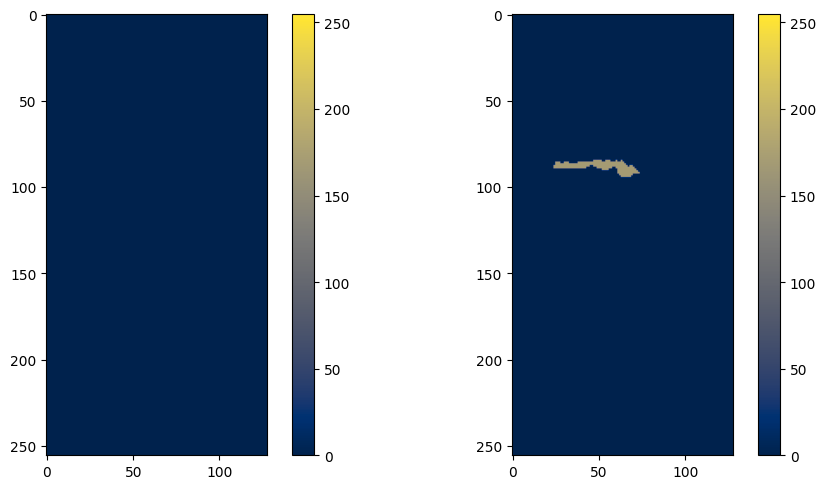

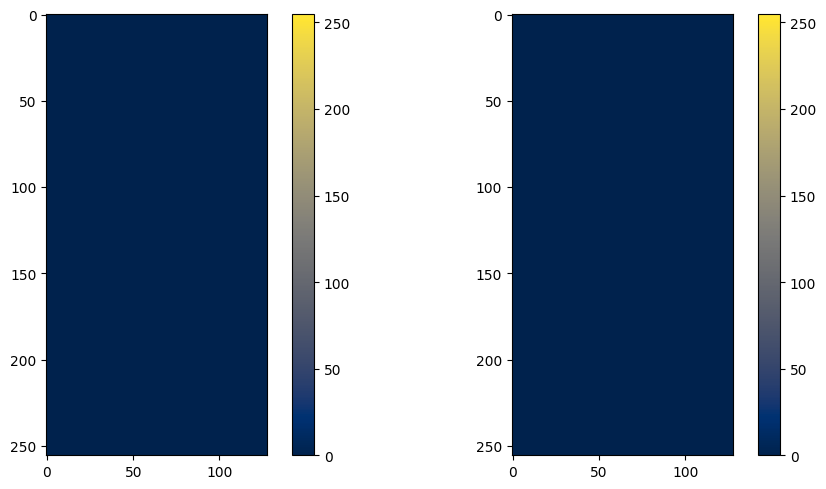

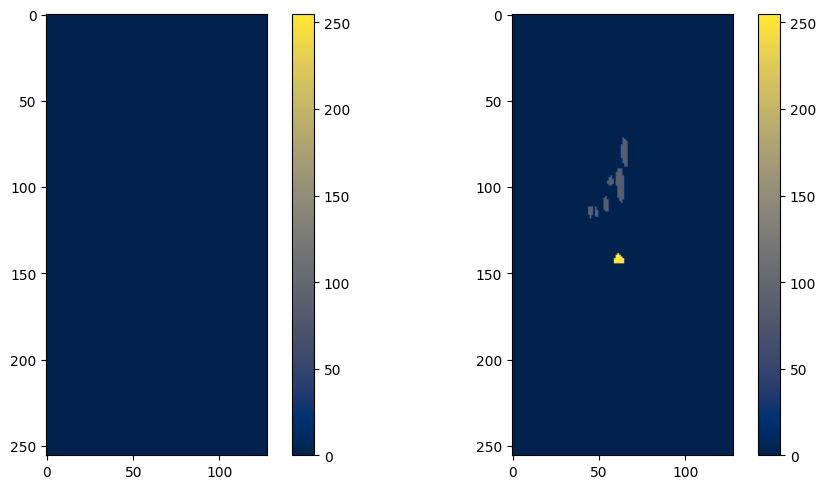

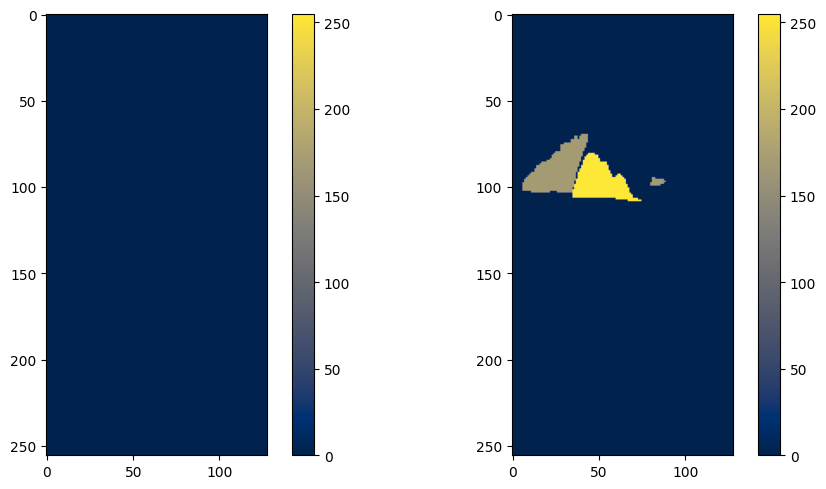

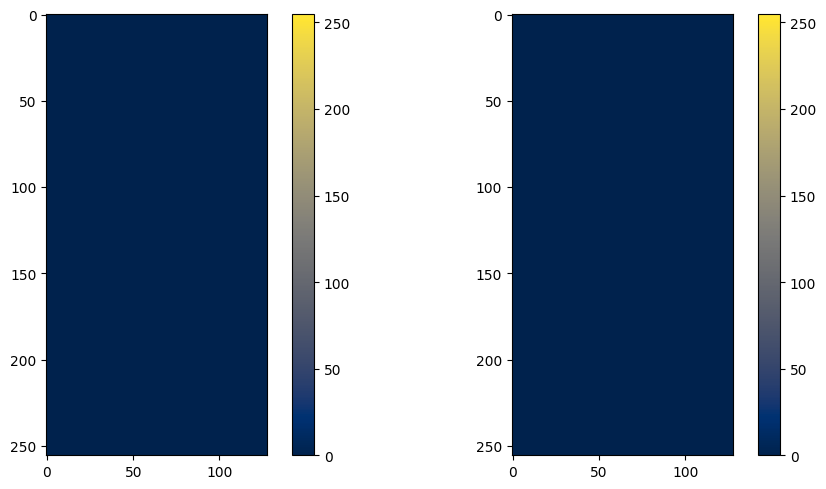

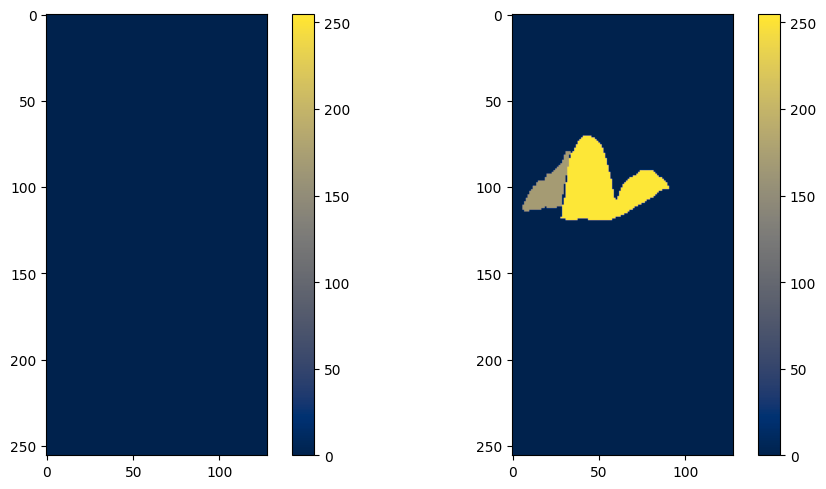

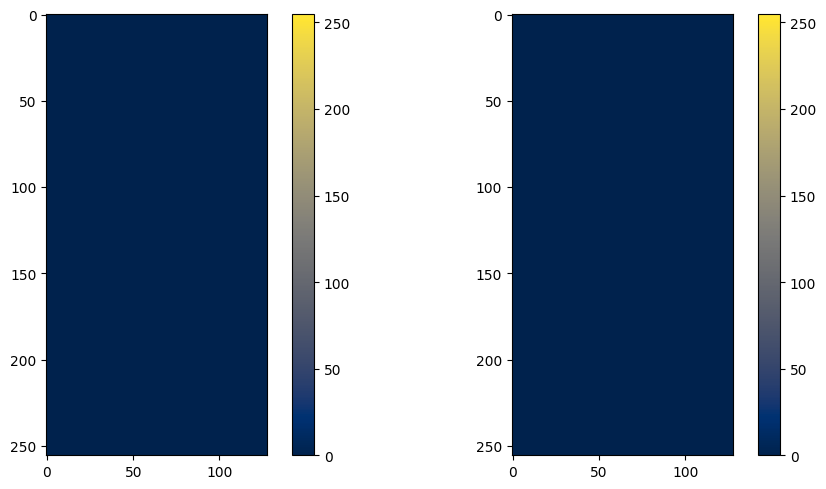

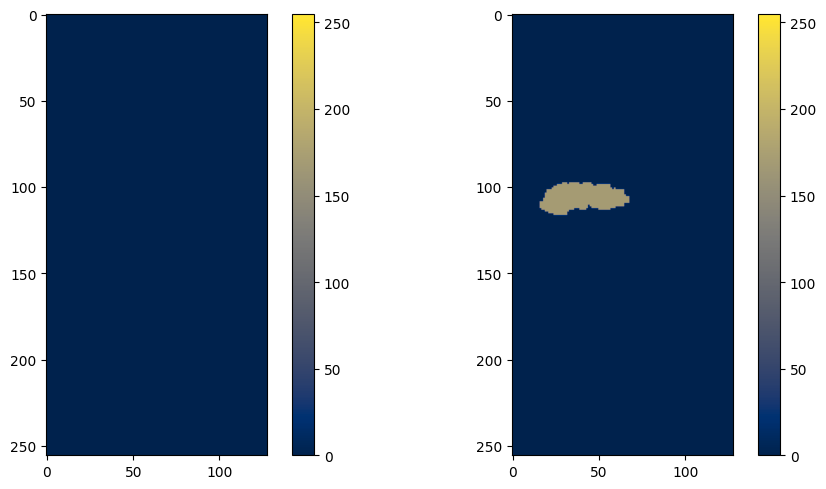

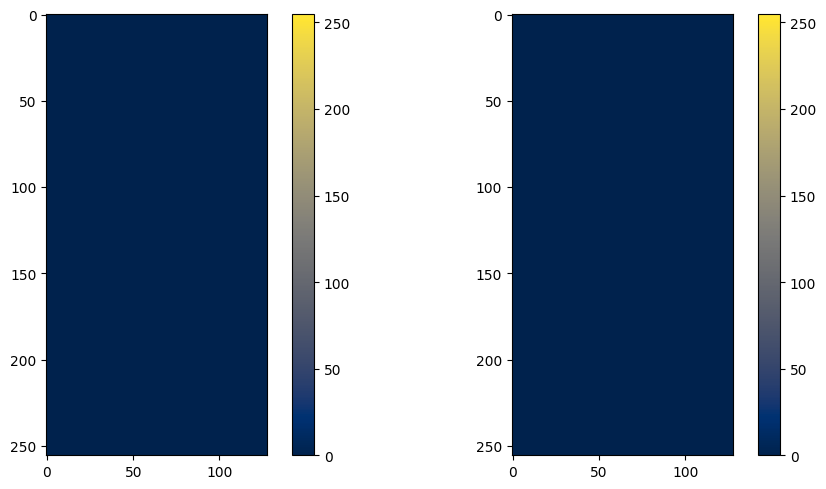

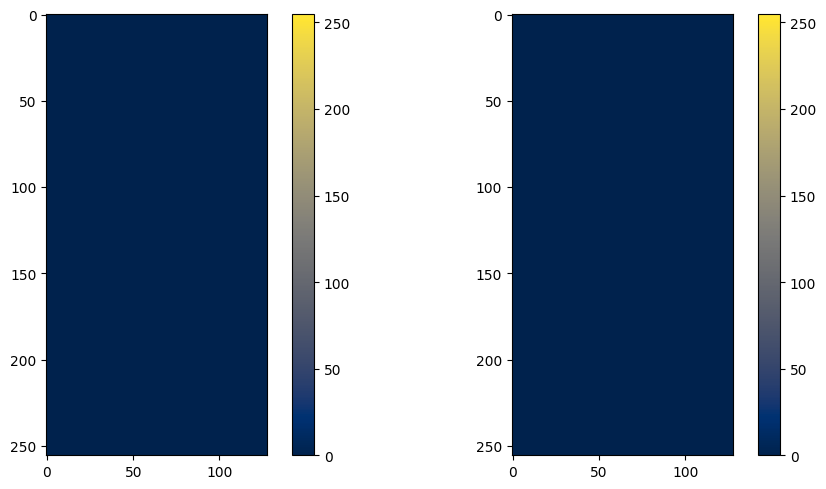

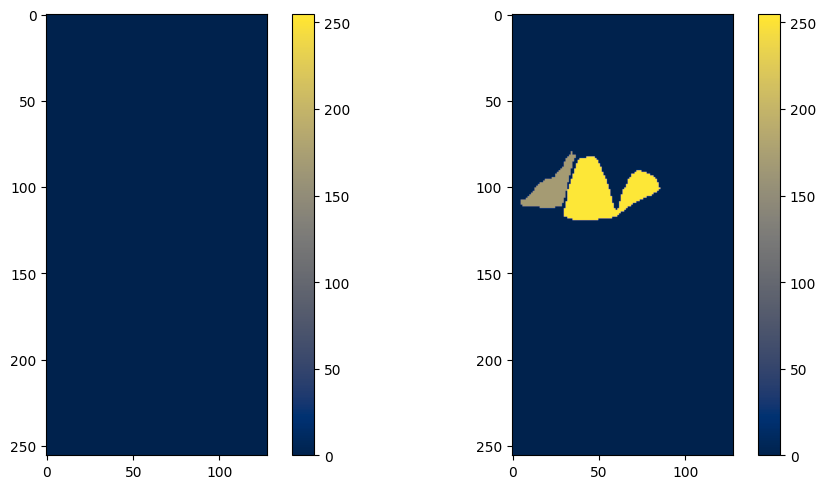

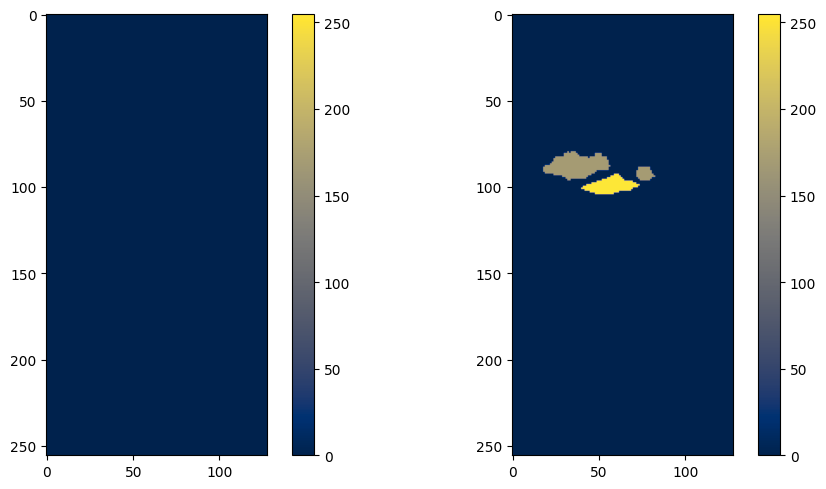

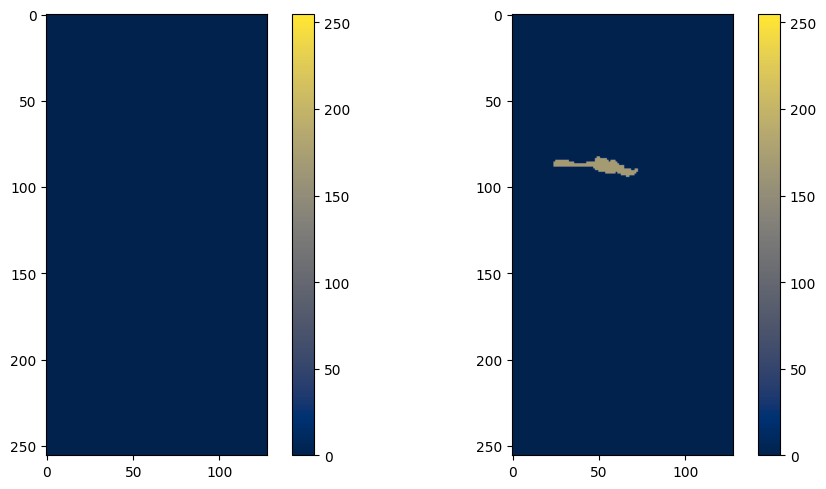

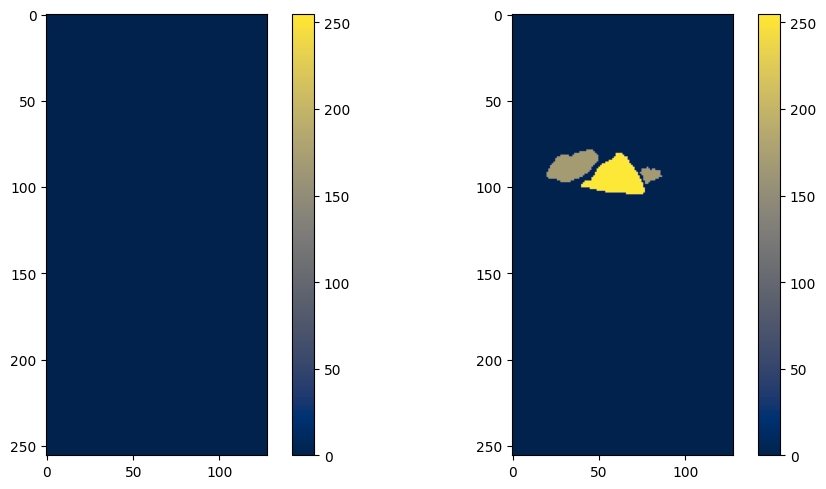

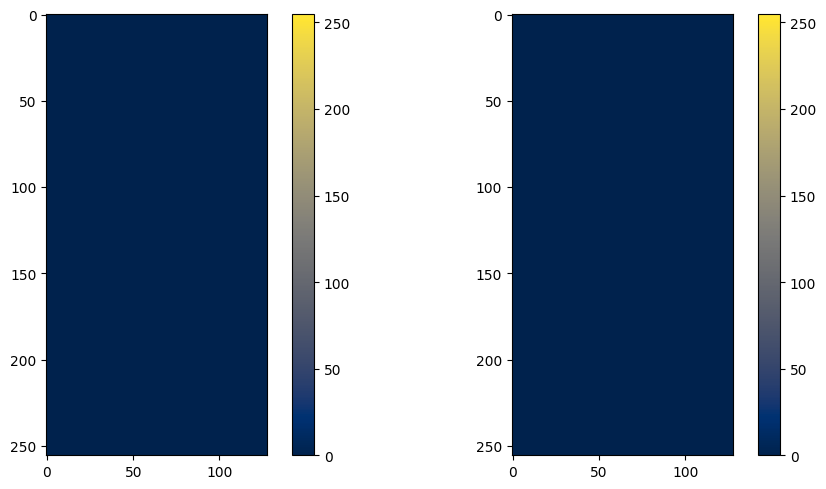

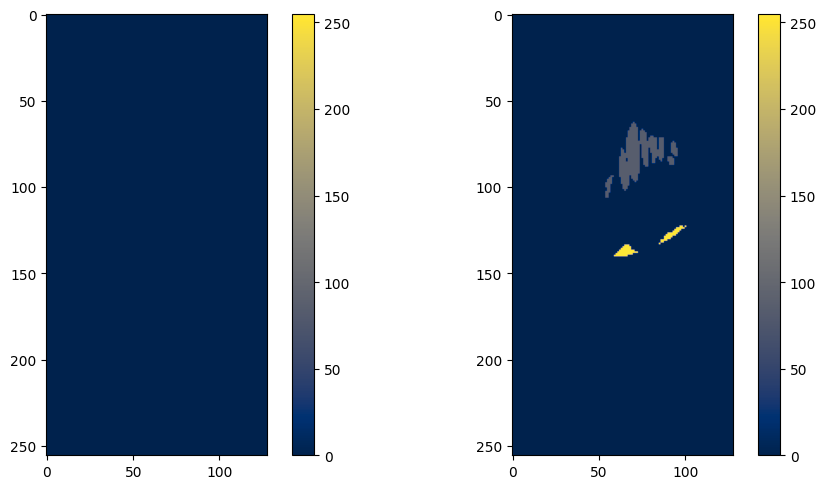

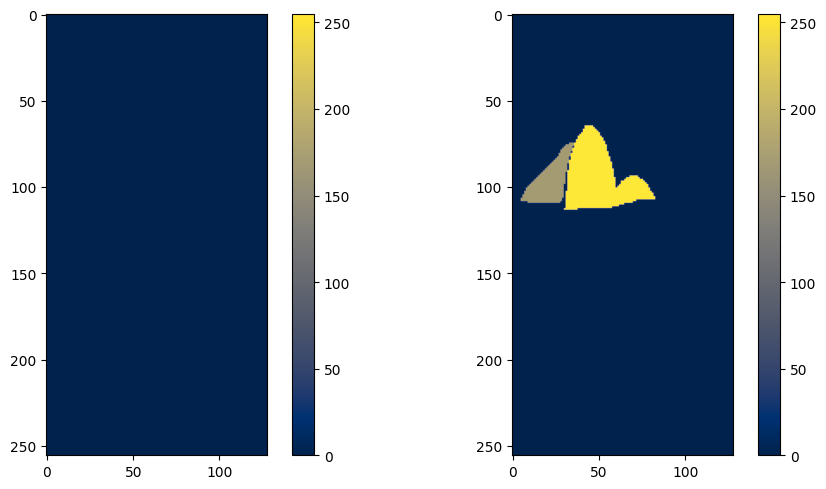

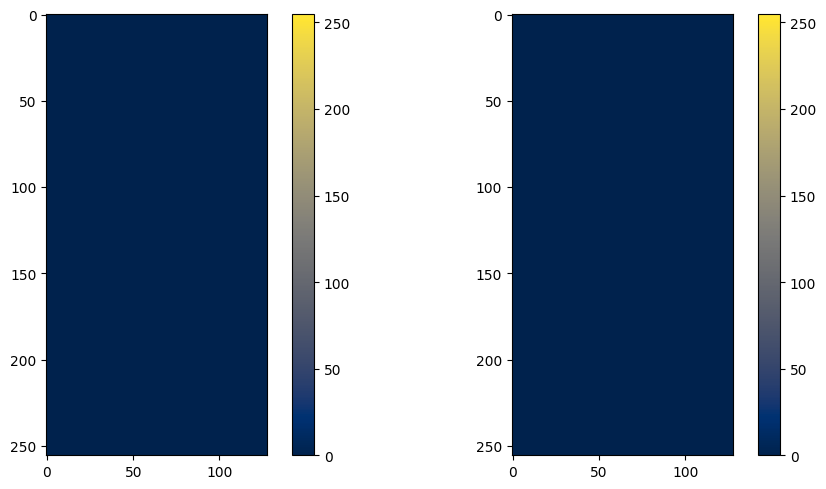

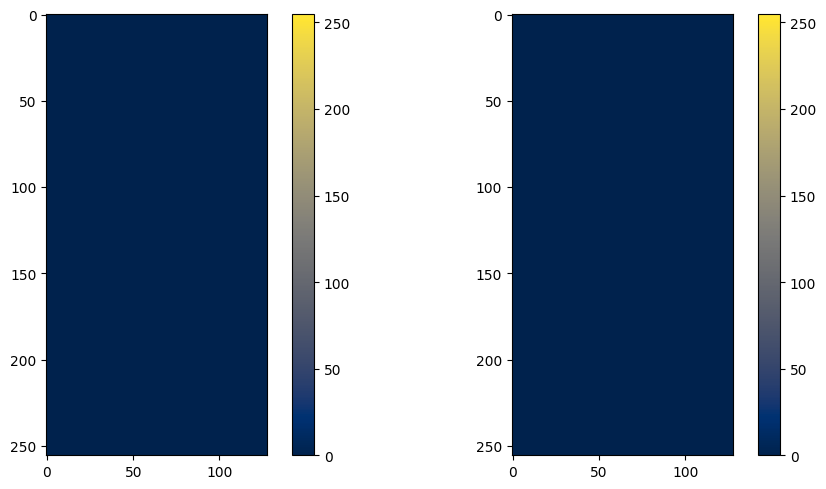

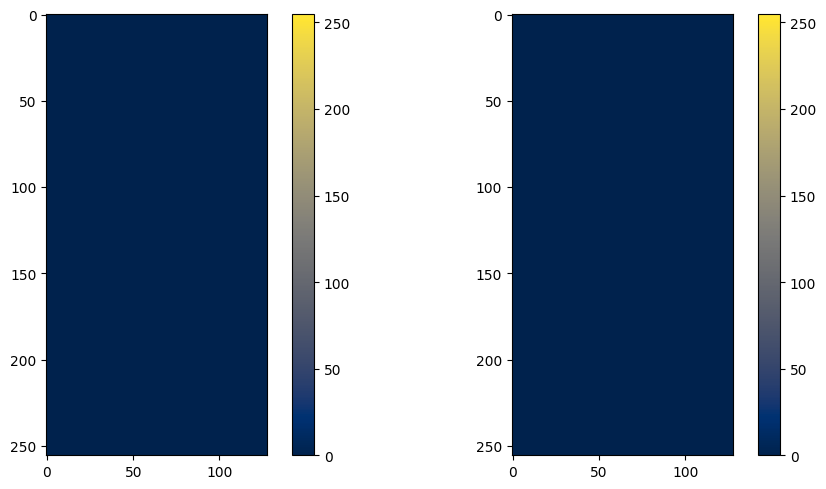

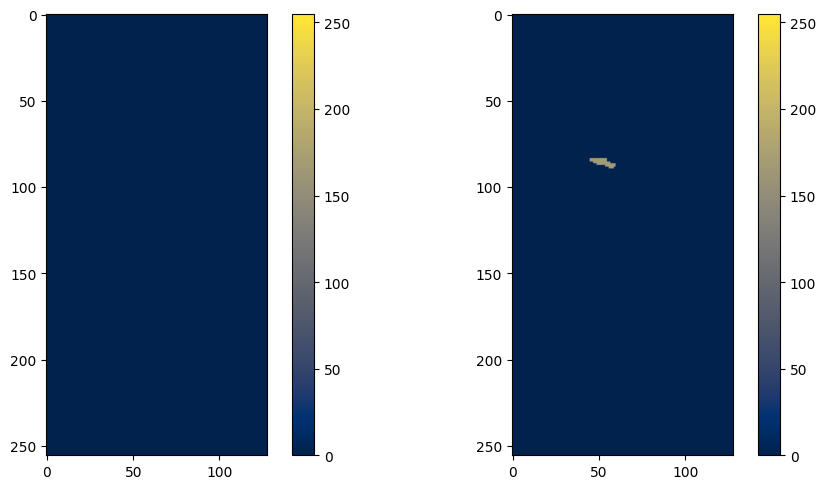

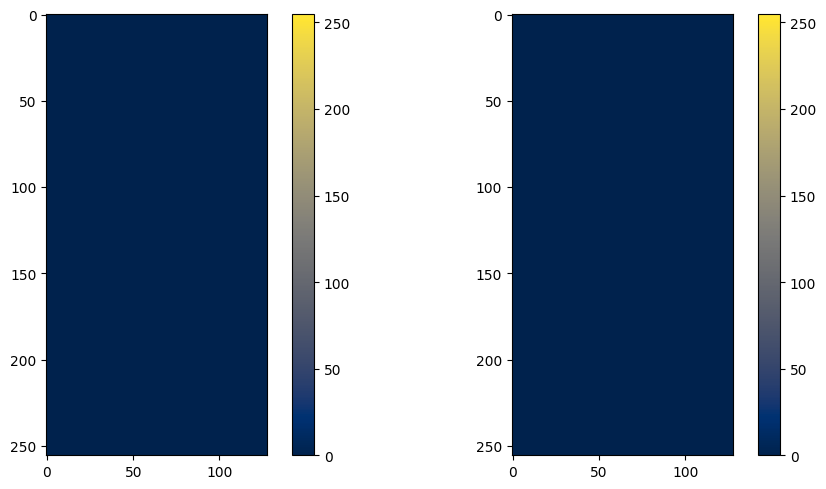

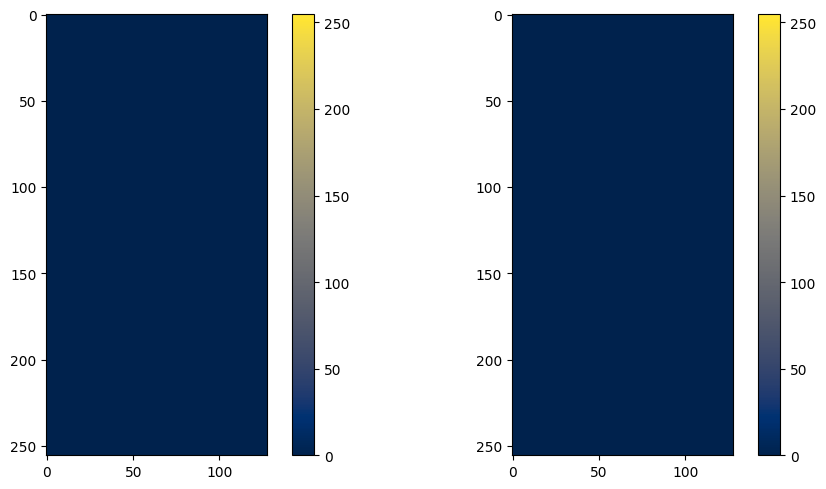

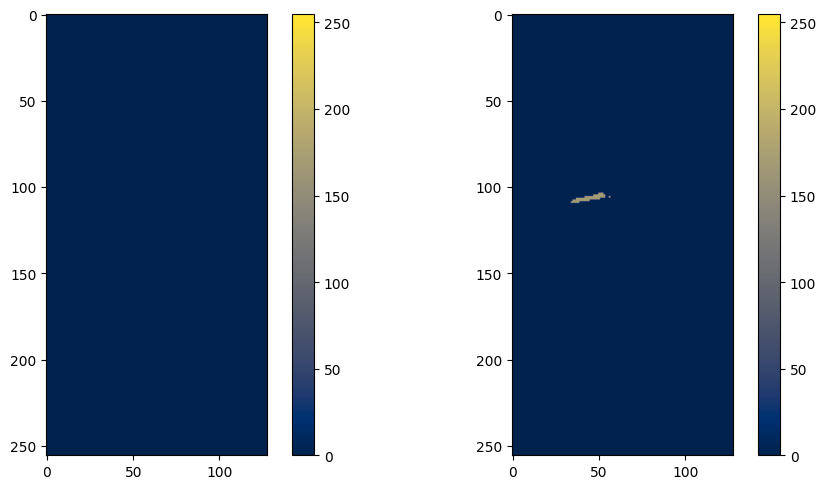

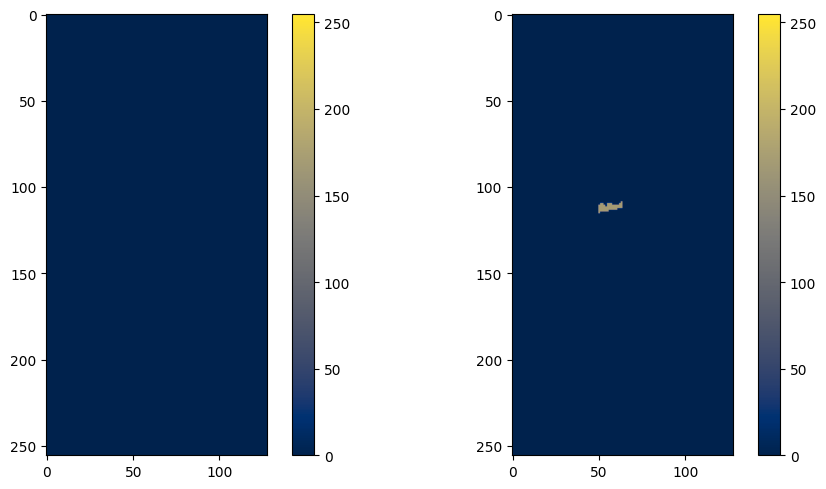

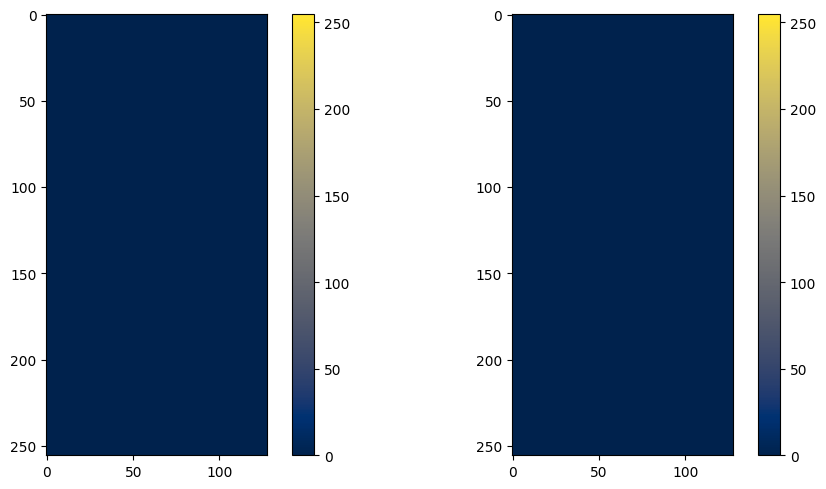

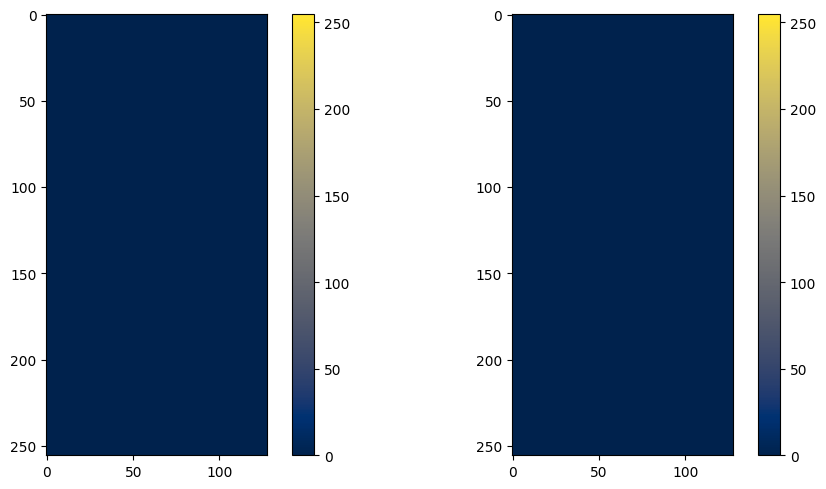

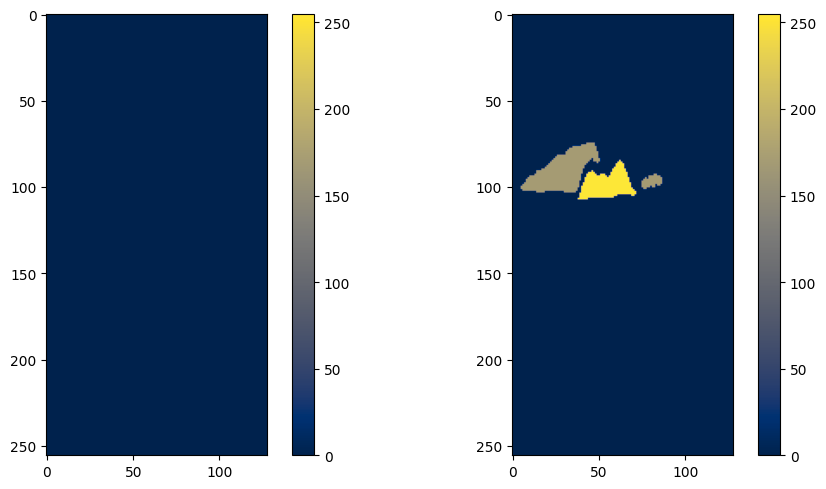

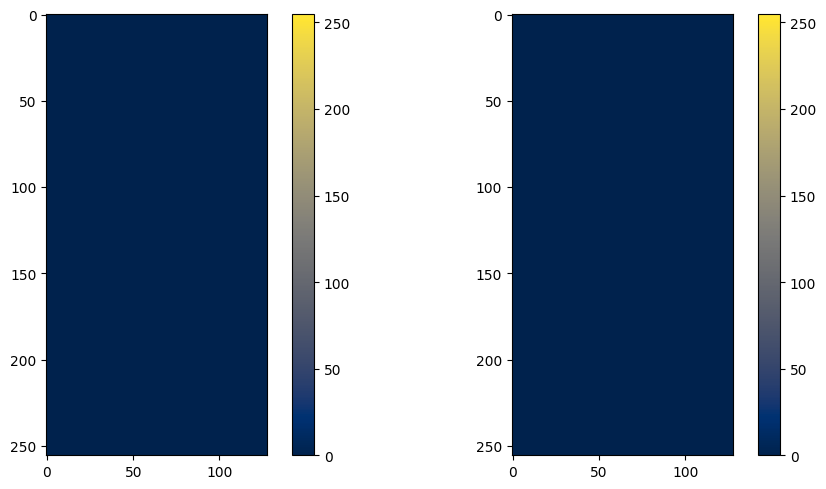

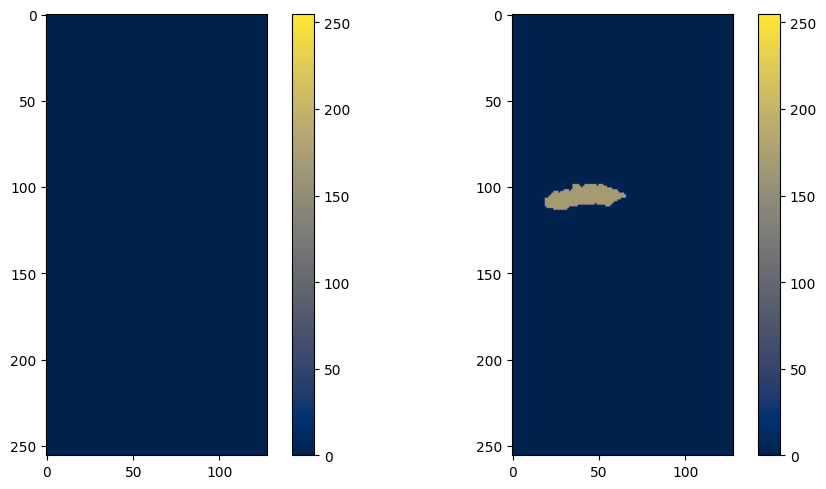

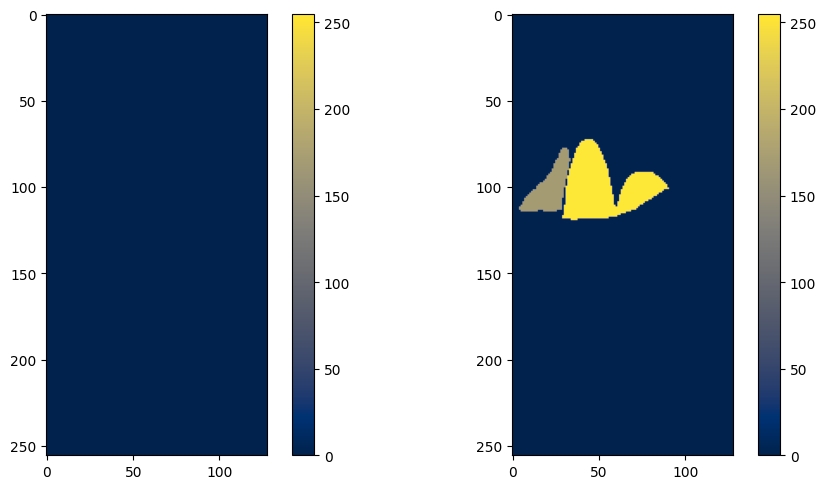

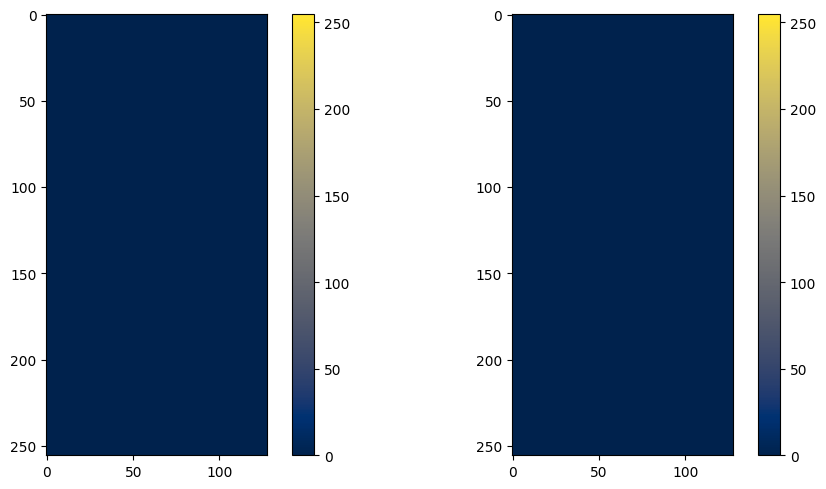

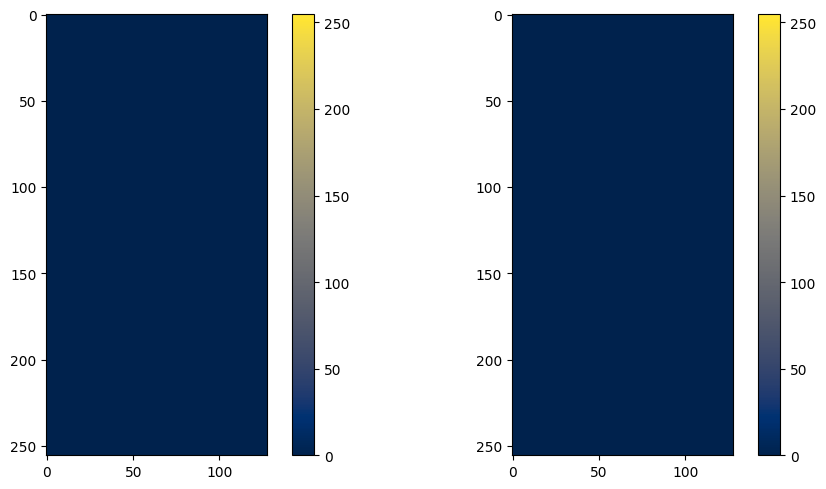

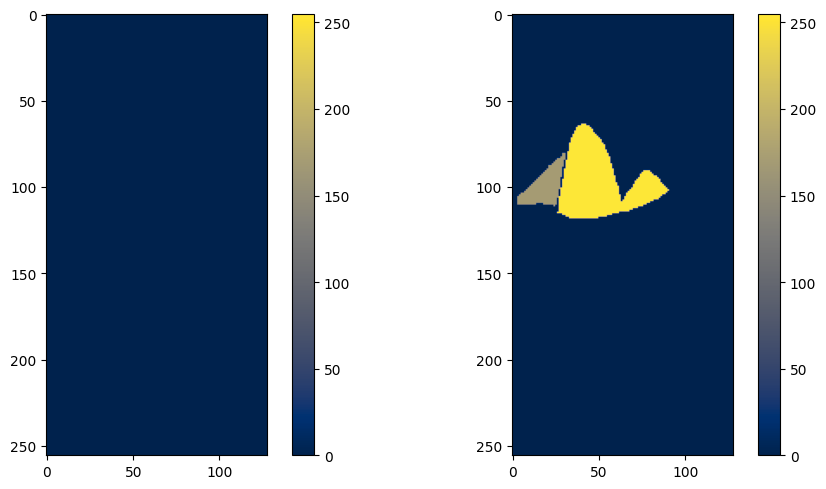

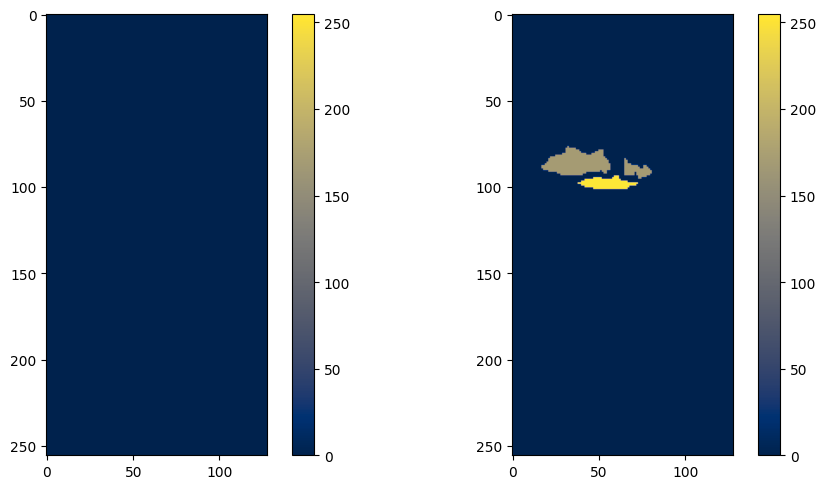

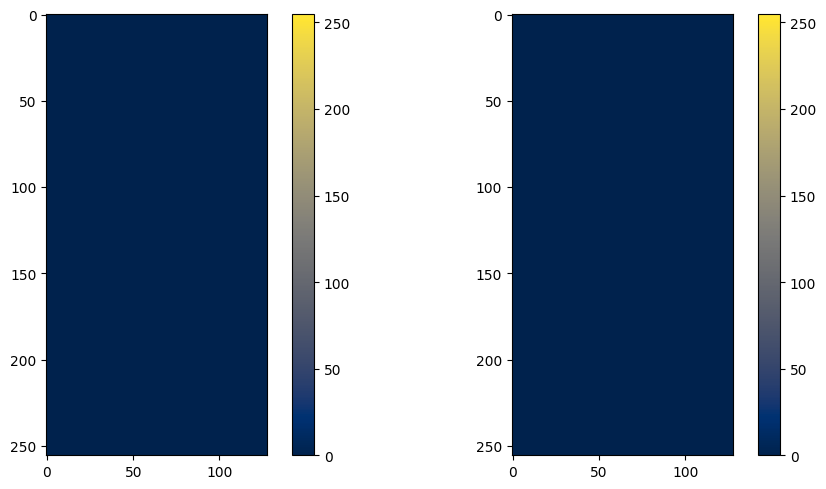

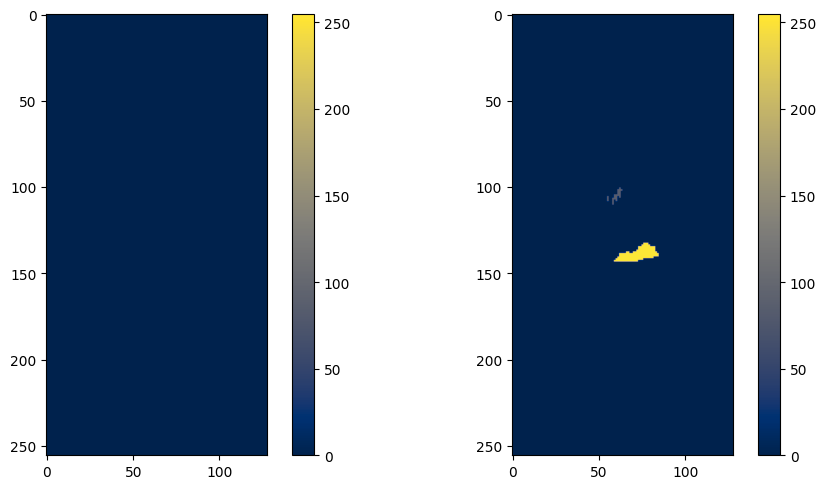

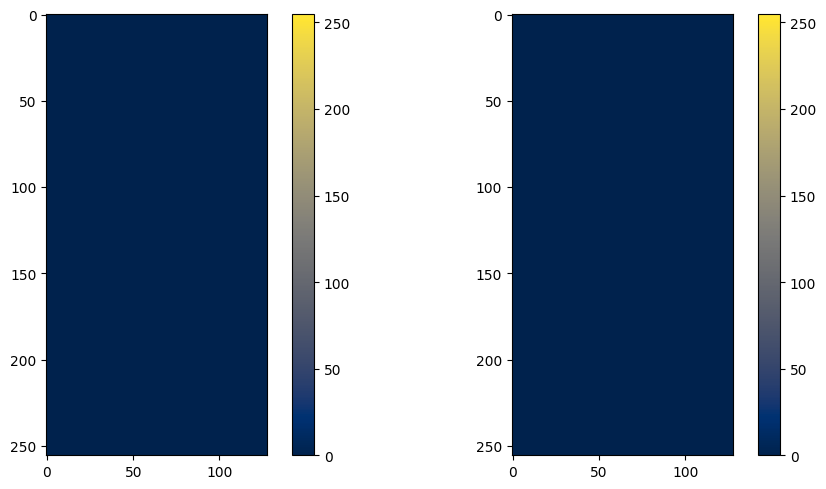

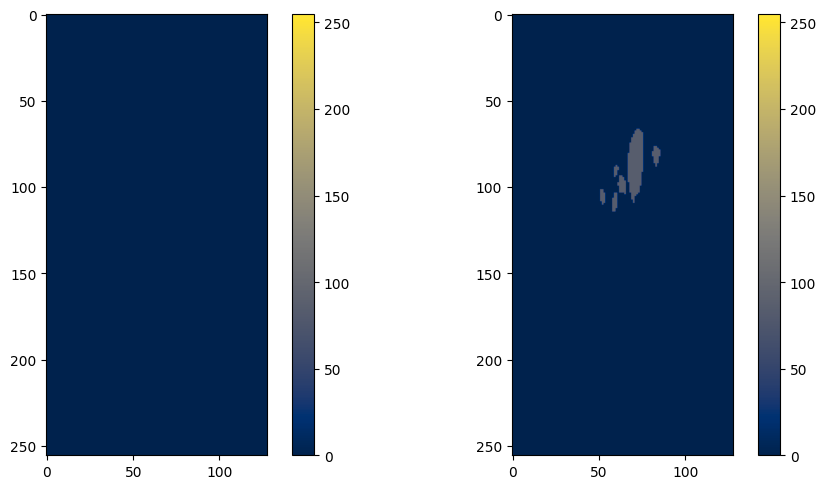

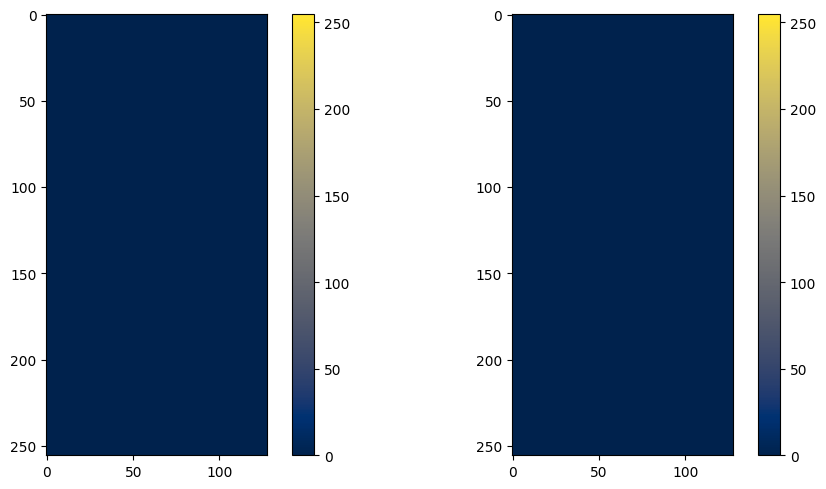

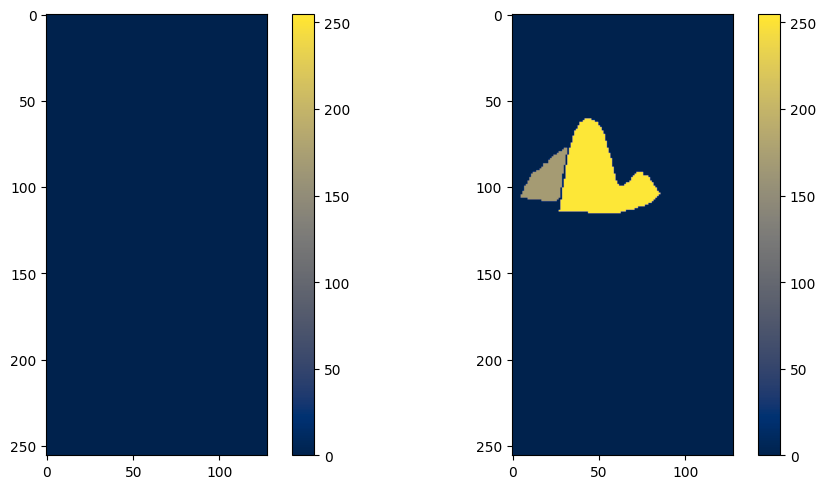

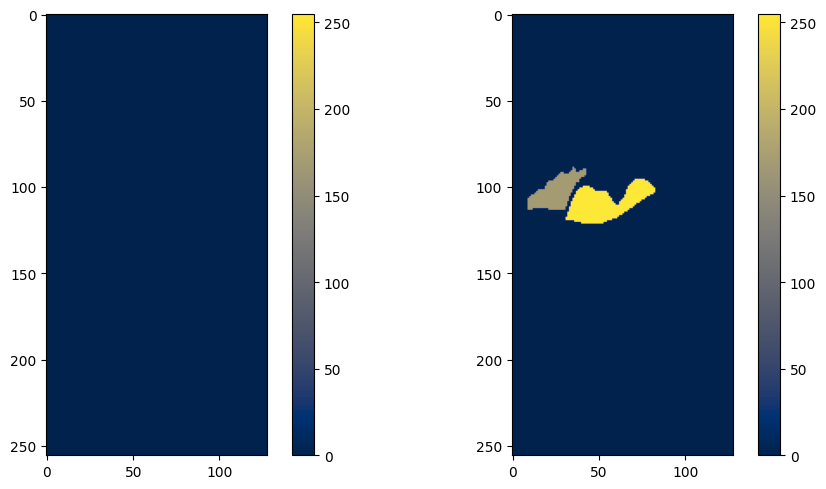

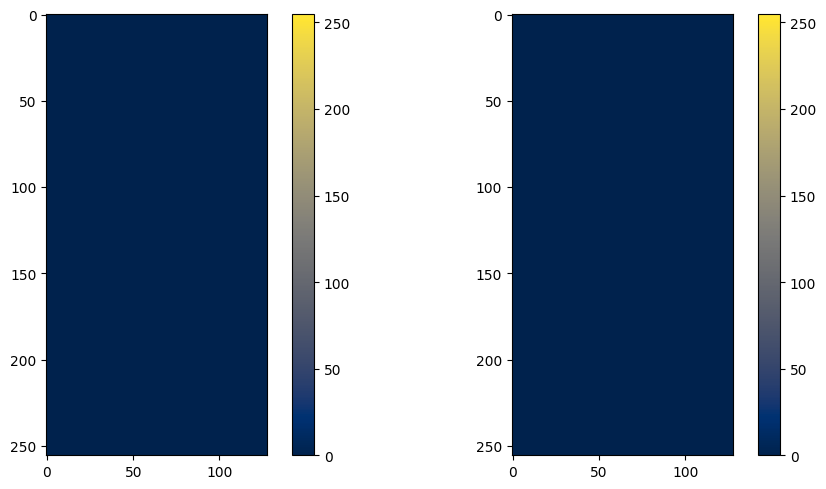

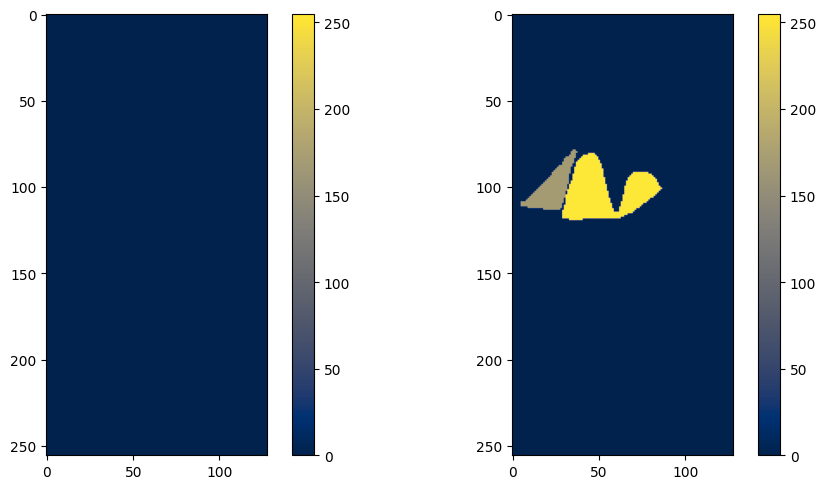

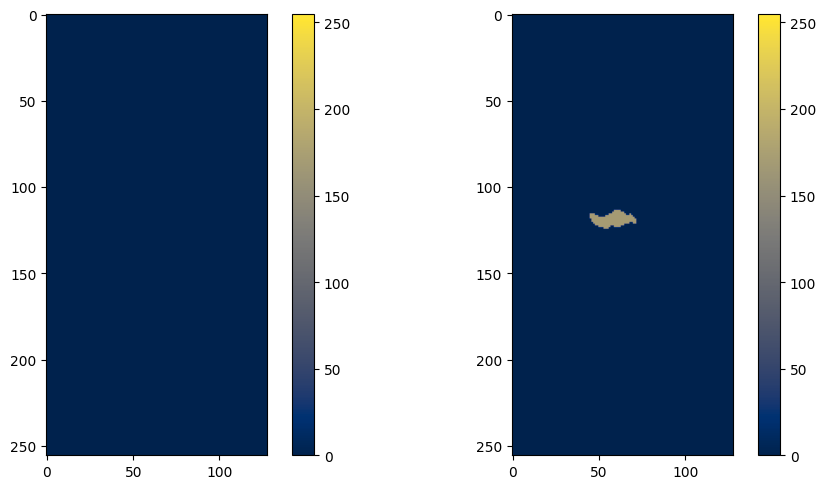

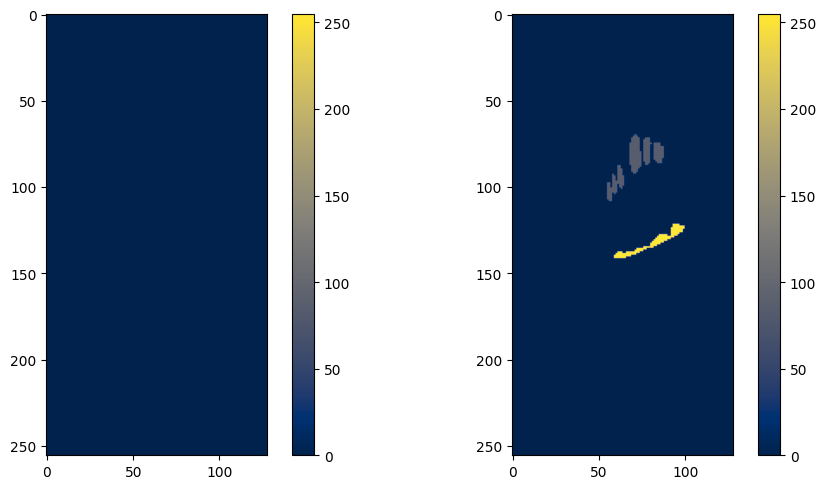

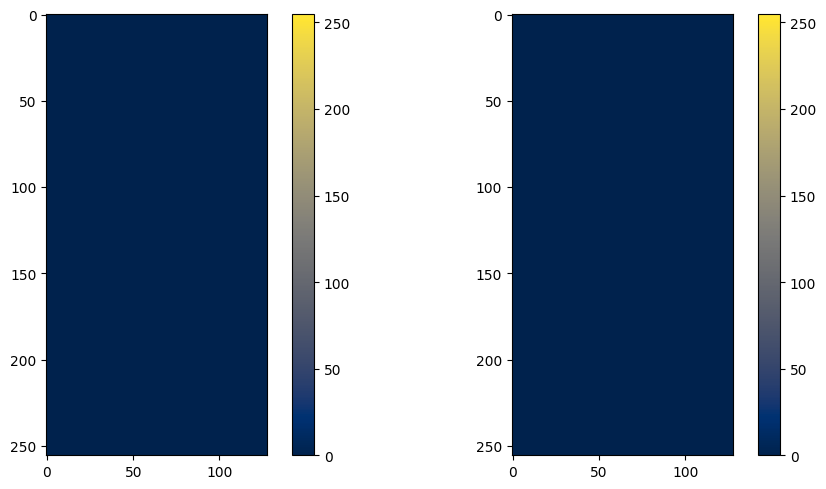

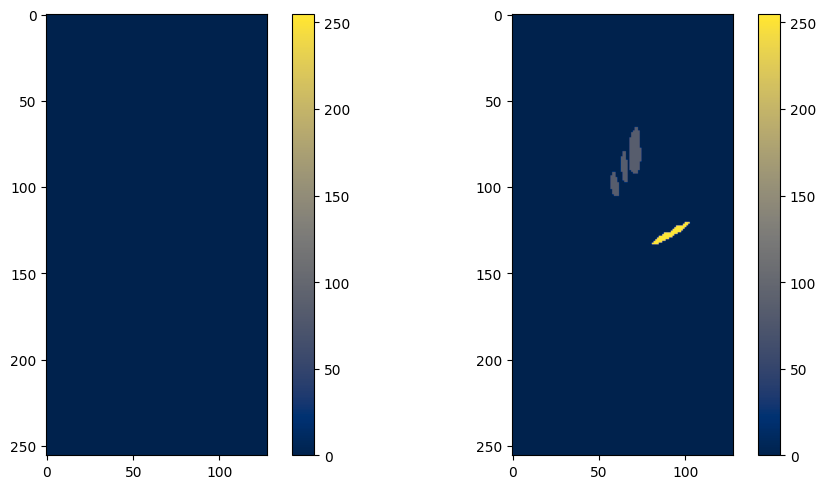

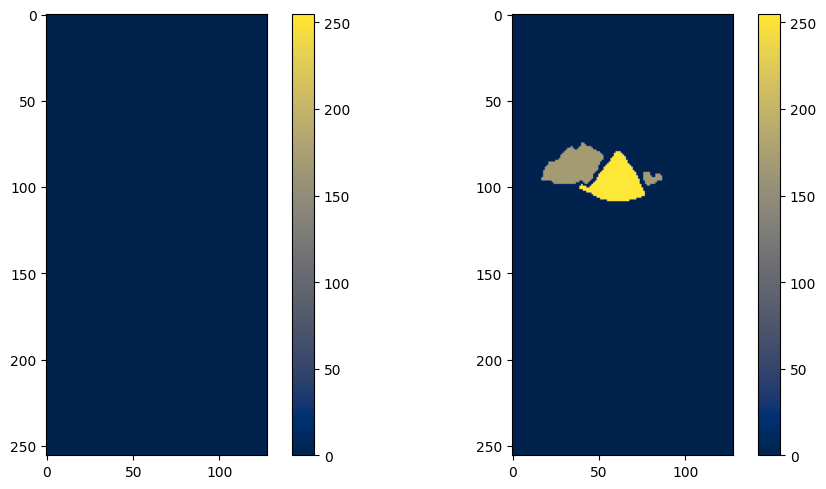

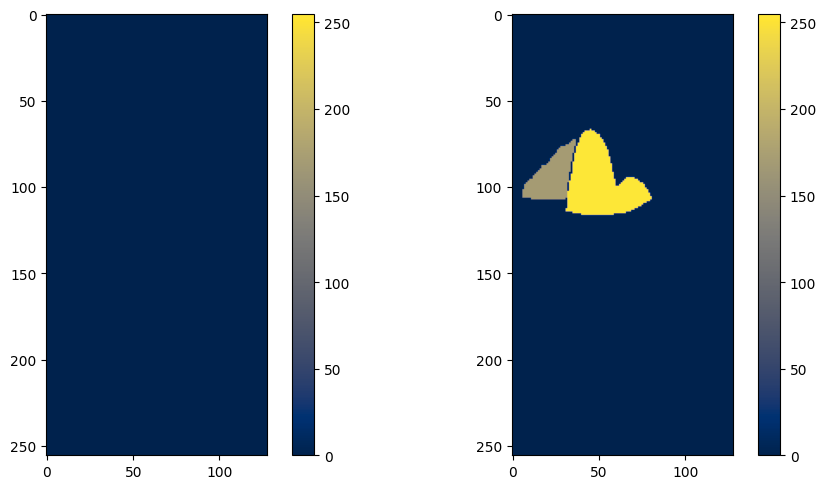

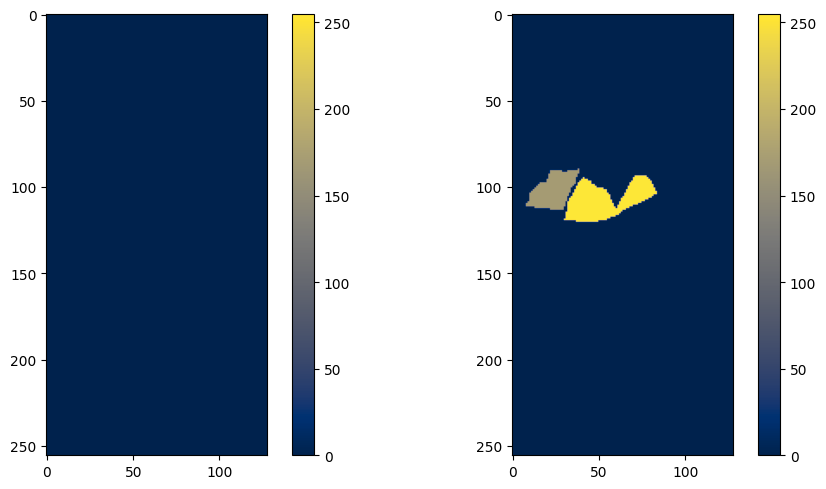

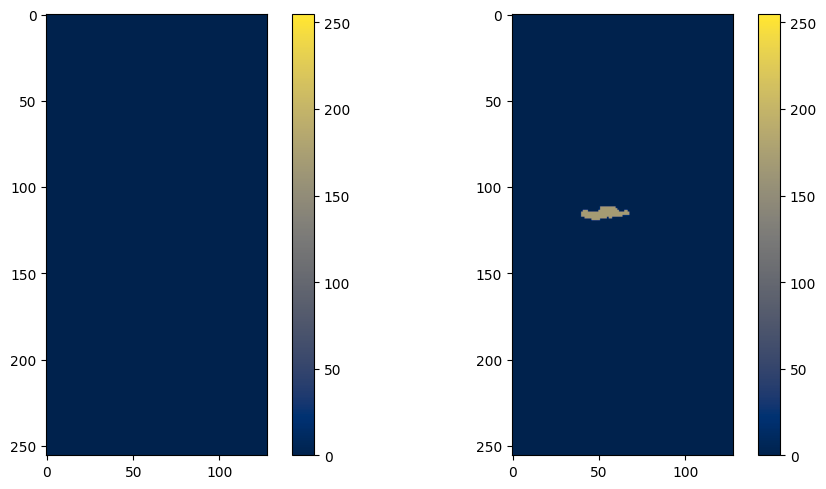

1536 ./Images/OCT/13_000.tif
1536 ./Images/Reference/13_000.tif
1537 ./Images/OCT/13_001.tif
1537 ./Images/Reference/13_001.tif
1538 ./Images/OCT/13_002.tif
1538 ./Images/Reference/13_002.tif
1539 ./Images/OCT/13_003.tif
1539 ./Images/Reference/13_003.tif
1540 ./Images/OCT/13_004.tif
1540 ./Images/Reference/13_004.tif
1541 ./Images/OCT/13_005.tif
1541 ./Images/Reference/13_005.tif
1542 ./Images/OCT/13_006.tif
1542 ./Images/Reference/13_006.tif
1543 ./Images/OCT/13_007.tif
1543 ./Images/Reference/13_007.tif
1544 ./Images/OCT/13_008.tif
1544 ./Images/Reference/13_008.tif
1545 ./Images/OCT/13_009.tif
1545 ./Images/Reference/13_009.tif
1546 ./Images/OCT/13_010.tif
1546 ./Images/Reference/13_010.tif
1547 ./Images/OCT/13_011.tif
1547 ./Images/Reference/13_011.tif
1548 ./Images/OCT/13_012.tif
1548 ./Images/Reference/13_012.tif
1549 ./Images/OCT/13_013.tif
1549 ./Images/Reference/13_013.tif
1550 ./Images/OCT/13_014.tif
1550 ./Images/Reference/13_014.tif
1551 ./Images/OCT/13_015.tif
1551 ./Imag

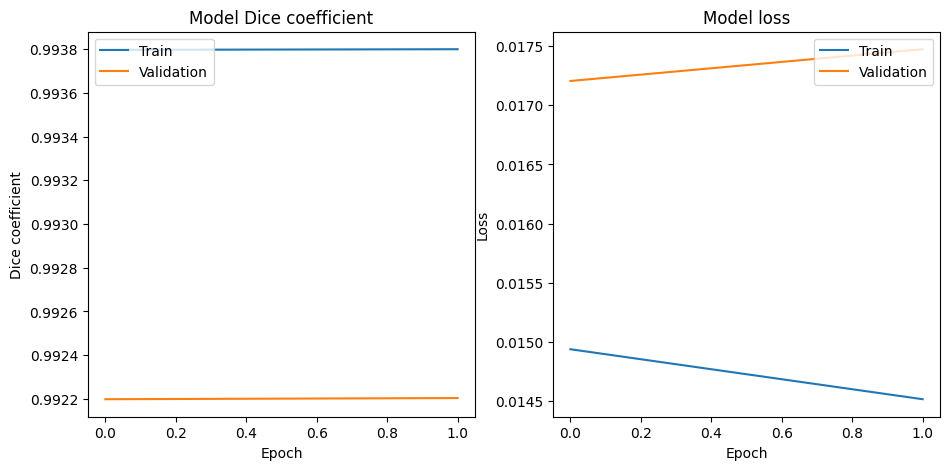

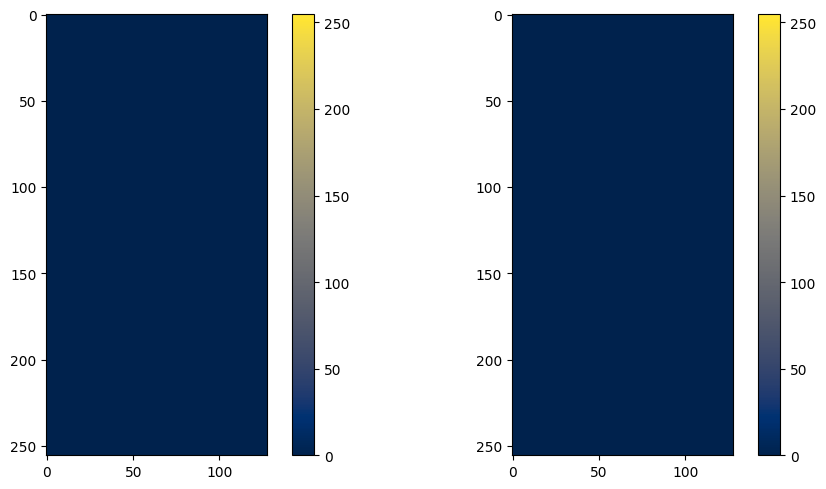

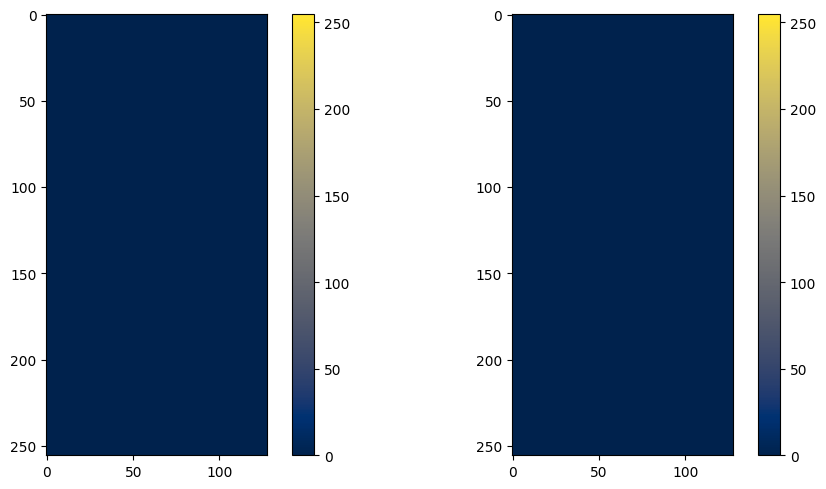

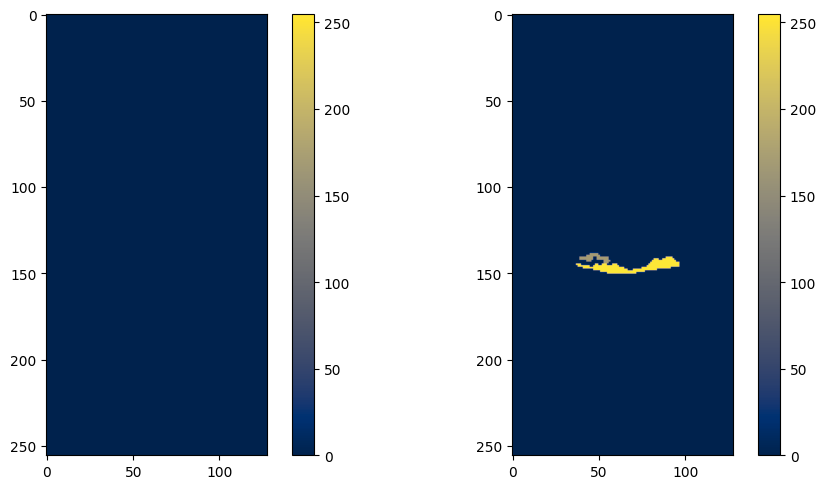

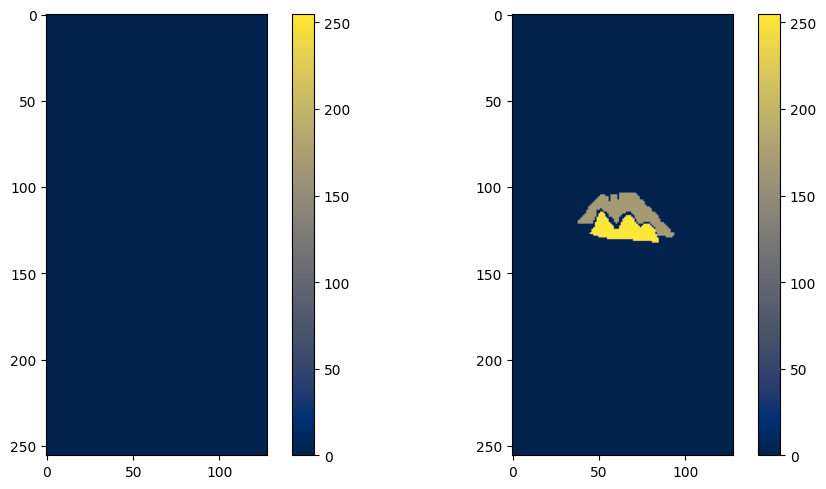

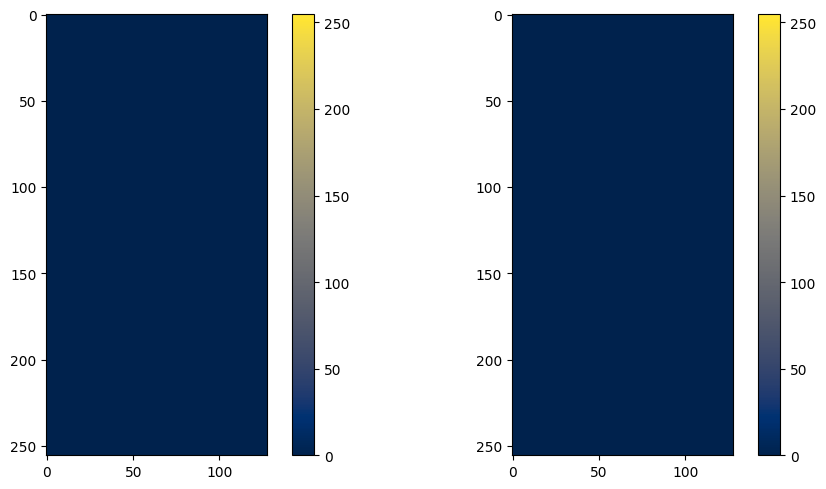

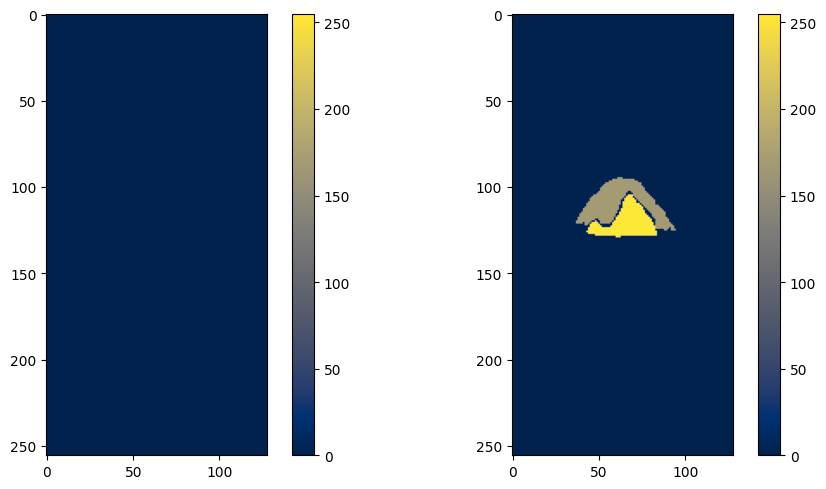

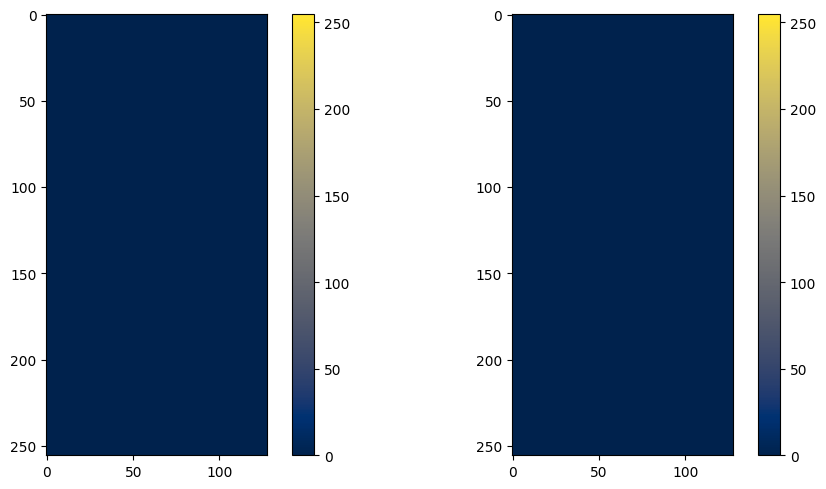

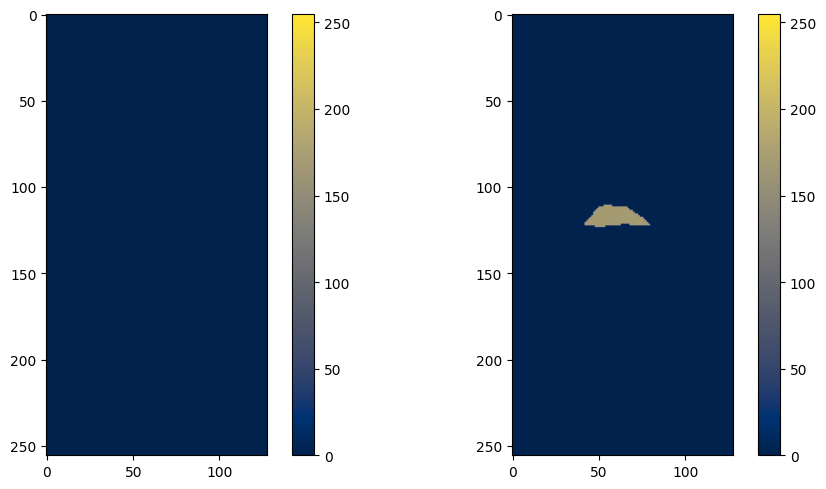

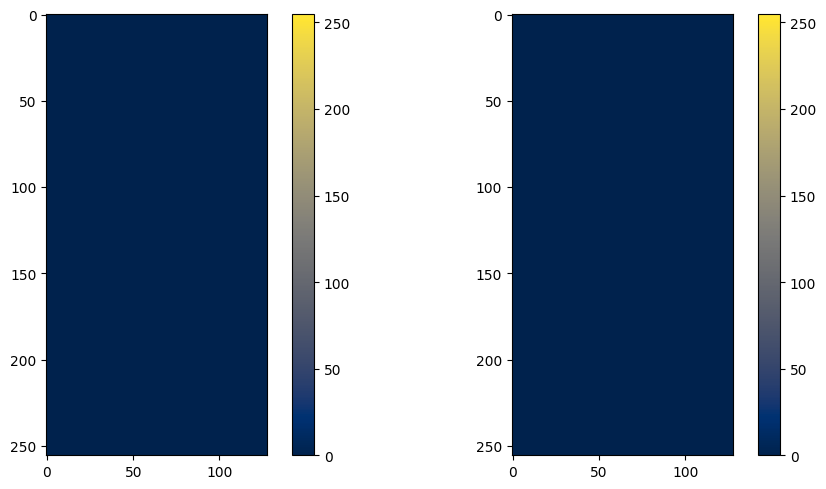

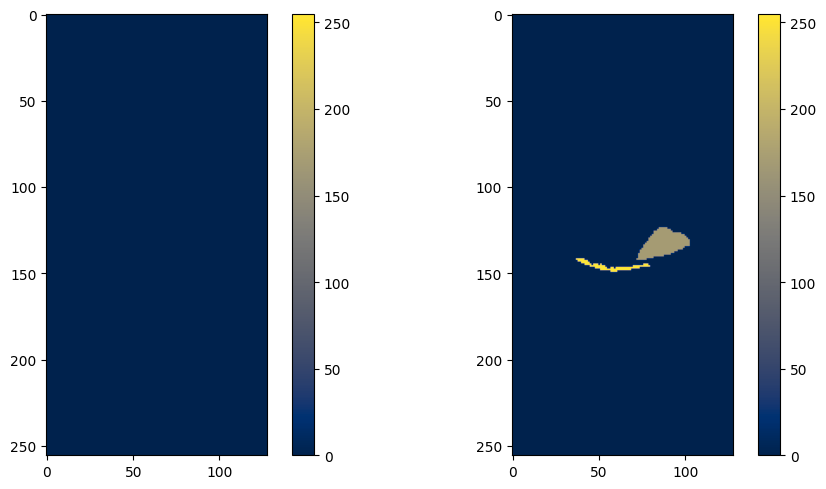

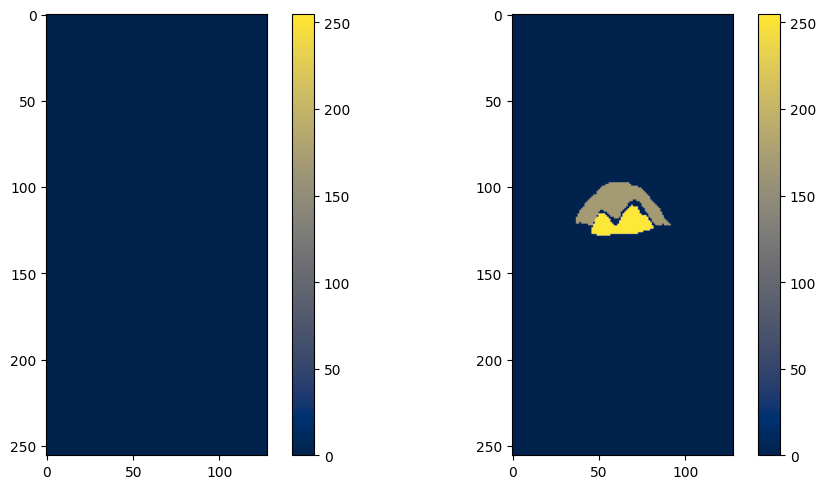

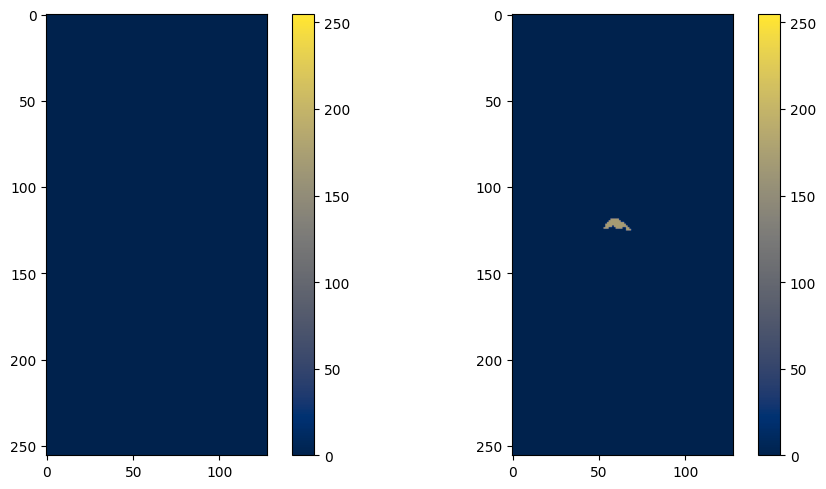

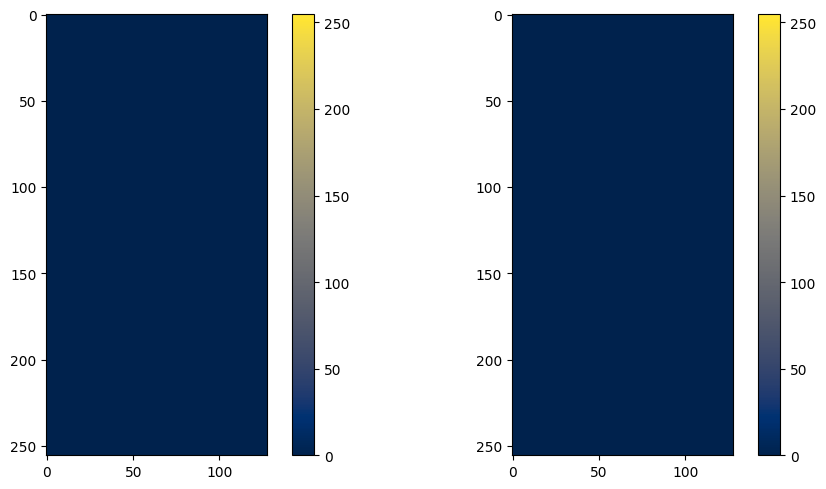

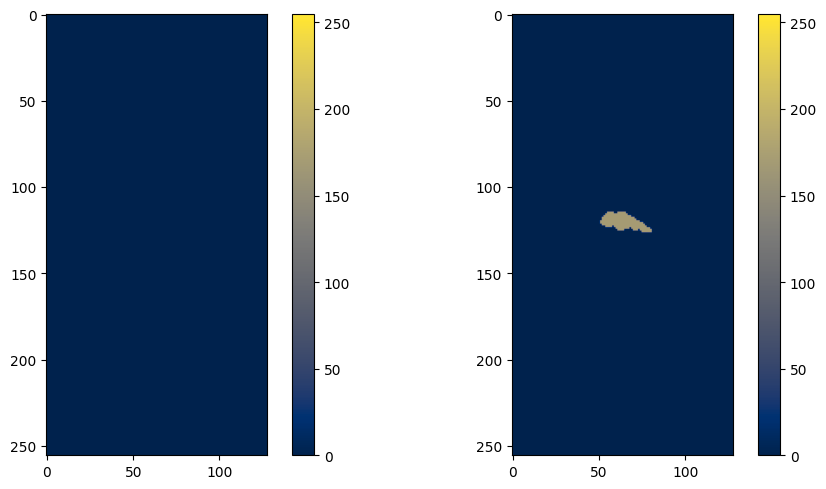

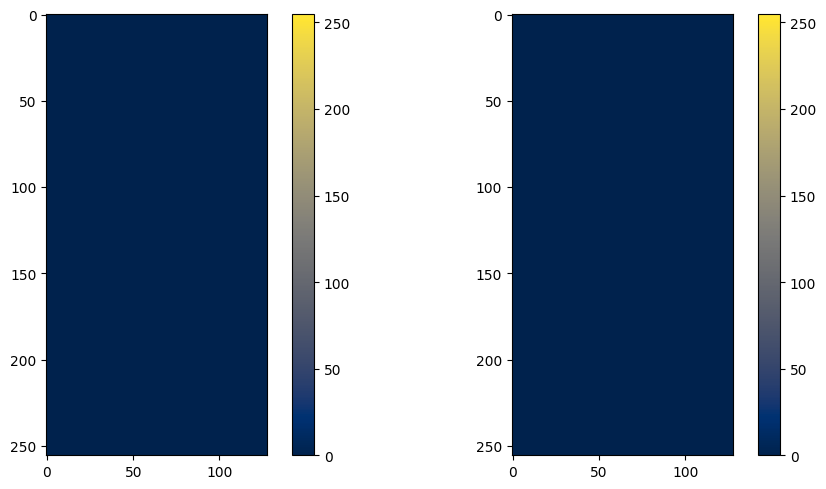

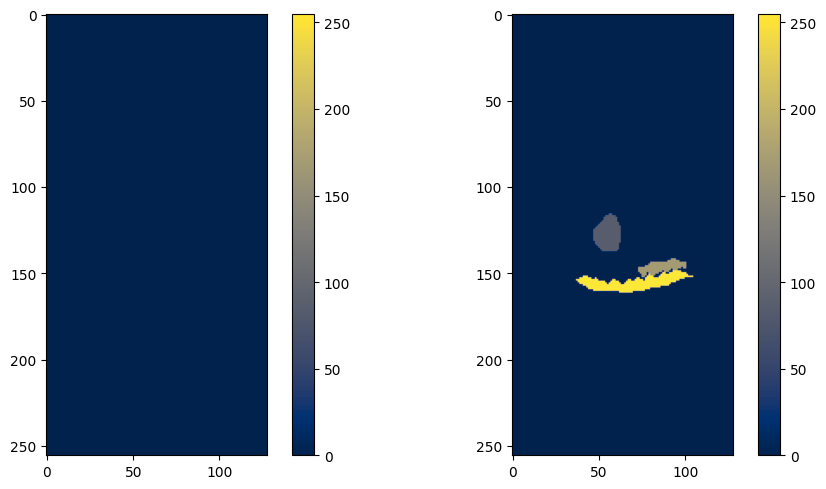

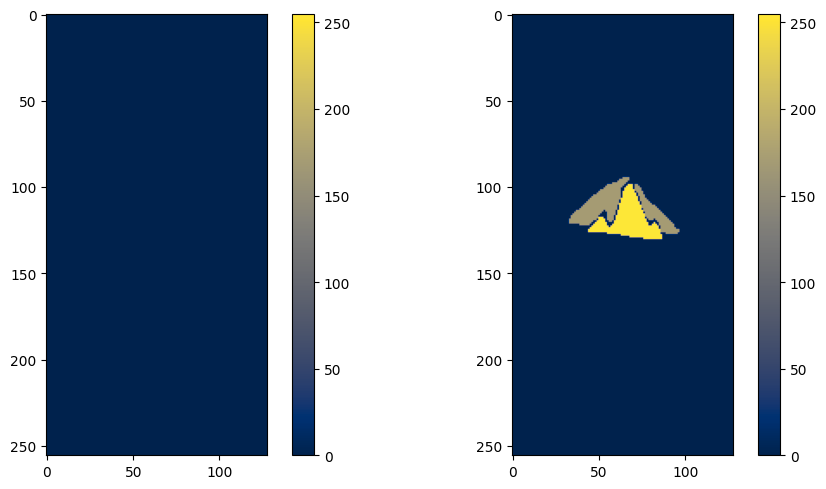

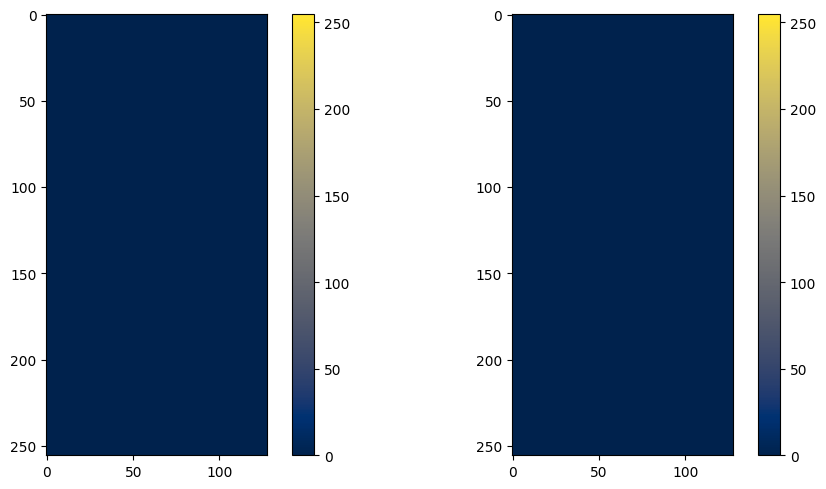

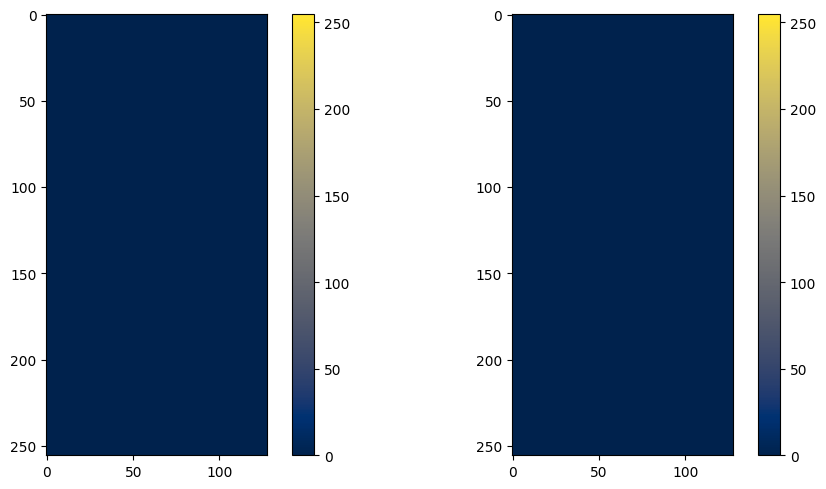

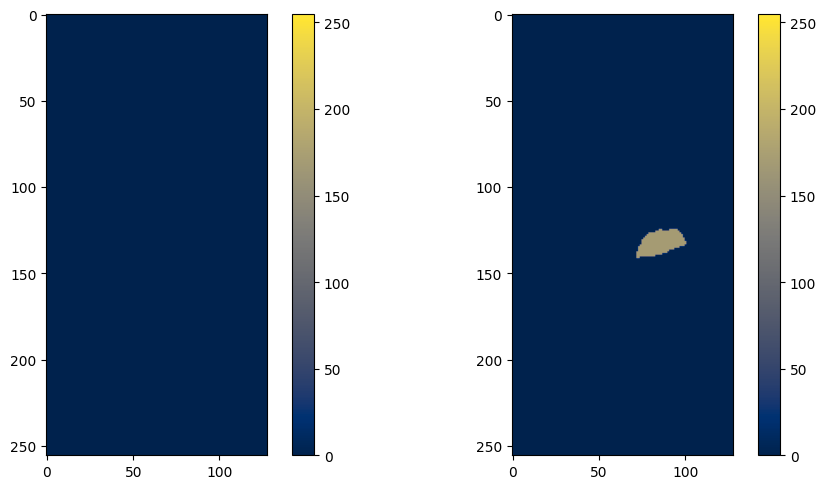

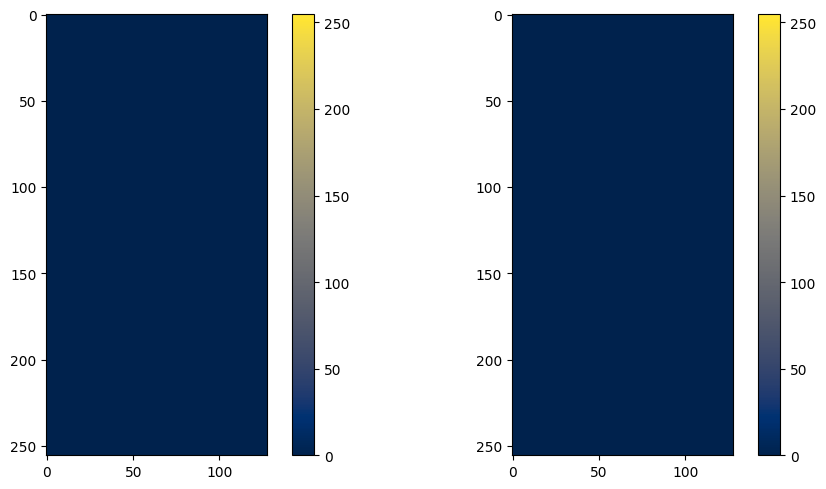

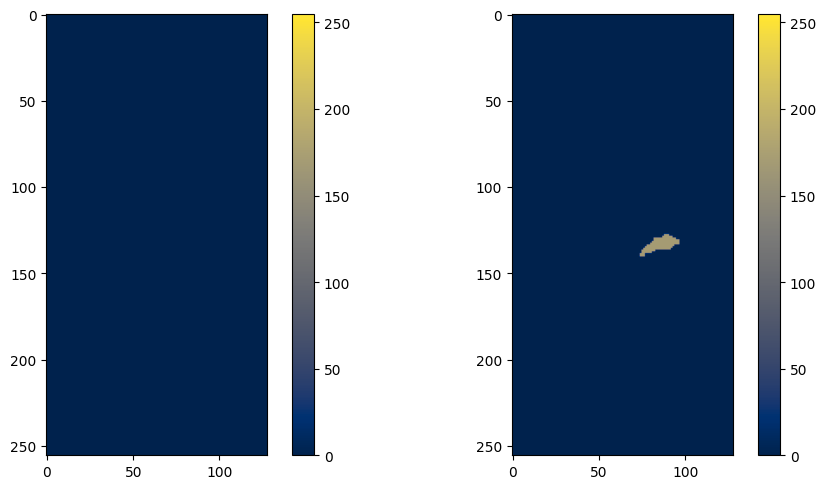

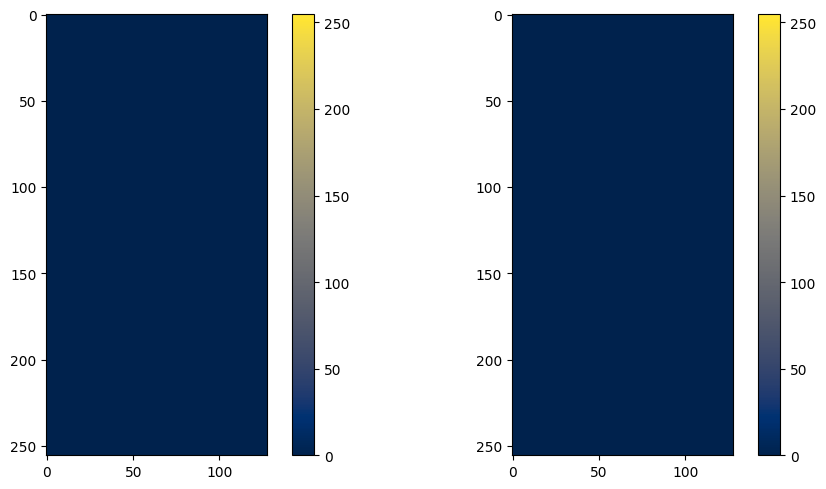

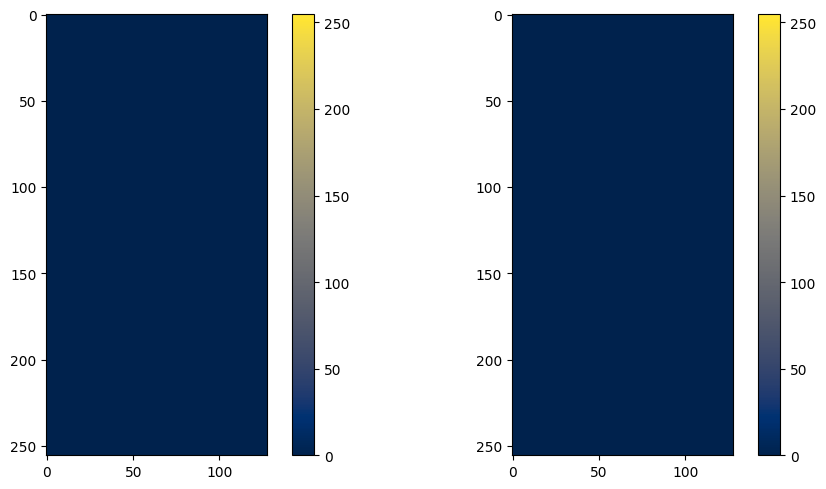

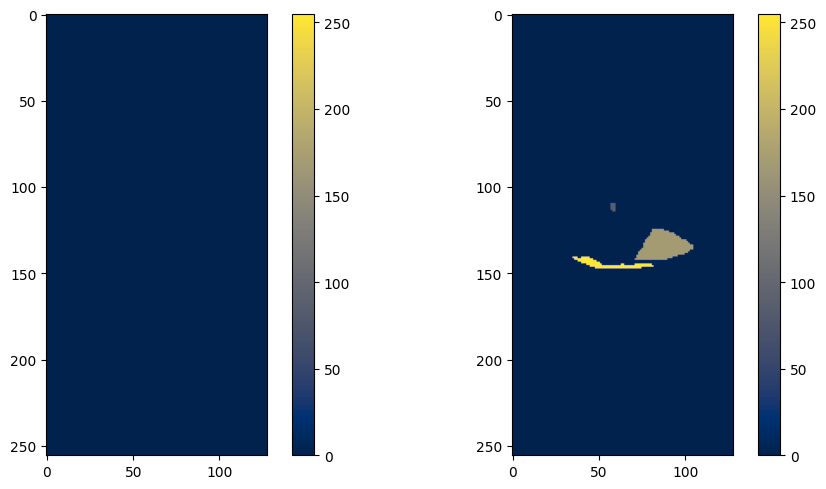

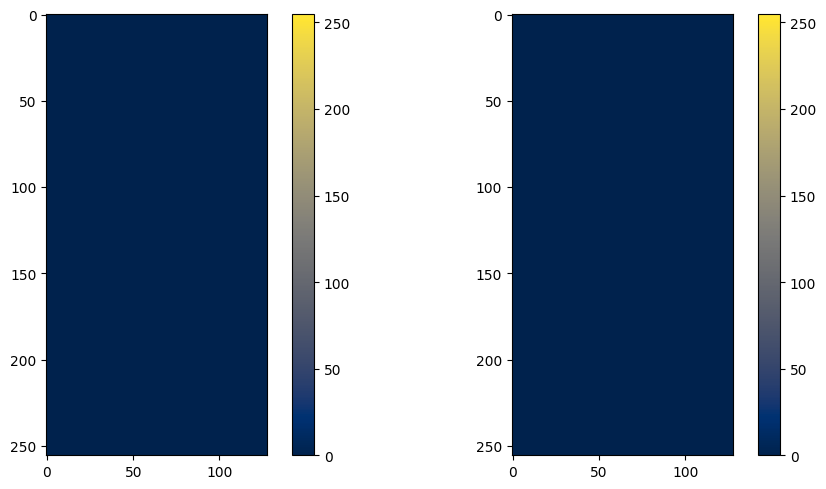

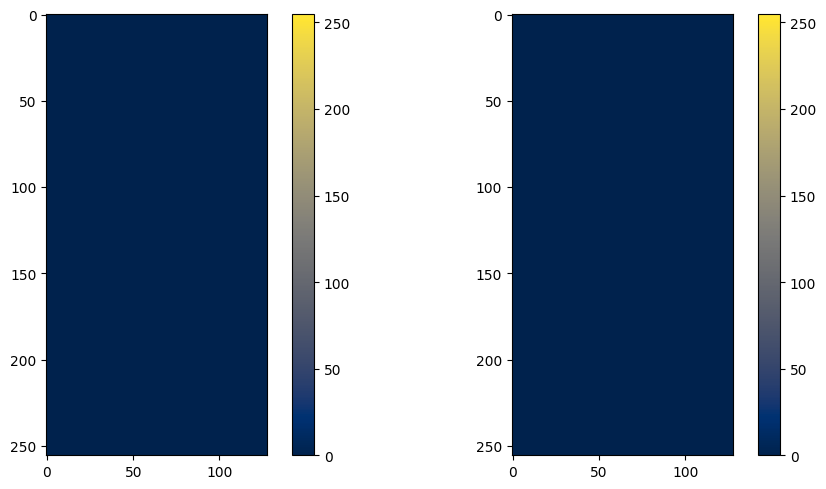

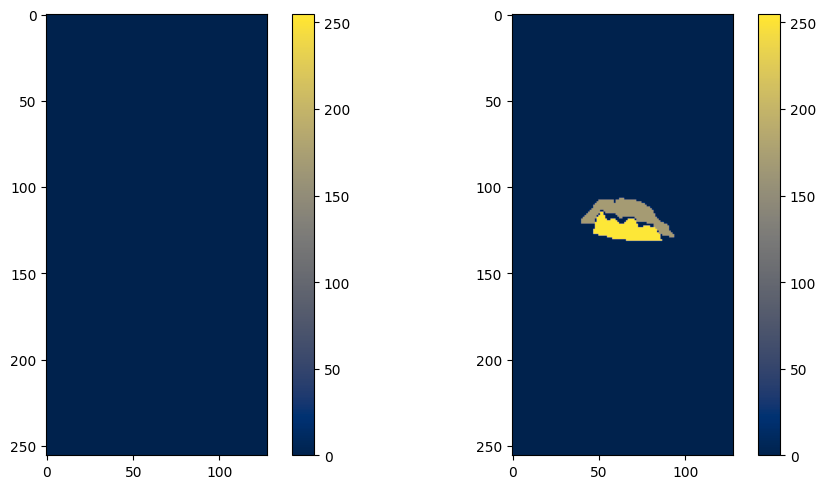

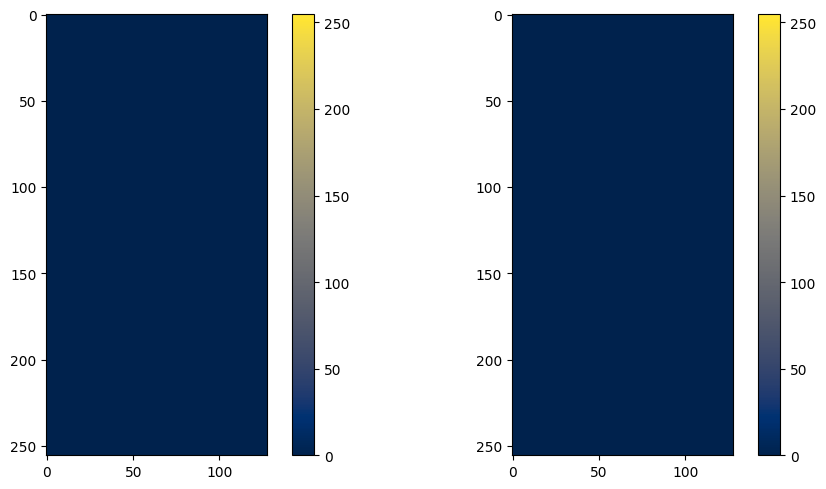

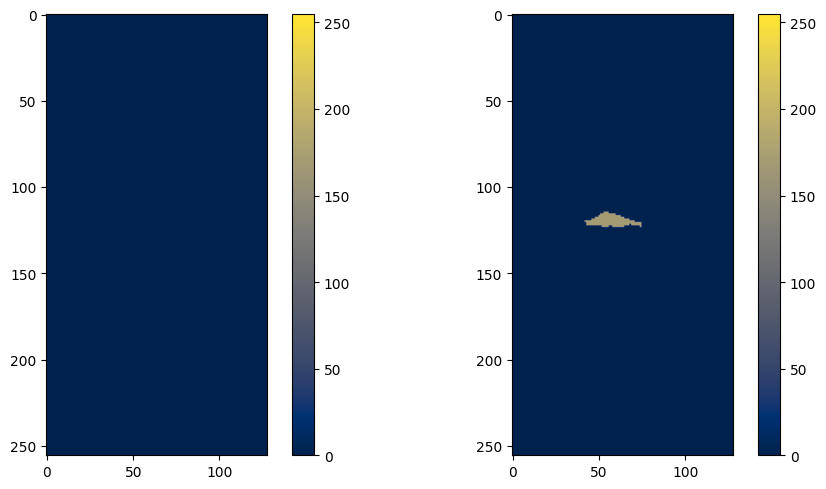

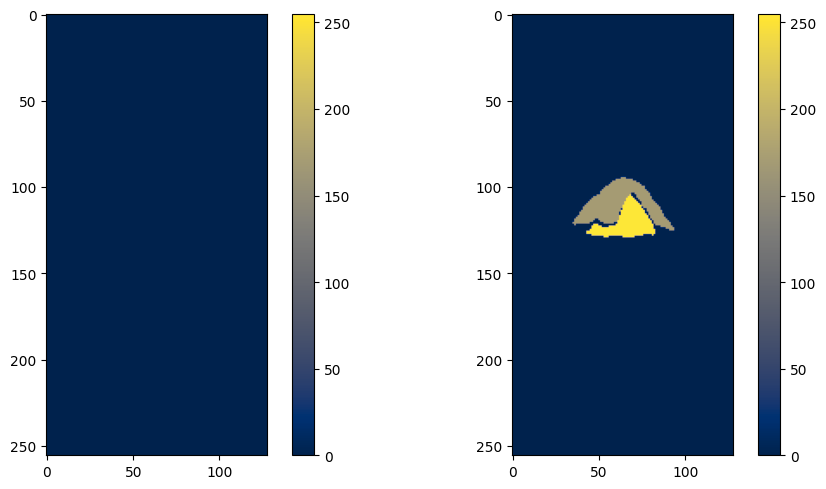

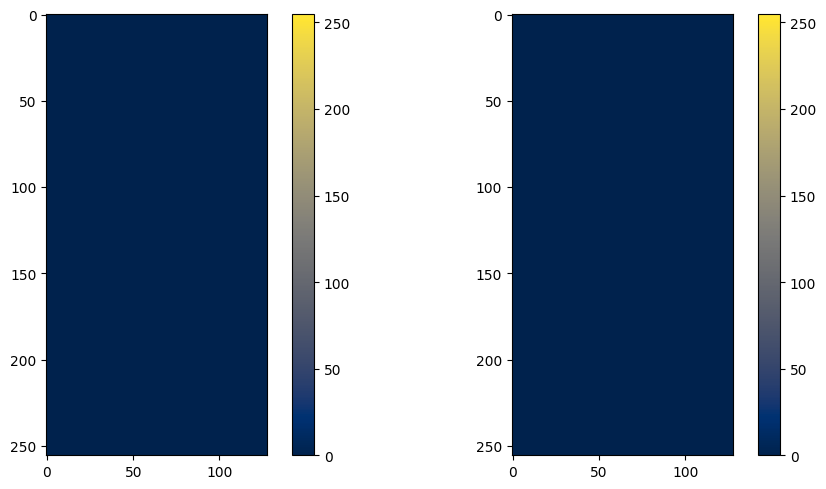

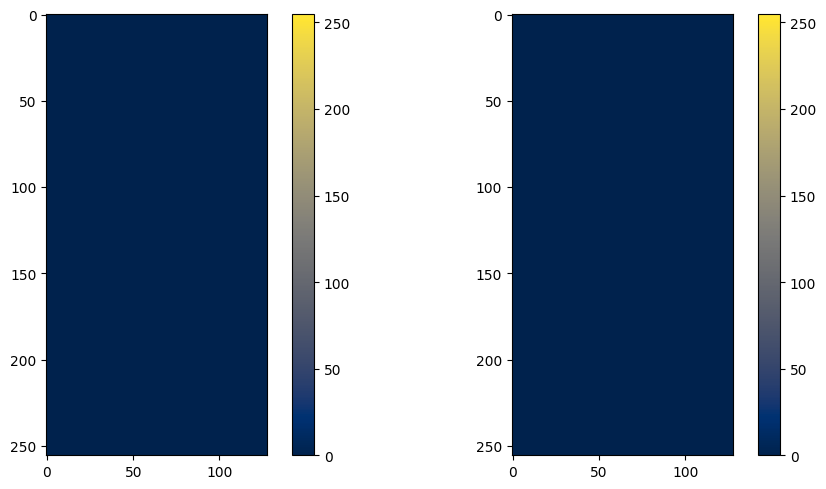

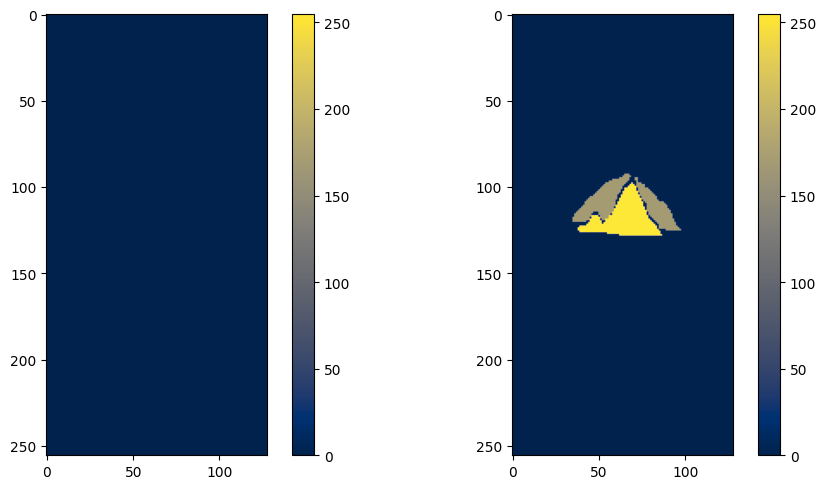

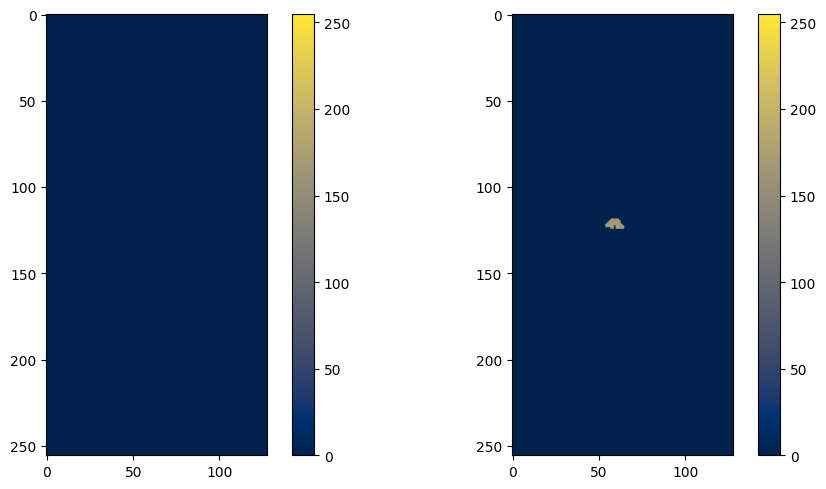

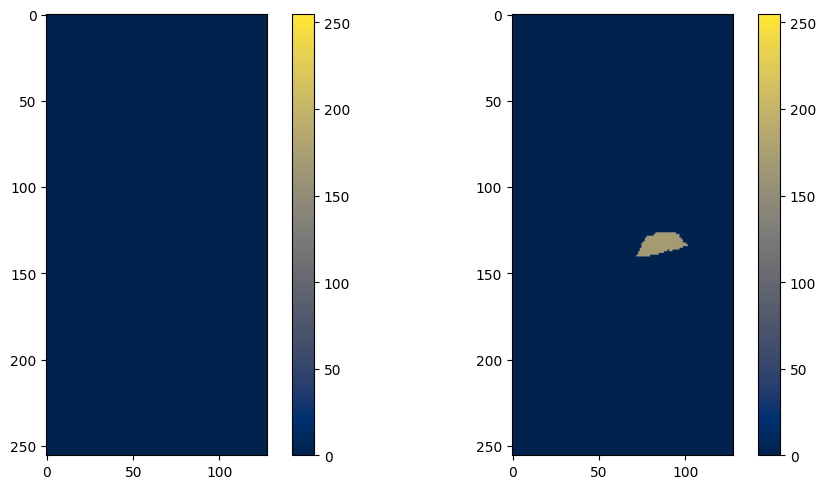

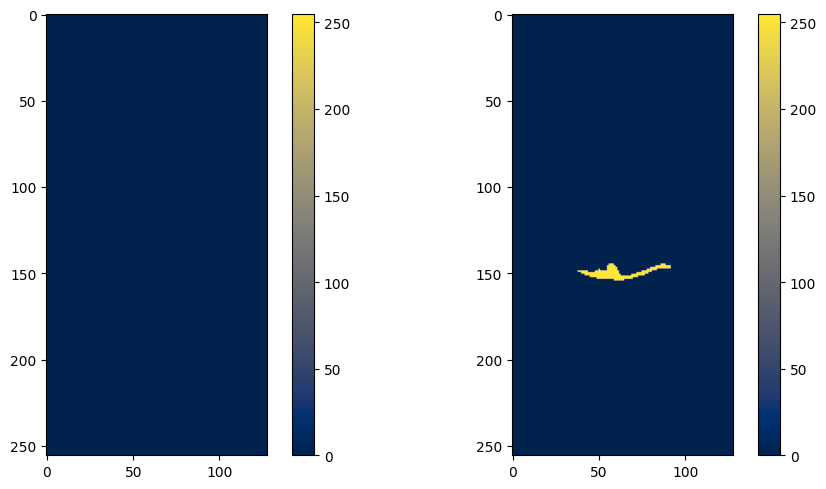

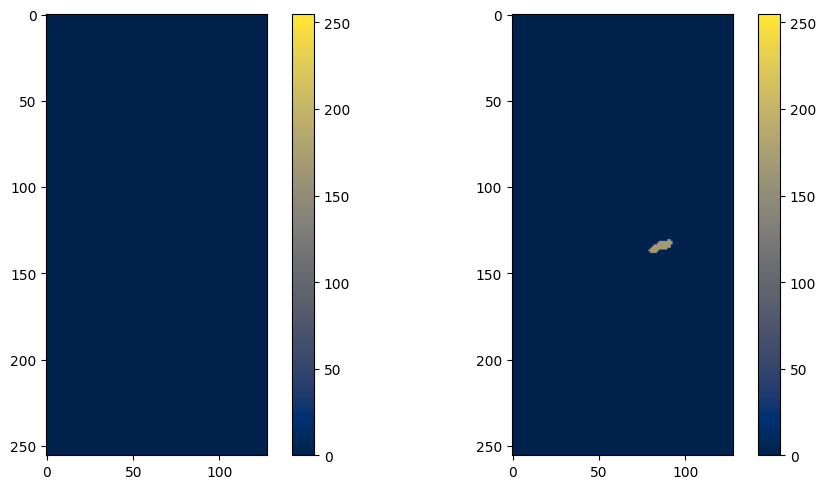

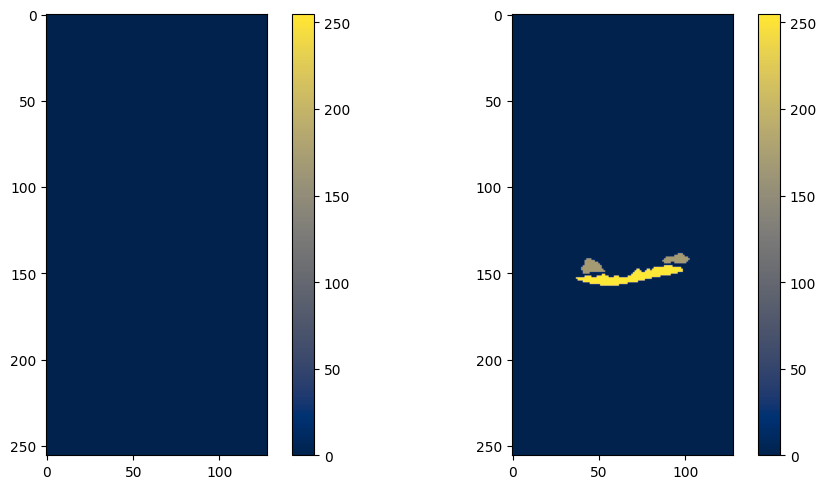

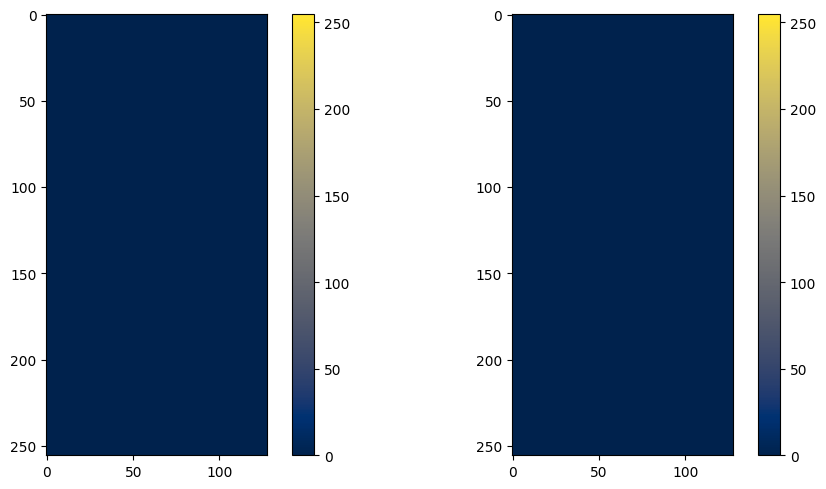

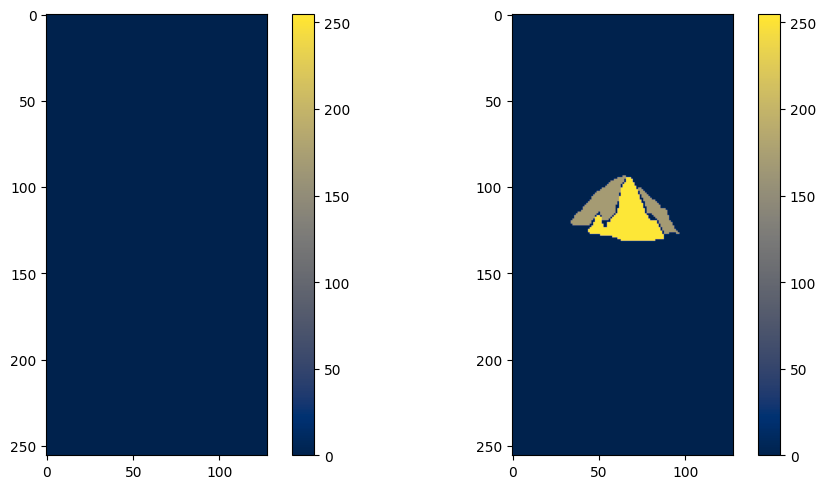

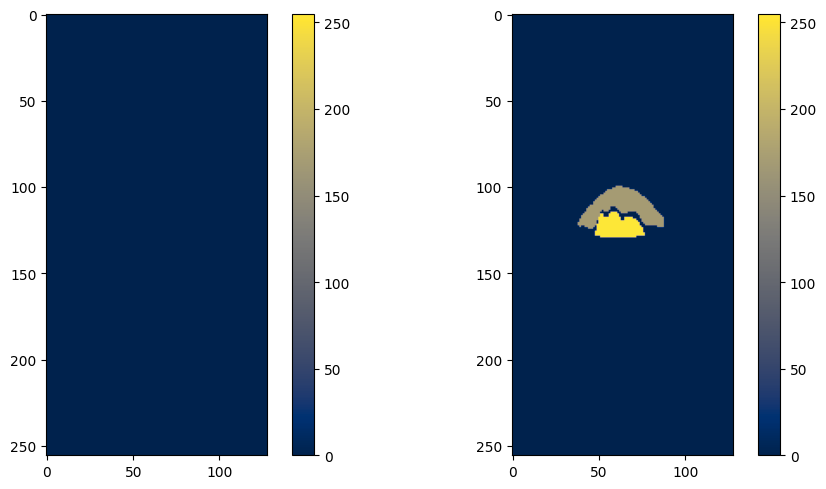

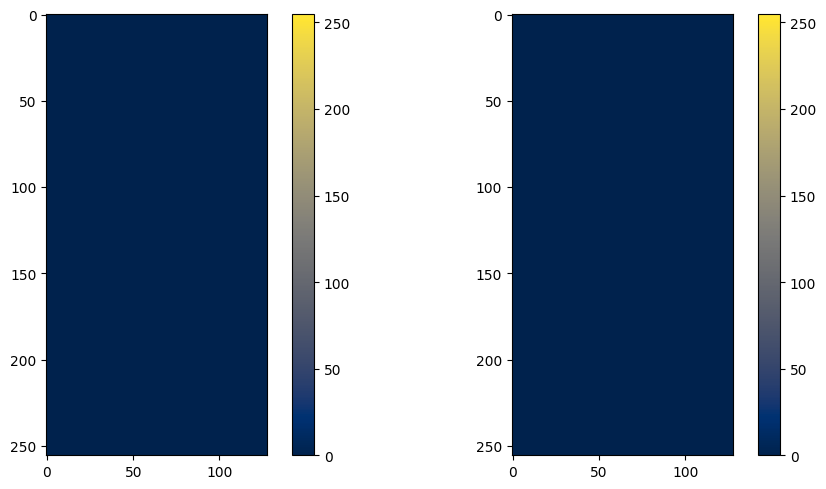

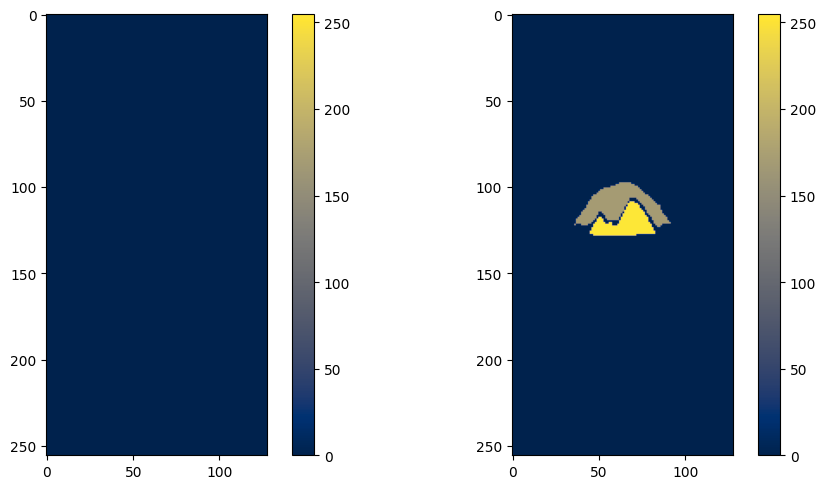

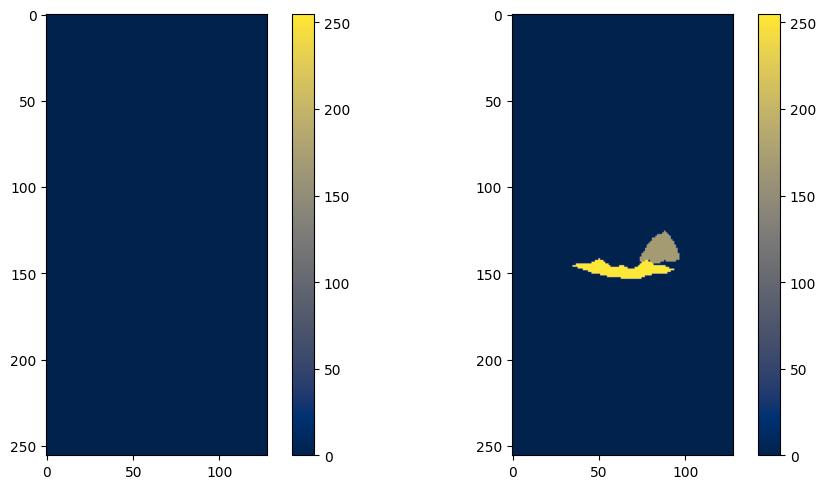

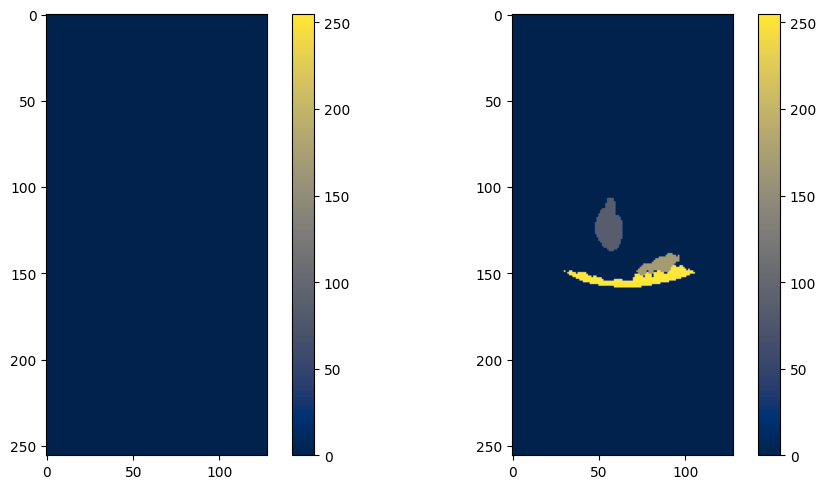

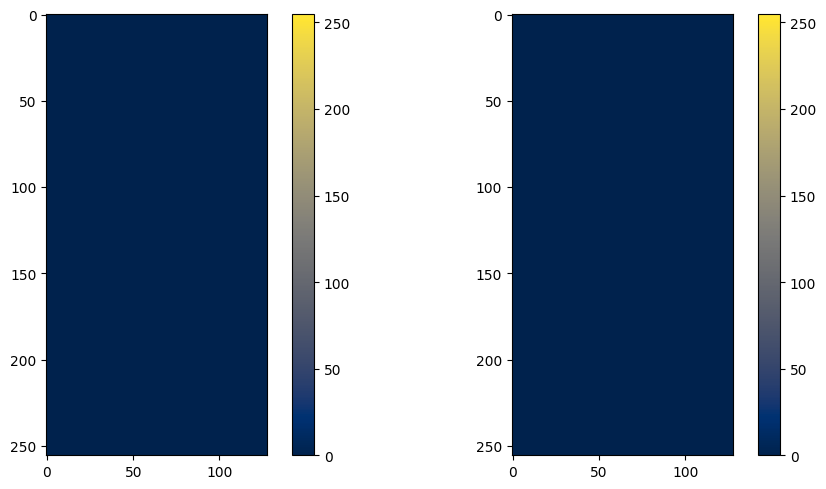

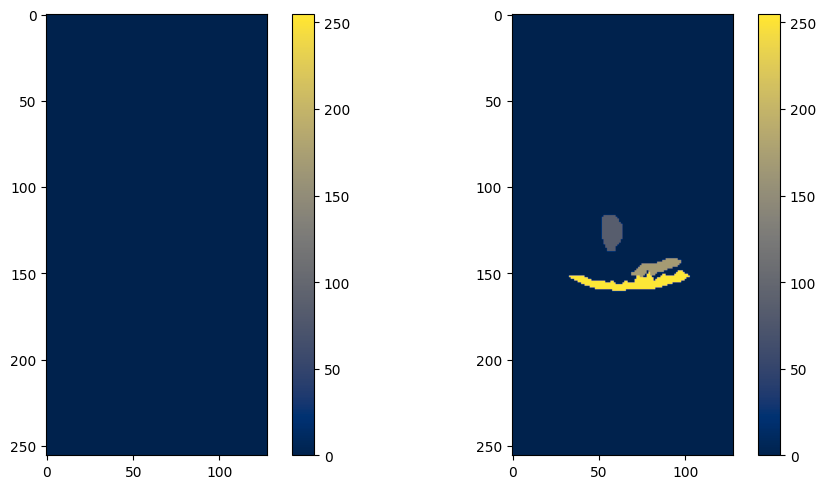

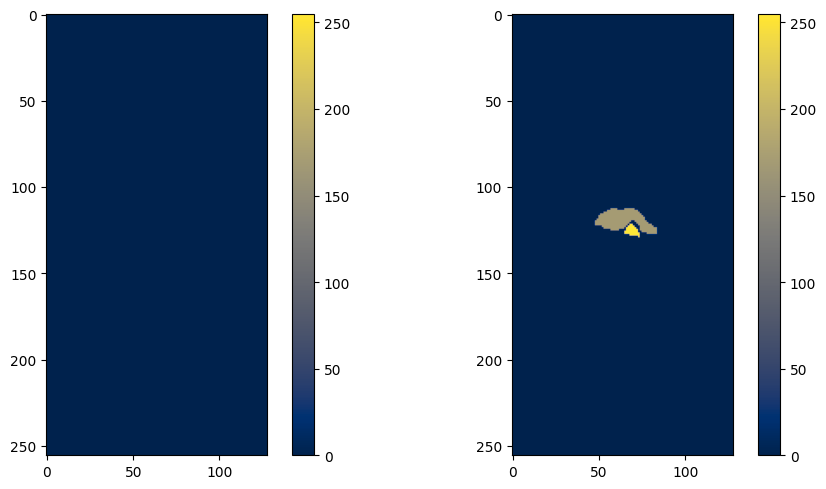

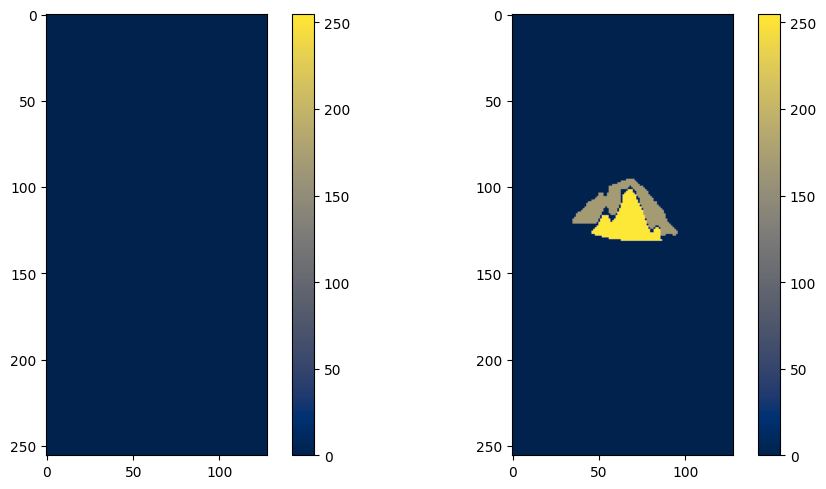

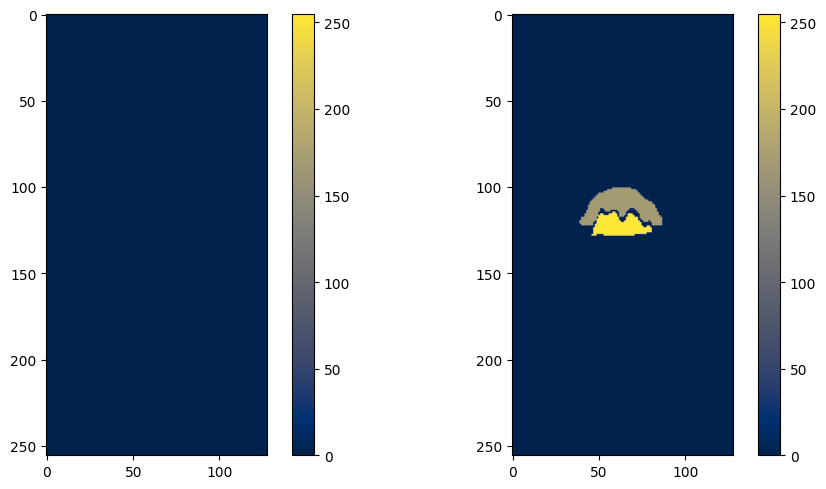

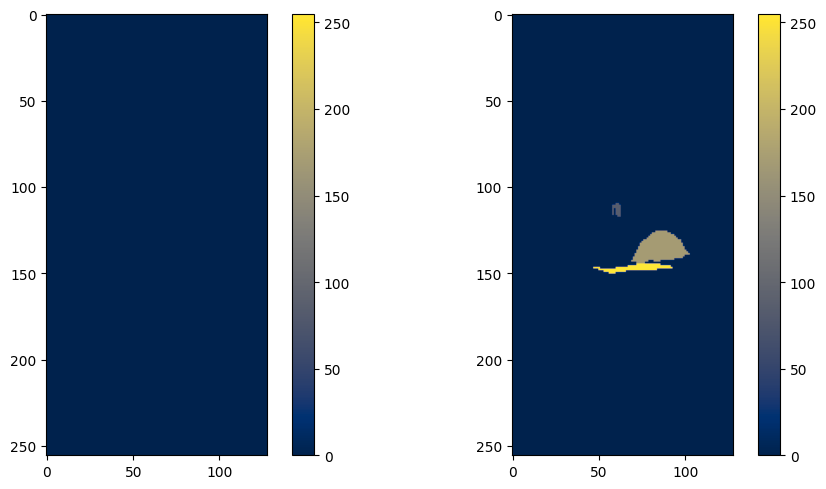

1792 ./Images/OCT/15_000.tif
1792 ./Images/Reference/15_000.tif
1793 ./Images/OCT/15_001.tif
1793 ./Images/Reference/15_001.tif
1794 ./Images/OCT/15_002.tif
1794 ./Images/Reference/15_002.tif
1795 ./Images/OCT/15_003.tif
1795 ./Images/Reference/15_003.tif
1796 ./Images/OCT/15_004.tif
1796 ./Images/Reference/15_004.tif
1797 ./Images/OCT/15_005.tif
1797 ./Images/Reference/15_005.tif
1798 ./Images/OCT/15_006.tif
1798 ./Images/Reference/15_006.tif
1799 ./Images/OCT/15_007.tif
1799 ./Images/Reference/15_007.tif
1800 ./Images/OCT/15_008.tif
1800 ./Images/Reference/15_008.tif
1801 ./Images/OCT/15_009.tif
1801 ./Images/Reference/15_009.tif
1802 ./Images/OCT/15_010.tif
1802 ./Images/Reference/15_010.tif
1803 ./Images/OCT/15_011.tif
1803 ./Images/Reference/15_011.tif
1804 ./Images/OCT/15_012.tif
1804 ./Images/Reference/15_012.tif
1805 ./Images/OCT/15_013.tif
1805 ./Images/Reference/15_013.tif
1806 ./Images/OCT/15_014.tif
1806 ./Images/Reference/15_014.tif
1807 ./Images/OCT/15_015.tif
1807 ./Imag

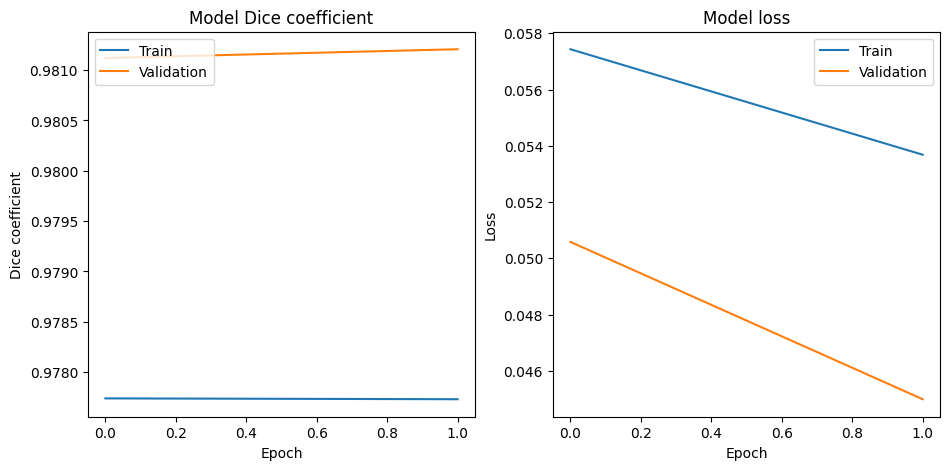

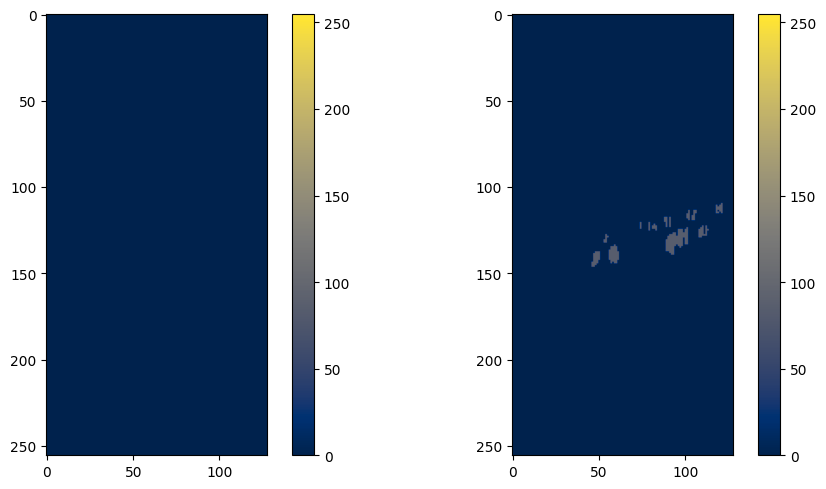

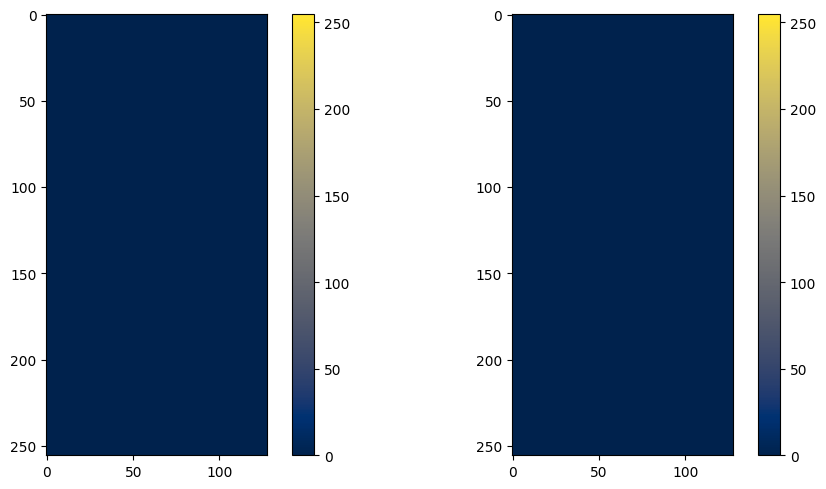

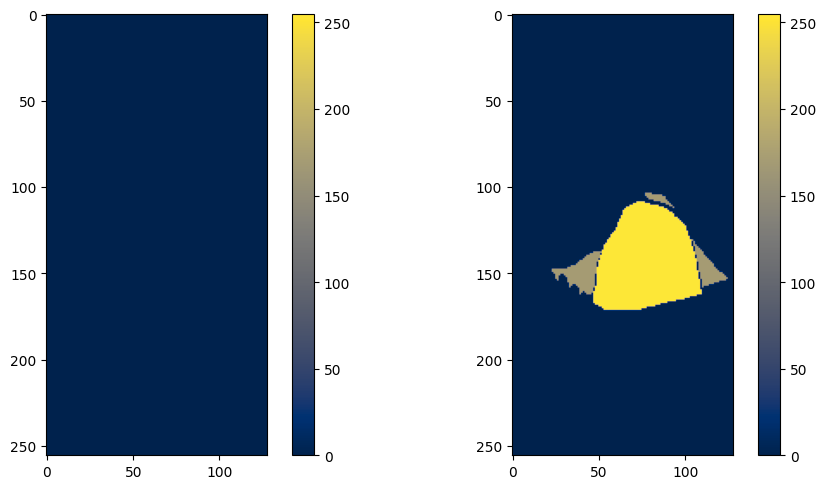

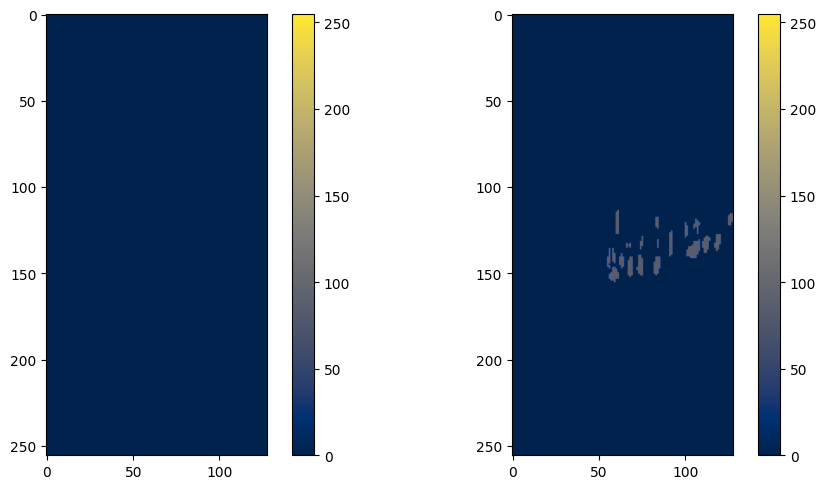

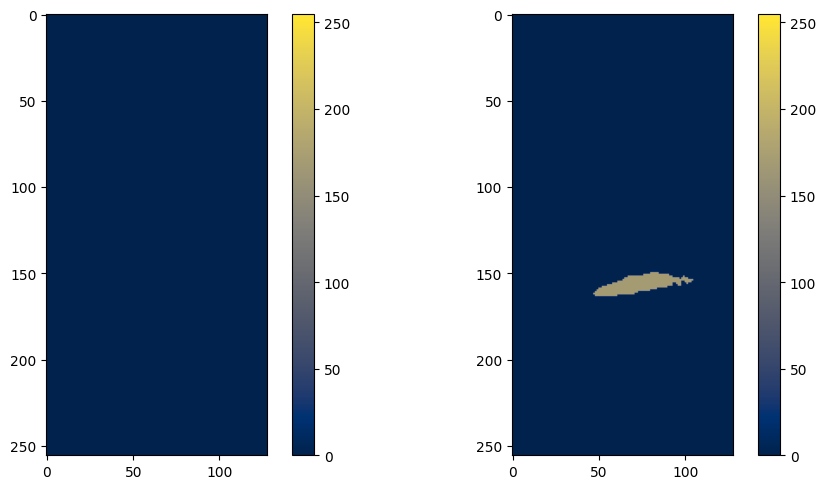

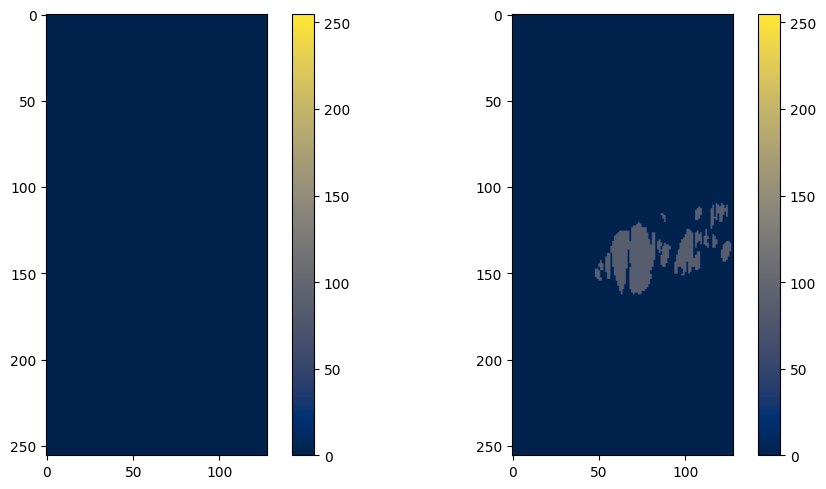

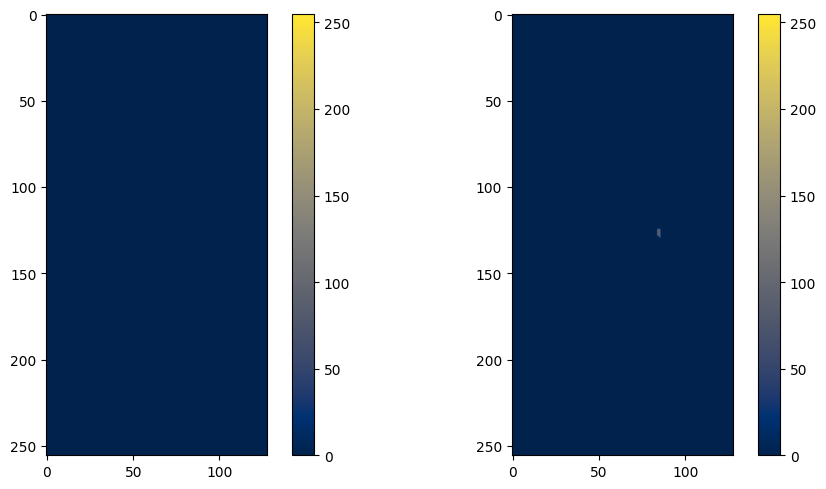

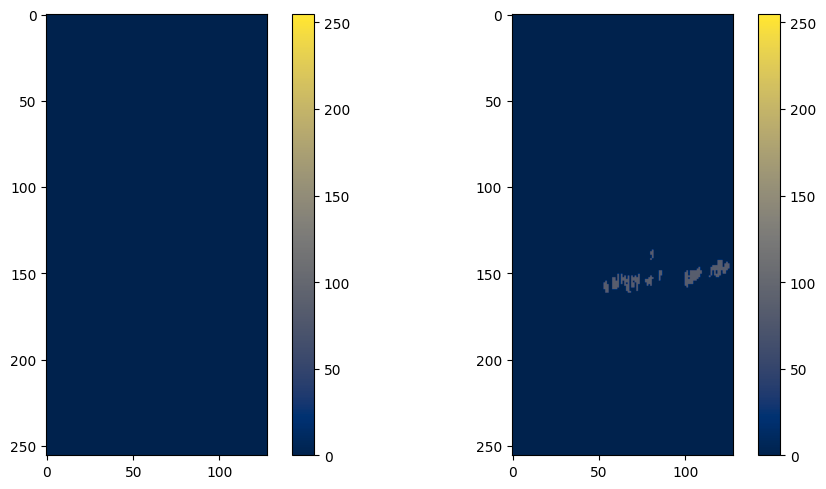

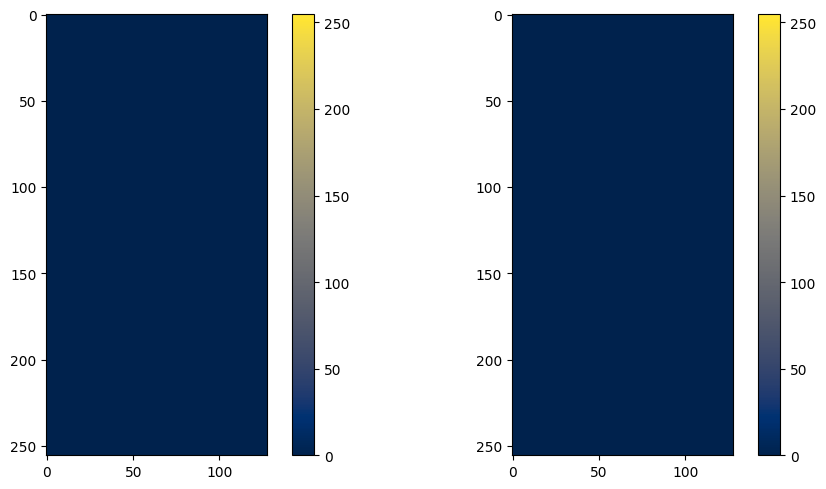

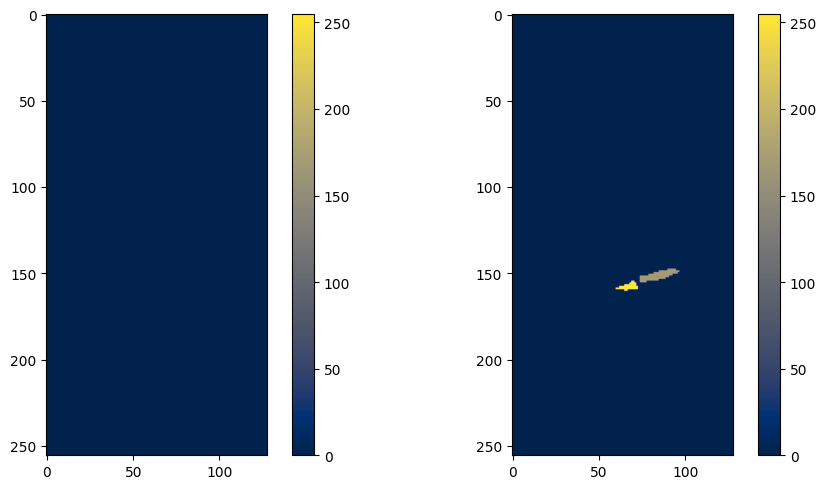

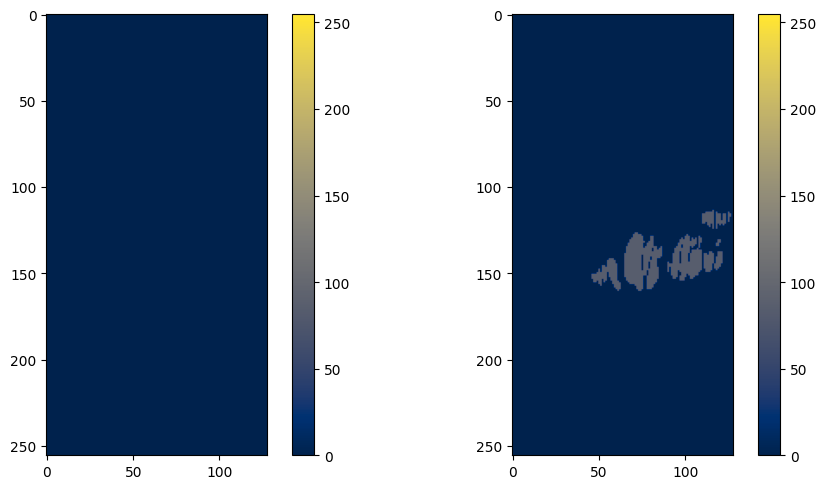

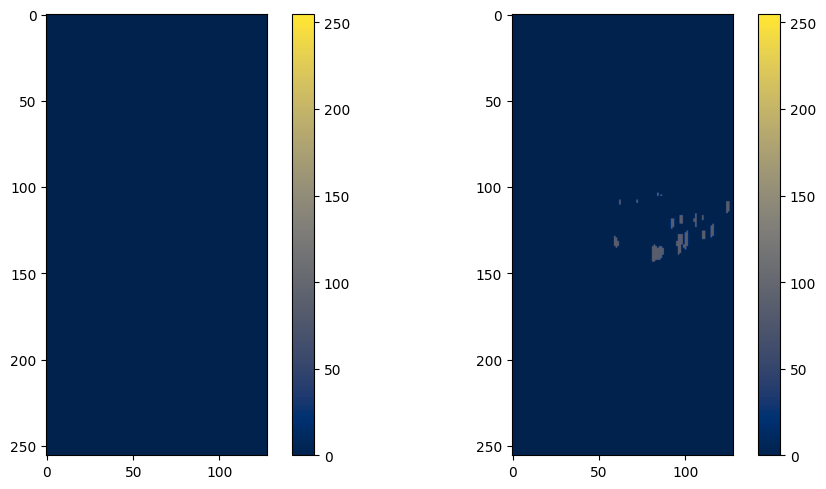

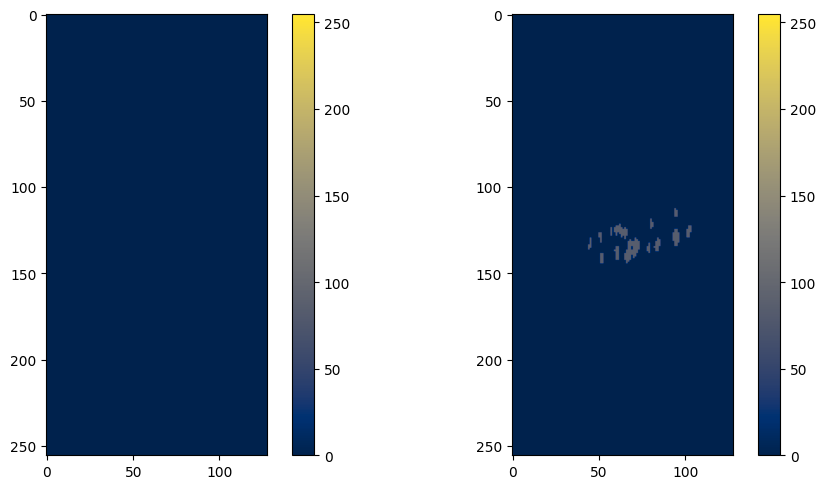

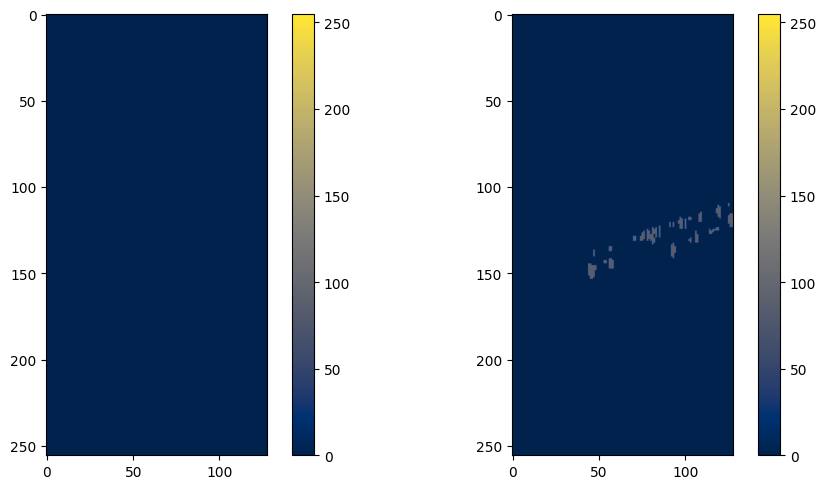

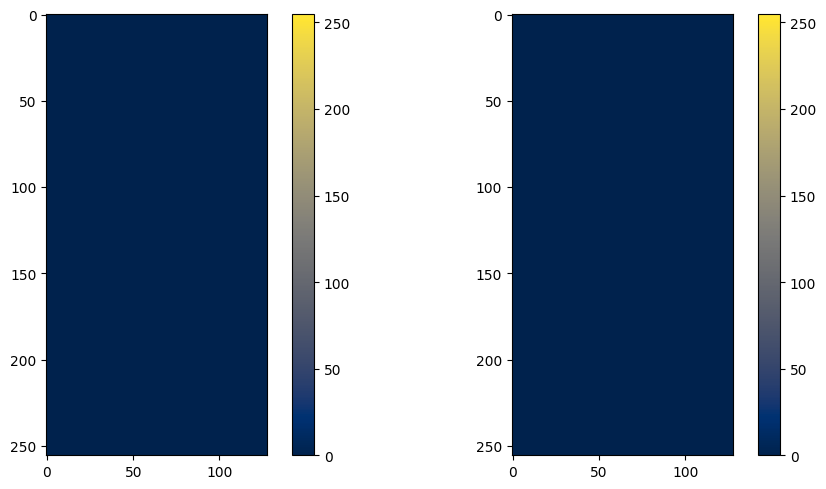

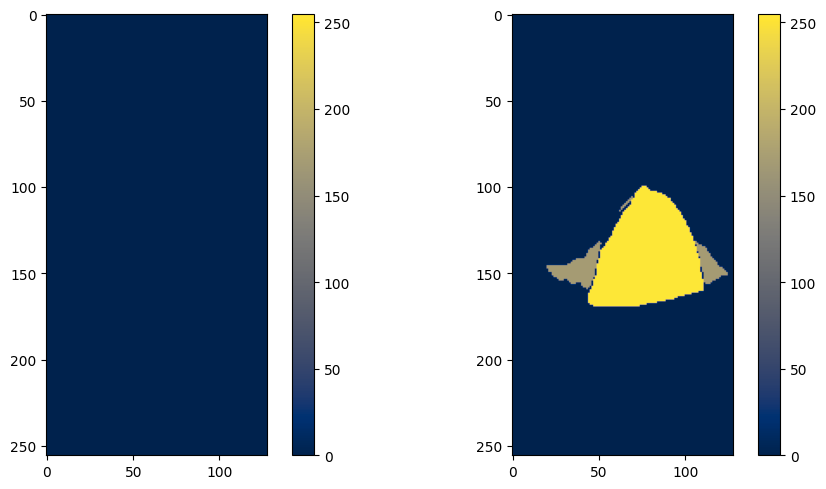

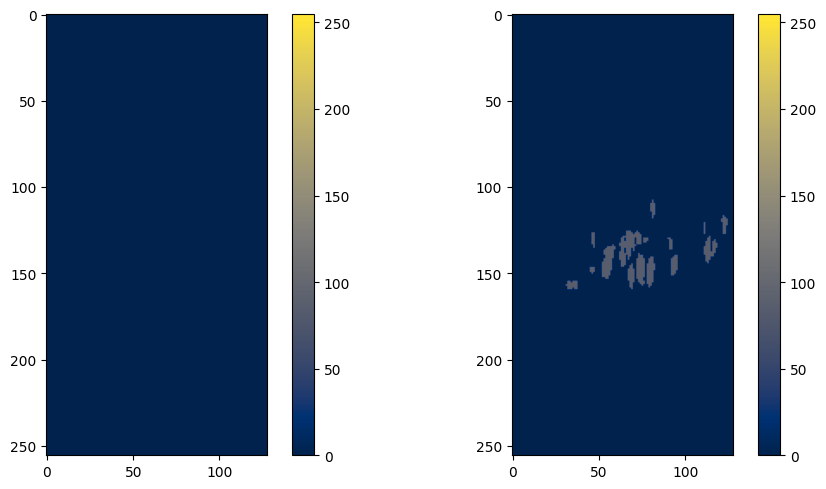

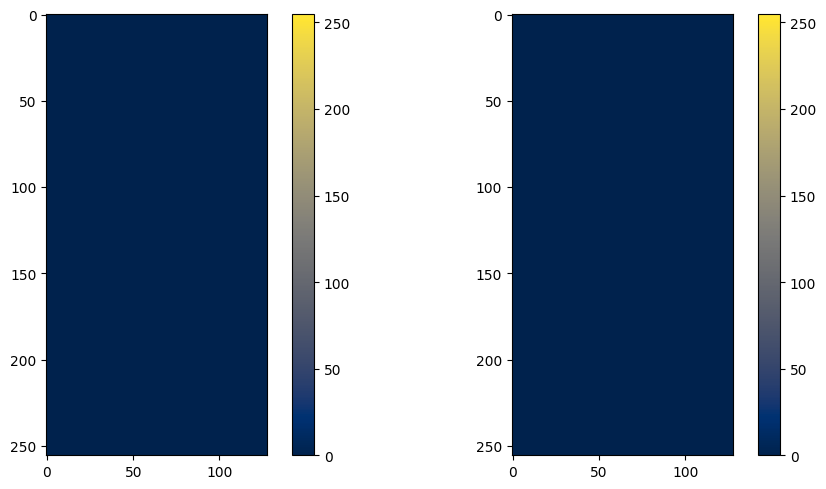

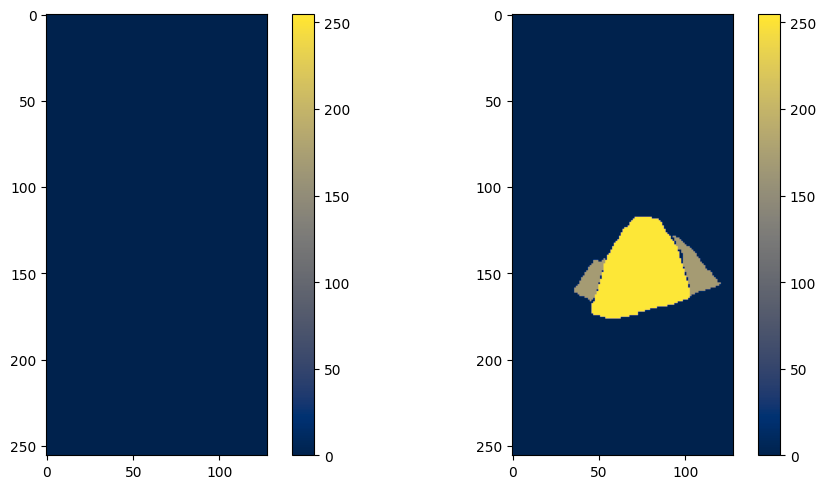

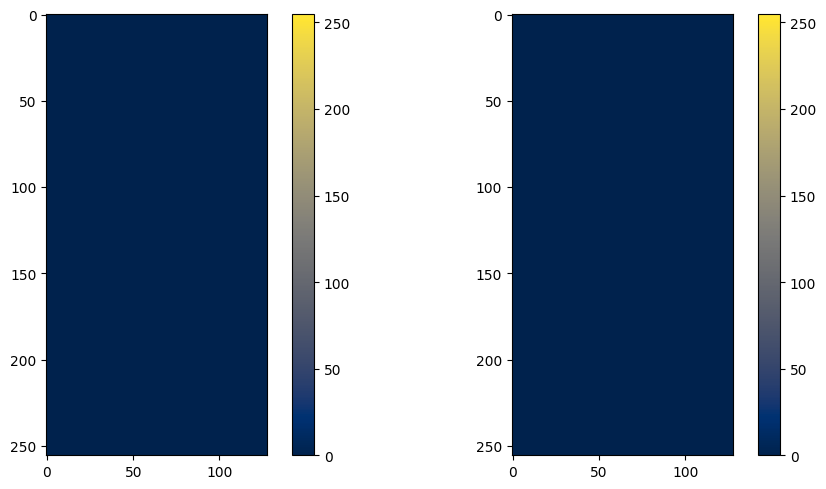

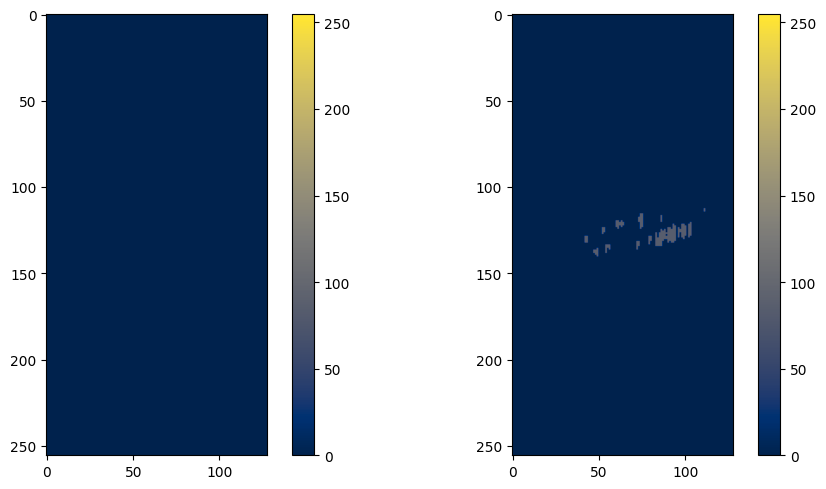

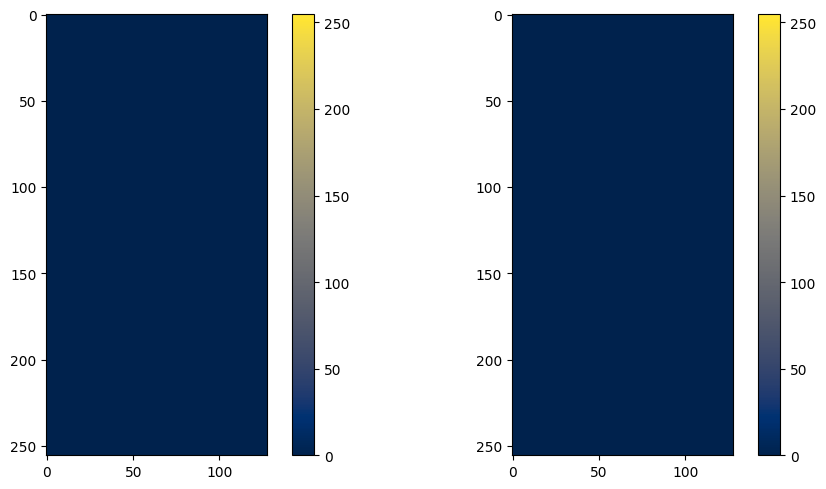

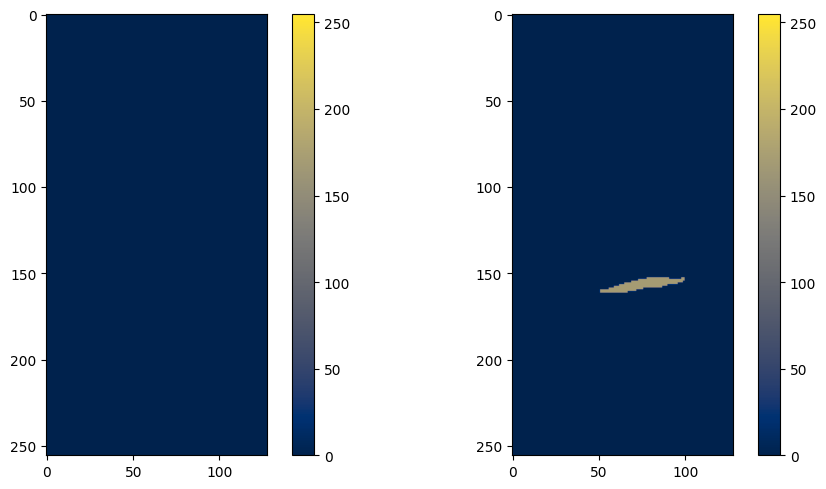

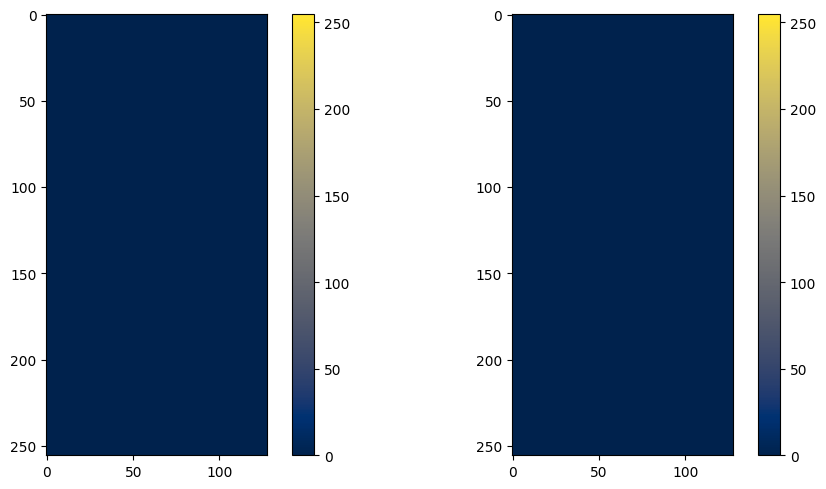

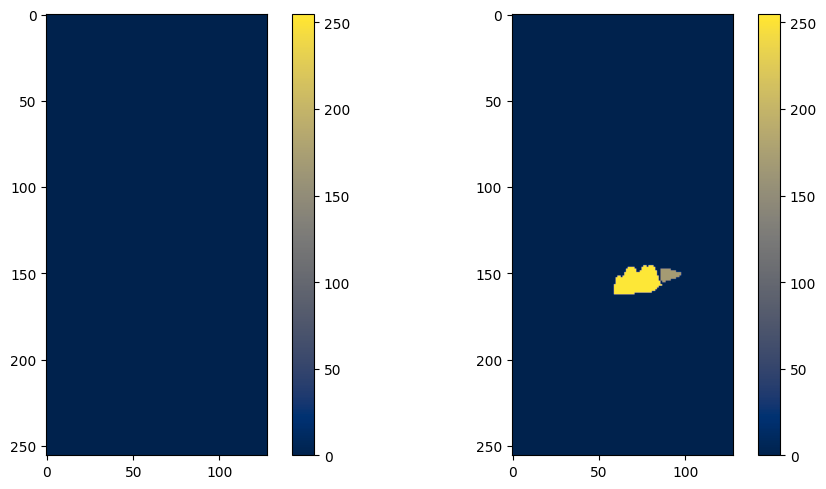

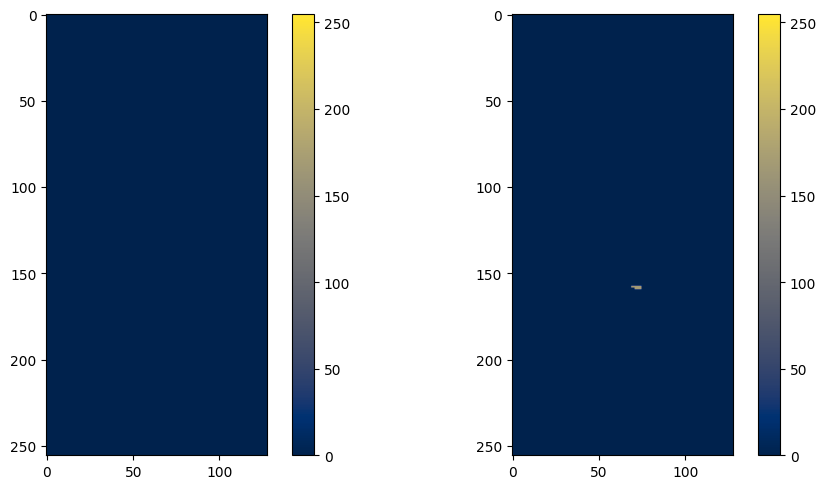

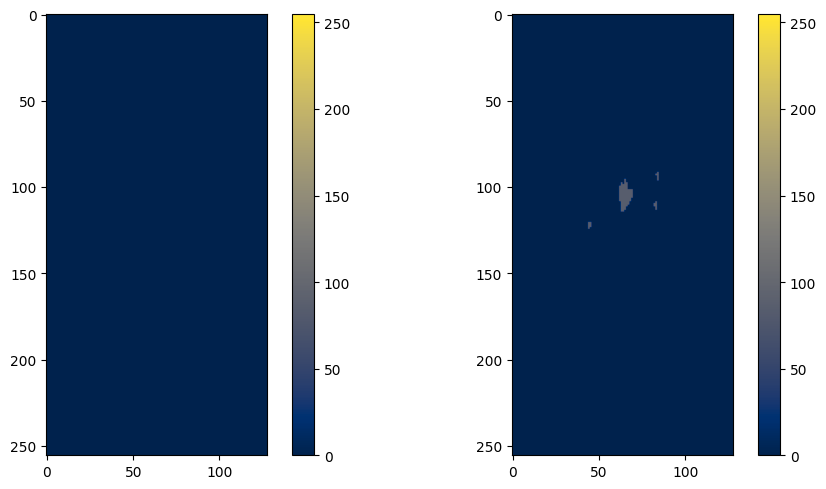

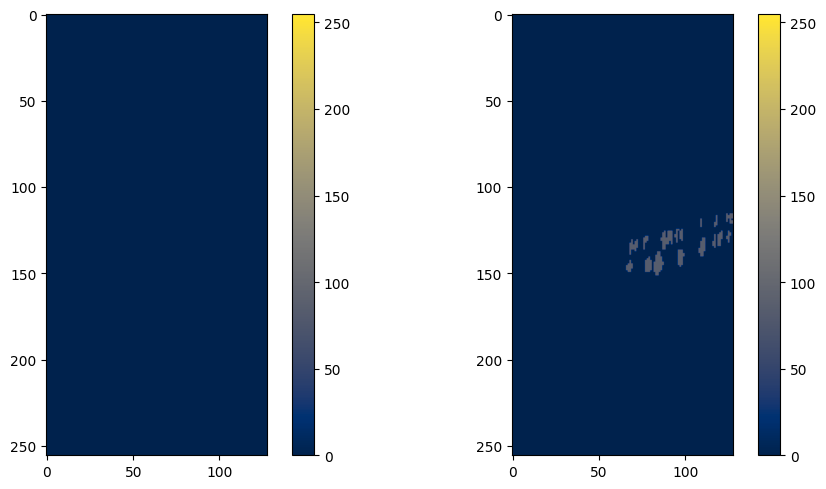

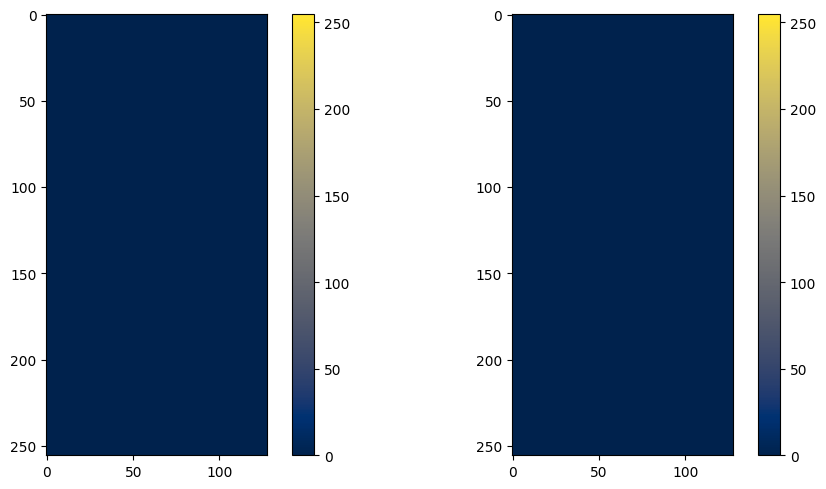

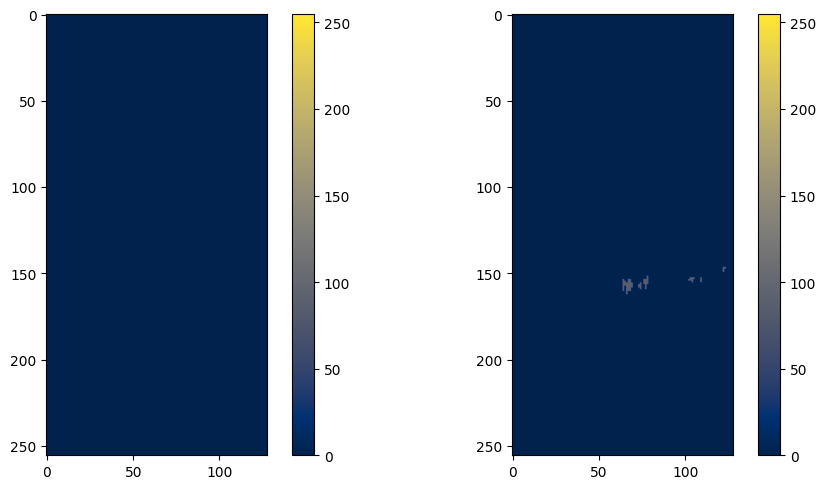

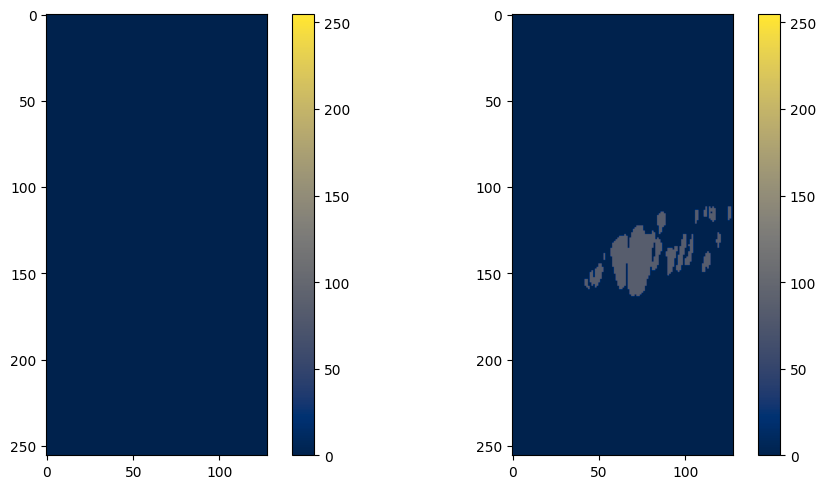

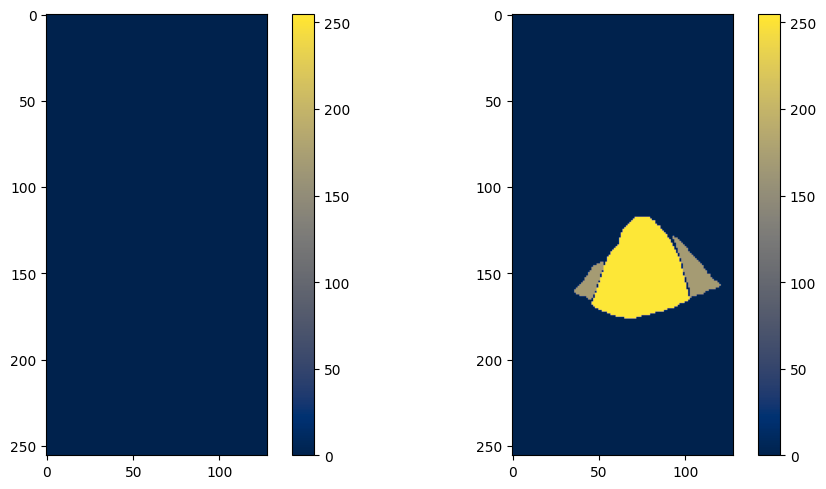

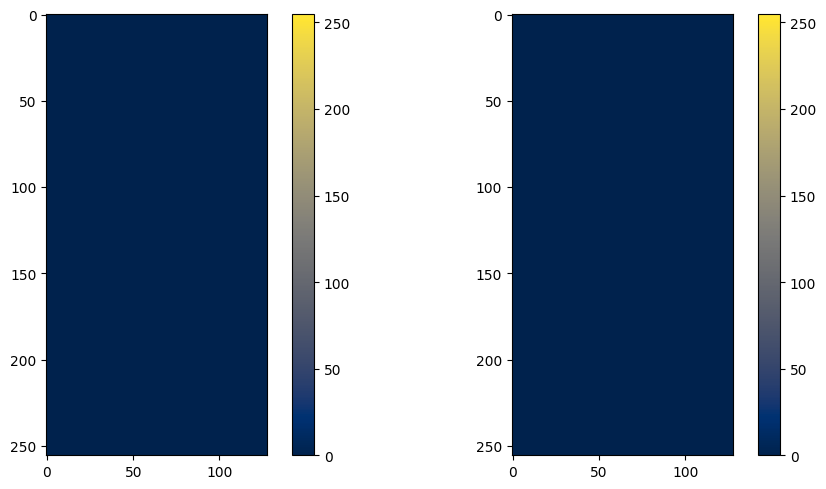

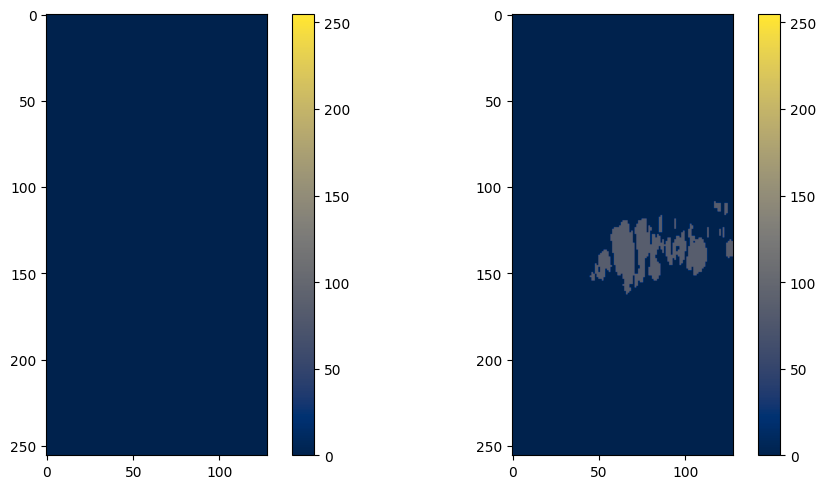

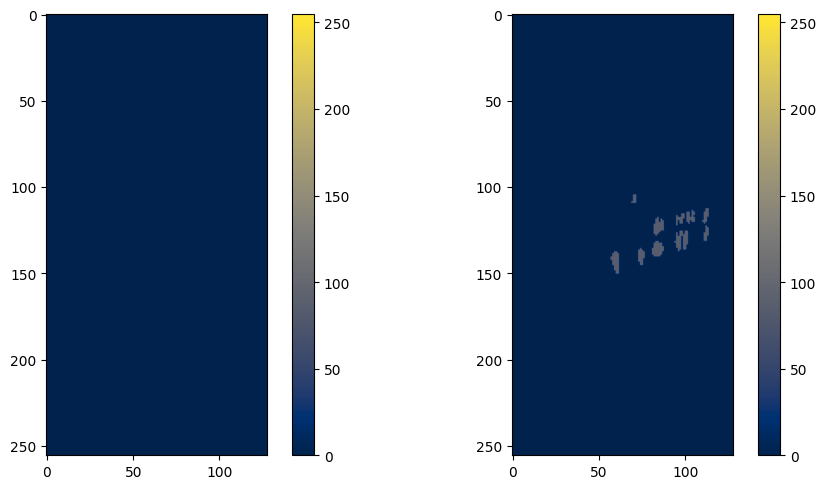

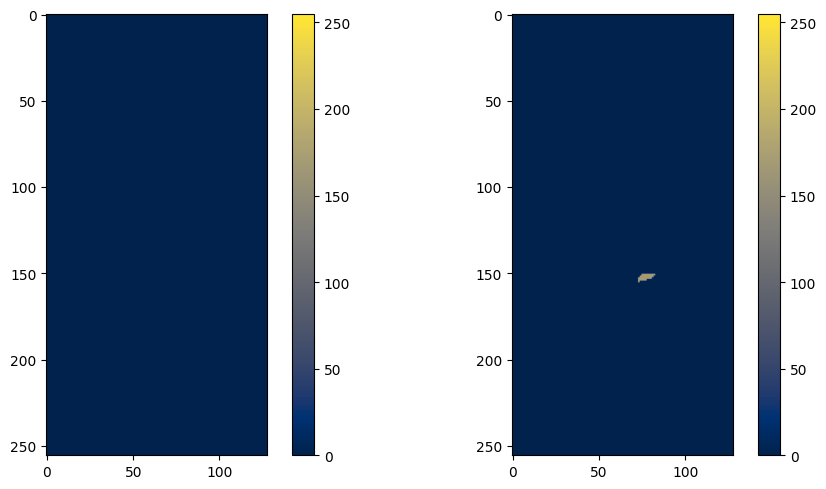

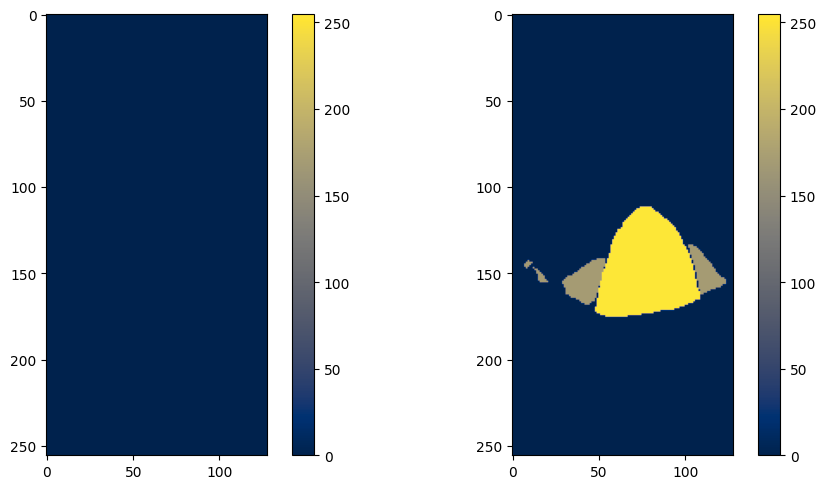

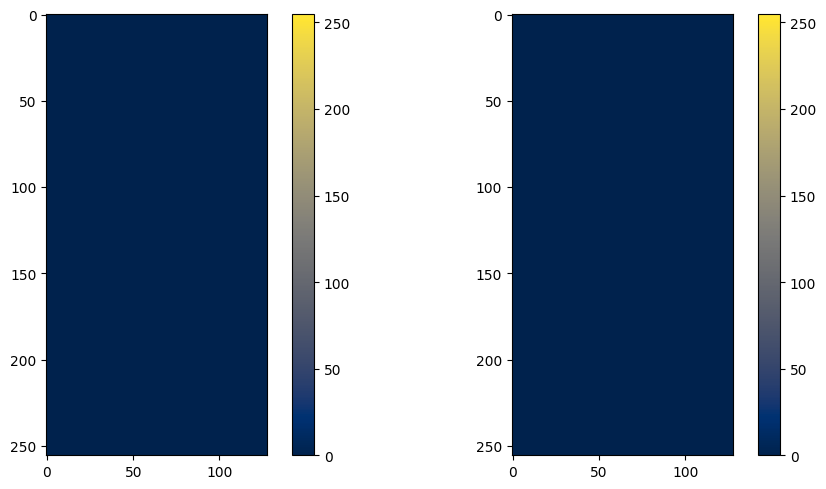

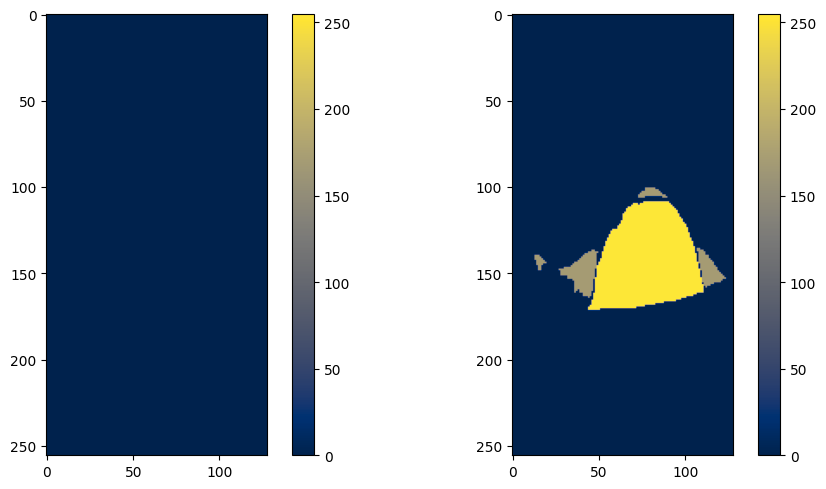

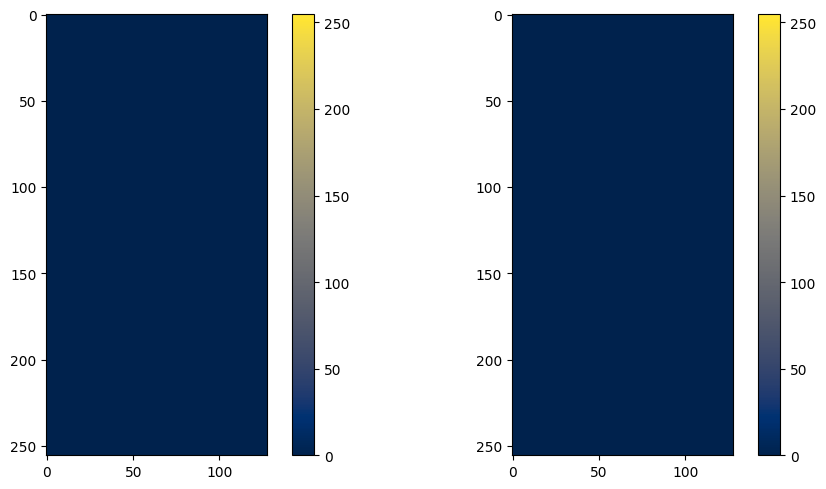

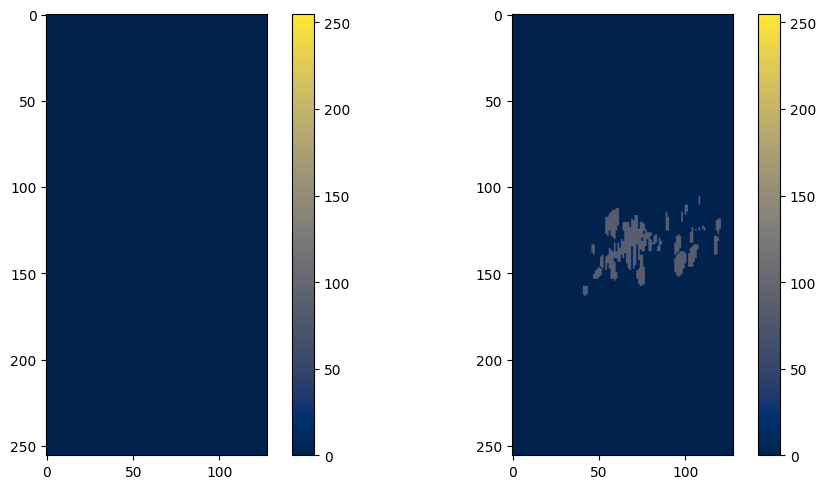

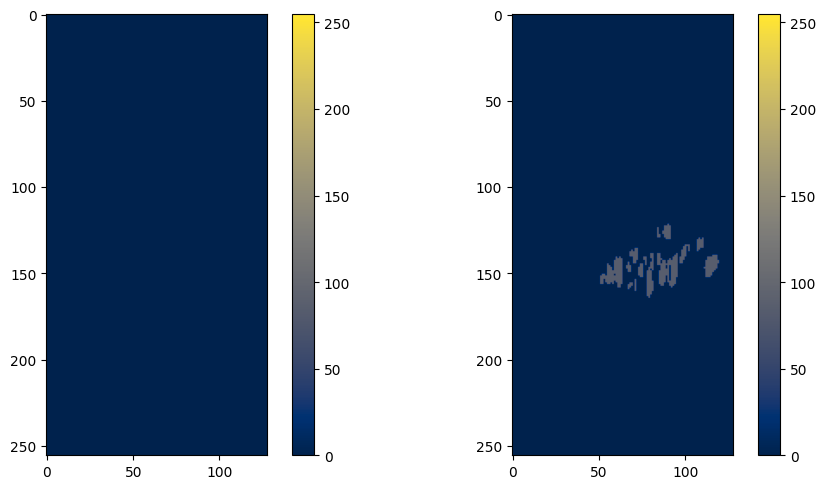

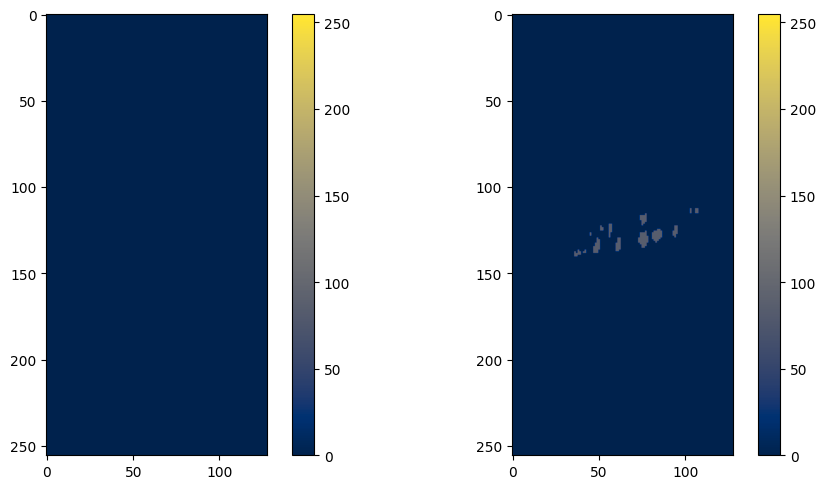

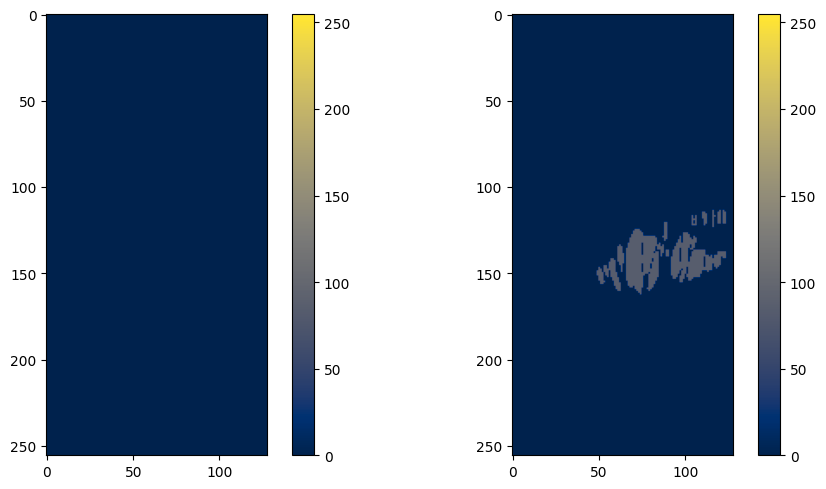

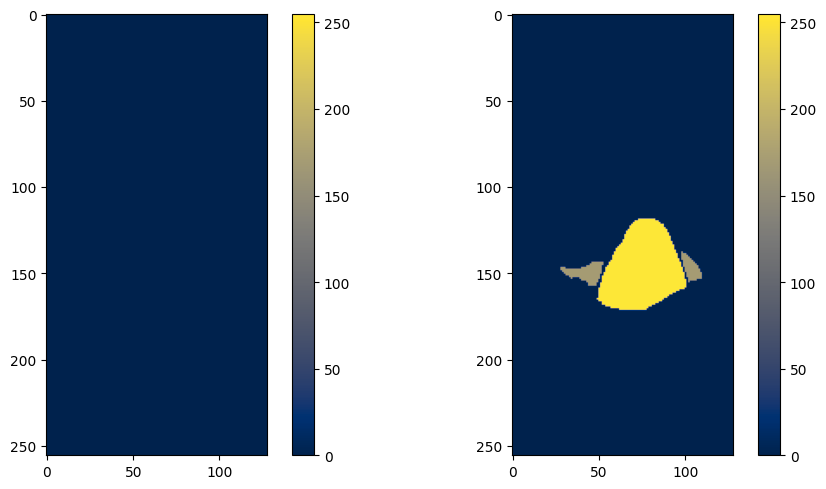

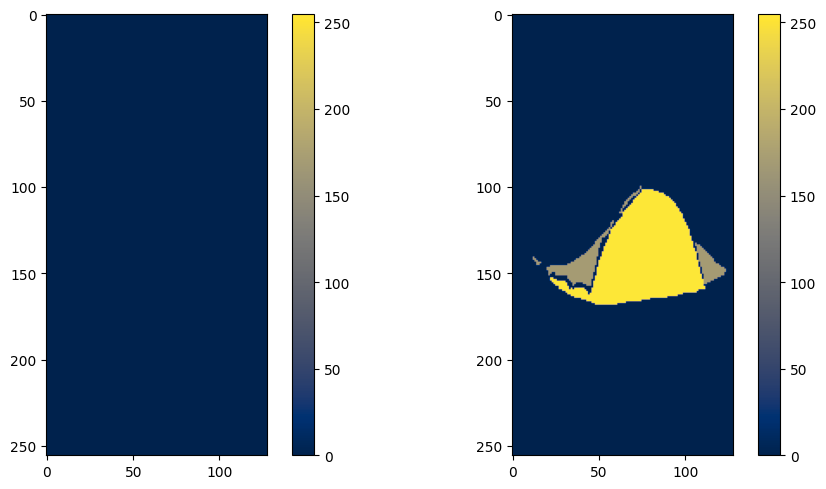

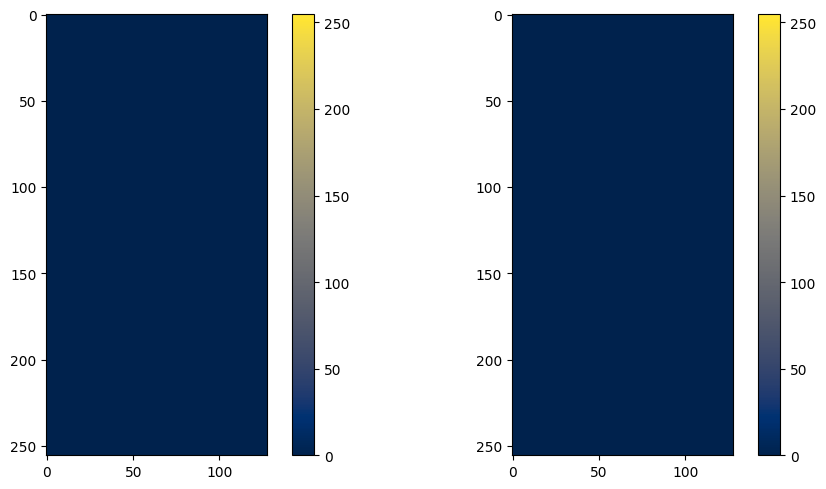

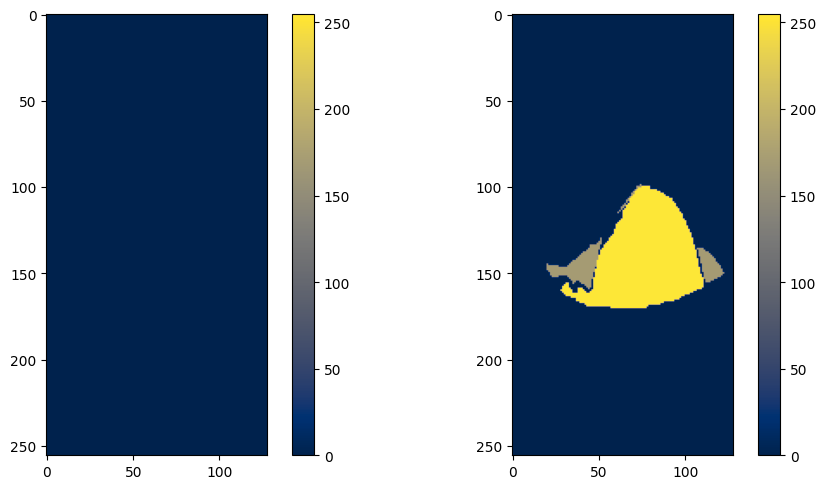

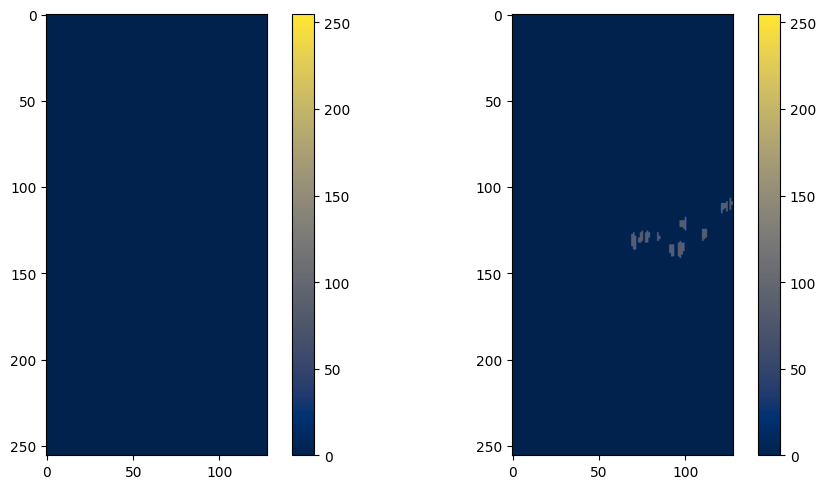

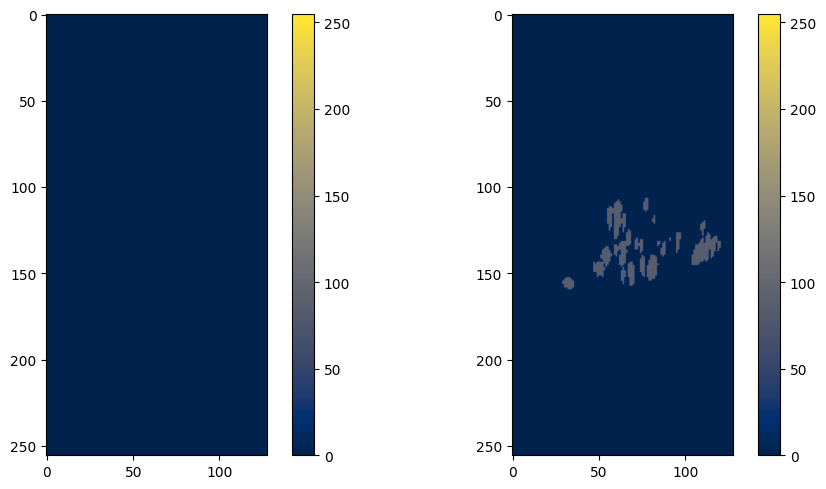

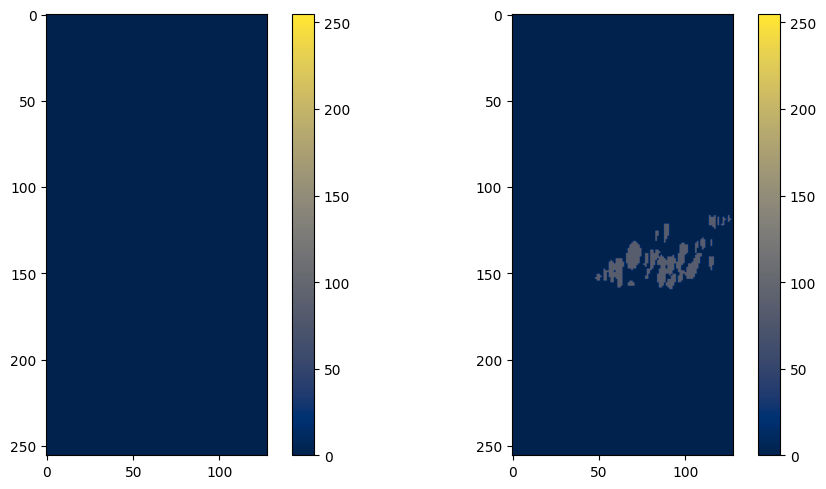

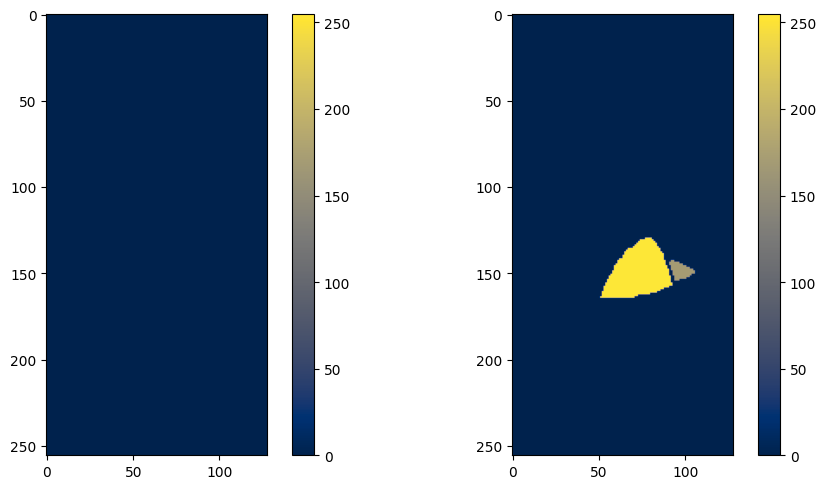

2048 ./Images/OCT/17_000.tif
2048 ./Images/Reference/17_000.tif
2049 ./Images/OCT/17_001.tif
2049 ./Images/Reference/17_001.tif
2050 ./Images/OCT/17_002.tif
2050 ./Images/Reference/17_002.tif
2051 ./Images/OCT/17_003.tif
2051 ./Images/Reference/17_003.tif
2052 ./Images/OCT/17_004.tif
2052 ./Images/Reference/17_004.tif
2053 ./Images/OCT/17_005.tif
2053 ./Images/Reference/17_005.tif
2054 ./Images/OCT/17_006.tif
2054 ./Images/Reference/17_006.tif
2055 ./Images/OCT/17_007.tif
2055 ./Images/Reference/17_007.tif
2056 ./Images/OCT/17_008.tif
2056 ./Images/Reference/17_008.tif
2057 ./Images/OCT/17_009.tif
2057 ./Images/Reference/17_009.tif
2058 ./Images/OCT/17_010.tif
2058 ./Images/Reference/17_010.tif
2059 ./Images/OCT/17_011.tif
2059 ./Images/Reference/17_011.tif
2060 ./Images/OCT/17_012.tif
2060 ./Images/Reference/17_012.tif
2061 ./Images/OCT/17_013.tif
2061 ./Images/Reference/17_013.tif
2062 ./Images/OCT/17_014.tif
2062 ./Images/Reference/17_014.tif
2063 ./Images/OCT/17_015.tif
2063 ./Imag

In [ ]:
batch_size = 256
for base in range(0, 6936 - batch_size, batch_size):
    X_train, y_train = get_train_data(X_train_path,y_train_path, base, base + batch_size)
    y_train = y_train // 85
    y_train = to_categorical(y_train, num_classes=4)

    # Split the training data into training, testing and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Print the shapes of the resulting datasets
    print("Training Data Shapes:")
    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
    print("\nValidation Data Shapes:")
    print("X_val:", X_val.shape)
    print("y_val:", y_val.shape)
    print("\nTesting Data Shapes:")
    print("X_test:", X_test.shape)
    print("y_test:", y_test.shape)

    if base == 0:
        # Define the Model
        input_shape = (256, 128, 1) #----------------------------------------------------------------------------------->Shape
        num_classes = 4
        depth = 4
        model = unet_model(input_shape, num_classes, depth)
        model.summary()
        model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])
        early_stopping = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.001, patience=10, mode='max', verbose=1)

    history = model.fit(X_train, y_train, batch_size=8, epochs=2, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Train Trend plotting
    plt.figure(figsize=(11, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model Dice coefficient')
    plt.ylabel('Dice coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Evaluate the model on the test data
    loss, dice_coefficient  = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Dice Coefficient :", dice_coefficient )

    model.save("./Models/Attention-U-net.h5")

    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    for i in range(len(predictions)):
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,1)
        plt.imshow(predictions[i]*85, cmap='cividis', vmin=0, vmax=255)  # Display the Predicted image in the batch
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(y_test[i]*85, cmap="cividis", vmin=0, vmax=255) # Display the Ground Truth
        plt.colorbar()
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()